<a href="https://colab.research.google.com/github/reagan13/gpt2-distilbert-thesis-files/blob/main/notebook/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample

In [ ]:
import json

# Load the JSON file
with open('final_dataset.json', 'r') as file:
    data = json.load(file)

# If your dataset is a list of dictionaries
if isinstance(data, list):
    for entry in data:
        if 'ner_labels_only' in entry and isinstance(entry['ner_labels_only'], list):
            # Convert the list to a string
            entry['ner_labels_only'] = json.dumps(entry['ner_labels_only'])
            # Print the modified entry
            print("Modified entry:")
            print(json.dumps(entry, indent=4))

# If your dataset is a single dictionary
elif isinstance(data, dict):
    if 'ner_labels_only' in data and isinstance(data['ner_labels_only'], list):
        data['ner_labels_only'] = json.dumps(data['ner_labels_only'])
        # Print the modified data
        print("Modified entry:")
        print(json.dumps(data, indent=4))

# Save the modified data back to the file
with open('final_dataset_temp.json', 'w') as file:
    json.dump(data, file, indent=4)

print("\nConversion complete. Check final_dataset.json for the updated data.")

Streaming output truncated to the last 5000 lines.
    "has_placeholder": false,
    "ner_labels_only": "[]"
}
Modified entry:
{
    "instruction": "show me my restitution status",
    "category": "refund",
    "intent": "track_refund",
    "response": "sure! i completely understand your need to check the status of your restitution. rest assured, i'm here to assist you with that. let me quickly gather the required information to give you an update on your restitution status. please bear with me for a moment while i retrieve the most recent details. your patience is highly appreciated.",
    "has_placeholder": false,
    "ner_labels_only": "[]"
}
Modified entry:
{
    "instruction": "where could i see if there is anything new on my refund?",
    "category": "refund",
    "intent": "track_refund",
    "response": "definitely! i understand that you're looking to stay updated on any new developments regarding your refund. to check for the latest information, please navigate to your '{{acco

# PIP#

Python library used for evaluating sequence labeling tasks, such as Named Entity Recognition (NER) and part-of-speech tagging.

In [ ]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=becac304266a9a28efb4eda5234419dfa10075ef3258d40e6b08ea94f2dd3ded
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Uploading Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_dataset.json to final_dataset.json


# CODE

## Import libraries

This code imports necessary libraries for working with PyTorch, data visualization, evaluation metrics, and JSON handling.

In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2TokenizerFast, GPT2Model, GPT2Config, AdamW, get_linear_schedule_with_warmup
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmaps
import os
from google.colab import drive
from tabulate import tabulate
import time # Import the time module

## Mount To GDrive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"
os.makedirs(SAVE_PATH, exist_ok=True)

Mounted at /content/drive


## Load dataset

It defines a function load_dataset that loads and returns a dataset from a specified JSON file. The function reads the JSON file, parses its content, and outputs it as a list of dictionaries.

In [ ]:
# Load dataset
def load_dataset(json_file: str) -> List[Dict]:
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)

## Saved Datasplit

In [ ]:
# Save dataset splits
def save_dataset_split(data: List[Dict], split_name: str, save_path: str):
    file_path = os.path.join(save_path, f"{split_name}.json")
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Saved {split_name} split to {file_path}")

## Load Data Split

In [ ]:
# Load or split dataset
def get_dataset_splits(json_file: str, save_path: str, train_ratio=0.8, val_ratio=0.1):
    train_file = os.path.join(save_path, "train.json")
    val_file = os.path.join(save_path, "val.json")
    test_file = os.path.join(save_path, "test.json")

    if os.path.exists(train_file) and os.path.exists(val_file) and os.path.exists(test_file):
        print("Loading pre-split datasets...")
        train_data = load_dataset(train_file)
        val_data = load_dataset(val_file)
        test_data = load_dataset(test_file)
    else:
        print("Splitting dataset and saving...")
        data = load_dataset(json_file)
        train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
        val_data, test_data = train_test_split(temp_data, train_size=val_ratio / (1 - train_ratio), random_state=42)
        save_dataset_split(train_data, "train", save_path)
        save_dataset_split(val_data, "val", save_path)
        save_dataset_split(test_data, "test", save_path)

    return train_data, val_data, test_data

## Detect and Mapping the labels

This code defines the detect_labels function, which processes a dataset to identify unique categories, intents, and named entity recognition (NER) labels. The function iterates through each sample in the dataset, extracting and adding unique values to sets for categories, intents, and NER labels. It also creates mappings (encoders) to assign an integer index to each unique category, intent, and NER label, which are then returned as a dictionary. The function prints out the encoders for categories, intents, and NER labels.

In [ ]:
# Updated detect_labels to use BIO scheme like HybridFusionMultiTask
def detect_labels(data: List[Dict]) -> Dict[str, Dict]:
    unique_categories = set()
    unique_intents = set()
    unique_ner_labels = set(["O"])  # "O" is the default label for tokens outside entities

    for sample in data:
        unique_categories.add(sample["category"])
        unique_intents.add(sample["intent"])
        ner_labels = sample["ner_labels_only"]  # Convert string to list of dicts
        ner_labels = json.loads(ner_labels) # Parse string to list of dictionaries
        for label in ner_labels:
            label_type = label["label"]
            unique_ner_labels.add(f"B-{label_type}")  # Add "B-" prefix for beginning of entity
            unique_ner_labels.add(f"I-{label_type}")  # Add "I-" prefix for inside of entity

    category_encoder = {cat: idx for idx, cat in enumerate(sorted(unique_categories))}
    intent_encoder = {intent: idx for idx, intent in enumerate(sorted(unique_intents))}
    ner_label_encoder = {ner: idx for idx, ner in enumerate(sorted(unique_ner_labels))}

    print("Category encoder:", category_encoder)
    print("Intent encoder:", intent_encoder)
    print("NER label encoder:", ner_label_encoder)

    return {
        "category_encoder": category_encoder,
        "intent_encoder": intent_encoder,
        "ner_label_encoder": ner_label_encoder
    }




## Tokenize the text

This code is a function that tokenizes input text using GPT-2tokenizers. It processes the text by truncating or padding it to a maximum length, and returns tokenized outputs in the form of input_ids and attention_mask for the model. These tokenized inputs are then ready to be fed into the model for multitask learning.

In [ ]:
# Tokenization
def tokenize_text_gpt2(text: str, gpt2_tokenizer, max_length: int = 128) -> Dict[str, torch.Tensor]:

    gpt2_inputs = gpt2_tokenizer(
        text, max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
        )
    return {"gpt2_input_ids": gpt2_inputs["input_ids"].squeeze(0),
            "gpt2_attention_mask": gpt2_inputs["attention_mask"].squeeze(0)}

## Aligning Ner Labels

The align_ner_labels function aligns Named Entity Recognition (NER) labels with tokenized input from GPT2. It tokenizes the text, maps each token to its character offset, and then assigns appropriate NER labels based on the positions of entities in the text. It ensures that the labels are correctly aligned with the tokens, using the BIO (Begin, Inside, Outside) scheme. The function returns a list of integers representing the aligned NER labels, which can then be used for training or evaluation.

In [ ]:
# Align NER labels
def align_ner_labels(text: str, ner_labels: str, tokenizer, ner_label_encoder: Dict, max_length: int = 128) -> List[int]:
    ner_labels = json.loads(ner_labels)
    encoding = tokenizer(text, max_length=max_length, padding="max_length", truncation=True, return_offsets_mapping=True, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    token_to_char_map = encoding["offset_mapping"][0].tolist()
    ner_aligned = [ner_label_encoder["O"]] * len(tokens)

    for label in ner_labels:
        label_text, label_type = label["text"], label["label"]
        label_start = text.find(label_text)
        if label_start == -1:
            continue
        label_end = label_start + len(label_text)
        for i, (start, end) in enumerate(token_to_char_map):
            if start == 0 and end == 0:
                continue
            if start >= label_start and end <= label_end:
                prefix = "B-" if ner_aligned[i] == ner_label_encoder["O"] else "I-"
                ner_aligned[i] = ner_label_encoder[f"{prefix}{label_type}"]

    return ner_aligned[:max_length]

## Splitting Dataset

The split_dataset function splits a given dataset into training, validation, and test sets based on specified ratios. It first splits the data into training and temporary sets, then splits the temporary set into validation and test sets. The function uses train_test_split from scikit-learn to ensure random, reproducible splits.

In [ ]:
# Split dataset (unchanged)
def split_dataset(data: List[Dict], train_ratio=0.8, val_ratio=0.1):
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=val_ratio / (1 - train_ratio), random_state=42)
    return train_data, val_data, test_data

## Custom Dataset

The MultiTaskDataset class is a custom dataset for multitask learning, designed to handle text data for Intent Classification, Category Classification, and Named Entity Recognition (NER). It tokenizes the input text using GPT-2 tokenizers, aligns the NER labels with the tokenized text, and encodes the labels (category, intent, NER) using provided label encoders. The dataset returns tokenized inputs for both models and the associated labels as tensors for training in multitask settings.

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, data: List[Dict], gpt2_tokenizer, label_encoders, max_length: int = 128):
        self.data, self.gpt2_tokenizer, self.label_encoders, self.max_length = data, gpt2_tokenizer, label_encoders, max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample["instruction"]
        gpt2_inputs = tokenize_text_gpt2(text, self.gpt2_tokenizer, self.max_length)
        return {
            "input_ids": gpt2_inputs["gpt2_input_ids"],  # Changed to "input_ids"
            "attention_mask": gpt2_inputs["gpt2_attention_mask"],  # Changed to "attention_mask"
            "category_labels": self.label_encoders["category_encoder"][sample["category"]],  # Changed to "category_labels"
            "intent_labels": self.label_encoders["intent_encoder"][sample["intent"]],  # Changed to "intent_labels"
            "ner_labels": torch.tensor(align_ner_labels(text, sample["ner_labels_only"], self.gpt2_tokenizer, self.label_encoders["ner_label_encoder"], self.max_length))
        }

## Data Loader

The get_dataloaders function creates DataLoader objects for the training, validation, and test datasets. It initializes MultiTaskDataset for each dataset and then creates corresponding DataLoader instances with specified batch sizes and the number of workers for parallel data loading. These DataLoaders are used to efficiently load data in batches during model training and evaluation.

In [ ]:
# DataLoader setup
def get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, label_encoders, batch_size=16, num_workers=0):
    train_dataset = MultiTaskDataset(train_data, gpt2_tokenizer, label_encoders)
    val_dataset = MultiTaskDataset(val_data, gpt2_tokenizer, label_encoders)
    test_dataset = MultiTaskDataset(test_data, gpt2_tokenizer, label_encoders)
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )

## MODEL ARCHITECTURE

This code defines a multi-task learning model, BaselineGPT2MultiTask, which uses a pre-trained GPT-2 model for three tasks: intent classification, category classification, and named entity recognition (NER). The GPT-2 model is frozen (its parameters are not updated during training) by setting requires_grad = False for all its parameters. The model extracts features from GPT-2 and processes them through task-specific heads to generate logits for each task. If labels are provided, it computes the loss for all tasks. The model also includes methods to save and load its state.

In [ ]:
# Model definition
class BaselineGPT2MultiTask(nn.Module):
    def __init__(self, num_intents: int, num_categories: int, num_ner_labels: int, dropout_rate: float = 0.2):
        super().__init__()
        self.config = GPT2Config.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        hidden_size = self.config.n_embd
        for param in self.gpt2.parameters():
            param.requires_grad = False
        self.intent_head = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate), nn.Linear(hidden_size, num_intents))
        self.category_head = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate), nn.Linear(hidden_size, num_categories))
        self.ner_head = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Tanh(), nn.Dropout(dropout_rate), nn.Linear(hidden_size, num_ner_labels))

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, intent_labels: Optional[torch.Tensor] = None,
                category_labels: Optional[torch.Tensor] = None, ner_labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        batch_size = sequence_output.shape[0]
        sequence_lengths = attention_mask.sum(dim=1) - 1
        last_token_indexes = sequence_lengths.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, sequence_output.shape[-1])
        sequence_repr = torch.gather(sequence_output, 1, last_token_indexes).squeeze(1)
        intent_logits = self.intent_head(sequence_repr)
        category_logits = self.category_head(sequence_repr)
        ner_logits = self.ner_head(sequence_output)
        loss = None
        if all(label is not None for label in [intent_labels, category_labels, ner_labels]):
            intent_loss = F.cross_entropy(intent_logits, intent_labels)
            category_loss = F.cross_entropy(category_logits, category_labels)
            active_loss = attention_mask.view(-1) == 1
            active_logits = ner_logits.view(-1, ner_logits.size(-1))[active_loss]
            active_labels = ner_labels.view(-1)[active_loss]
            ner_loss = F.cross_entropy(active_logits, active_labels)
            loss = intent_loss + category_loss + ner_loss
        return {'intent_logits': intent_logits, 'category_logits': category_logits, 'ner_logits': ner_logits, 'loss': loss}

## TRAINING MODEL INITIALIZATION

The train_model_with_mixed_precision function trains a multitask model using mixed-precision training for improved performance and memory efficiency. It tracks multiple metrics, including training loss, validation loss, intent accuracy, category accuracy, and NER F1 score. The function leverages gradient accumulation for efficient updates and autocast for automatic mixed precision during forward and backward passes. It computes and reports the metrics for both training and validation phases, and filters out "O" labels in NER for accurate F1 score calculation. The model is trained for a specified number of epochs on a GPU device.

In [ ]:
# Training function with enhanced metrics
def train_model_with_mixed_precision(model, train_loader, val_loader, optimizer, scheduler, label_encoders, num_epochs=5, device="cuda", accumulation_steps=4):
    model.to(device)
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}
    metrics = {"train_losses": [], "val_losses": [], "train_intent_acc": [], "train_category_f1": [], "train_ner_micro_f1": [],
               "val_intent_acc": [], "val_category_f1": [], "val_ner_macro_f1": [], "epoch_times": []}

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs} (Device: {device})")
        print("-" * 50)

        # Training
        model.train()
        train_loss = 0.0
        train_intent_preds, train_intent_labels = [], []
        train_category_preds, train_category_labels = [], []
        train_ner_preds, train_ner_labels = [], []
        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            batch_start = time.time()
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)  # This now works with the corrected keys
            loss = outputs["loss"] / accumulation_steps
            loss.backward()
            train_loss += loss.item()

            train_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            train_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
            train_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            train_category_labels.extend(inputs["category_labels"].cpu().numpy())
            train_ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
            train_ner_labels.extend(inputs["ner_labels"].cpu().numpy())

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            print(f"Batch {i + 1} Latency: {time.time() - batch_start:.4f}s", end='\r')

        # Rest of the function remains unchanged...

        avg_train_loss = train_loss / len(train_loader)
        train_intent_acc = accuracy_score(train_intent_labels, train_intent_preds)
        train_category_f1 = f1_score(train_category_labels, train_category_preds, average='weighted')
        train_ner_true = [[ner_label_decoder[l] for l in seq] for seq in train_ner_labels]
        train_ner_pred = [[ner_label_decoder[p] for p in seq] for seq in train_ner_preds]
        train_ner_micro_f1 = seq_f1(train_ner_true, train_ner_pred, average='micro')

        # Validation
        model.eval()
        val_loss = 0.0
        val_intent_preds, val_intent_labels = [], []
        val_category_preds, val_category_labels = [], []
        val_ner_preds, val_ner_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                val_loss += outputs["loss"].item()
                val_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
                val_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
                val_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
                val_category_labels.extend(inputs["category_labels"].cpu().numpy())
                val_ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
                val_ner_labels.extend(inputs["ner_labels"].cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_intent_acc = accuracy_score(val_intent_labels, val_intent_preds)
        val_category_f1 = f1_score(val_category_labels, val_category_preds, average='weighted')
        val_ner_true = [[ner_label_decoder[l] for l in seq] for seq in val_ner_labels]
        val_ner_pred = [[ner_label_decoder[p] for p in seq] for seq in val_ner_preds]
        val_ner_macro_f1 = seq_f1(val_ner_true, val_ner_pred, average='macro')

        epoch_time = time.time() - start_time
        metrics["train_losses"].append(avg_train_loss)
        metrics["val_losses"].append(avg_val_loss)
        metrics["train_intent_acc"].append(train_intent_acc)
        metrics["train_category_f1"].append(train_category_f1)
        metrics["train_ner_micro_f1"].append(train_ner_micro_f1)
        metrics["val_intent_acc"].append(val_intent_acc)
        metrics["val_category_f1"].append(val_category_f1)
        metrics["val_ner_macro_f1"].append(val_ner_macro_f1)
        metrics["epoch_times"].append(epoch_time)

        # Overfitting/Underfitting Analysis
        fit_status = "Good"
        if epoch > 0:
            if avg_train_loss < metrics["train_losses"][-2] and avg_val_loss > metrics["val_losses"][-2]:
                fit_status = "Overfitting"
            elif avg_train_loss > 0.5 and avg_val_loss > 0.5:  # Arbitrary threshold, adjust as needed
                fit_status = "Underfitting"

        print(f"Training Loss: {avg_train_loss:.4f} | Intent Acc: {train_intent_acc:.4f} | Category Weighted F1: {train_category_f1:.4f} | NER Micro F1: {train_ner_micro_f1:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Intent Acc: {val_intent_acc:.4f} | Category Weighted F1: {val_category_f1:.4f} | NER Macro F1: {val_ner_macro_f1:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s | Fit Status: {fit_status}")

    return metrics

## OPTIMIZER

The setup_optimizer_and_scheduler function sets up the AdamW optimizer and a learning rate scheduler for training a hybrid multi-task model. It takes the model, training DataLoader, learning rate, number of epochs, and warmup steps as inputs. The optimizer is initialized with the model's parameters, and the scheduler is configured to adjust the learning rate over the course of training, with a warmup phase if specified. The function returns both the optimizer and the scheduler for training.

In [ ]:
# Optimizer and scheduler setup
def setup_optimizer_and_scheduler(model, train_loader, lr=2e-5, num_epochs=5, warmup_steps=0):
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return optimizer, scheduler

## INFERENCE TESTING

This code defines functions to evaluate a multi-task model on intent classification, category classification, and named entity recognition (NER). It computes metrics (accuracy, precision, recall, F1 score) for each task, plots confusion matrices for intent and category tasks, and saves them as images. Additionally, it calculates an overall F1 score across all tasks. The evaluation results, including confusion matrices, are returned as a dictionary. There is also a function to plot and save metrics such as training/validation losses, accuracies, and NER F1 scores across epochs.

In [ ]:
def evaluate_test_set(model, test_loader, label_encoders, device='cuda'):
    model.eval()
    intent_preds, intent_labels = [], []
    category_preds, category_labels = [], []
    ner_preds, ner_labels = [], []
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Inference"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            intent_labels.extend(batch["intent_labels"].cpu().numpy())
            category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            category_labels.extend(batch["category_labels"].cpu().numpy())
            ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
            ner_labels.extend(batch["ner_labels"].cpu().numpy())

    # Compute metrics
    intent_acc = accuracy_score(intent_labels, intent_preds)
    category_f1 = f1_score(category_labels, category_preds, average='weighted')
    ner_true = [[ner_label_decoder[l] for l in seq] for seq in ner_labels]
    ner_pred = [[ner_label_decoder[p] for p in seq] for seq in ner_preds]
    ner_macro_f1 = seq_f1(ner_true, ner_pred, average='macro')

    # Compute confusion matrices
    intent_cm = confusion_matrix(intent_labels, intent_preds)
    category_cm = confusion_matrix(category_labels, category_preds)

    # Print results
    print("\n=== Test Inference Results ===")
    print(f"Intent Accuracy: {intent_acc:.4f}")
    print(f"Category Weighted F1: {category_f1:.4f}")
    print(f"NER Macro F1: {ner_macro_f1:.4f}")

    # Return results including confusion matrices
    return {
        "intent_acc": intent_acc,
        "category_f1": category_f1,
        "ner_macro_f1": ner_macro_f1,
        "intent_cm": intent_cm.tolist(),  # Convert to list for JSON serialization
        "category_cm": category_cm.tolist()  # Convert to list for JSON serialization
    }

## SAVED TRAINING MODEL AND HISTORY

This function saves the training metrics and evaluation results, including confusion matrices for intent and category, into a JSON file. It filters out unnecessary data (like predictions and labels) and stores the relevant information in a structured format. The file is saved to the specified save_path with the name "training_history.json".

In [ ]:
# Save model and metadata
def save_training_artifacts(model, gpt2_tokenizer, label_encoders, metrics, test_results, save_path):
    torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
    gpt2_tokenizer.save_pretrained(os.path.join(save_path, "tokenizer"))
    with open(os.path.join(save_path, "label_encoders.json"), "w", encoding="utf-8") as f:
        json.dump(label_encoders, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "training_metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "test_results.json"), "w", encoding="utf-8") as f:
        json.dump(test_results, f, ensure_ascii=False, indent=4)
    print(f"Artifacts saved to {save_path}")

# Training Execution

This code handles the main execution of training a multi-task GPT-2 model. It mounts Google Drive, loads and preprocesses a dataset, and splits it into training, validation, and test sets. It initializes a BaselineGPT2MultiTask model, ensuring the GPT-2 parameters are frozen during training. The model's optimizer and scheduler are set up, and the model is trained using mixed-precision training for 5 epochs. The training process utilizes a GPU (if available) for better performance.

In [ ]:
# Main execution
if __name__ == "__main__":
    # Dataset handling
    train_data, val_data, test_data = get_dataset_splits("final_dataset_temp.json", SAVE_PATH)
    label_encoders = detect_labels(train_data + val_data + test_data)  # Use all data for consistent labeling

    # Tokenizer and model setup
    gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    if gpt2_tokenizer.pad_token is None:
        gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    train_loader, val_loader, test_loader = get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, label_encoders)

    model = BaselineGPT2MultiTask(
        num_intents=len(label_encoders["intent_encoder"]),
        num_categories=len(label_encoders["category_encoder"]),
        num_ner_labels=len(label_encoders["ner_label_encoder"])
    )
    if gpt2_tokenizer.pad_token_id is not None:
        model.gpt2.resize_token_embeddings(len(gpt2_tokenizer))

    # Training
    optimizer, scheduler = setup_optimizer_and_scheduler(model, train_loader, lr=2e-5, num_epochs=5)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    metrics = train_model_with_mixed_precision(model, train_loader, val_loader, optimizer, scheduler, label_encoders, device=device)

    # Test inference
    test_results = evaluate_test_set(model, test_loader, label_encoders, device=device)

    # Save artifacts
    save_training_artifacts(model, gpt2_tokenizer, label_encoders, metrics, test_results, SAVE_PATH)





Splitting dataset and saving...
Saved train split to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/train.json
Saved val split to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/val.json
Saved test split to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/test.json
Category encoder: {'account': 0, 'cancel': 1, 'contact': 2, 'delivery': 3, 'feedback': 4, 'invoice': 5, 'order': 6, 'payment': 7, 'refund': 8, 'shipping': 9, 'subscription': 10}
Intent encoder: {'cancel_order': 0, 'change_order': 1, 'change_shipping_address': 2, 'check_cancellation_fee': 3, 'check_invoice': 4, 'check_payment_methods': 5, 'check_refund_policy': 6, 'complaint': 7, 'contact_customer_service': 8, 'contact_human_agent': 9, 'create_account': 10, 'delete_account': 11, 'delivery_options': 12, 'delivery_period': 13, 'edit_account': 14, 'get_invoice': 15, 'get_refund': 16, 'newsletter_subscription': 17, 'payment_issue': 18, 'place_order': 19, 'recover_password': 20, 'registration_problems': 21, 'review'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 2/1344 [00:01<13:28,  1.66it/s]

Training:   0%|          | 4/1344 [00:01<06:54,  3.24it/s]

Training:   0%|          | 6/1344 [00:01<04:40,  4.76it/s]

Training:   1%|          | 8/1344 [00:02<03:43,  5.98it/s]

Training:   1%|          | 10/1344 [00:02<03:14,  6.88it/s]

Training:   1%|          | 12/1344 [00:02<03:01,  7.34it/s]

Training:   1%|          | 14/1344 [00:03<02:56,  7.52it/s]

Training:   1%|          | 16/1344 [00:03<02:53,  7.67it/s]

Training:   1%|▏         | 18/1344 [00:03<02:49,  7.80it/s]

Training:   1%|▏         | 20/1344 [00:03<02:49,  7.83it/s]

Training:   2%|▏         | 22/1344 [00:04<02:47,  7.89it/s]

Training:   2%|▏         | 24/1344 [00:04<02:48,  7.85it/s]

Training:   2%|▏         | 26/1344 [00:04<02:48,  7.84it/s]

Training:   2%|▏         | 28/1344 [00:04<02:47,  7.84it/s]

Training:   2%|▏         | 30/1344 [00:05<02:46,  7.88it/s]

Training:   2%|▏         | 32/1344 [00:05<02:46,  7.87it/s]

Training:   3%|▎         | 34/1344 [00:05<02:45,  7.89it/s]

Training:   3%|▎         | 36/1344 [00:05<02:46,  7.85it/s]

Training:   3%|▎         | 38/1344 [00:06<02:47,  7.80it/s]

Training:   3%|▎         | 40/1344 [00:06<02:47,  7.80it/s]

Training:   3%|▎         | 42/1344 [00:06<02:46,  7.83it/s]

Training:   3%|▎         | 44/1344 [00:06<02:47,  7.77it/s]

Training:   3%|▎         | 46/1344 [00:07<02:45,  7.84it/s]

Training:   4%|▎         | 48/1344 [00:07<02:46,  7.79it/s]

Training:   4%|▎         | 50/1344 [00:07<02:46,  7.79it/s]

Training:   4%|▍         | 52/1344 [00:07<02:45,  7.78it/s]

Training:   4%|▍         | 54/1344 [00:08<02:45,  7.80it/s]

Training:   4%|▍         | 56/1344 [00:08<02:46,  7.72it/s]

Training:   4%|▍         | 58/1344 [00:08<02:46,  7.74it/s]

Training:   4%|▍         | 60/1344 [00:08<02:45,  7.76it/s]

Training:   5%|▍         | 62/1344 [00:09<02:44,  7.79it/s]

Training:   5%|▍         | 64/1344 [00:09<02:45,  7.74it/s]

Training:   5%|▍         | 66/1344 [00:09<02:43,  7.81it/s]

Training:   5%|▌         | 68/1344 [00:09<02:43,  7.82it/s]

Training:   5%|▌         | 70/1344 [00:10<02:43,  7.80it/s]

Training:   5%|▌         | 72/1344 [00:10<02:47,  7.59it/s]

Training:   6%|▌         | 74/1344 [00:10<02:46,  7.62it/s]

Training:   6%|▌         | 76/1344 [00:10<02:49,  7.48it/s]

Training:   6%|▌         | 78/1344 [00:11<02:46,  7.60it/s]

Training:   6%|▌         | 80/1344 [00:11<02:44,  7.70it/s]

Training:   6%|▌         | 82/1344 [00:11<02:42,  7.78it/s]

Training:   6%|▋         | 84/1344 [00:12<02:43,  7.72it/s]

Training:   6%|▋         | 86/1344 [00:12<02:46,  7.54it/s]

Training:   7%|▋         | 88/1344 [00:12<02:50,  7.36it/s]

Training:   7%|▋         | 90/1344 [00:12<02:49,  7.39it/s]

Training:   7%|▋         | 92/1344 [00:13<02:50,  7.33it/s]

Training:   7%|▋         | 94/1344 [00:13<02:48,  7.40it/s]

Training:   7%|▋         | 96/1344 [00:13<02:49,  7.38it/s]

Training:   7%|▋         | 98/1344 [00:13<02:51,  7.25it/s]

Training:   7%|▋         | 100/1344 [00:14<02:53,  7.18it/s]

Training:   8%|▊         | 102/1344 [00:14<02:54,  7.13it/s]

Training:   8%|▊         | 104/1344 [00:14<02:56,  7.03it/s]

Training:   8%|▊         | 106/1344 [00:15<02:55,  7.05it/s]

Training:   8%|▊         | 108/1344 [00:15<02:54,  7.09it/s]

Training:   8%|▊         | 110/1344 [00:15<02:46,  7.39it/s]

Training:   8%|▊         | 112/1344 [00:15<02:44,  7.49it/s]

Training:   8%|▊         | 114/1344 [00:16<02:41,  7.60it/s]

Training:   9%|▊         | 116/1344 [00:16<02:41,  7.62it/s]

Training:   9%|▉         | 118/1344 [00:16<02:39,  7.70it/s]

Training:   9%|▉         | 120/1344 [00:16<02:39,  7.66it/s]

Training:   9%|▉         | 122/1344 [00:17<02:38,  7.71it/s]

Training:   9%|▉         | 124/1344 [00:17<02:38,  7.70it/s]

Training:   9%|▉         | 126/1344 [00:17<02:38,  7.68it/s]

Training:  10%|▉         | 128/1344 [00:17<02:39,  7.62it/s]

Training:  10%|▉         | 130/1344 [00:18<02:39,  7.63it/s]

Training:  10%|▉         | 132/1344 [00:18<02:38,  7.66it/s]

Training:  10%|▉         | 134/1344 [00:18<02:37,  7.69it/s]

Training:  10%|█         | 136/1344 [00:18<02:38,  7.64it/s]

Training:  10%|█         | 138/1344 [00:19<02:37,  7.66it/s]

Training:  10%|█         | 140/1344 [00:19<02:38,  7.58it/s]

Training:  11%|█         | 142/1344 [00:19<02:38,  7.60it/s]

Training:  11%|█         | 144/1344 [00:20<02:38,  7.56it/s]

Training:  11%|█         | 146/1344 [00:20<02:38,  7.57it/s]

Training:  11%|█         | 148/1344 [00:20<02:39,  7.49it/s]

Training:  11%|█         | 150/1344 [00:20<02:39,  7.47it/s]

Training:  11%|█▏        | 152/1344 [00:21<02:39,  7.49it/s]

Training:  11%|█▏        | 154/1344 [00:21<02:35,  7.66it/s]

Training:  12%|█▏        | 156/1344 [00:21<02:36,  7.60it/s]

Training:  12%|█▏        | 158/1344 [00:21<02:36,  7.57it/s]

Training:  12%|█▏        | 160/1344 [00:22<02:36,  7.59it/s]

Training:  12%|█▏        | 162/1344 [00:22<02:36,  7.55it/s]

Training:  12%|█▏        | 164/1344 [00:22<02:37,  7.50it/s]

Training:  12%|█▏        | 166/1344 [00:22<02:37,  7.48it/s]

Training:  12%|█▎        | 168/1344 [00:23<02:36,  7.50it/s]

Training:  13%|█▎        | 170/1344 [00:23<02:35,  7.53it/s]

Training:  13%|█▎        | 172/1344 [00:23<02:37,  7.46it/s]

Training:  13%|█▎        | 174/1344 [00:24<02:35,  7.51it/s]

Training:  13%|█▎        | 176/1344 [00:24<02:34,  7.56it/s]

Training:  13%|█▎        | 178/1344 [00:24<02:33,  7.58it/s]

Training:  13%|█▎        | 180/1344 [00:24<02:35,  7.50it/s]

Training:  14%|█▎        | 182/1344 [00:25<02:35,  7.48it/s]

Training:  14%|█▎        | 184/1344 [00:25<02:35,  7.48it/s]

Training:  14%|█▍        | 186/1344 [00:25<02:38,  7.31it/s]

Training:  14%|█▍        | 188/1344 [00:25<02:42,  7.13it/s]

Training:  14%|█▍        | 190/1344 [00:26<02:44,  7.02it/s]

Training:  14%|█▍        | 192/1344 [00:26<02:43,  7.03it/s]

Training:  14%|█▍        | 194/1344 [00:26<02:43,  7.05it/s]

Training:  15%|█▍        | 196/1344 [00:27<02:42,  7.07it/s]

Training:  15%|█▍        | 198/1344 [00:27<02:41,  7.10it/s]

Training:  15%|█▍        | 200/1344 [00:27<02:42,  7.03it/s]

Training:  15%|█▌        | 202/1344 [00:27<02:42,  7.01it/s]

Training:  15%|█▌        | 204/1344 [00:28<02:43,  6.97it/s]

Training:  15%|█▌        | 206/1344 [00:28<02:42,  6.99it/s]

Training:  15%|█▌        | 208/1344 [00:28<02:36,  7.24it/s]

Training:  16%|█▌        | 210/1344 [00:29<02:34,  7.32it/s]

Training:  16%|█▌        | 212/1344 [00:29<02:32,  7.40it/s]

Training:  16%|█▌        | 214/1344 [00:29<02:31,  7.46it/s]

Training:  16%|█▌        | 216/1344 [00:29<02:30,  7.49it/s]

Training:  16%|█▌        | 218/1344 [00:30<02:32,  7.38it/s]

Training:  16%|█▋        | 220/1344 [00:30<02:30,  7.45it/s]

Training:  17%|█▋        | 222/1344 [00:30<02:30,  7.47it/s]

Training:  17%|█▋        | 224/1344 [00:30<02:30,  7.44it/s]

Training:  17%|█▋        | 226/1344 [00:31<02:29,  7.47it/s]

Training:  17%|█▋        | 228/1344 [00:31<02:29,  7.45it/s]

Training:  17%|█▋        | 230/1344 [00:31<02:29,  7.44it/s]

Training:  17%|█▋        | 232/1344 [00:31<02:31,  7.36it/s]

Training:  17%|█▋        | 234/1344 [00:32<02:29,  7.40it/s]

Training:  18%|█▊        | 236/1344 [00:32<02:29,  7.41it/s]

Training:  18%|█▊        | 238/1344 [00:32<02:29,  7.40it/s]

Training:  18%|█▊        | 240/1344 [00:33<02:28,  7.42it/s]

Training:  18%|█▊        | 242/1344 [00:33<02:28,  7.41it/s]

Training:  18%|█▊        | 244/1344 [00:33<02:27,  7.46it/s]

Training:  18%|█▊        | 246/1344 [00:33<02:27,  7.44it/s]

Training:  18%|█▊        | 248/1344 [00:34<02:29,  7.35it/s]

Training:  19%|█▊        | 250/1344 [00:34<02:25,  7.53it/s]

Training:  19%|█▉        | 252/1344 [00:34<02:26,  7.46it/s]

Training:  19%|█▉        | 254/1344 [00:34<02:27,  7.41it/s]

Training:  19%|█▉        | 256/1344 [00:35<02:28,  7.35it/s]

Training:  19%|█▉        | 258/1344 [00:35<02:27,  7.34it/s]

Training:  19%|█▉        | 260/1344 [00:35<02:26,  7.41it/s]

Training:  19%|█▉        | 262/1344 [00:36<02:26,  7.39it/s]

Training:  20%|█▉        | 264/1344 [00:36<02:26,  7.35it/s]

Training:  20%|█▉        | 266/1344 [00:36<02:27,  7.32it/s]

Training:  20%|█▉        | 268/1344 [00:36<02:26,  7.34it/s]

Training:  20%|██        | 270/1344 [00:37<02:25,  7.36it/s]

Training:  20%|██        | 272/1344 [00:37<02:26,  7.30it/s]

Training:  20%|██        | 274/1344 [00:37<02:26,  7.31it/s]

Training:  21%|██        | 276/1344 [00:37<02:26,  7.31it/s]

Training:  21%|██        | 278/1344 [00:38<02:26,  7.30it/s]

Training:  21%|██        | 280/1344 [00:38<02:26,  7.26it/s]

Training:  21%|██        | 282/1344 [00:38<02:31,  7.03it/s]

Training:  21%|██        | 284/1344 [00:39<02:32,  6.96it/s]

Training:  21%|██▏       | 286/1344 [00:39<02:31,  7.00it/s]

Training:  21%|██▏       | 288/1344 [00:39<02:31,  6.98it/s]

Training:  22%|██▏       | 290/1344 [00:39<02:31,  6.97it/s]

Training:  22%|██▏       | 292/1344 [00:40<02:33,  6.85it/s]

Training:  22%|██▏       | 294/1344 [00:40<02:32,  6.88it/s]

Training:  22%|██▏       | 296/1344 [00:40<02:33,  6.85it/s]

Training:  22%|██▏       | 298/1344 [00:41<02:35,  6.75it/s]

Training:  22%|██▏       | 300/1344 [00:41<02:35,  6.72it/s]

Training:  22%|██▏       | 302/1344 [00:41<02:32,  6.82it/s]

Training:  23%|██▎       | 304/1344 [00:41<02:28,  6.99it/s]

Training:  23%|██▎       | 306/1344 [00:42<02:25,  7.11it/s]

Training:  23%|██▎       | 308/1344 [00:42<02:25,  7.12it/s]

Training:  23%|██▎       | 310/1344 [00:42<02:22,  7.23it/s]

Training:  23%|██▎       | 312/1344 [00:43<02:22,  7.25it/s]

Training:  23%|██▎       | 314/1344 [00:43<02:22,  7.23it/s]

Training:  24%|██▎       | 316/1344 [00:43<02:22,  7.21it/s]

Training:  24%|██▎       | 318/1344 [00:43<02:21,  7.25it/s]

Training:  24%|██▍       | 320/1344 [00:44<02:21,  7.25it/s]

Training:  24%|██▍       | 322/1344 [00:44<02:23,  7.13it/s]

Training:  24%|██▍       | 324/1344 [00:44<02:22,  7.18it/s]

Training:  24%|██▍       | 326/1344 [00:45<02:21,  7.22it/s]

Training:  24%|██▍       | 328/1344 [00:45<02:22,  7.11it/s]

Training:  25%|██▍       | 330/1344 [00:45<02:21,  7.15it/s]

Training:  25%|██▍       | 332/1344 [00:45<02:20,  7.23it/s]

Training:  25%|██▍       | 334/1344 [00:46<02:21,  7.12it/s]

Training:  25%|██▌       | 336/1344 [00:46<02:22,  7.05it/s]

Training:  25%|██▌       | 338/1344 [00:46<02:21,  7.12it/s]

Training:  25%|██▌       | 340/1344 [00:47<02:20,  7.15it/s]

Training:  25%|██▌       | 342/1344 [00:47<02:20,  7.13it/s]

Training:  26%|██▌       | 344/1344 [00:47<02:21,  7.07it/s]

Training:  26%|██▌       | 346/1344 [00:47<02:21,  7.08it/s]

Training:  26%|██▌       | 348/1344 [00:48<02:21,  7.04it/s]

Training:  26%|██▌       | 350/1344 [00:48<02:19,  7.11it/s]

Training:  26%|██▌       | 352/1344 [00:48<02:18,  7.15it/s]

Training:  26%|██▋       | 354/1344 [00:48<02:20,  7.06it/s]

Training:  26%|██▋       | 356/1344 [00:49<02:19,  7.09it/s]

Training:  27%|██▋       | 358/1344 [00:49<02:18,  7.13it/s]

Training:  27%|██▋       | 360/1344 [00:49<02:19,  7.05it/s]

Training:  27%|██▋       | 362/1344 [00:50<02:18,  7.09it/s]

Training:  27%|██▋       | 364/1344 [00:50<02:17,  7.11it/s]

Training:  27%|██▋       | 366/1344 [00:50<02:16,  7.15it/s]

Training:  27%|██▋       | 368/1344 [00:50<02:18,  7.05it/s]

Training:  28%|██▊       | 370/1344 [00:51<02:17,  7.07it/s]

Training:  28%|██▊       | 372/1344 [00:51<02:18,  7.03it/s]

Training:  28%|██▊       | 374/1344 [00:51<02:19,  6.97it/s]

Training:  28%|██▊       | 376/1344 [00:52<02:22,  6.81it/s]

Training:  28%|██▊       | 378/1344 [00:52<02:23,  6.75it/s]

Training:  28%|██▊       | 380/1344 [00:52<02:26,  6.60it/s]

Training:  28%|██▊       | 382/1344 [00:53<02:24,  6.64it/s]

Training:  29%|██▊       | 384/1344 [00:53<02:25,  6.61it/s]

Training:  29%|██▊       | 386/1344 [00:53<02:25,  6.58it/s]

Training:  29%|██▉       | 388/1344 [00:53<02:24,  6.61it/s]

Training:  29%|██▉       | 390/1344 [00:54<02:22,  6.67it/s]

Training:  29%|██▉       | 392/1344 [00:54<02:24,  6.58it/s]

Training:  29%|██▉       | 394/1344 [00:54<02:24,  6.57it/s]

Training:  29%|██▉       | 396/1344 [00:55<02:20,  6.73it/s]

Training:  30%|██▉       | 398/1344 [00:55<02:18,  6.83it/s]

Training:  30%|██▉       | 400/1344 [00:55<02:16,  6.93it/s]

Training:  30%|██▉       | 402/1344 [00:55<02:14,  6.99it/s]

Training:  30%|███       | 404/1344 [00:56<02:14,  6.99it/s]

Training:  30%|███       | 406/1344 [00:56<02:14,  6.98it/s]

Training:  30%|███       | 408/1344 [00:56<02:14,  6.98it/s]

Training:  31%|███       | 410/1344 [00:57<02:14,  6.92it/s]

Training:  31%|███       | 412/1344 [00:57<02:13,  6.99it/s]

Training:  31%|███       | 414/1344 [00:57<02:13,  6.99it/s]

Training:  31%|███       | 416/1344 [00:57<02:13,  6.94it/s]

Training:  31%|███       | 418/1344 [00:58<02:12,  7.00it/s]

Training:  31%|███▏      | 420/1344 [00:58<02:11,  7.02it/s]

Training:  31%|███▏      | 422/1344 [00:58<02:11,  7.01it/s]

Training:  32%|███▏      | 424/1344 [00:59<02:12,  6.96it/s]

Training:  32%|███▏      | 426/1344 [00:59<02:10,  7.01it/s]

Training:  32%|███▏      | 428/1344 [00:59<02:11,  6.95it/s]

Training:  32%|███▏      | 430/1344 [01:00<02:12,  6.89it/s]

Training:  32%|███▏      | 432/1344 [01:00<02:11,  6.95it/s]

Training:  32%|███▏      | 434/1344 [01:00<02:13,  6.83it/s]

Training:  32%|███▏      | 436/1344 [01:00<02:14,  6.77it/s]

Training:  33%|███▎      | 438/1344 [01:01<02:12,  6.86it/s]

Training:  33%|███▎      | 440/1344 [01:01<02:10,  6.92it/s]

Training:  33%|███▎      | 442/1344 [01:01<02:09,  6.98it/s]

Training:  33%|███▎      | 444/1344 [01:02<02:10,  6.91it/s]

Training:  33%|███▎      | 446/1344 [01:02<02:08,  6.97it/s]

Training:  33%|███▎      | 448/1344 [01:02<02:08,  6.95it/s]

Training:  33%|███▎      | 450/1344 [01:02<02:08,  6.97it/s]

Training:  34%|███▎      | 452/1344 [01:03<02:07,  7.01it/s]

Training:  34%|███▍      | 454/1344 [01:03<02:06,  7.01it/s]

Training:  34%|███▍      | 456/1344 [01:03<02:06,  7.00it/s]

Training:  34%|███▍      | 458/1344 [01:04<02:06,  6.98it/s]

Training:  34%|███▍      | 460/1344 [01:04<02:06,  6.98it/s]

Training:  34%|███▍      | 462/1344 [01:04<02:05,  7.03it/s]

Training:  35%|███▍      | 464/1344 [01:04<02:08,  6.87it/s]

Training:  35%|███▍      | 466/1344 [01:05<02:09,  6.79it/s]

Training:  35%|███▍      | 468/1344 [01:05<02:10,  6.73it/s]

Training:  35%|███▍      | 470/1344 [01:05<02:11,  6.66it/s]

Training:  35%|███▌      | 472/1344 [01:06<02:13,  6.54it/s]

Training:  35%|███▌      | 474/1344 [01:06<02:12,  6.58it/s]

Training:  35%|███▌      | 476/1344 [01:06<02:11,  6.62it/s]

Training:  36%|███▌      | 478/1344 [01:07<02:13,  6.51it/s]

Training:  36%|███▌      | 480/1344 [01:07<02:13,  6.49it/s]

Training:  36%|███▌      | 482/1344 [01:07<02:12,  6.51it/s]

Training:  36%|███▌      | 484/1344 [01:07<02:15,  6.36it/s]

Training:  36%|███▌      | 486/1344 [01:08<02:11,  6.52it/s]

Training:  36%|███▋      | 488/1344 [01:08<02:06,  6.79it/s]

Training:  36%|███▋      | 490/1344 [01:08<02:03,  6.93it/s]

Training:  37%|███▋      | 492/1344 [01:09<02:05,  6.76it/s]

Training:  37%|███▋      | 494/1344 [01:09<02:02,  6.91it/s]

Training:  37%|███▋      | 496/1344 [01:09<02:01,  6.99it/s]

Training:  37%|███▋      | 498/1344 [01:09<02:00,  6.99it/s]

Training:  37%|███▋      | 500/1344 [01:10<02:00,  7.03it/s]

Training:  37%|███▋      | 502/1344 [01:10<01:58,  7.08it/s]

Training:  38%|███▊      | 504/1344 [01:10<01:59,  7.04it/s]

Training:  38%|███▊      | 506/1344 [01:11<01:59,  7.00it/s]

Training:  38%|███▊      | 508/1344 [01:11<01:58,  7.05it/s]

Training:  38%|███▊      | 510/1344 [01:11<01:57,  7.12it/s]

Training:  38%|███▊      | 512/1344 [01:11<01:57,  7.06it/s]

Training:  38%|███▊      | 514/1344 [01:12<01:58,  7.02it/s]

Training:  38%|███▊      | 516/1344 [01:12<01:57,  7.04it/s]

Training:  39%|███▊      | 518/1344 [01:12<01:56,  7.06it/s]

Training:  39%|███▊      | 520/1344 [01:13<01:56,  7.05it/s]

Training:  39%|███▉      | 522/1344 [01:13<01:56,  7.03it/s]

Training:  39%|███▉      | 524/1344 [01:13<01:55,  7.09it/s]

Training:  39%|███▉      | 526/1344 [01:13<01:54,  7.12it/s]

Training:  39%|███▉      | 528/1344 [01:14<01:56,  7.02it/s]

Training:  39%|███▉      | 530/1344 [01:14<01:56,  7.00it/s]

Training:  40%|███▉      | 532/1344 [01:14<01:54,  7.08it/s]

Training:  40%|███▉      | 534/1344 [01:15<01:54,  7.10it/s]

Training:  40%|███▉      | 536/1344 [01:15<01:54,  7.07it/s]

Training:  40%|████      | 538/1344 [01:15<01:53,  7.11it/s]

Training:  40%|████      | 540/1344 [01:15<01:53,  7.10it/s]

Training:  40%|████      | 542/1344 [01:16<01:52,  7.12it/s]

Training:  40%|████      | 544/1344 [01:16<01:52,  7.09it/s]

Training:  41%|████      | 546/1344 [01:16<01:51,  7.14it/s]

Training:  41%|████      | 548/1344 [01:17<01:51,  7.15it/s]

Training:  41%|████      | 550/1344 [01:17<01:51,  7.13it/s]

Training:  41%|████      | 552/1344 [01:17<01:51,  7.09it/s]

Training:  41%|████      | 554/1344 [01:17<01:51,  7.10it/s]

Training:  41%|████▏     | 556/1344 [01:18<01:54,  6.86it/s]

Training:  42%|████▏     | 558/1344 [01:18<01:55,  6.78it/s]

Training:  42%|████▏     | 560/1344 [01:18<01:56,  6.74it/s]

Training:  42%|████▏     | 562/1344 [01:19<01:57,  6.64it/s]

Training:  42%|████▏     | 564/1344 [01:19<01:57,  6.65it/s]

Training:  42%|████▏     | 566/1344 [01:19<01:55,  6.76it/s]

Training:  42%|████▏     | 568/1344 [01:19<01:55,  6.74it/s]

Training:  42%|████▏     | 570/1344 [01:20<01:55,  6.72it/s]

Training:  43%|████▎     | 572/1344 [01:20<01:54,  6.74it/s]

Training:  43%|████▎     | 574/1344 [01:20<01:54,  6.71it/s]

Training:  43%|████▎     | 576/1344 [01:21<01:54,  6.69it/s]

Training:  43%|████▎     | 578/1344 [01:21<01:52,  6.83it/s]

Training:  43%|████▎     | 580/1344 [01:21<01:49,  7.00it/s]

Training:  43%|████▎     | 582/1344 [01:22<01:48,  7.01it/s]

Training:  43%|████▎     | 584/1344 [01:22<01:47,  7.04it/s]

Training:  44%|████▎     | 586/1344 [01:22<01:47,  7.06it/s]

Training:  44%|████▍     | 588/1344 [01:22<01:46,  7.09it/s]

Training:  44%|████▍     | 590/1344 [01:23<01:45,  7.15it/s]

Training:  44%|████▍     | 592/1344 [01:23<01:46,  7.08it/s]

Training:  44%|████▍     | 594/1344 [01:23<01:46,  7.07it/s]

Training:  44%|████▍     | 596/1344 [01:23<01:44,  7.16it/s]

Training:  44%|████▍     | 598/1344 [01:24<01:44,  7.11it/s]

Training:  45%|████▍     | 600/1344 [01:24<01:44,  7.10it/s]

Training:  45%|████▍     | 602/1344 [01:24<01:42,  7.20it/s]

Training:  45%|████▍     | 604/1344 [01:25<01:43,  7.15it/s]

Training:  45%|████▌     | 606/1344 [01:25<01:42,  7.22it/s]

Training:  45%|████▌     | 608/1344 [01:25<01:41,  7.22it/s]

Training:  45%|████▌     | 610/1344 [01:25<01:42,  7.17it/s]

Training:  46%|████▌     | 612/1344 [01:26<01:41,  7.22it/s]

Training:  46%|████▌     | 614/1344 [01:26<01:40,  7.24it/s]

Training:  46%|████▌     | 616/1344 [01:26<01:42,  7.13it/s]

Training:  46%|████▌     | 618/1344 [01:27<01:40,  7.20it/s]

Training:  46%|████▌     | 620/1344 [01:27<01:39,  7.25it/s]

Training:  46%|████▋     | 622/1344 [01:27<01:39,  7.25it/s]

Training:  46%|████▋     | 624/1344 [01:27<01:39,  7.24it/s]

Training:  47%|████▋     | 626/1344 [01:28<01:39,  7.25it/s]

Training:  47%|████▋     | 628/1344 [01:28<01:38,  7.25it/s]

Training:  47%|████▋     | 630/1344 [01:28<01:38,  7.28it/s]

Training:  47%|████▋     | 632/1344 [01:28<01:38,  7.20it/s]

Training:  47%|████▋     | 634/1344 [01:29<01:38,  7.22it/s]

Training:  47%|████▋     | 636/1344 [01:29<01:37,  7.26it/s]

Training:  47%|████▋     | 638/1344 [01:29<01:38,  7.20it/s]

Training:  48%|████▊     | 640/1344 [01:30<01:37,  7.22it/s]

Training:  48%|████▊     | 642/1344 [01:30<01:36,  7.29it/s]

Training:  48%|████▊     | 644/1344 [01:30<01:37,  7.17it/s]

Training:  48%|████▊     | 646/1344 [01:30<01:36,  7.20it/s]

Training:  48%|████▊     | 648/1344 [01:31<01:36,  7.25it/s]

Training:  48%|████▊     | 650/1344 [01:31<01:37,  7.10it/s]

Training:  49%|████▊     | 652/1344 [01:31<01:40,  6.89it/s]

Training:  49%|████▊     | 654/1344 [01:32<01:38,  6.97it/s]

Training:  49%|████▉     | 656/1344 [01:32<01:38,  6.99it/s]

Training:  49%|████▉     | 658/1344 [01:32<01:38,  6.99it/s]

Training:  49%|████▉     | 660/1344 [01:32<01:38,  6.96it/s]

Training:  49%|████▉     | 662/1344 [01:33<01:38,  6.94it/s]

Training:  49%|████▉     | 664/1344 [01:33<01:39,  6.86it/s]

Training:  50%|████▉     | 666/1344 [01:33<01:39,  6.79it/s]

Training:  50%|████▉     | 668/1344 [01:34<01:38,  6.85it/s]

Training:  50%|████▉     | 670/1344 [01:34<01:40,  6.74it/s]

Training:  50%|█████     | 672/1344 [01:34<01:39,  6.75it/s]

Training:  50%|█████     | 674/1344 [01:34<01:36,  6.97it/s]

Training:  50%|█████     | 676/1344 [01:35<01:33,  7.14it/s]

Training:  50%|█████     | 678/1344 [01:35<01:32,  7.19it/s]

Training:  51%|█████     | 680/1344 [01:35<01:32,  7.21it/s]

Training:  51%|█████     | 682/1344 [01:36<01:32,  7.17it/s]

Training:  51%|█████     | 684/1344 [01:36<01:31,  7.20it/s]

Training:  51%|█████     | 686/1344 [01:36<01:30,  7.24it/s]

Training:  51%|█████     | 688/1344 [01:36<01:31,  7.18it/s]

Training:  51%|█████▏    | 690/1344 [01:37<01:30,  7.24it/s]

Training:  51%|█████▏    | 692/1344 [01:37<01:29,  7.26it/s]

Training:  52%|█████▏    | 694/1344 [01:37<01:29,  7.26it/s]

Training:  52%|█████▏    | 696/1344 [01:38<01:29,  7.20it/s]

Training:  52%|█████▏    | 698/1344 [01:38<01:29,  7.25it/s]

Training:  52%|█████▏    | 700/1344 [01:38<01:28,  7.30it/s]

Training:  52%|█████▏    | 702/1344 [01:38<01:28,  7.26it/s]

Training:  52%|█████▏    | 704/1344 [01:39<01:29,  7.14it/s]

Training:  53%|█████▎    | 706/1344 [01:39<01:28,  7.22it/s]

Training:  53%|█████▎    | 708/1344 [01:39<01:26,  7.34it/s]

Training:  53%|█████▎    | 710/1344 [01:39<01:27,  7.24it/s]

Training:  53%|█████▎    | 712/1344 [01:40<01:27,  7.22it/s]

Training:  53%|█████▎    | 714/1344 [01:40<01:27,  7.23it/s]

Training:  53%|█████▎    | 716/1344 [01:40<01:26,  7.25it/s]

Training:  53%|█████▎    | 718/1344 [01:41<01:26,  7.27it/s]

Training:  54%|█████▎    | 720/1344 [01:41<01:26,  7.22it/s]

Training:  54%|█████▎    | 722/1344 [01:41<01:25,  7.32it/s]

Training:  54%|█████▍    | 724/1344 [01:41<01:26,  7.18it/s]

Training:  54%|█████▍    | 726/1344 [01:42<01:25,  7.25it/s]

Training:  54%|█████▍    | 728/1344 [01:42<01:24,  7.26it/s]

Training:  54%|█████▍    | 730/1344 [01:42<01:24,  7.28it/s]

Training:  54%|█████▍    | 732/1344 [01:42<01:25,  7.16it/s]

Training:  55%|█████▍    | 734/1344 [01:43<01:25,  7.16it/s]

Training:  55%|█████▍    | 736/1344 [01:43<01:24,  7.20it/s]

Training:  55%|█████▍    | 738/1344 [01:43<01:23,  7.23it/s]

Training:  55%|█████▌    | 740/1344 [01:44<01:23,  7.25it/s]

Training:  55%|█████▌    | 742/1344 [01:44<01:22,  7.28it/s]

Training:  55%|█████▌    | 744/1344 [01:44<01:23,  7.16it/s]

Training:  56%|█████▌    | 746/1344 [01:44<01:26,  6.93it/s]

Training:  56%|█████▌    | 748/1344 [01:45<01:27,  6.84it/s]

Training:  56%|█████▌    | 750/1344 [01:45<01:26,  6.88it/s]

Training:  56%|█████▌    | 752/1344 [01:45<01:26,  6.86it/s]

Training:  56%|█████▌    | 754/1344 [01:46<01:25,  6.88it/s]

Training:  56%|█████▋    | 756/1344 [01:46<01:26,  6.80it/s]

Training:  56%|█████▋    | 758/1344 [01:46<01:25,  6.85it/s]

Training:  57%|█████▋    | 760/1344 [01:46<01:26,  6.78it/s]

Training:  57%|█████▋    | 762/1344 [01:47<01:25,  6.83it/s]

Training:  57%|█████▋    | 764/1344 [01:47<01:25,  6.81it/s]

Training:  57%|█████▋    | 766/1344 [01:47<01:24,  6.85it/s]

Training:  57%|█████▋    | 768/1344 [01:48<01:22,  6.98it/s]

Training:  57%|█████▋    | 770/1344 [01:48<01:20,  7.14it/s]

Training:  57%|█████▋    | 772/1344 [01:48<01:19,  7.20it/s]

Training:  58%|█████▊    | 774/1344 [01:48<01:19,  7.20it/s]

Training:  58%|█████▊    | 776/1344 [01:49<01:18,  7.25it/s]

Training:  58%|█████▊    | 778/1344 [01:49<01:17,  7.26it/s]

Training:  58%|█████▊    | 780/1344 [01:49<01:18,  7.19it/s]

Training:  58%|█████▊    | 782/1344 [01:50<01:17,  7.26it/s]

Training:  58%|█████▊    | 784/1344 [01:50<01:18,  7.13it/s]

Training:  58%|█████▊    | 786/1344 [01:50<01:17,  7.19it/s]

Training:  59%|█████▊    | 788/1344 [01:50<01:17,  7.16it/s]

Training:  59%|█████▉    | 790/1344 [01:51<01:16,  7.20it/s]

Training:  59%|█████▉    | 792/1344 [01:51<01:16,  7.22it/s]

Training:  59%|█████▉    | 794/1344 [01:51<01:16,  7.23it/s]

Training:  59%|█████▉    | 796/1344 [01:52<01:16,  7.19it/s]

Training:  59%|█████▉    | 798/1344 [01:52<01:15,  7.22it/s]

Training:  60%|█████▉    | 800/1344 [01:52<01:15,  7.16it/s]

Training:  60%|█████▉    | 802/1344 [01:52<01:15,  7.15it/s]

Training:  60%|█████▉    | 804/1344 [01:53<01:15,  7.19it/s]

Training:  60%|█████▉    | 806/1344 [01:53<01:14,  7.22it/s]

Training:  60%|██████    | 808/1344 [01:53<01:14,  7.23it/s]

Training:  60%|██████    | 810/1344 [01:53<01:14,  7.20it/s]

Training:  60%|██████    | 812/1344 [01:54<01:13,  7.21it/s]

Training:  61%|██████    | 814/1344 [01:54<01:12,  7.28it/s]

Training:  61%|██████    | 816/1344 [01:54<01:12,  7.25it/s]

Training:  61%|██████    | 818/1344 [01:55<01:12,  7.30it/s]

Training:  61%|██████    | 820/1344 [01:55<01:12,  7.22it/s]

Training:  61%|██████    | 822/1344 [01:55<01:12,  7.22it/s]

Training:  61%|██████▏   | 824/1344 [01:55<01:12,  7.20it/s]

Training:  61%|██████▏   | 826/1344 [01:56<01:11,  7.25it/s]

Training:  62%|██████▏   | 828/1344 [01:56<01:11,  7.20it/s]

Training:  62%|██████▏   | 830/1344 [01:56<01:11,  7.23it/s]

Training:  62%|██████▏   | 832/1344 [01:57<01:10,  7.24it/s]

Training:  62%|██████▏   | 834/1344 [01:57<01:10,  7.22it/s]

Training:  62%|██████▏   | 836/1344 [01:57<01:10,  7.16it/s]

Training:  62%|██████▏   | 838/1344 [01:57<01:09,  7.27it/s]

Training:  62%|██████▎   | 840/1344 [01:58<01:11,  7.03it/s]

Training:  63%|██████▎   | 842/1344 [01:58<01:12,  6.91it/s]

Training:  63%|██████▎   | 844/1344 [01:58<01:12,  6.89it/s]

Training:  63%|██████▎   | 846/1344 [01:59<01:12,  6.90it/s]

Training:  63%|██████▎   | 848/1344 [01:59<01:12,  6.85it/s]

Training:  63%|██████▎   | 850/1344 [01:59<01:12,  6.83it/s]

Training:  63%|██████▎   | 852/1344 [01:59<01:12,  6.81it/s]

Training:  64%|██████▎   | 854/1344 [02:00<01:12,  6.79it/s]

Training:  64%|██████▎   | 856/1344 [02:00<01:11,  6.83it/s]

Training:  64%|██████▍   | 858/1344 [02:00<01:12,  6.70it/s]

Training:  64%|██████▍   | 860/1344 [02:01<01:12,  6.67it/s]

Training:  64%|██████▍   | 862/1344 [02:01<01:10,  6.85it/s]

Training:  64%|██████▍   | 864/1344 [02:01<01:08,  7.01it/s]

Training:  64%|██████▍   | 866/1344 [02:01<01:06,  7.14it/s]

Training:  65%|██████▍   | 868/1344 [02:02<01:06,  7.15it/s]

Training:  65%|██████▍   | 870/1344 [02:02<01:05,  7.19it/s]

Training:  65%|██████▍   | 872/1344 [02:02<01:07,  7.04it/s]

Training:  65%|██████▌   | 874/1344 [02:03<01:06,  7.08it/s]

Training:  65%|██████▌   | 876/1344 [02:03<01:06,  7.05it/s]

Training:  65%|██████▌   | 878/1344 [02:03<01:05,  7.13it/s]

Training:  65%|██████▌   | 880/1344 [02:03<01:04,  7.16it/s]

Training:  66%|██████▌   | 882/1344 [02:04<01:04,  7.21it/s]

Training:  66%|██████▌   | 884/1344 [02:04<01:04,  7.12it/s]

Training:  66%|██████▌   | 886/1344 [02:04<01:04,  7.11it/s]

Training:  66%|██████▌   | 888/1344 [02:05<01:03,  7.15it/s]

Training:  66%|██████▌   | 890/1344 [02:05<01:03,  7.13it/s]

Training:  66%|██████▋   | 892/1344 [02:05<01:03,  7.16it/s]

Training:  67%|██████▋   | 894/1344 [02:05<01:03,  7.08it/s]

Training:  67%|██████▋   | 896/1344 [02:06<01:03,  7.08it/s]

Training:  67%|██████▋   | 898/1344 [02:06<01:02,  7.14it/s]

Training:  67%|██████▋   | 900/1344 [02:06<01:02,  7.09it/s]

Training:  67%|██████▋   | 902/1344 [02:06<01:02,  7.10it/s]

Training:  67%|██████▋   | 904/1344 [02:07<01:01,  7.12it/s]

Training:  67%|██████▋   | 906/1344 [02:07<01:01,  7.13it/s]

Training:  68%|██████▊   | 908/1344 [02:07<01:01,  7.13it/s]

Training:  68%|██████▊   | 910/1344 [02:08<01:00,  7.13it/s]

Training:  68%|██████▊   | 912/1344 [02:08<01:00,  7.12it/s]

Training:  68%|██████▊   | 914/1344 [02:08<01:00,  7.15it/s]

Training:  68%|██████▊   | 916/1344 [02:08<01:00,  7.08it/s]

Training:  68%|██████▊   | 918/1344 [02:09<01:00,  7.08it/s]

Training:  68%|██████▊   | 920/1344 [02:09<00:59,  7.08it/s]

Training:  69%|██████▊   | 922/1344 [02:09<00:59,  7.13it/s]

Training:  69%|██████▉   | 924/1344 [02:10<00:59,  7.11it/s]

Training:  69%|██████▉   | 926/1344 [02:10<00:58,  7.15it/s]

Training:  69%|██████▉   | 928/1344 [02:10<00:58,  7.17it/s]

Training:  69%|██████▉   | 930/1344 [02:10<00:58,  7.12it/s]

Training:  69%|██████▉   | 932/1344 [02:11<00:58,  7.10it/s]

Training:  69%|██████▉   | 934/1344 [02:11<00:58,  7.03it/s]

Training:  70%|██████▉   | 936/1344 [02:11<00:59,  6.90it/s]

Training:  70%|██████▉   | 938/1344 [02:12<00:59,  6.88it/s]

Training:  70%|██████▉   | 940/1344 [02:12<00:58,  6.92it/s]

Training:  70%|███████   | 942/1344 [02:12<00:57,  6.98it/s]

Training:  70%|███████   | 944/1344 [02:12<00:58,  6.88it/s]

Training:  70%|███████   | 946/1344 [02:13<00:58,  6.79it/s]

Training:  71%|███████   | 948/1344 [02:13<00:57,  6.85it/s]

Training:  71%|███████   | 950/1344 [02:13<00:57,  6.80it/s]

Training:  71%|███████   | 952/1344 [02:14<00:58,  6.69it/s]

Training:  71%|███████   | 954/1344 [02:14<00:58,  6.63it/s]

Training:  71%|███████   | 956/1344 [02:14<00:57,  6.79it/s]

Training:  71%|███████▏  | 958/1344 [02:15<00:55,  6.90it/s]

Training:  71%|███████▏  | 960/1344 [02:15<00:54,  7.04it/s]

Training:  72%|███████▏  | 962/1344 [02:15<00:54,  7.06it/s]

Training:  72%|███████▏  | 964/1344 [02:15<00:53,  7.10it/s]

Training:  72%|███████▏  | 966/1344 [02:16<00:53,  7.12it/s]

Training:  72%|███████▏  | 968/1344 [02:16<00:53,  6.99it/s]

Training:  72%|███████▏  | 970/1344 [02:16<00:53,  7.00it/s]

Training:  72%|███████▏  | 972/1344 [02:16<00:53,  6.96it/s]

Training:  72%|███████▏  | 974/1344 [02:17<00:52,  7.04it/s]

Training:  73%|███████▎  | 976/1344 [02:17<00:52,  6.98it/s]

Training:  73%|███████▎  | 978/1344 [02:17<00:51,  7.07it/s]

Training:  73%|███████▎  | 980/1344 [02:18<00:51,  7.06it/s]

Training:  73%|███████▎  | 982/1344 [02:18<00:52,  6.96it/s]

Training:  73%|███████▎  | 984/1344 [02:18<00:51,  7.06it/s]

Training:  73%|███████▎  | 986/1344 [02:18<00:50,  7.06it/s]

Training:  74%|███████▎  | 988/1344 [02:19<00:50,  7.07it/s]

Training:  74%|███████▎  | 990/1344 [02:19<00:49,  7.11it/s]

Training:  74%|███████▍  | 992/1344 [02:19<00:49,  7.06it/s]

Training:  74%|███████▍  | 994/1344 [02:20<00:49,  7.08it/s]

Training:  74%|███████▍  | 996/1344 [02:20<00:49,  7.05it/s]

Training:  74%|███████▍  | 998/1344 [02:20<00:48,  7.07it/s]

Training:  74%|███████▍  | 1000/1344 [02:20<00:48,  7.11it/s]

Training:  75%|███████▍  | 1002/1344 [02:21<00:47,  7.15it/s]

Training:  75%|███████▍  | 1004/1344 [02:21<00:47,  7.18it/s]

Training:  75%|███████▍  | 1006/1344 [02:21<00:47,  7.15it/s]

Training:  75%|███████▌  | 1008/1344 [02:22<00:47,  7.08it/s]

Training:  75%|███████▌  | 1010/1344 [02:22<00:47,  6.97it/s]

Training:  75%|███████▌  | 1012/1344 [02:22<00:47,  7.04it/s]

Training:  75%|███████▌  | 1014/1344 [02:22<00:46,  7.13it/s]

Training:  76%|███████▌  | 1016/1344 [02:23<00:46,  7.04it/s]

Training:  76%|███████▌  | 1018/1344 [02:23<00:45,  7.13it/s]

Training:  76%|███████▌  | 1020/1344 [02:23<00:45,  7.09it/s]

Training:  76%|███████▌  | 1022/1344 [02:24<00:45,  7.07it/s]

Training:  76%|███████▌  | 1024/1344 [02:24<00:45,  7.09it/s]

Training:  76%|███████▋  | 1026/1344 [02:24<00:44,  7.11it/s]

Training:  76%|███████▋  | 1028/1344 [02:24<00:45,  6.97it/s]

Training:  77%|███████▋  | 1030/1344 [02:25<00:45,  6.86it/s]

Training:  77%|███████▋  | 1032/1344 [02:25<00:46,  6.77it/s]

Training:  77%|███████▋  | 1034/1344 [02:25<00:46,  6.73it/s]

Training:  77%|███████▋  | 1036/1344 [02:26<00:45,  6.72it/s]

Training:  77%|███████▋  | 1038/1344 [02:26<00:45,  6.71it/s]

Training:  77%|███████▋  | 1040/1344 [02:26<00:45,  6.64it/s]

Training:  78%|███████▊  | 1042/1344 [02:27<00:46,  6.55it/s]

Training:  78%|███████▊  | 1044/1344 [02:27<00:45,  6.61it/s]

Training:  78%|███████▊  | 1046/1344 [02:27<00:45,  6.61it/s]

Training:  78%|███████▊  | 1048/1344 [02:27<00:44,  6.65it/s]

Training:  78%|███████▊  | 1050/1344 [02:28<00:42,  6.85it/s]

Training:  78%|███████▊  | 1052/1344 [02:28<00:41,  7.00it/s]

Training:  78%|███████▊  | 1054/1344 [02:28<00:41,  7.02it/s]

Training:  79%|███████▊  | 1056/1344 [02:29<00:41,  7.02it/s]

Training:  79%|███████▊  | 1058/1344 [02:29<00:40,  7.09it/s]

Training:  79%|███████▉  | 1060/1344 [02:29<00:39,  7.10it/s]

Training:  79%|███████▉  | 1062/1344 [02:29<00:39,  7.08it/s]

Training:  79%|███████▉  | 1064/1344 [02:30<00:39,  7.09it/s]

Training:  79%|███████▉  | 1066/1344 [02:30<00:39,  7.03it/s]

Training:  79%|███████▉  | 1068/1344 [02:30<00:38,  7.14it/s]

Training:  80%|███████▉  | 1070/1344 [02:31<00:38,  7.08it/s]

Training:  80%|███████▉  | 1072/1344 [02:31<00:38,  7.07it/s]

Training:  80%|███████▉  | 1074/1344 [02:31<00:38,  7.07it/s]

Training:  80%|████████  | 1076/1344 [02:31<00:38,  6.96it/s]

Training:  80%|████████  | 1078/1344 [02:32<00:37,  7.05it/s]

Training:  80%|████████  | 1080/1344 [02:32<00:37,  7.05it/s]

Training:  81%|████████  | 1082/1344 [02:32<00:36,  7.10it/s]

Training:  81%|████████  | 1084/1344 [02:33<00:36,  7.07it/s]

Training:  81%|████████  | 1086/1344 [02:33<00:36,  7.13it/s]

Training:  81%|████████  | 1088/1344 [02:33<00:36,  7.11it/s]

Training:  81%|████████  | 1090/1344 [02:33<00:35,  7.10it/s]

Training:  81%|████████▏ | 1092/1344 [02:34<00:35,  7.02it/s]

Training:  81%|████████▏ | 1094/1344 [02:34<00:35,  7.10it/s]

Training:  82%|████████▏ | 1096/1344 [02:34<00:34,  7.13it/s]

Training:  82%|████████▏ | 1098/1344 [02:34<00:34,  7.06it/s]

Training:  82%|████████▏ | 1100/1344 [02:35<00:34,  7.04it/s]

Training:  82%|████████▏ | 1102/1344 [02:35<00:34,  7.03it/s]

Training:  82%|████████▏ | 1104/1344 [02:35<00:34,  6.94it/s]

Training:  82%|████████▏ | 1106/1344 [02:36<00:34,  6.99it/s]

Training:  82%|████████▏ | 1108/1344 [02:36<00:33,  7.04it/s]

Training:  83%|████████▎ | 1110/1344 [02:36<00:33,  7.07it/s]

Training:  83%|████████▎ | 1112/1344 [02:36<00:33,  7.00it/s]

Training:  83%|████████▎ | 1114/1344 [02:37<00:32,  7.01it/s]

Training:  83%|████████▎ | 1116/1344 [02:37<00:32,  7.00it/s]

Training:  83%|████████▎ | 1118/1344 [02:37<00:32,  7.03it/s]

Training:  83%|████████▎ | 1120/1344 [02:38<00:32,  6.88it/s]

Training:  83%|████████▎ | 1122/1344 [02:38<00:33,  6.63it/s]

Training:  84%|████████▎ | 1124/1344 [02:38<00:32,  6.68it/s]

Training:  84%|████████▍ | 1126/1344 [02:39<00:32,  6.61it/s]

Training:  84%|████████▍ | 1128/1344 [02:39<00:32,  6.65it/s]

Training:  84%|████████▍ | 1130/1344 [02:39<00:32,  6.57it/s]

Training:  84%|████████▍ | 1132/1344 [02:39<00:32,  6.58it/s]

Training:  84%|████████▍ | 1134/1344 [02:40<00:31,  6.65it/s]

Training:  85%|████████▍ | 1136/1344 [02:40<00:30,  6.72it/s]

Training:  85%|████████▍ | 1138/1344 [02:40<00:30,  6.73it/s]

Training:  85%|████████▍ | 1140/1344 [02:41<00:30,  6.65it/s]

Training:  85%|████████▍ | 1142/1344 [02:41<00:29,  6.83it/s]

Training:  85%|████████▌ | 1144/1344 [02:41<00:28,  6.98it/s]

Training:  85%|████████▌ | 1146/1344 [02:41<00:28,  6.96it/s]

Training:  85%|████████▌ | 1148/1344 [02:42<00:27,  7.04it/s]

Training:  86%|████████▌ | 1150/1344 [02:42<00:27,  7.08it/s]

Training:  86%|████████▌ | 1152/1344 [02:42<00:27,  7.05it/s]

Training:  86%|████████▌ | 1154/1344 [02:43<00:26,  7.06it/s]

Training:  86%|████████▌ | 1156/1344 [02:43<00:26,  7.15it/s]

Training:  86%|████████▌ | 1158/1344 [02:43<00:26,  7.08it/s]

Training:  86%|████████▋ | 1160/1344 [02:43<00:26,  7.05it/s]

Training:  86%|████████▋ | 1162/1344 [02:44<00:25,  7.06it/s]

Training:  87%|████████▋ | 1164/1344 [02:44<00:25,  7.11it/s]

Training:  87%|████████▋ | 1166/1344 [02:44<00:25,  7.09it/s]

Training:  87%|████████▋ | 1168/1344 [02:45<00:25,  7.02it/s]

Training:  87%|████████▋ | 1170/1344 [02:45<00:24,  7.10it/s]

Training:  87%|████████▋ | 1172/1344 [02:45<00:24,  7.03it/s]

Training:  87%|████████▋ | 1174/1344 [02:45<00:24,  7.02it/s]

Training:  88%|████████▊ | 1176/1344 [02:46<00:23,  7.01it/s]

Training:  88%|████████▊ | 1178/1344 [02:46<00:23,  7.07it/s]

Training:  88%|████████▊ | 1180/1344 [02:46<00:23,  7.04it/s]

Training:  88%|████████▊ | 1182/1344 [02:47<00:22,  7.10it/s]

Training:  88%|████████▊ | 1184/1344 [02:47<00:22,  7.09it/s]

Training:  88%|████████▊ | 1186/1344 [02:47<00:22,  7.05it/s]

Training:  88%|████████▊ | 1188/1344 [02:47<00:21,  7.10it/s]

Training:  89%|████████▊ | 1190/1344 [02:48<00:22,  6.98it/s]

Training:  89%|████████▊ | 1192/1344 [02:48<00:21,  7.03it/s]

Training:  89%|████████▉ | 1194/1344 [02:48<00:21,  7.10it/s]

Training:  89%|████████▉ | 1196/1344 [02:49<00:20,  7.08it/s]

Training:  89%|████████▉ | 1198/1344 [02:49<00:20,  7.13it/s]

Training:  89%|████████▉ | 1200/1344 [02:49<00:20,  7.13it/s]

Training:  89%|████████▉ | 1202/1344 [02:49<00:20,  7.09it/s]

Training:  90%|████████▉ | 1204/1344 [02:50<00:19,  7.10it/s]

Training:  90%|████████▉ | 1206/1344 [02:50<00:19,  7.12it/s]

Training:  90%|████████▉ | 1208/1344 [02:50<00:19,  7.11it/s]

Training:  90%|█████████ | 1210/1344 [02:51<00:19,  6.98it/s]

Training:  90%|█████████ | 1212/1344 [02:51<00:19,  6.81it/s]

Training:  90%|█████████ | 1214/1344 [02:51<00:19,  6.77it/s]

Training:  90%|█████████ | 1216/1344 [02:51<00:18,  6.79it/s]

Training:  91%|█████████ | 1218/1344 [02:52<00:18,  6.68it/s]

Training:  91%|█████████ | 1220/1344 [02:52<00:18,  6.68it/s]

Training:  91%|█████████ | 1222/1344 [02:52<00:18,  6.75it/s]

Training:  91%|█████████ | 1224/1344 [02:53<00:17,  6.69it/s]

Training:  91%|█████████ | 1226/1344 [02:53<00:17,  6.73it/s]

Training:  91%|█████████▏| 1228/1344 [02:53<00:17,  6.60it/s]

Training:  92%|█████████▏| 1230/1344 [02:54<00:17,  6.60it/s]

Training:  92%|█████████▏| 1232/1344 [02:54<00:17,  6.59it/s]

Training:  92%|█████████▏| 1234/1344 [02:54<00:16,  6.74it/s]

Training:  92%|█████████▏| 1236/1344 [02:54<00:15,  6.93it/s]

Training:  92%|█████████▏| 1238/1344 [02:55<00:15,  7.04it/s]

Training:  92%|█████████▏| 1240/1344 [02:55<00:14,  7.06it/s]

Training:  92%|█████████▏| 1242/1344 [02:55<00:14,  7.10it/s]

Training:  93%|█████████▎| 1244/1344 [02:56<00:13,  7.16it/s]

Training:  93%|█████████▎| 1246/1344 [02:56<00:13,  7.12it/s]

Training:  93%|█████████▎| 1248/1344 [02:56<00:13,  7.07it/s]

Training:  93%|█████████▎| 1250/1344 [02:56<00:13,  7.05it/s]

Training:  93%|█████████▎| 1252/1344 [02:57<00:12,  7.09it/s]

Training:  93%|█████████▎| 1254/1344 [02:57<00:12,  7.02it/s]

Training:  93%|█████████▎| 1256/1344 [02:57<00:12,  7.03it/s]

Training:  94%|█████████▎| 1258/1344 [02:58<00:12,  7.11it/s]

Training:  94%|█████████▍| 1260/1344 [02:58<00:11,  7.07it/s]

Training:  94%|█████████▍| 1262/1344 [02:58<00:11,  7.10it/s]

Training:  94%|█████████▍| 1264/1344 [02:58<00:11,  7.05it/s]

Training:  94%|█████████▍| 1266/1344 [02:59<00:10,  7.12it/s]

Training:  94%|█████████▍| 1268/1344 [02:59<00:10,  7.13it/s]

Training:  94%|█████████▍| 1270/1344 [02:59<00:10,  7.17it/s]

Training:  95%|█████████▍| 1272/1344 [02:59<00:10,  7.09it/s]

Training:  95%|█████████▍| 1274/1344 [03:00<00:09,  7.14it/s]

Training:  95%|█████████▍| 1276/1344 [03:00<00:09,  7.02it/s]

Training:  95%|█████████▌| 1278/1344 [03:00<00:09,  7.05it/s]

Training:  95%|█████████▌| 1280/1344 [03:01<00:09,  7.02it/s]

Training:  95%|█████████▌| 1282/1344 [03:01<00:08,  7.12it/s]

Training:  96%|█████████▌| 1284/1344 [03:01<00:08,  6.95it/s]

Training:  96%|█████████▌| 1286/1344 [03:01<00:08,  6.99it/s]

Training:  96%|█████████▌| 1288/1344 [03:02<00:07,  7.00it/s]

Training:  96%|█████████▌| 1290/1344 [03:02<00:07,  7.07it/s]

Training:  96%|█████████▌| 1292/1344 [03:02<00:07,  7.01it/s]

Training:  96%|█████████▋| 1294/1344 [03:03<00:07,  7.11it/s]

Training:  96%|█████████▋| 1296/1344 [03:03<00:06,  7.14it/s]

Training:  97%|█████████▋| 1298/1344 [03:03<00:06,  7.12it/s]

Training:  97%|█████████▋| 1300/1344 [03:03<00:06,  7.02it/s]

Training:  97%|█████████▋| 1302/1344 [03:04<00:05,  7.15it/s]

Training:  97%|█████████▋| 1304/1344 [03:04<00:05,  7.05it/s]

Training:  97%|█████████▋| 1306/1344 [03:04<00:05,  6.89it/s]

Training:  97%|█████████▋| 1308/1344 [03:05<00:05,  6.73it/s]

Training:  97%|█████████▋| 1310/1344 [03:05<00:05,  6.76it/s]

Training:  98%|█████████▊| 1312/1344 [03:05<00:04,  6.68it/s]

Training:  98%|█████████▊| 1314/1344 [03:06<00:04,  6.76it/s]

Training:  98%|█████████▊| 1316/1344 [03:06<00:04,  6.76it/s]

Training:  98%|█████████▊| 1318/1344 [03:06<00:03,  6.76it/s]

Training:  98%|█████████▊| 1320/1344 [03:06<00:03,  6.72it/s]

Training:  98%|█████████▊| 1322/1344 [03:07<00:03,  6.82it/s]

Training:  99%|█████████▊| 1324/1344 [03:07<00:02,  6.68it/s]

Training:  99%|█████████▊| 1326/1344 [03:07<00:02,  6.61it/s]

Training:  99%|█████████▉| 1328/1344 [03:08<00:02,  6.81it/s]

Training:  99%|█████████▉| 1330/1344 [03:08<00:02,  6.93it/s]

Training:  99%|█████████▉| 1332/1344 [03:08<00:01,  6.99it/s]

Training:  99%|█████████▉| 1334/1344 [03:08<00:01,  6.92it/s]

Training:  99%|█████████▉| 1336/1344 [03:09<00:01,  7.06it/s]

Training: 100%|█████████▉| 1338/1344 [03:09<00:00,  7.12it/s]

Training: 100%|█████████▉| 1340/1344 [03:09<00:00,  7.04it/s]

Training: 100%|█████████▉| 1342/1344 [03:10<00:00,  7.13it/s]

Training: 100%|██████████| 1344/1344 [03:10<00:00,  7.06it/s]


Validation: 100%|██████████| 168/168 [00:23<00:00,  7.27it/s]


Training Loss: 1.4987 | Intent Acc: 0.0732 | Category Weighted F1: 0.1815 | NER Micro F1: 0.0001
Validation Loss: 4.9196 | Intent Acc: 0.3964 | Category Weighted F1: 0.2561 | NER Macro F1: 0.0000
Epoch Time: 218.86s | Fit Status: Good

Epoch 2/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<03:11,  7.01it/s]

Training:   0%|          | 2/1344 [00:00<03:08,  7.11it/s]

Training:   0%|          | 3/1344 [00:00<03:08,  7.13it/s]

Training:   0%|          | 4/1344 [00:00<03:08,  7.10it/s]

Training:   0%|          | 5/1344 [00:00<03:08,  7.10it/s]

Training:   0%|          | 6/1344 [00:00<03:07,  7.13it/s]

Training:   1%|          | 7/1344 [00:00<03:09,  7.07it/s]

Training:   1%|          | 8/1344 [00:01<03:11,  6.97it/s]

Training:   1%|          | 9/1344 [00:01<03:10,  7.00it/s]

Training:   1%|          | 10/1344 [00:01<03:09,  7.02it/s]

Training:   1%|          | 11/1344 [00:01<03:09,  7.03it/s]

Training:   1%|          | 12/1344 [00:01<03:10,  7.01it/s]

Training:   1%|          | 13/1344 [00:01<03:09,  7.02it/s]

Training:   1%|          | 14/1344 [00:01<03:09,  7.02it/s]

Training:   1%|          | 15/1344 [00:02<03:09,  7.00it/s]

Training:   1%|          | 16/1344 [00:02<03:09,  7.02it/s]

Training:   1%|▏         | 17/1344 [00:02<03:09,  7.00it/s]

Training:   1%|▏         | 18/1344 [00:02<03:08,  7.05it/s]

Training:   1%|▏         | 19/1344 [00:02<03:07,  7.07it/s]

Training:   1%|▏         | 20/1344 [00:02<03:06,  7.10it/s]

Training:   2%|▏         | 21/1344 [00:02<03:07,  7.05it/s]

Training:   2%|▏         | 22/1344 [00:03<03:10,  6.95it/s]

Training:   2%|▏         | 23/1344 [00:03<03:08,  7.00it/s]

Training:   2%|▏         | 24/1344 [00:03<03:08,  7.01it/s]

Training:   2%|▏         | 25/1344 [00:03<03:06,  7.06it/s]

Training:   2%|▏         | 26/1344 [00:03<03:06,  7.08it/s]

Training:   2%|▏         | 27/1344 [00:03<03:06,  7.06it/s]

Training:   2%|▏         | 28/1344 [00:03<03:07,  7.02it/s]

Training:   2%|▏         | 29/1344 [00:04<03:06,  7.04it/s]

Training:   2%|▏         | 30/1344 [00:04<03:06,  7.05it/s]

Training:   2%|▏         | 31/1344 [00:04<03:06,  7.03it/s]

Training:   2%|▏         | 32/1344 [00:04<03:07,  6.99it/s]

Training:   2%|▏         | 33/1344 [00:04<03:07,  7.00it/s]

Training:   3%|▎         | 34/1344 [00:04<03:05,  7.05it/s]

Training:   3%|▎         | 35/1344 [00:04<03:04,  7.08it/s]

Training:   3%|▎         | 36/1344 [00:05<03:05,  7.04it/s]

Training:   3%|▎         | 37/1344 [00:05<03:04,  7.08it/s]

Training:   3%|▎         | 38/1344 [00:05<03:04,  7.09it/s]

Training:   3%|▎         | 39/1344 [00:05<03:04,  7.06it/s]

Training:   3%|▎         | 40/1344 [00:05<03:05,  7.03it/s]

Training:   3%|▎         | 41/1344 [00:05<03:04,  7.05it/s]

Training:   3%|▎         | 42/1344 [00:05<03:11,  6.81it/s]

Training:   3%|▎         | 43/1344 [00:06<03:12,  6.76it/s]

Training:   3%|▎         | 44/1344 [00:06<03:15,  6.65it/s]

Training:   3%|▎         | 45/1344 [00:06<03:13,  6.72it/s]

Training:   3%|▎         | 46/1344 [00:06<03:13,  6.72it/s]

Training:   3%|▎         | 47/1344 [00:06<03:12,  6.75it/s]

Training:   4%|▎         | 48/1344 [00:06<03:12,  6.72it/s]

Training:   4%|▎         | 49/1344 [00:07<03:10,  6.81it/s]

Training:   4%|▎         | 50/1344 [00:07<03:09,  6.82it/s]

Training:   4%|▍         | 51/1344 [00:07<03:09,  6.84it/s]

Training:   4%|▍         | 52/1344 [00:07<03:14,  6.63it/s]

Training:   4%|▍         | 53/1344 [00:07<03:15,  6.62it/s]

Training:   4%|▍         | 54/1344 [00:07<03:13,  6.67it/s]

Training:   4%|▍         | 55/1344 [00:07<03:11,  6.74it/s]

Training:   4%|▍         | 56/1344 [00:08<03:10,  6.75it/s]

Training:   4%|▍         | 57/1344 [00:08<03:09,  6.80it/s]

Training:   4%|▍         | 58/1344 [00:08<03:10,  6.76it/s]

Training:   4%|▍         | 59/1344 [00:08<03:09,  6.76it/s]

Training:   4%|▍         | 60/1344 [00:08<03:14,  6.60it/s]

Training:   5%|▍         | 61/1344 [00:08<03:15,  6.56it/s]

Training:   5%|▍         | 62/1344 [00:08<03:14,  6.58it/s]

Training:   5%|▍         | 63/1344 [00:09<03:17,  6.49it/s]

Training:   5%|▍         | 64/1344 [00:09<03:16,  6.52it/s]

Training:   5%|▍         | 65/1344 [00:09<03:13,  6.60it/s]

Training:   5%|▍         | 66/1344 [00:09<03:10,  6.72it/s]

Training:   5%|▍         | 67/1344 [00:09<03:07,  6.81it/s]

Training:   5%|▌         | 68/1344 [00:09<03:05,  6.89it/s]

Training:   5%|▌         | 69/1344 [00:09<03:03,  6.95it/s]

Training:   5%|▌         | 70/1344 [00:10<03:03,  6.94it/s]

Training:   5%|▌         | 71/1344 [00:10<03:02,  6.98it/s]

Training:   5%|▌         | 72/1344 [00:10<03:01,  7.02it/s]

Training:   5%|▌         | 73/1344 [00:10<02:59,  7.06it/s]

Training:   6%|▌         | 74/1344 [00:10<03:00,  7.04it/s]

Training:   6%|▌         | 75/1344 [00:10<03:02,  6.94it/s]

Training:   6%|▌         | 76/1344 [00:10<03:02,  6.96it/s]

Training:   6%|▌         | 77/1344 [00:11<03:01,  6.99it/s]

Training:   6%|▌         | 78/1344 [00:11<03:00,  7.00it/s]

Training:   6%|▌         | 79/1344 [00:11<03:01,  6.98it/s]

Training:   6%|▌         | 80/1344 [00:11<03:00,  6.99it/s]

Training:   6%|▌         | 81/1344 [00:11<03:00,  6.98it/s]

Training:   6%|▌         | 82/1344 [00:11<03:00,  7.00it/s]

Training:   6%|▌         | 83/1344 [00:11<02:59,  7.01it/s]

Training:   6%|▋         | 84/1344 [00:12<03:01,  6.95it/s]

Training:   6%|▋         | 85/1344 [00:12<03:00,  6.97it/s]

Training:   6%|▋         | 86/1344 [00:12<03:00,  6.97it/s]

Training:   6%|▋         | 87/1344 [00:12<02:59,  7.00it/s]

Training:   7%|▋         | 88/1344 [00:12<02:59,  6.99it/s]

Training:   7%|▋         | 89/1344 [00:12<02:59,  7.00it/s]

Training:   7%|▋         | 90/1344 [00:12<02:57,  7.06it/s]

Training:   7%|▋         | 91/1344 [00:13<02:57,  7.05it/s]

Training:   7%|▋         | 92/1344 [00:13<02:58,  7.02it/s]

Training:   7%|▋         | 93/1344 [00:13<02:57,  7.04it/s]

Training:   7%|▋         | 94/1344 [00:13<02:57,  7.03it/s]

Training:   7%|▋         | 95/1344 [00:13<02:56,  7.06it/s]

Training:   7%|▋         | 96/1344 [00:13<02:57,  7.02it/s]

Training:   7%|▋         | 97/1344 [00:13<02:56,  7.05it/s]

Training:   7%|▋         | 98/1344 [00:14<02:56,  7.04it/s]

Training:   7%|▋         | 99/1344 [00:14<02:56,  7.05it/s]

Training:   7%|▋         | 100/1344 [00:14<02:56,  7.06it/s]

Training:   8%|▊         | 101/1344 [00:14<02:56,  7.03it/s]

Training:   8%|▊         | 102/1344 [00:14<02:58,  6.97it/s]

Training:   8%|▊         | 103/1344 [00:14<02:57,  6.99it/s]

Training:   8%|▊         | 104/1344 [00:14<02:56,  7.01it/s]

Training:   8%|▊         | 105/1344 [00:15<02:57,  6.97it/s]

Training:   8%|▊         | 106/1344 [00:15<02:57,  6.99it/s]

Training:   8%|▊         | 107/1344 [00:15<02:56,  7.02it/s]

Training:   8%|▊         | 108/1344 [00:15<02:56,  6.98it/s]

Training:   8%|▊         | 109/1344 [00:15<02:55,  7.02it/s]

Training:   8%|▊         | 110/1344 [00:15<02:56,  6.99it/s]

Training:   8%|▊         | 111/1344 [00:15<02:55,  7.02it/s]

Training:   8%|▊         | 112/1344 [00:16<02:56,  6.99it/s]

Training:   8%|▊         | 113/1344 [00:16<02:54,  7.04it/s]

Training:   8%|▊         | 114/1344 [00:16<02:54,  7.07it/s]

Training:   9%|▊         | 115/1344 [00:16<02:54,  7.05it/s]

Training:   9%|▊         | 116/1344 [00:16<02:53,  7.07it/s]

Training:   9%|▊         | 117/1344 [00:16<02:54,  7.05it/s]

Training:   9%|▉         | 118/1344 [00:16<02:55,  7.00it/s]

Training:   9%|▉         | 119/1344 [00:17<02:55,  6.98it/s]

Training:   9%|▉         | 120/1344 [00:17<02:55,  6.96it/s]

Training:   9%|▉         | 121/1344 [00:17<02:54,  7.00it/s]

Training:   9%|▉         | 122/1344 [00:17<02:57,  6.88it/s]

Training:   9%|▉         | 123/1344 [00:17<02:55,  6.96it/s]

Training:   9%|▉         | 124/1344 [00:17<02:53,  7.01it/s]

Training:   9%|▉         | 125/1344 [00:17<02:53,  7.02it/s]

Training:   9%|▉         | 126/1344 [00:18<02:54,  6.98it/s]

Training:   9%|▉         | 127/1344 [00:18<02:53,  7.02it/s]

Training:  10%|▉         | 128/1344 [00:18<02:53,  7.02it/s]

Training:  10%|▉         | 129/1344 [00:18<02:52,  7.03it/s]

Training:  10%|▉         | 130/1344 [00:18<02:52,  7.06it/s]

Training:  10%|▉         | 131/1344 [00:18<02:52,  7.04it/s]

Training:  10%|▉         | 132/1344 [00:18<02:52,  7.03it/s]

Training:  10%|▉         | 133/1344 [00:19<02:51,  7.07it/s]

Training:  10%|▉         | 134/1344 [00:19<02:50,  7.10it/s]

Training:  10%|█         | 135/1344 [00:19<02:51,  7.04it/s]

Training:  10%|█         | 136/1344 [00:19<02:56,  6.86it/s]

Training:  10%|█         | 137/1344 [00:19<03:00,  6.70it/s]

Training:  10%|█         | 138/1344 [00:19<03:00,  6.67it/s]

Training:  10%|█         | 139/1344 [00:20<02:59,  6.71it/s]

Training:  10%|█         | 140/1344 [00:20<03:00,  6.69it/s]

Training:  10%|█         | 141/1344 [00:20<02:59,  6.70it/s]

Training:  11%|█         | 142/1344 [00:20<02:58,  6.73it/s]

Training:  11%|█         | 143/1344 [00:20<02:59,  6.70it/s]

Training:  11%|█         | 144/1344 [00:20<02:58,  6.71it/s]

Training:  11%|█         | 145/1344 [00:20<02:58,  6.73it/s]

Training:  11%|█         | 146/1344 [00:21<02:59,  6.68it/s]

Training:  11%|█         | 147/1344 [00:21<03:01,  6.60it/s]

Training:  11%|█         | 148/1344 [00:21<03:00,  6.63it/s]

Training:  11%|█         | 149/1344 [00:21<02:59,  6.66it/s]

Training:  11%|█         | 150/1344 [00:21<03:00,  6.62it/s]

Training:  11%|█         | 151/1344 [00:21<03:01,  6.58it/s]

Training:  11%|█▏        | 152/1344 [00:21<03:02,  6.55it/s]

Training:  11%|█▏        | 153/1344 [00:22<03:01,  6.56it/s]

Training:  11%|█▏        | 154/1344 [00:22<03:03,  6.49it/s]

Training:  12%|█▏        | 155/1344 [00:22<03:01,  6.56it/s]

Training:  12%|█▏        | 156/1344 [00:22<03:04,  6.44it/s]

Training:  12%|█▏        | 157/1344 [00:22<03:03,  6.49it/s]

Training:  12%|█▏        | 158/1344 [00:22<03:01,  6.55it/s]

Training:  12%|█▏        | 159/1344 [00:23<02:59,  6.61it/s]

Training:  12%|█▏        | 160/1344 [00:23<02:59,  6.59it/s]

Training:  12%|█▏        | 161/1344 [00:23<02:56,  6.69it/s]

Training:  12%|█▏        | 162/1344 [00:23<02:53,  6.79it/s]

Training:  12%|█▏        | 163/1344 [00:23<02:51,  6.88it/s]

Training:  12%|█▏        | 164/1344 [00:23<02:51,  6.90it/s]

Training:  12%|█▏        | 165/1344 [00:23<02:50,  6.91it/s]

Training:  12%|█▏        | 166/1344 [00:24<02:49,  6.93it/s]

Training:  12%|█▏        | 167/1344 [00:24<02:48,  6.97it/s]

Training:  12%|█▎        | 168/1344 [00:24<02:48,  6.98it/s]

Training:  13%|█▎        | 169/1344 [00:24<02:48,  6.99it/s]

Training:  13%|█▎        | 170/1344 [00:24<02:46,  7.05it/s]

Training:  13%|█▎        | 171/1344 [00:24<02:47,  7.02it/s]

Training:  13%|█▎        | 172/1344 [00:24<02:48,  6.96it/s]

Training:  13%|█▎        | 173/1344 [00:25<02:47,  7.00it/s]

Training:  13%|█▎        | 174/1344 [00:25<02:46,  7.02it/s]

Training:  13%|█▎        | 175/1344 [00:25<02:46,  7.03it/s]

Training:  13%|█▎        | 176/1344 [00:25<02:47,  6.99it/s]

Training:  13%|█▎        | 177/1344 [00:25<02:45,  7.05it/s]

Training:  13%|█▎        | 178/1344 [00:25<02:46,  7.01it/s]

Training:  13%|█▎        | 179/1344 [00:25<02:45,  7.02it/s]

Training:  13%|█▎        | 180/1344 [00:26<02:46,  7.01it/s]

Training:  13%|█▎        | 181/1344 [00:26<02:46,  6.98it/s]

Training:  14%|█▎        | 182/1344 [00:26<02:46,  6.99it/s]

Training:  14%|█▎        | 183/1344 [00:26<02:44,  7.04it/s]

Training:  14%|█▎        | 184/1344 [00:26<02:43,  7.08it/s]

Training:  14%|█▍        | 185/1344 [00:26<02:43,  7.10it/s]

Training:  14%|█▍        | 186/1344 [00:26<02:46,  6.97it/s]

Training:  14%|█▍        | 187/1344 [00:27<02:45,  6.99it/s]

Training:  14%|█▍        | 188/1344 [00:27<02:45,  7.00it/s]

Training:  14%|█▍        | 189/1344 [00:27<02:45,  6.99it/s]

Training:  14%|█▍        | 190/1344 [00:27<02:43,  7.06it/s]

Training:  14%|█▍        | 191/1344 [00:27<02:42,  7.08it/s]

Training:  14%|█▍        | 192/1344 [00:27<02:43,  7.04it/s]

Training:  14%|█▍        | 193/1344 [00:27<02:44,  6.99it/s]

Training:  14%|█▍        | 194/1344 [00:28<02:43,  7.03it/s]

Training:  15%|█▍        | 195/1344 [00:28<02:43,  7.05it/s]

Training:  15%|█▍        | 196/1344 [00:28<02:42,  7.05it/s]

Training:  15%|█▍        | 197/1344 [00:28<02:43,  7.00it/s]

Training:  15%|█▍        | 198/1344 [00:28<02:43,  7.00it/s]

Training:  15%|█▍        | 199/1344 [00:28<02:42,  7.04it/s]

Training:  15%|█▍        | 200/1344 [00:28<02:42,  7.06it/s]

Training:  15%|█▍        | 201/1344 [00:29<02:41,  7.06it/s]

Training:  15%|█▌        | 202/1344 [00:29<02:41,  7.09it/s]

Training:  15%|█▌        | 203/1344 [00:29<02:40,  7.09it/s]

Training:  15%|█▌        | 204/1344 [00:29<02:42,  7.01it/s]

Training:  15%|█▌        | 205/1344 [00:29<02:42,  7.02it/s]

Training:  15%|█▌        | 206/1344 [00:29<02:41,  7.06it/s]

Training:  15%|█▌        | 207/1344 [00:29<02:42,  7.01it/s]

Training:  15%|█▌        | 208/1344 [00:30<02:42,  6.97it/s]

Training:  16%|█▌        | 209/1344 [00:30<02:41,  7.02it/s]

Training:  16%|█▌        | 210/1344 [00:30<02:42,  7.00it/s]

Training:  16%|█▌        | 211/1344 [00:30<02:41,  7.01it/s]

Training:  16%|█▌        | 212/1344 [00:30<02:42,  6.98it/s]

Training:  16%|█▌        | 213/1344 [00:30<02:41,  6.99it/s]

Training:  16%|█▌        | 214/1344 [00:30<02:41,  7.00it/s]

Training:  16%|█▌        | 215/1344 [00:31<02:40,  7.02it/s]

Training:  16%|█▌        | 216/1344 [00:31<02:41,  6.97it/s]

Training:  16%|█▌        | 217/1344 [00:31<02:41,  6.96it/s]

Training:  16%|█▌        | 218/1344 [00:31<02:41,  6.98it/s]

Training:  16%|█▋        | 219/1344 [00:31<02:40,  7.01it/s]

Training:  16%|█▋        | 220/1344 [00:31<02:40,  7.01it/s]

Training:  16%|█▋        | 221/1344 [00:31<02:43,  6.87it/s]

Training:  17%|█▋        | 222/1344 [00:32<02:44,  6.83it/s]

Training:  17%|█▋        | 223/1344 [00:32<02:42,  6.88it/s]

Training:  17%|█▋        | 224/1344 [00:32<02:42,  6.89it/s]

Training:  17%|█▋        | 225/1344 [00:32<02:41,  6.94it/s]

Training:  17%|█▋        | 226/1344 [00:32<02:39,  7.00it/s]

Training:  17%|█▋        | 227/1344 [00:32<02:38,  7.04it/s]

Training:  17%|█▋        | 228/1344 [00:32<02:39,  6.99it/s]

Training:  17%|█▋        | 229/1344 [00:33<02:38,  7.03it/s]

Training:  17%|█▋        | 230/1344 [00:33<02:38,  7.02it/s]

Training:  17%|█▋        | 231/1344 [00:33<02:41,  6.89it/s]

Training:  17%|█▋        | 232/1344 [00:33<02:43,  6.80it/s]

Training:  17%|█▋        | 233/1344 [00:33<02:43,  6.80it/s]

Training:  17%|█▋        | 234/1344 [00:33<02:41,  6.85it/s]

Training:  17%|█▋        | 235/1344 [00:33<02:45,  6.70it/s]

Training:  18%|█▊        | 236/1344 [00:34<02:47,  6.63it/s]

Training:  18%|█▊        | 237/1344 [00:34<02:45,  6.70it/s]

Training:  18%|█▊        | 238/1344 [00:34<02:45,  6.68it/s]

Training:  18%|█▊        | 239/1344 [00:34<02:45,  6.69it/s]

Training:  18%|█▊        | 240/1344 [00:34<02:46,  6.62it/s]

Training:  18%|█▊        | 241/1344 [00:34<02:45,  6.66it/s]

Training:  18%|█▊        | 242/1344 [00:34<02:44,  6.68it/s]

Training:  18%|█▊        | 243/1344 [00:35<02:44,  6.71it/s]

Training:  18%|█▊        | 244/1344 [00:35<02:47,  6.57it/s]

Training:  18%|█▊        | 245/1344 [00:35<02:45,  6.64it/s]

Training:  18%|█▊        | 246/1344 [00:35<02:43,  6.72it/s]

Training:  18%|█▊        | 247/1344 [00:35<02:43,  6.70it/s]

Training:  18%|█▊        | 248/1344 [00:35<02:48,  6.52it/s]

Training:  19%|█▊        | 249/1344 [00:36<02:47,  6.55it/s]

Training:  19%|█▊        | 250/1344 [00:36<02:44,  6.63it/s]

Training:  19%|█▊        | 251/1344 [00:36<02:45,  6.62it/s]

Training:  19%|█▉        | 252/1344 [00:36<02:49,  6.46it/s]

Training:  19%|█▉        | 253/1344 [00:36<02:46,  6.54it/s]

Training:  19%|█▉        | 254/1344 [00:36<02:46,  6.53it/s]

Training:  19%|█▉        | 255/1344 [00:36<02:42,  6.68it/s]

Training:  19%|█▉        | 256/1344 [00:37<02:41,  6.75it/s]

Training:  19%|█▉        | 257/1344 [00:37<02:38,  6.85it/s]

Training:  19%|█▉        | 258/1344 [00:37<02:37,  6.90it/s]

Training:  19%|█▉        | 259/1344 [00:37<02:36,  6.95it/s]

Training:  19%|█▉        | 260/1344 [00:37<02:36,  6.94it/s]

Training:  19%|█▉        | 261/1344 [00:37<02:35,  6.99it/s]

Training:  19%|█▉        | 262/1344 [00:37<02:33,  7.04it/s]

Training:  20%|█▉        | 263/1344 [00:38<02:36,  6.89it/s]

Training:  20%|█▉        | 264/1344 [00:38<02:35,  6.93it/s]

Training:  20%|█▉        | 265/1344 [00:38<02:35,  6.93it/s]

Training:  20%|█▉        | 266/1344 [00:38<02:33,  7.01it/s]

Training:  20%|█▉        | 267/1344 [00:38<02:33,  7.01it/s]

Training:  20%|█▉        | 268/1344 [00:38<02:33,  7.00it/s]

Training:  20%|██        | 269/1344 [00:38<02:33,  7.00it/s]

Training:  20%|██        | 270/1344 [00:39<02:35,  6.90it/s]

Training:  20%|██        | 271/1344 [00:39<02:34,  6.96it/s]

Training:  20%|██        | 272/1344 [00:39<02:33,  7.01it/s]

Training:  20%|██        | 273/1344 [00:39<02:31,  7.08it/s]

Training:  20%|██        | 274/1344 [00:39<02:30,  7.11it/s]

Training:  20%|██        | 275/1344 [00:39<02:30,  7.11it/s]

Training:  21%|██        | 276/1344 [00:39<02:31,  7.04it/s]

Training:  21%|██        | 277/1344 [00:40<02:33,  6.96it/s]

Training:  21%|██        | 278/1344 [00:40<02:31,  7.02it/s]

Training:  21%|██        | 279/1344 [00:40<02:33,  6.93it/s]

Training:  21%|██        | 280/1344 [00:40<02:33,  6.93it/s]

Training:  21%|██        | 281/1344 [00:40<02:32,  6.99it/s]

Training:  21%|██        | 282/1344 [00:40<02:31,  7.02it/s]

Training:  21%|██        | 283/1344 [00:40<02:31,  7.03it/s]

Training:  21%|██        | 284/1344 [00:41<02:33,  6.93it/s]

Training:  21%|██        | 285/1344 [00:41<02:32,  6.92it/s]

Training:  21%|██▏       | 286/1344 [00:41<02:32,  6.95it/s]

Training:  21%|██▏       | 287/1344 [00:41<02:30,  7.00it/s]

Training:  21%|██▏       | 288/1344 [00:41<02:31,  6.98it/s]

Training:  22%|██▏       | 289/1344 [00:41<02:30,  7.02it/s]

Training:  22%|██▏       | 290/1344 [00:41<02:31,  6.97it/s]

Training:  22%|██▏       | 291/1344 [00:42<02:34,  6.81it/s]

Training:  22%|██▏       | 292/1344 [00:42<02:32,  6.89it/s]

Training:  22%|██▏       | 293/1344 [00:42<02:31,  6.96it/s]

Training:  22%|██▏       | 294/1344 [00:42<02:30,  6.99it/s]

Training:  22%|██▏       | 295/1344 [00:42<02:30,  6.98it/s]

Training:  22%|██▏       | 296/1344 [00:42<02:29,  7.00it/s]

Training:  22%|██▏       | 297/1344 [00:42<02:30,  6.95it/s]

Training:  22%|██▏       | 298/1344 [00:43<02:30,  6.97it/s]

Training:  22%|██▏       | 299/1344 [00:43<02:30,  6.95it/s]

Training:  22%|██▏       | 300/1344 [00:43<02:29,  6.98it/s]

Training:  22%|██▏       | 301/1344 [00:43<02:28,  7.01it/s]

Training:  22%|██▏       | 302/1344 [00:43<02:28,  7.03it/s]

Training:  23%|██▎       | 303/1344 [00:43<02:27,  7.05it/s]

Training:  23%|██▎       | 304/1344 [00:43<02:29,  6.98it/s]

Training:  23%|██▎       | 305/1344 [00:44<02:29,  6.96it/s]

Training:  23%|██▎       | 306/1344 [00:44<02:28,  7.00it/s]

Training:  23%|██▎       | 307/1344 [00:44<02:27,  7.02it/s]

Training:  23%|██▎       | 308/1344 [00:44<02:27,  7.03it/s]

Training:  23%|██▎       | 309/1344 [00:44<02:26,  7.05it/s]

Training:  23%|██▎       | 310/1344 [00:44<02:26,  7.05it/s]

Training:  23%|██▎       | 311/1344 [00:44<02:26,  7.03it/s]

Training:  23%|██▎       | 312/1344 [00:45<02:26,  7.03it/s]

Training:  23%|██▎       | 313/1344 [00:45<02:25,  7.08it/s]

Training:  23%|██▎       | 314/1344 [00:45<02:25,  7.07it/s]

Training:  23%|██▎       | 315/1344 [00:45<02:27,  6.96it/s]

Training:  24%|██▎       | 316/1344 [00:45<02:26,  7.01it/s]

Training:  24%|██▎       | 317/1344 [00:45<02:27,  6.98it/s]

Training:  24%|██▎       | 318/1344 [00:45<02:25,  7.05it/s]

Training:  24%|██▎       | 319/1344 [00:46<02:26,  7.01it/s]

Training:  24%|██▍       | 320/1344 [00:46<02:25,  7.03it/s]

Training:  24%|██▍       | 321/1344 [00:46<02:24,  7.06it/s]

Training:  24%|██▍       | 322/1344 [00:46<02:24,  7.10it/s]

Training:  24%|██▍       | 323/1344 [00:46<02:25,  7.02it/s]

Training:  24%|██▍       | 324/1344 [00:46<02:25,  7.00it/s]

Training:  24%|██▍       | 325/1344 [00:46<02:26,  6.96it/s]

Training:  24%|██▍       | 326/1344 [00:47<02:27,  6.91it/s]

Training:  24%|██▍       | 327/1344 [00:47<02:27,  6.91it/s]

Training:  24%|██▍       | 328/1344 [00:47<02:29,  6.79it/s]

Training:  24%|██▍       | 329/1344 [00:47<02:29,  6.80it/s]

Training:  25%|██▍       | 330/1344 [00:47<02:30,  6.72it/s]

Training:  25%|██▍       | 331/1344 [00:47<02:30,  6.73it/s]

Training:  25%|██▍       | 332/1344 [00:48<02:32,  6.62it/s]

Training:  25%|██▍       | 333/1344 [00:48<02:32,  6.62it/s]

Training:  25%|██▍       | 334/1344 [00:48<02:32,  6.63it/s]

Training:  25%|██▍       | 335/1344 [00:48<02:30,  6.69it/s]

Training:  25%|██▌       | 336/1344 [00:48<02:29,  6.74it/s]

Training:  25%|██▌       | 337/1344 [00:48<02:28,  6.77it/s]

Training:  25%|██▌       | 338/1344 [00:48<02:29,  6.73it/s]

Training:  25%|██▌       | 339/1344 [00:49<02:28,  6.79it/s]

Training:  25%|██▌       | 340/1344 [00:49<02:28,  6.74it/s]

Training:  25%|██▌       | 341/1344 [00:49<02:29,  6.71it/s]

Training:  25%|██▌       | 342/1344 [00:49<02:29,  6.71it/s]

Training:  26%|██▌       | 343/1344 [00:49<02:31,  6.59it/s]

Training:  26%|██▌       | 344/1344 [00:49<02:33,  6.53it/s]

Training:  26%|██▌       | 345/1344 [00:49<02:31,  6.58it/s]

Training:  26%|██▌       | 346/1344 [00:50<02:33,  6.49it/s]

Training:  26%|██▌       | 347/1344 [00:50<02:36,  6.39it/s]

Training:  26%|██▌       | 348/1344 [00:50<02:34,  6.46it/s]

Training:  26%|██▌       | 349/1344 [00:50<02:29,  6.64it/s]

Training:  26%|██▌       | 350/1344 [00:50<02:27,  6.72it/s]

Training:  26%|██▌       | 351/1344 [00:50<02:25,  6.81it/s]

Training:  26%|██▌       | 352/1344 [00:51<02:24,  6.89it/s]

Training:  26%|██▋       | 353/1344 [00:51<02:23,  6.92it/s]

Training:  26%|██▋       | 354/1344 [00:51<02:23,  6.90it/s]

Training:  26%|██▋       | 355/1344 [00:51<02:22,  6.96it/s]

Training:  26%|██▋       | 356/1344 [00:51<02:20,  7.03it/s]

Training:  27%|██▋       | 357/1344 [00:51<02:19,  7.07it/s]

Training:  27%|██▋       | 358/1344 [00:51<02:19,  7.05it/s]

Training:  27%|██▋       | 359/1344 [00:51<02:19,  7.04it/s]

Training:  27%|██▋       | 360/1344 [00:52<02:19,  7.03it/s]

Training:  27%|██▋       | 361/1344 [00:52<02:20,  7.00it/s]

Training:  27%|██▋       | 362/1344 [00:52<02:20,  6.99it/s]

Training:  27%|██▋       | 363/1344 [00:52<02:21,  6.93it/s]

Training:  27%|██▋       | 364/1344 [00:52<02:20,  6.96it/s]

Training:  27%|██▋       | 365/1344 [00:52<02:19,  7.00it/s]

Training:  27%|██▋       | 366/1344 [00:53<02:19,  7.00it/s]

Training:  27%|██▋       | 367/1344 [00:53<02:18,  7.04it/s]

Training:  27%|██▋       | 368/1344 [00:53<02:18,  7.03it/s]

Training:  27%|██▋       | 369/1344 [00:53<02:18,  7.02it/s]

Training:  28%|██▊       | 370/1344 [00:53<02:18,  7.04it/s]

Training:  28%|██▊       | 371/1344 [00:53<02:18,  7.03it/s]

Training:  28%|██▊       | 372/1344 [00:53<02:19,  6.97it/s]

Training:  28%|██▊       | 373/1344 [00:53<02:18,  7.01it/s]

Training:  28%|██▊       | 374/1344 [00:54<02:17,  7.03it/s]

Training:  28%|██▊       | 375/1344 [00:54<02:18,  6.99it/s]

Training:  28%|██▊       | 376/1344 [00:54<02:17,  7.02it/s]

Training:  28%|██▊       | 377/1344 [00:54<02:17,  7.02it/s]

Training:  28%|██▊       | 378/1344 [00:54<02:16,  7.10it/s]

Training:  28%|██▊       | 379/1344 [00:54<02:15,  7.12it/s]

Training:  28%|██▊       | 380/1344 [00:54<02:16,  7.04it/s]

Training:  28%|██▊       | 381/1344 [00:55<02:16,  7.05it/s]

Training:  28%|██▊       | 382/1344 [00:55<02:15,  7.09it/s]

Training:  28%|██▊       | 383/1344 [00:55<02:16,  7.06it/s]

Training:  29%|██▊       | 384/1344 [00:55<02:16,  7.03it/s]

Training:  29%|██▊       | 385/1344 [00:55<02:15,  7.06it/s]

Training:  29%|██▊       | 386/1344 [00:55<02:15,  7.07it/s]

Training:  29%|██▉       | 387/1344 [00:55<02:15,  7.05it/s]

Training:  29%|██▉       | 388/1344 [00:56<02:15,  7.06it/s]

Training:  29%|██▉       | 389/1344 [00:56<02:15,  7.05it/s]

Training:  29%|██▉       | 390/1344 [00:56<02:15,  7.06it/s]

Training:  29%|██▉       | 391/1344 [00:56<02:14,  7.06it/s]

Training:  29%|██▉       | 392/1344 [00:56<02:15,  7.03it/s]

Training:  29%|██▉       | 393/1344 [00:56<02:14,  7.07it/s]

Training:  29%|██▉       | 394/1344 [00:56<02:13,  7.09it/s]

Training:  29%|██▉       | 395/1344 [00:57<02:14,  7.04it/s]

Training:  29%|██▉       | 396/1344 [00:57<02:14,  7.04it/s]

Training:  30%|██▉       | 397/1344 [00:57<02:13,  7.07it/s]

Training:  30%|██▉       | 398/1344 [00:57<02:13,  7.09it/s]

Training:  30%|██▉       | 399/1344 [00:57<02:13,  7.09it/s]

Training:  30%|██▉       | 400/1344 [00:57<02:13,  7.06it/s]

Training:  30%|██▉       | 401/1344 [00:57<02:15,  6.97it/s]

Training:  30%|██▉       | 402/1344 [00:58<02:15,  6.96it/s]

Training:  30%|██▉       | 403/1344 [00:58<02:14,  7.00it/s]

Training:  30%|███       | 404/1344 [00:58<02:14,  7.01it/s]

Training:  30%|███       | 405/1344 [00:58<02:13,  7.02it/s]

Training:  30%|███       | 406/1344 [00:58<02:13,  7.03it/s]

Training:  30%|███       | 407/1344 [00:58<02:13,  7.00it/s]

Training:  30%|███       | 408/1344 [00:58<02:15,  6.89it/s]

Training:  30%|███       | 409/1344 [00:59<02:15,  6.90it/s]

Training:  31%|███       | 410/1344 [00:59<02:14,  6.95it/s]

Training:  31%|███       | 411/1344 [00:59<02:13,  7.00it/s]

Training:  31%|███       | 412/1344 [00:59<02:13,  6.96it/s]

Training:  31%|███       | 413/1344 [00:59<02:12,  7.01it/s]

Training:  31%|███       | 414/1344 [00:59<02:12,  7.01it/s]

Training:  31%|███       | 415/1344 [00:59<02:13,  6.95it/s]

Training:  31%|███       | 416/1344 [01:00<02:13,  6.93it/s]

Training:  31%|███       | 417/1344 [01:00<02:13,  6.96it/s]

Training:  31%|███       | 418/1344 [01:00<02:12,  6.98it/s]

Training:  31%|███       | 419/1344 [01:00<02:15,  6.81it/s]

Training:  31%|███▏      | 420/1344 [01:00<02:16,  6.77it/s]

Training:  31%|███▏      | 421/1344 [01:00<02:17,  6.69it/s]

Training:  31%|███▏      | 422/1344 [01:01<02:20,  6.58it/s]

Training:  31%|███▏      | 423/1344 [01:01<02:21,  6.52it/s]

Training:  32%|███▏      | 424/1344 [01:01<02:19,  6.60it/s]

Training:  32%|███▏      | 425/1344 [01:01<02:17,  6.67it/s]

Training:  32%|███▏      | 426/1344 [01:01<02:17,  6.70it/s]

Training:  32%|███▏      | 427/1344 [01:01<02:15,  6.76it/s]

Training:  32%|███▏      | 428/1344 [01:01<02:15,  6.78it/s]

Training:  32%|███▏      | 429/1344 [01:02<02:14,  6.81it/s]

Training:  32%|███▏      | 430/1344 [01:02<02:14,  6.78it/s]

Training:  32%|███▏      | 431/1344 [01:02<02:13,  6.84it/s]

Training:  32%|███▏      | 432/1344 [01:02<02:13,  6.83it/s]

Training:  32%|███▏      | 433/1344 [01:02<02:12,  6.87it/s]

Training:  32%|███▏      | 434/1344 [01:02<02:12,  6.85it/s]

Training:  32%|███▏      | 435/1344 [01:02<02:12,  6.88it/s]

Training:  32%|███▏      | 436/1344 [01:03<02:12,  6.85it/s]

Training:  33%|███▎      | 437/1344 [01:03<02:13,  6.81it/s]

Training:  33%|███▎      | 438/1344 [01:03<02:12,  6.82it/s]

Training:  33%|███▎      | 439/1344 [01:03<02:14,  6.71it/s]

Training:  33%|███▎      | 440/1344 [01:03<02:16,  6.63it/s]

Training:  33%|███▎      | 441/1344 [01:03<02:15,  6.65it/s]

Training:  33%|███▎      | 442/1344 [01:03<02:13,  6.73it/s]

Training:  33%|███▎      | 443/1344 [01:04<02:13,  6.74it/s]

Training:  33%|███▎      | 444/1344 [01:04<02:14,  6.69it/s]

Training:  33%|███▎      | 445/1344 [01:04<02:17,  6.56it/s]

Training:  33%|███▎      | 446/1344 [01:04<02:13,  6.72it/s]

Training:  33%|███▎      | 447/1344 [01:04<02:11,  6.81it/s]

Training:  33%|███▎      | 448/1344 [01:04<02:10,  6.86it/s]

Training:  33%|███▎      | 449/1344 [01:05<02:10,  6.86it/s]

Training:  33%|███▎      | 450/1344 [01:05<02:09,  6.93it/s]

Training:  34%|███▎      | 451/1344 [01:05<02:07,  6.98it/s]

Training:  34%|███▎      | 452/1344 [01:05<02:07,  6.99it/s]

Training:  34%|███▎      | 453/1344 [01:05<02:07,  6.99it/s]

Training:  34%|███▍      | 454/1344 [01:05<02:06,  7.04it/s]

Training:  34%|███▍      | 455/1344 [01:05<02:06,  7.00it/s]

Training:  34%|███▍      | 456/1344 [01:06<02:07,  6.96it/s]

Training:  34%|███▍      | 457/1344 [01:06<02:07,  6.93it/s]

Training:  34%|███▍      | 458/1344 [01:06<02:07,  6.97it/s]

Training:  34%|███▍      | 459/1344 [01:06<02:05,  7.03it/s]

Training:  34%|███▍      | 460/1344 [01:06<02:05,  7.03it/s]

Training:  34%|███▍      | 461/1344 [01:06<02:04,  7.07it/s]

Training:  34%|███▍      | 462/1344 [01:06<02:05,  7.04it/s]

Training:  34%|███▍      | 463/1344 [01:07<02:05,  7.00it/s]

Training:  35%|███▍      | 464/1344 [01:07<02:05,  7.00it/s]

Training:  35%|███▍      | 465/1344 [01:07<02:07,  6.91it/s]

Training:  35%|███▍      | 466/1344 [01:07<02:06,  6.96it/s]

Training:  35%|███▍      | 467/1344 [01:07<02:05,  7.00it/s]

Training:  35%|███▍      | 468/1344 [01:07<02:05,  6.98it/s]

Training:  35%|███▍      | 469/1344 [01:07<02:04,  7.01it/s]

Training:  35%|███▍      | 470/1344 [01:08<02:04,  7.03it/s]

Training:  35%|███▌      | 471/1344 [01:08<02:04,  6.99it/s]

Training:  35%|███▌      | 472/1344 [01:08<02:04,  6.98it/s]

Training:  35%|███▌      | 473/1344 [01:08<02:04,  6.97it/s]

Training:  35%|███▌      | 474/1344 [01:08<02:04,  7.01it/s]

Training:  35%|███▌      | 475/1344 [01:08<02:03,  7.04it/s]

Training:  35%|███▌      | 476/1344 [01:08<02:03,  7.05it/s]

Training:  35%|███▌      | 477/1344 [01:08<02:02,  7.07it/s]

Training:  36%|███▌      | 478/1344 [01:09<02:03,  7.02it/s]

Training:  36%|███▌      | 479/1344 [01:09<02:03,  7.03it/s]

Training:  36%|███▌      | 480/1344 [01:09<02:02,  7.06it/s]

Training:  36%|███▌      | 481/1344 [01:09<02:01,  7.08it/s]

Training:  36%|███▌      | 482/1344 [01:09<02:02,  7.06it/s]

Training:  36%|███▌      | 483/1344 [01:09<02:02,  7.05it/s]

Training:  36%|███▌      | 484/1344 [01:09<02:02,  7.01it/s]

Training:  36%|███▌      | 485/1344 [01:10<02:02,  7.03it/s]

Training:  36%|███▌      | 486/1344 [01:10<02:01,  7.07it/s]

Training:  36%|███▌      | 487/1344 [01:10<02:00,  7.11it/s]

Training:  36%|███▋      | 488/1344 [01:10<02:00,  7.11it/s]

Training:  36%|███▋      | 489/1344 [01:10<01:59,  7.14it/s]

Training:  36%|███▋      | 490/1344 [01:10<01:59,  7.12it/s]

Training:  37%|███▋      | 491/1344 [01:10<02:00,  7.10it/s]

Training:  37%|███▋      | 492/1344 [01:11<02:01,  7.04it/s]

Training:  37%|███▋      | 493/1344 [01:11<02:01,  7.01it/s]

Training:  37%|███▋      | 494/1344 [01:11<02:05,  6.77it/s]

Training:  37%|███▋      | 495/1344 [01:11<02:03,  6.87it/s]

Training:  37%|███▋      | 496/1344 [01:11<02:02,  6.92it/s]

Training:  37%|███▋      | 497/1344 [01:11<02:02,  6.94it/s]

Training:  37%|███▋      | 498/1344 [01:11<02:02,  6.89it/s]

Training:  37%|███▋      | 499/1344 [01:12<02:01,  6.93it/s]

Training:  37%|███▋      | 500/1344 [01:12<02:02,  6.89it/s]

Training:  37%|███▋      | 501/1344 [01:12<02:01,  6.94it/s]

Training:  37%|███▋      | 502/1344 [01:12<02:01,  6.91it/s]

Training:  37%|███▋      | 503/1344 [01:12<02:00,  6.96it/s]

Training:  38%|███▊      | 504/1344 [01:12<02:00,  6.96it/s]

Training:  38%|███▊      | 505/1344 [01:13<02:00,  6.99it/s]

Training:  38%|███▊      | 506/1344 [01:13<01:59,  6.99it/s]

Training:  38%|███▊      | 507/1344 [01:13<01:59,  7.00it/s]

Training:  38%|███▊      | 508/1344 [01:13<02:01,  6.87it/s]

Training:  38%|███▊      | 509/1344 [01:13<02:04,  6.69it/s]

Training:  38%|███▊      | 510/1344 [01:13<02:03,  6.76it/s]

Training:  38%|███▊      | 511/1344 [01:13<02:01,  6.84it/s]

Training:  38%|███▊      | 512/1344 [01:14<02:01,  6.86it/s]

Training:  38%|███▊      | 513/1344 [01:14<01:59,  6.93it/s]

Training:  38%|███▊      | 514/1344 [01:14<01:58,  6.98it/s]

Training:  38%|███▊      | 515/1344 [01:14<01:58,  6.97it/s]

Training:  38%|███▊      | 516/1344 [01:14<01:59,  6.92it/s]

Training:  38%|███▊      | 517/1344 [01:14<02:01,  6.82it/s]

Training:  39%|███▊      | 518/1344 [01:14<02:03,  6.66it/s]

Training:  39%|███▊      | 519/1344 [01:15<02:02,  6.74it/s]

Training:  39%|███▊      | 520/1344 [01:15<02:01,  6.78it/s]

Training:  39%|███▉      | 521/1344 [01:15<02:01,  6.77it/s]

Training:  39%|███▉      | 522/1344 [01:15<02:01,  6.76it/s]

Training:  39%|███▉      | 523/1344 [01:15<02:02,  6.69it/s]

Training:  39%|███▉      | 524/1344 [01:15<02:02,  6.70it/s]

Training:  39%|███▉      | 525/1344 [01:15<02:01,  6.74it/s]

Training:  39%|███▉      | 526/1344 [01:16<02:02,  6.67it/s]

Training:  39%|███▉      | 527/1344 [01:16<02:03,  6.61it/s]

Training:  39%|███▉      | 528/1344 [01:16<02:05,  6.49it/s]

Training:  39%|███▉      | 529/1344 [01:16<02:03,  6.59it/s]

Training:  39%|███▉      | 530/1344 [01:16<02:03,  6.56it/s]

Training:  40%|███▉      | 531/1344 [01:16<02:04,  6.53it/s]

Training:  40%|███▉      | 532/1344 [01:17<02:03,  6.58it/s]

Training:  40%|███▉      | 533/1344 [01:17<02:03,  6.59it/s]

Training:  40%|███▉      | 534/1344 [01:17<02:02,  6.61it/s]

Training:  40%|███▉      | 535/1344 [01:17<02:01,  6.66it/s]

Training:  40%|███▉      | 536/1344 [01:17<02:00,  6.69it/s]

Training:  40%|███▉      | 537/1344 [01:17<02:01,  6.64it/s]

Training:  40%|████      | 538/1344 [01:17<02:00,  6.68it/s]

Training:  40%|████      | 539/1344 [01:18<02:00,  6.69it/s]

Training:  40%|████      | 540/1344 [01:18<02:00,  6.67it/s]

Training:  40%|████      | 541/1344 [01:18<02:00,  6.65it/s]

Training:  40%|████      | 542/1344 [01:18<01:57,  6.82it/s]

Training:  40%|████      | 543/1344 [01:18<01:57,  6.84it/s]

Training:  40%|████      | 544/1344 [01:18<01:57,  6.80it/s]

Training:  41%|████      | 545/1344 [01:18<01:56,  6.86it/s]

Training:  41%|████      | 546/1344 [01:19<01:56,  6.86it/s]

Training:  41%|████      | 547/1344 [01:19<01:54,  6.96it/s]

Training:  41%|████      | 548/1344 [01:19<01:54,  6.96it/s]

Training:  41%|████      | 549/1344 [01:19<01:54,  6.93it/s]

Training:  41%|████      | 550/1344 [01:19<01:55,  6.89it/s]

Training:  41%|████      | 551/1344 [01:19<01:55,  6.87it/s]

Training:  41%|████      | 552/1344 [01:19<01:55,  6.85it/s]

Training:  41%|████      | 553/1344 [01:20<01:56,  6.80it/s]

Training:  41%|████      | 554/1344 [01:20<01:54,  6.88it/s]

Training:  41%|████▏     | 555/1344 [01:20<01:54,  6.91it/s]

Training:  41%|████▏     | 556/1344 [01:20<01:53,  6.96it/s]

Training:  41%|████▏     | 557/1344 [01:20<01:52,  7.02it/s]

Training:  42%|████▏     | 558/1344 [01:20<01:51,  7.03it/s]

Training:  42%|████▏     | 559/1344 [01:20<01:51,  7.02it/s]

Training:  42%|████▏     | 560/1344 [01:21<01:52,  6.94it/s]

Training:  42%|████▏     | 561/1344 [01:21<01:52,  6.99it/s]

Training:  42%|████▏     | 562/1344 [01:21<01:52,  6.98it/s]

Training:  42%|████▏     | 563/1344 [01:21<01:51,  6.99it/s]

Training:  42%|████▏     | 564/1344 [01:21<01:51,  7.00it/s]

Training:  42%|████▏     | 565/1344 [01:21<01:51,  7.01it/s]

Training:  42%|████▏     | 566/1344 [01:21<01:50,  7.04it/s]

Training:  42%|████▏     | 567/1344 [01:22<01:50,  7.01it/s]

Training:  42%|████▏     | 568/1344 [01:22<01:50,  7.04it/s]

Training:  42%|████▏     | 569/1344 [01:22<01:50,  7.03it/s]

Training:  42%|████▏     | 570/1344 [01:22<01:50,  7.01it/s]

Training:  42%|████▏     | 571/1344 [01:22<01:51,  6.95it/s]

Training:  43%|████▎     | 572/1344 [01:22<01:51,  6.90it/s]

Training:  43%|████▎     | 573/1344 [01:22<01:51,  6.88it/s]

Training:  43%|████▎     | 574/1344 [01:23<01:51,  6.89it/s]

Training:  43%|████▎     | 575/1344 [01:23<01:51,  6.88it/s]

Training:  43%|████▎     | 576/1344 [01:23<01:51,  6.90it/s]

Training:  43%|████▎     | 577/1344 [01:23<01:50,  6.92it/s]

Training:  43%|████▎     | 578/1344 [01:23<01:50,  6.94it/s]

Training:  43%|████▎     | 579/1344 [01:23<01:49,  6.96it/s]

Training:  43%|████▎     | 580/1344 [01:23<01:49,  6.96it/s]

Training:  43%|████▎     | 581/1344 [01:24<01:49,  6.96it/s]

Training:  43%|████▎     | 582/1344 [01:24<01:48,  7.00it/s]

Training:  43%|████▎     | 583/1344 [01:24<01:49,  6.96it/s]

Training:  43%|████▎     | 584/1344 [01:24<01:49,  6.94it/s]

Training:  44%|████▎     | 585/1344 [01:24<01:49,  6.94it/s]

Training:  44%|████▎     | 586/1344 [01:24<01:50,  6.89it/s]

Training:  44%|████▎     | 587/1344 [01:24<01:49,  6.94it/s]

Training:  44%|████▍     | 588/1344 [01:25<01:48,  6.94it/s]

Training:  44%|████▍     | 589/1344 [01:25<01:48,  6.97it/s]

Training:  44%|████▍     | 590/1344 [01:25<01:48,  6.98it/s]

Training:  44%|████▍     | 591/1344 [01:25<01:48,  6.93it/s]

Training:  44%|████▍     | 592/1344 [01:25<01:48,  6.91it/s]

Training:  44%|████▍     | 593/1344 [01:25<01:48,  6.93it/s]

Training:  44%|████▍     | 594/1344 [01:25<01:48,  6.88it/s]

Training:  44%|████▍     | 595/1344 [01:26<01:48,  6.88it/s]

Training:  44%|████▍     | 596/1344 [01:26<01:48,  6.87it/s]

Training:  44%|████▍     | 597/1344 [01:26<01:48,  6.88it/s]

Training:  44%|████▍     | 598/1344 [01:26<01:48,  6.86it/s]

Training:  45%|████▍     | 599/1344 [01:26<01:48,  6.89it/s]

Training:  45%|████▍     | 600/1344 [01:26<01:48,  6.86it/s]

Training:  45%|████▍     | 601/1344 [01:27<01:48,  6.85it/s]

Training:  45%|████▍     | 602/1344 [01:27<01:48,  6.86it/s]

Training:  45%|████▍     | 603/1344 [01:27<01:47,  6.89it/s]

Training:  45%|████▍     | 604/1344 [01:27<01:47,  6.91it/s]

Training:  45%|████▌     | 605/1344 [01:27<01:46,  6.97it/s]

Training:  45%|████▌     | 606/1344 [01:27<01:45,  6.98it/s]

Training:  45%|████▌     | 607/1344 [01:27<01:46,  6.94it/s]

Training:  45%|████▌     | 608/1344 [01:28<01:46,  6.92it/s]

Training:  45%|████▌     | 609/1344 [01:28<01:45,  6.94it/s]

Training:  45%|████▌     | 610/1344 [01:28<01:44,  7.00it/s]

Training:  45%|████▌     | 611/1344 [01:28<01:44,  6.99it/s]

Training:  46%|████▌     | 612/1344 [01:28<01:47,  6.83it/s]

Training:  46%|████▌     | 613/1344 [01:28<01:47,  6.80it/s]

Training:  46%|████▌     | 614/1344 [01:28<01:47,  6.82it/s]

Training:  46%|████▌     | 615/1344 [01:29<01:49,  6.63it/s]

Training:  46%|████▌     | 616/1344 [01:29<01:48,  6.71it/s]

Training:  46%|████▌     | 617/1344 [01:29<01:50,  6.61it/s]

Training:  46%|████▌     | 618/1344 [01:29<01:49,  6.61it/s]

Training:  46%|████▌     | 619/1344 [01:29<01:48,  6.71it/s]

Training:  46%|████▌     | 620/1344 [01:29<01:48,  6.68it/s]

Training:  46%|████▌     | 621/1344 [01:29<01:49,  6.58it/s]

Training:  46%|████▋     | 622/1344 [01:30<01:50,  6.51it/s]

Training:  46%|████▋     | 623/1344 [01:30<01:49,  6.60it/s]

Training:  46%|████▋     | 624/1344 [01:30<01:48,  6.65it/s]

Training:  47%|████▋     | 625/1344 [01:30<01:48,  6.62it/s]

Training:  47%|████▋     | 626/1344 [01:30<01:49,  6.55it/s]

Training:  47%|████▋     | 627/1344 [01:30<01:49,  6.57it/s]

Training:  47%|████▋     | 628/1344 [01:31<01:49,  6.55it/s]

Training:  47%|████▋     | 629/1344 [01:31<01:49,  6.54it/s]

Training:  47%|████▋     | 630/1344 [01:31<01:49,  6.55it/s]

Training:  47%|████▋     | 631/1344 [01:31<01:48,  6.58it/s]

Training:  47%|████▋     | 632/1344 [01:31<01:48,  6.54it/s]

Training:  47%|████▋     | 633/1344 [01:31<01:48,  6.58it/s]

Training:  47%|████▋     | 634/1344 [01:31<01:51,  6.39it/s]

Training:  47%|████▋     | 635/1344 [01:32<01:51,  6.38it/s]

Training:  47%|████▋     | 636/1344 [01:32<01:49,  6.49it/s]

Training:  47%|████▋     | 637/1344 [01:32<01:46,  6.62it/s]

Training:  47%|████▋     | 638/1344 [01:32<01:44,  6.75it/s]

Training:  48%|████▊     | 639/1344 [01:32<01:42,  6.86it/s]

Training:  48%|████▊     | 640/1344 [01:32<01:42,  6.84it/s]

Training:  48%|████▊     | 641/1344 [01:32<01:42,  6.85it/s]

Training:  48%|████▊     | 642/1344 [01:33<01:42,  6.84it/s]

Training:  48%|████▊     | 643/1344 [01:33<01:43,  6.75it/s]

Training:  48%|████▊     | 644/1344 [01:33<01:44,  6.72it/s]

Training:  48%|████▊     | 645/1344 [01:33<01:43,  6.77it/s]

Training:  48%|████▊     | 646/1344 [01:33<01:42,  6.79it/s]

Training:  48%|████▊     | 647/1344 [01:33<01:41,  6.84it/s]

Training:  48%|████▊     | 648/1344 [01:34<01:40,  6.90it/s]

Training:  48%|████▊     | 649/1344 [01:34<01:39,  6.96it/s]

Training:  48%|████▊     | 650/1344 [01:34<01:40,  6.90it/s]

Training:  48%|████▊     | 651/1344 [01:34<01:40,  6.91it/s]

Training:  49%|████▊     | 652/1344 [01:34<01:40,  6.91it/s]

Training:  49%|████▊     | 653/1344 [01:34<01:39,  6.92it/s]

Training:  49%|████▊     | 654/1344 [01:34<01:39,  6.92it/s]

Training:  49%|████▊     | 655/1344 [01:35<01:39,  6.90it/s]

Training:  49%|████▉     | 656/1344 [01:35<01:39,  6.93it/s]

Training:  49%|████▉     | 657/1344 [01:35<01:39,  6.91it/s]

Training:  49%|████▉     | 658/1344 [01:35<01:39,  6.89it/s]

Training:  49%|████▉     | 659/1344 [01:35<01:39,  6.90it/s]

Training:  49%|████▉     | 660/1344 [01:35<01:38,  6.91it/s]

Training:  49%|████▉     | 661/1344 [01:35<01:38,  6.94it/s]

Training:  49%|████▉     | 662/1344 [01:36<01:38,  6.94it/s]

Training:  49%|████▉     | 663/1344 [01:36<01:37,  6.99it/s]

Training:  49%|████▉     | 664/1344 [01:36<01:37,  6.99it/s]

Training:  49%|████▉     | 665/1344 [01:36<01:36,  7.01it/s]

Training:  50%|████▉     | 666/1344 [01:36<01:37,  6.98it/s]

Training:  50%|████▉     | 667/1344 [01:36<01:37,  6.92it/s]

Training:  50%|████▉     | 668/1344 [01:36<01:37,  6.92it/s]

Training:  50%|████▉     | 669/1344 [01:37<01:37,  6.93it/s]

Training:  50%|████▉     | 670/1344 [01:37<01:36,  6.98it/s]

Training:  50%|████▉     | 671/1344 [01:37<01:36,  6.98it/s]

Training:  50%|█████     | 672/1344 [01:37<01:36,  6.97it/s]

Training:  50%|█████     | 673/1344 [01:37<01:36,  6.96it/s]

Training:  50%|█████     | 674/1344 [01:37<01:36,  6.97it/s]

Training:  50%|█████     | 675/1344 [01:37<01:36,  6.92it/s]

Training:  50%|█████     | 676/1344 [01:38<01:37,  6.88it/s]

Training:  50%|█████     | 677/1344 [01:38<01:36,  6.90it/s]

Training:  50%|█████     | 678/1344 [01:38<01:35,  6.94it/s]

Training:  51%|█████     | 679/1344 [01:38<01:36,  6.91it/s]

Training:  51%|█████     | 680/1344 [01:38<01:35,  6.94it/s]

Training:  51%|█████     | 681/1344 [01:38<01:35,  6.95it/s]

Training:  51%|█████     | 682/1344 [01:38<01:35,  6.95it/s]

Training:  51%|█████     | 683/1344 [01:39<01:34,  6.99it/s]

Training:  51%|█████     | 684/1344 [01:39<01:34,  7.01it/s]

Training:  51%|█████     | 685/1344 [01:39<01:33,  7.03it/s]

Training:  51%|█████     | 686/1344 [01:39<01:34,  6.96it/s]

Training:  51%|█████     | 687/1344 [01:39<01:34,  6.97it/s]

Training:  51%|█████     | 688/1344 [01:39<01:34,  6.91it/s]

Training:  51%|█████▏    | 689/1344 [01:39<01:34,  6.95it/s]

Training:  51%|█████▏    | 690/1344 [01:40<01:34,  6.89it/s]

Training:  51%|█████▏    | 691/1344 [01:40<01:34,  6.91it/s]

Training:  51%|█████▏    | 692/1344 [01:40<01:35,  6.85it/s]

Training:  52%|█████▏    | 693/1344 [01:40<01:34,  6.87it/s]

Training:  52%|█████▏    | 694/1344 [01:40<01:34,  6.89it/s]

Training:  52%|█████▏    | 695/1344 [01:40<01:34,  6.87it/s]

Training:  52%|█████▏    | 696/1344 [01:40<01:34,  6.85it/s]

Training:  52%|█████▏    | 697/1344 [01:41<01:33,  6.94it/s]

Training:  52%|█████▏    | 698/1344 [01:41<01:33,  6.92it/s]

Training:  52%|█████▏    | 699/1344 [01:41<01:34,  6.86it/s]

Training:  52%|█████▏    | 700/1344 [01:41<01:35,  6.73it/s]

Training:  52%|█████▏    | 701/1344 [01:41<01:34,  6.82it/s]

Training:  52%|█████▏    | 702/1344 [01:41<01:33,  6.90it/s]

Training:  52%|█████▏    | 703/1344 [01:41<01:33,  6.87it/s]

Training:  52%|█████▏    | 704/1344 [01:42<01:34,  6.77it/s]

Training:  52%|█████▏    | 705/1344 [01:42<01:36,  6.62it/s]

Training:  53%|█████▎    | 706/1344 [01:42<01:36,  6.64it/s]

Training:  53%|█████▎    | 707/1344 [01:42<01:35,  6.66it/s]

Training:  53%|█████▎    | 708/1344 [01:42<01:35,  6.66it/s]

Training:  53%|█████▎    | 709/1344 [01:42<01:34,  6.71it/s]

Training:  53%|█████▎    | 710/1344 [01:43<01:34,  6.74it/s]

Training:  53%|█████▎    | 711/1344 [01:43<01:33,  6.78it/s]

Training:  53%|█████▎    | 712/1344 [01:43<01:33,  6.76it/s]

Training:  53%|█████▎    | 713/1344 [01:43<01:32,  6.79it/s]

Training:  53%|█████▎    | 714/1344 [01:43<01:34,  6.70it/s]

Training:  53%|█████▎    | 715/1344 [01:43<01:33,  6.72it/s]

Training:  53%|█████▎    | 716/1344 [01:43<01:33,  6.71it/s]

Training:  53%|█████▎    | 717/1344 [01:44<01:33,  6.68it/s]

Training:  53%|█████▎    | 718/1344 [01:44<01:34,  6.64it/s]

Training:  53%|█████▎    | 719/1344 [01:44<01:33,  6.69it/s]

Training:  54%|█████▎    | 720/1344 [01:44<01:33,  6.71it/s]

Training:  54%|█████▎    | 721/1344 [01:44<01:32,  6.70it/s]

Training:  54%|█████▎    | 722/1344 [01:44<01:33,  6.68it/s]

Training:  54%|█████▍    | 723/1344 [01:44<01:32,  6.69it/s]

Training:  54%|█████▍    | 724/1344 [01:45<01:35,  6.49it/s]

Training:  54%|█████▍    | 725/1344 [01:45<01:36,  6.40it/s]

Training:  54%|█████▍    | 726/1344 [01:45<01:34,  6.51it/s]

Training:  54%|█████▍    | 727/1344 [01:45<01:34,  6.53it/s]

Training:  54%|█████▍    | 728/1344 [01:45<01:35,  6.44it/s]

Training:  54%|█████▍    | 729/1344 [01:45<01:34,  6.49it/s]

Training:  54%|█████▍    | 730/1344 [01:46<01:36,  6.36it/s]

Training:  54%|█████▍    | 731/1344 [01:46<01:35,  6.40it/s]

Training:  54%|█████▍    | 732/1344 [01:46<01:33,  6.52it/s]

Training:  55%|█████▍    | 733/1344 [01:46<01:31,  6.65it/s]

Training:  55%|█████▍    | 734/1344 [01:46<01:30,  6.74it/s]

Training:  55%|█████▍    | 735/1344 [01:46<01:29,  6.78it/s]

Training:  55%|█████▍    | 736/1344 [01:46<01:29,  6.82it/s]

Training:  55%|█████▍    | 737/1344 [01:47<01:29,  6.80it/s]

Training:  55%|█████▍    | 738/1344 [01:47<01:28,  6.86it/s]

Training:  55%|█████▍    | 739/1344 [01:47<01:28,  6.83it/s]

Training:  55%|█████▌    | 740/1344 [01:47<01:27,  6.88it/s]

Training:  55%|█████▌    | 741/1344 [01:47<01:27,  6.89it/s]

Training:  55%|█████▌    | 742/1344 [01:47<01:27,  6.89it/s]

Training:  55%|█████▌    | 743/1344 [01:47<01:26,  6.96it/s]

Training:  55%|█████▌    | 744/1344 [01:48<01:26,  6.92it/s]

Training:  55%|█████▌    | 745/1344 [01:48<01:26,  6.92it/s]

Training:  56%|█████▌    | 746/1344 [01:48<01:26,  6.90it/s]

Training:  56%|█████▌    | 747/1344 [01:48<01:25,  6.95it/s]

Training:  56%|█████▌    | 748/1344 [01:48<01:26,  6.89it/s]

Training:  56%|█████▌    | 749/1344 [01:48<01:26,  6.87it/s]

Training:  56%|█████▌    | 750/1344 [01:48<01:25,  6.92it/s]

Training:  56%|█████▌    | 751/1344 [01:49<01:25,  6.95it/s]

Training:  56%|█████▌    | 752/1344 [01:49<01:25,  6.89it/s]

Training:  56%|█████▌    | 753/1344 [01:49<01:25,  6.92it/s]

Training:  56%|█████▌    | 754/1344 [01:49<01:25,  6.94it/s]

Training:  56%|█████▌    | 755/1344 [01:49<01:24,  6.95it/s]

Training:  56%|█████▋    | 756/1344 [01:49<01:26,  6.82it/s]

Training:  56%|█████▋    | 757/1344 [01:49<01:25,  6.87it/s]

Training:  56%|█████▋    | 758/1344 [01:50<01:25,  6.84it/s]

Training:  56%|█████▋    | 759/1344 [01:50<01:25,  6.88it/s]

Training:  57%|█████▋    | 760/1344 [01:50<01:25,  6.81it/s]

Training:  57%|█████▋    | 761/1344 [01:50<01:25,  6.80it/s]

Training:  57%|█████▋    | 762/1344 [01:50<01:25,  6.82it/s]

Training:  57%|█████▋    | 763/1344 [01:50<01:25,  6.77it/s]

Training:  57%|█████▋    | 764/1344 [01:51<01:25,  6.77it/s]

Training:  57%|█████▋    | 765/1344 [01:51<01:25,  6.81it/s]

Training:  57%|█████▋    | 766/1344 [01:51<01:24,  6.81it/s]

Training:  57%|█████▋    | 767/1344 [01:51<01:24,  6.85it/s]

Training:  57%|█████▋    | 768/1344 [01:51<01:24,  6.82it/s]

Training:  57%|█████▋    | 769/1344 [01:51<01:23,  6.86it/s]

Training:  57%|█████▋    | 770/1344 [01:51<01:24,  6.76it/s]

Training:  57%|█████▋    | 771/1344 [01:52<01:23,  6.83it/s]

Training:  57%|█████▋    | 772/1344 [01:52<01:23,  6.84it/s]

Training:  58%|█████▊    | 773/1344 [01:52<01:23,  6.87it/s]

Training:  58%|█████▊    | 774/1344 [01:52<01:22,  6.87it/s]

Training:  58%|█████▊    | 775/1344 [01:52<01:22,  6.87it/s]

Training:  58%|█████▊    | 776/1344 [01:52<01:22,  6.84it/s]

Training:  58%|█████▊    | 777/1344 [01:52<01:23,  6.83it/s]

Training:  58%|█████▊    | 778/1344 [01:53<01:22,  6.84it/s]

Training:  58%|█████▊    | 779/1344 [01:53<01:22,  6.84it/s]

Training:  58%|█████▊    | 780/1344 [01:53<01:22,  6.83it/s]

Training:  58%|█████▊    | 781/1344 [01:53<01:21,  6.89it/s]

Training:  58%|█████▊    | 782/1344 [01:53<01:21,  6.86it/s]

Training:  58%|█████▊    | 783/1344 [01:53<01:21,  6.87it/s]

Training:  58%|█████▊    | 784/1344 [01:53<01:21,  6.84it/s]

Training:  58%|█████▊    | 785/1344 [01:54<01:21,  6.89it/s]

Training:  58%|█████▊    | 786/1344 [01:54<01:20,  6.91it/s]

Training:  59%|█████▊    | 787/1344 [01:54<01:20,  6.91it/s]

Training:  59%|█████▊    | 788/1344 [01:54<01:20,  6.91it/s]

Training:  59%|█████▊    | 789/1344 [01:54<01:20,  6.90it/s]

Training:  59%|█████▉    | 790/1344 [01:54<01:20,  6.85it/s]

Training:  59%|█████▉    | 791/1344 [01:54<01:20,  6.89it/s]

Training:  59%|█████▉    | 792/1344 [01:55<01:20,  6.84it/s]

Training:  59%|█████▉    | 793/1344 [01:55<01:20,  6.83it/s]

Training:  59%|█████▉    | 794/1344 [01:55<01:19,  6.90it/s]

Training:  59%|█████▉    | 795/1344 [01:55<01:19,  6.90it/s]

Training:  59%|█████▉    | 796/1344 [01:55<01:19,  6.92it/s]

Training:  59%|█████▉    | 797/1344 [01:55<01:19,  6.92it/s]

Training:  59%|█████▉    | 798/1344 [01:55<01:18,  6.92it/s]

Training:  59%|█████▉    | 799/1344 [01:56<01:19,  6.85it/s]

Training:  60%|█████▉    | 800/1344 [01:56<01:19,  6.82it/s]

Training:  60%|█████▉    | 801/1344 [01:56<01:21,  6.68it/s]

Training:  60%|█████▉    | 802/1344 [01:56<01:23,  6.50it/s]

Training:  60%|█████▉    | 803/1344 [01:56<01:21,  6.60it/s]

Training:  60%|█████▉    | 804/1344 [01:56<01:21,  6.63it/s]

Training:  60%|█████▉    | 805/1344 [01:57<01:20,  6.67it/s]

Training:  60%|█████▉    | 806/1344 [01:57<01:21,  6.57it/s]

Training:  60%|██████    | 807/1344 [01:57<01:21,  6.60it/s]

Training:  60%|██████    | 808/1344 [01:57<01:21,  6.58it/s]

Training:  60%|██████    | 809/1344 [01:57<01:20,  6.62it/s]

Training:  60%|██████    | 810/1344 [01:57<01:19,  6.68it/s]

Training:  60%|██████    | 811/1344 [01:57<01:20,  6.60it/s]

Training:  60%|██████    | 812/1344 [01:58<01:20,  6.64it/s]

Training:  60%|██████    | 813/1344 [01:58<01:20,  6.56it/s]

Training:  61%|██████    | 814/1344 [01:58<01:20,  6.62it/s]

Training:  61%|██████    | 815/1344 [01:58<01:19,  6.64it/s]

Training:  61%|██████    | 816/1344 [01:58<01:19,  6.64it/s]

Training:  61%|██████    | 817/1344 [01:58<01:19,  6.60it/s]

Training:  61%|██████    | 818/1344 [01:58<01:19,  6.58it/s]

Training:  61%|██████    | 819/1344 [01:59<01:19,  6.60it/s]

Training:  61%|██████    | 820/1344 [01:59<01:20,  6.53it/s]

Training:  61%|██████    | 821/1344 [01:59<01:21,  6.43it/s]

Training:  61%|██████    | 822/1344 [01:59<01:20,  6.51it/s]

Training:  61%|██████    | 823/1344 [01:59<01:18,  6.61it/s]

Training:  61%|██████▏   | 824/1344 [01:59<01:19,  6.56it/s]

Training:  61%|██████▏   | 825/1344 [02:00<01:21,  6.39it/s]

Training:  61%|██████▏   | 826/1344 [02:00<01:20,  6.42it/s]

Training:  62%|██████▏   | 827/1344 [02:00<01:18,  6.56it/s]

Training:  62%|██████▏   | 828/1344 [02:00<01:17,  6.63it/s]

Training:  62%|██████▏   | 829/1344 [02:00<01:16,  6.72it/s]

Training:  62%|██████▏   | 830/1344 [02:00<01:15,  6.81it/s]

Training:  62%|██████▏   | 831/1344 [02:00<01:15,  6.83it/s]

Training:  62%|██████▏   | 832/1344 [02:01<01:15,  6.77it/s]

Training:  62%|██████▏   | 833/1344 [02:01<01:14,  6.85it/s]

Training:  62%|██████▏   | 834/1344 [02:01<01:14,  6.85it/s]

Training:  62%|██████▏   | 835/1344 [02:01<01:14,  6.85it/s]

Training:  62%|██████▏   | 836/1344 [02:01<01:14,  6.84it/s]

Training:  62%|██████▏   | 837/1344 [02:01<01:14,  6.83it/s]

Training:  62%|██████▏   | 838/1344 [02:01<01:13,  6.84it/s]

Training:  62%|██████▏   | 839/1344 [02:02<01:14,  6.79it/s]

Training:  62%|██████▎   | 840/1344 [02:02<01:14,  6.79it/s]

Training:  63%|██████▎   | 841/1344 [02:02<01:13,  6.83it/s]

Training:  63%|██████▎   | 842/1344 [02:02<01:13,  6.80it/s]

Training:  63%|██████▎   | 843/1344 [02:02<01:13,  6.85it/s]

Training:  63%|██████▎   | 844/1344 [02:02<01:12,  6.86it/s]

Training:  63%|██████▎   | 845/1344 [02:02<01:12,  6.85it/s]

Training:  63%|██████▎   | 846/1344 [02:03<01:12,  6.85it/s]

Training:  63%|██████▎   | 847/1344 [02:03<01:12,  6.84it/s]

Training:  63%|██████▎   | 848/1344 [02:03<01:12,  6.81it/s]

Training:  63%|██████▎   | 849/1344 [02:03<01:12,  6.85it/s]

Training:  63%|██████▎   | 850/1344 [02:03<01:12,  6.82it/s]

Training:  63%|██████▎   | 851/1344 [02:03<01:12,  6.82it/s]

Training:  63%|██████▎   | 852/1344 [02:04<01:11,  6.88it/s]

Training:  63%|██████▎   | 853/1344 [02:04<01:11,  6.87it/s]

Training:  64%|██████▎   | 854/1344 [02:04<01:11,  6.90it/s]

Training:  64%|██████▎   | 855/1344 [02:04<01:10,  6.91it/s]

Training:  64%|██████▎   | 856/1344 [02:04<01:11,  6.84it/s]

Training:  64%|██████▍   | 857/1344 [02:04<01:11,  6.79it/s]

Training:  64%|██████▍   | 858/1344 [02:04<01:11,  6.80it/s]

Training:  64%|██████▍   | 859/1344 [02:05<01:10,  6.87it/s]

Training:  64%|██████▍   | 860/1344 [02:05<01:10,  6.86it/s]

Training:  64%|██████▍   | 861/1344 [02:05<01:10,  6.88it/s]

Training:  64%|██████▍   | 862/1344 [02:05<01:10,  6.88it/s]

Training:  64%|██████▍   | 863/1344 [02:05<01:10,  6.86it/s]

Training:  64%|██████▍   | 864/1344 [02:05<01:10,  6.82it/s]

Training:  64%|██████▍   | 865/1344 [02:05<01:10,  6.84it/s]

Training:  64%|██████▍   | 866/1344 [02:06<01:09,  6.89it/s]

Training:  65%|██████▍   | 867/1344 [02:06<01:09,  6.91it/s]

Training:  65%|██████▍   | 868/1344 [02:06<01:08,  6.90it/s]

Training:  65%|██████▍   | 869/1344 [02:06<01:09,  6.88it/s]

Training:  65%|██████▍   | 870/1344 [02:06<01:08,  6.89it/s]

Training:  65%|██████▍   | 871/1344 [02:06<01:09,  6.85it/s]

Training:  65%|██████▍   | 872/1344 [02:06<01:09,  6.83it/s]

Training:  65%|██████▍   | 873/1344 [02:07<01:08,  6.88it/s]

Training:  65%|██████▌   | 874/1344 [02:07<01:08,  6.87it/s]

Training:  65%|██████▌   | 875/1344 [02:07<01:08,  6.87it/s]

Training:  65%|██████▌   | 876/1344 [02:07<01:07,  6.91it/s]

Training:  65%|██████▌   | 877/1344 [02:07<01:07,  6.87it/s]

Training:  65%|██████▌   | 878/1344 [02:07<01:08,  6.84it/s]

Training:  65%|██████▌   | 879/1344 [02:07<01:08,  6.80it/s]

Training:  65%|██████▌   | 880/1344 [02:08<01:08,  6.78it/s]

Training:  66%|██████▌   | 881/1344 [02:08<01:07,  6.82it/s]

Training:  66%|██████▌   | 882/1344 [02:08<01:08,  6.78it/s]

Training:  66%|██████▌   | 883/1344 [02:08<01:07,  6.84it/s]

Training:  66%|██████▌   | 884/1344 [02:08<01:06,  6.88it/s]

Training:  66%|██████▌   | 885/1344 [02:08<01:06,  6.88it/s]

Training:  66%|██████▌   | 886/1344 [02:08<01:06,  6.85it/s]

Training:  66%|██████▌   | 887/1344 [02:09<01:07,  6.79it/s]

Training:  66%|██████▌   | 888/1344 [02:09<01:06,  6.83it/s]

Training:  66%|██████▌   | 889/1344 [02:09<01:06,  6.87it/s]

Training:  66%|██████▌   | 890/1344 [02:09<01:05,  6.93it/s]

Training:  66%|██████▋   | 891/1344 [02:09<01:05,  6.89it/s]

Training:  66%|██████▋   | 892/1344 [02:09<01:05,  6.89it/s]

Training:  66%|██████▋   | 893/1344 [02:09<01:05,  6.88it/s]

Training:  67%|██████▋   | 894/1344 [02:10<01:05,  6.88it/s]

Training:  67%|██████▋   | 895/1344 [02:10<01:06,  6.75it/s]

Training:  67%|██████▋   | 896/1344 [02:10<01:06,  6.69it/s]

Training:  67%|██████▋   | 897/1344 [02:10<01:06,  6.70it/s]

Training:  67%|██████▋   | 898/1344 [02:10<01:06,  6.74it/s]

Training:  67%|██████▋   | 899/1344 [02:10<01:06,  6.72it/s]

Training:  67%|██████▋   | 900/1344 [02:11<01:06,  6.73it/s]

Training:  67%|██████▋   | 901/1344 [02:11<01:05,  6.76it/s]

Training:  67%|██████▋   | 902/1344 [02:11<01:05,  6.80it/s]

Training:  67%|██████▋   | 903/1344 [02:11<01:04,  6.82it/s]

Training:  67%|██████▋   | 904/1344 [02:11<01:05,  6.69it/s]

Training:  67%|██████▋   | 905/1344 [02:11<01:04,  6.78it/s]

Training:  67%|██████▋   | 906/1344 [02:11<01:04,  6.79it/s]

Training:  67%|██████▋   | 907/1344 [02:12<01:04,  6.80it/s]

Training:  68%|██████▊   | 908/1344 [02:12<01:04,  6.78it/s]

Training:  68%|██████▊   | 909/1344 [02:12<01:03,  6.82it/s]

Training:  68%|██████▊   | 910/1344 [02:12<01:04,  6.77it/s]

Training:  68%|██████▊   | 911/1344 [02:12<01:04,  6.69it/s]

Training:  68%|██████▊   | 912/1344 [02:12<01:05,  6.56it/s]

Training:  68%|██████▊   | 913/1344 [02:12<01:04,  6.64it/s]

Training:  68%|██████▊   | 914/1344 [02:13<01:05,  6.61it/s]

Training:  68%|██████▊   | 915/1344 [02:13<01:04,  6.64it/s]

Training:  68%|██████▊   | 916/1344 [02:13<01:04,  6.63it/s]

Training:  68%|██████▊   | 917/1344 [02:13<01:04,  6.59it/s]

Training:  68%|██████▊   | 918/1344 [02:13<01:06,  6.44it/s]

Training:  68%|██████▊   | 919/1344 [02:13<01:05,  6.47it/s]

Training:  68%|██████▊   | 920/1344 [02:14<01:05,  6.51it/s]

Training:  69%|██████▊   | 921/1344 [02:14<01:04,  6.54it/s]

Training:  69%|██████▊   | 922/1344 [02:14<01:04,  6.52it/s]

Training:  69%|██████▊   | 923/1344 [02:14<01:03,  6.64it/s]

Training:  69%|██████▉   | 924/1344 [02:14<01:02,  6.72it/s]

Training:  69%|██████▉   | 925/1344 [02:14<01:01,  6.77it/s]

Training:  69%|██████▉   | 926/1344 [02:14<01:01,  6.79it/s]

Training:  69%|██████▉   | 927/1344 [02:15<01:00,  6.85it/s]

Training:  69%|██████▉   | 928/1344 [02:15<01:00,  6.85it/s]

Training:  69%|██████▉   | 929/1344 [02:15<00:59,  6.92it/s]

Training:  69%|██████▉   | 930/1344 [02:15<00:59,  6.96it/s]

Training:  69%|██████▉   | 931/1344 [02:15<00:59,  6.94it/s]

Training:  69%|██████▉   | 932/1344 [02:15<00:59,  6.92it/s]

Training:  69%|██████▉   | 933/1344 [02:15<00:59,  6.90it/s]

Training:  69%|██████▉   | 934/1344 [02:16<00:59,  6.89it/s]

Training:  70%|██████▉   | 935/1344 [02:16<00:58,  6.96it/s]

Training:  70%|██████▉   | 936/1344 [02:16<00:58,  6.96it/s]

Training:  70%|██████▉   | 937/1344 [02:16<00:58,  6.98it/s]

Training:  70%|██████▉   | 938/1344 [02:16<00:58,  6.96it/s]

Training:  70%|██████▉   | 939/1344 [02:16<00:58,  6.96it/s]

Training:  70%|██████▉   | 940/1344 [02:16<00:58,  6.88it/s]

Training:  70%|███████   | 941/1344 [02:17<00:58,  6.87it/s]

Training:  70%|███████   | 942/1344 [02:17<00:58,  6.92it/s]

Training:  70%|███████   | 943/1344 [02:17<00:58,  6.89it/s]

Training:  70%|███████   | 944/1344 [02:17<00:58,  6.87it/s]

Training:  70%|███████   | 945/1344 [02:17<00:57,  6.94it/s]

Training:  70%|███████   | 946/1344 [02:17<00:57,  6.96it/s]

Training:  70%|███████   | 947/1344 [02:17<00:57,  6.87it/s]

Training:  71%|███████   | 948/1344 [02:18<00:58,  6.82it/s]

Training:  71%|███████   | 949/1344 [02:18<00:57,  6.85it/s]

Training:  71%|███████   | 950/1344 [02:18<00:57,  6.82it/s]

Training:  71%|███████   | 951/1344 [02:18<00:57,  6.89it/s]

Training:  71%|███████   | 952/1344 [02:18<00:57,  6.86it/s]

Training:  71%|███████   | 953/1344 [02:18<00:56,  6.89it/s]

Training:  71%|███████   | 954/1344 [02:18<00:56,  6.92it/s]

Training:  71%|███████   | 955/1344 [02:19<00:56,  6.92it/s]

Training:  71%|███████   | 956/1344 [02:19<00:55,  6.96it/s]

Training:  71%|███████   | 957/1344 [02:19<00:55,  6.93it/s]

Training:  71%|███████▏  | 958/1344 [02:19<00:55,  6.94it/s]

Training:  71%|███████▏  | 959/1344 [02:19<00:55,  6.98it/s]

Training:  71%|███████▏  | 960/1344 [02:19<00:55,  6.95it/s]

Training:  72%|███████▏  | 961/1344 [02:19<00:55,  6.87it/s]

Training:  72%|███████▏  | 962/1344 [02:20<00:55,  6.92it/s]

Training:  72%|███████▏  | 963/1344 [02:20<00:55,  6.93it/s]

Training:  72%|███████▏  | 964/1344 [02:20<00:54,  6.97it/s]

Training:  72%|███████▏  | 965/1344 [02:20<00:54,  6.95it/s]

Training:  72%|███████▏  | 966/1344 [02:20<00:54,  6.96it/s]

Training:  72%|███████▏  | 967/1344 [02:20<00:54,  6.97it/s]

Training:  72%|███████▏  | 968/1344 [02:21<00:54,  6.95it/s]

Training:  72%|███████▏  | 969/1344 [02:21<00:53,  6.98it/s]

Training:  72%|███████▏  | 970/1344 [02:21<00:53,  7.03it/s]

Training:  72%|███████▏  | 971/1344 [02:21<00:53,  7.02it/s]

Training:  72%|███████▏  | 972/1344 [02:21<00:53,  6.89it/s]

Training:  72%|███████▏  | 973/1344 [02:21<00:53,  6.89it/s]

Training:  72%|███████▏  | 974/1344 [02:21<00:53,  6.90it/s]

Training:  73%|███████▎  | 975/1344 [02:22<00:53,  6.87it/s]

Training:  73%|███████▎  | 976/1344 [02:22<00:53,  6.82it/s]

Training:  73%|███████▎  | 977/1344 [02:22<00:53,  6.87it/s]

Training:  73%|███████▎  | 978/1344 [02:22<00:53,  6.87it/s]

Training:  73%|███████▎  | 979/1344 [02:22<00:53,  6.88it/s]

Training:  73%|███████▎  | 980/1344 [02:22<00:53,  6.84it/s]

Training:  73%|███████▎  | 981/1344 [02:22<00:52,  6.89it/s]

Training:  73%|███████▎  | 982/1344 [02:23<00:52,  6.86it/s]

Training:  73%|███████▎  | 983/1344 [02:23<00:52,  6.87it/s]

Training:  73%|███████▎  | 984/1344 [02:23<00:52,  6.88it/s]

Training:  73%|███████▎  | 985/1344 [02:23<00:52,  6.88it/s]

Training:  73%|███████▎  | 986/1344 [02:23<00:51,  6.92it/s]

Training:  73%|███████▎  | 987/1344 [02:23<00:51,  6.93it/s]

Training:  74%|███████▎  | 988/1344 [02:23<00:51,  6.93it/s]

Training:  74%|███████▎  | 989/1344 [02:24<00:51,  6.95it/s]

Training:  74%|███████▎  | 990/1344 [02:24<00:51,  6.94it/s]

Training:  74%|███████▎  | 991/1344 [02:24<00:51,  6.81it/s]

Training:  74%|███████▍  | 992/1344 [02:24<00:52,  6.71it/s]

Training:  74%|███████▍  | 993/1344 [02:24<00:52,  6.66it/s]

Training:  74%|███████▍  | 994/1344 [02:24<00:52,  6.67it/s]

Training:  74%|███████▍  | 995/1344 [02:24<00:53,  6.53it/s]

Training:  74%|███████▍  | 996/1344 [02:25<00:52,  6.57it/s]

Training:  74%|███████▍  | 997/1344 [02:25<00:52,  6.56it/s]

Training:  74%|███████▍  | 998/1344 [02:25<00:52,  6.54it/s]

Training:  74%|███████▍  | 999/1344 [02:25<00:51,  6.64it/s]

Training:  74%|███████▍  | 1000/1344 [02:25<00:51,  6.67it/s]

Training:  74%|███████▍  | 1001/1344 [02:25<00:50,  6.76it/s]

Training:  75%|███████▍  | 1002/1344 [02:25<00:50,  6.76it/s]

Training:  75%|███████▍  | 1003/1344 [02:26<00:50,  6.75it/s]

Training:  75%|███████▍  | 1004/1344 [02:26<00:50,  6.72it/s]

Training:  75%|███████▍  | 1005/1344 [02:26<00:50,  6.78it/s]

Training:  75%|███████▍  | 1006/1344 [02:26<00:49,  6.79it/s]

Training:  75%|███████▍  | 1007/1344 [02:26<00:49,  6.81it/s]

Training:  75%|███████▌  | 1008/1344 [02:26<00:49,  6.81it/s]

Training:  75%|███████▌  | 1009/1344 [02:27<00:49,  6.82it/s]

Training:  75%|███████▌  | 1010/1344 [02:27<00:49,  6.81it/s]

Training:  75%|███████▌  | 1011/1344 [02:27<00:50,  6.60it/s]

Training:  75%|███████▌  | 1012/1344 [02:27<00:50,  6.64it/s]

Training:  75%|███████▌  | 1013/1344 [02:27<00:49,  6.64it/s]

Training:  75%|███████▌  | 1014/1344 [02:27<00:49,  6.73it/s]

Training:  76%|███████▌  | 1015/1344 [02:27<00:49,  6.62it/s]

Training:  76%|███████▌  | 1016/1344 [02:28<00:50,  6.48it/s]

Training:  76%|███████▌  | 1017/1344 [02:28<00:51,  6.37it/s]

Training:  76%|███████▌  | 1018/1344 [02:28<00:50,  6.41it/s]

Training:  76%|███████▌  | 1019/1344 [02:28<00:49,  6.53it/s]

Training:  76%|███████▌  | 1020/1344 [02:28<00:49,  6.61it/s]

Training:  76%|███████▌  | 1021/1344 [02:28<00:48,  6.70it/s]

Training:  76%|███████▌  | 1022/1344 [02:28<00:47,  6.80it/s]

Training:  76%|███████▌  | 1023/1344 [02:29<00:47,  6.83it/s]

Training:  76%|███████▌  | 1024/1344 [02:29<00:47,  6.80it/s]

Training:  76%|███████▋  | 1025/1344 [02:29<00:46,  6.81it/s]

Training:  76%|███████▋  | 1026/1344 [02:29<00:46,  6.87it/s]

Training:  76%|███████▋  | 1027/1344 [02:29<00:46,  6.83it/s]

Training:  76%|███████▋  | 1028/1344 [02:29<00:46,  6.85it/s]

Training:  77%|███████▋  | 1029/1344 [02:30<00:46,  6.83it/s]

Training:  77%|███████▋  | 1030/1344 [02:30<00:45,  6.85it/s]

Training:  77%|███████▋  | 1031/1344 [02:30<00:45,  6.87it/s]

Training:  77%|███████▋  | 1032/1344 [02:30<00:45,  6.87it/s]

Training:  77%|███████▋  | 1033/1344 [02:30<00:45,  6.91it/s]

Training:  77%|███████▋  | 1034/1344 [02:30<00:44,  6.93it/s]

Training:  77%|███████▋  | 1035/1344 [02:30<00:44,  6.95it/s]

Training:  77%|███████▋  | 1036/1344 [02:31<00:44,  6.95it/s]

Training:  77%|███████▋  | 1037/1344 [02:31<00:44,  6.95it/s]

Training:  77%|███████▋  | 1038/1344 [02:31<00:44,  6.95it/s]

Training:  77%|███████▋  | 1039/1344 [02:31<00:43,  6.98it/s]

Training:  77%|███████▋  | 1040/1344 [02:31<00:43,  6.93it/s]

Training:  77%|███████▋  | 1041/1344 [02:31<00:43,  6.95it/s]

Training:  78%|███████▊  | 1042/1344 [02:31<00:43,  6.92it/s]

Training:  78%|███████▊  | 1043/1344 [02:32<00:43,  6.90it/s]

Training:  78%|███████▊  | 1044/1344 [02:32<00:43,  6.92it/s]

Training:  78%|███████▊  | 1045/1344 [02:32<00:43,  6.91it/s]

Training:  78%|███████▊  | 1046/1344 [02:32<00:42,  6.95it/s]

Training:  78%|███████▊  | 1047/1344 [02:32<00:42,  6.93it/s]

Training:  78%|███████▊  | 1048/1344 [02:32<00:42,  6.91it/s]

Training:  78%|███████▊  | 1049/1344 [02:32<00:42,  6.94it/s]

Training:  78%|███████▊  | 1050/1344 [02:33<00:42,  6.93it/s]

Training:  78%|███████▊  | 1051/1344 [02:33<00:42,  6.90it/s]

Training:  78%|███████▊  | 1052/1344 [02:33<00:42,  6.89it/s]

Training:  78%|███████▊  | 1053/1344 [02:33<00:41,  6.95it/s]

Training:  78%|███████▊  | 1054/1344 [02:33<00:41,  6.94it/s]

Training:  78%|███████▊  | 1055/1344 [02:33<00:41,  6.90it/s]

Training:  79%|███████▊  | 1056/1344 [02:33<00:41,  6.86it/s]

Training:  79%|███████▊  | 1057/1344 [02:34<00:42,  6.70it/s]

Training:  79%|███████▊  | 1058/1344 [02:34<00:42,  6.75it/s]

Training:  79%|███████▉  | 1059/1344 [02:34<00:41,  6.82it/s]

Training:  79%|███████▉  | 1060/1344 [02:34<00:41,  6.81it/s]

Training:  79%|███████▉  | 1061/1344 [02:34<00:41,  6.85it/s]

Training:  79%|███████▉  | 1062/1344 [02:34<00:41,  6.86it/s]

Training:  79%|███████▉  | 1063/1344 [02:34<00:41,  6.83it/s]

Training:  79%|███████▉  | 1064/1344 [02:35<00:41,  6.82it/s]

Training:  79%|███████▉  | 1065/1344 [02:35<00:40,  6.85it/s]

Training:  79%|███████▉  | 1066/1344 [02:35<00:40,  6.84it/s]

Training:  79%|███████▉  | 1067/1344 [02:35<00:40,  6.84it/s]

Training:  79%|███████▉  | 1068/1344 [02:35<00:40,  6.83it/s]

Training:  80%|███████▉  | 1069/1344 [02:35<00:40,  6.87it/s]

Training:  80%|███████▉  | 1070/1344 [02:35<00:39,  6.89it/s]

Training:  80%|███████▉  | 1071/1344 [02:36<00:39,  6.87it/s]

Training:  80%|███████▉  | 1072/1344 [02:36<00:39,  6.86it/s]

Training:  80%|███████▉  | 1073/1344 [02:36<00:39,  6.86it/s]

Training:  80%|███████▉  | 1074/1344 [02:36<00:39,  6.91it/s]

Training:  80%|███████▉  | 1075/1344 [02:36<00:39,  6.89it/s]

Training:  80%|████████  | 1076/1344 [02:36<00:39,  6.84it/s]

Training:  80%|████████  | 1077/1344 [02:36<00:38,  6.86it/s]

Training:  80%|████████  | 1078/1344 [02:37<00:38,  6.92it/s]

Training:  80%|████████  | 1079/1344 [02:37<00:38,  6.87it/s]

Training:  80%|████████  | 1080/1344 [02:37<00:38,  6.90it/s]

Training:  80%|████████  | 1081/1344 [02:37<00:37,  6.93it/s]

Training:  81%|████████  | 1082/1344 [02:37<00:37,  6.99it/s]

Training:  81%|████████  | 1083/1344 [02:37<00:37,  6.98it/s]

Training:  81%|████████  | 1084/1344 [02:37<00:37,  7.00it/s]

Training:  81%|████████  | 1085/1344 [02:38<00:36,  7.01it/s]

Training:  81%|████████  | 1086/1344 [02:38<00:36,  6.99it/s]

Training:  81%|████████  | 1087/1344 [02:38<00:37,  6.88it/s]

Training:  81%|████████  | 1088/1344 [02:38<00:38,  6.70it/s]

Training:  81%|████████  | 1089/1344 [02:38<00:38,  6.69it/s]

Training:  81%|████████  | 1090/1344 [02:38<00:38,  6.62it/s]

Training:  81%|████████  | 1091/1344 [02:39<00:37,  6.68it/s]

Training:  81%|████████▏ | 1092/1344 [02:39<00:37,  6.71it/s]

Training:  81%|████████▏ | 1093/1344 [02:39<00:37,  6.75it/s]

Training:  81%|████████▏ | 1094/1344 [02:39<00:37,  6.74it/s]

Training:  81%|████████▏ | 1095/1344 [02:39<00:37,  6.64it/s]

Training:  82%|████████▏ | 1096/1344 [02:39<00:37,  6.70it/s]

Training:  82%|████████▏ | 1097/1344 [02:39<00:36,  6.75it/s]

Training:  82%|████████▏ | 1098/1344 [02:40<00:36,  6.82it/s]

Training:  82%|████████▏ | 1099/1344 [02:40<00:36,  6.75it/s]

Training:  82%|████████▏ | 1100/1344 [02:40<00:36,  6.74it/s]

Training:  82%|████████▏ | 1101/1344 [02:40<00:36,  6.57it/s]

Training:  82%|████████▏ | 1102/1344 [02:40<00:37,  6.51it/s]

Training:  82%|████████▏ | 1103/1344 [02:40<00:36,  6.56it/s]

Training:  82%|████████▏ | 1104/1344 [02:40<00:36,  6.58it/s]

Training:  82%|████████▏ | 1105/1344 [02:41<00:36,  6.51it/s]

Training:  82%|████████▏ | 1106/1344 [02:41<00:37,  6.37it/s]

Training:  82%|████████▏ | 1107/1344 [02:41<00:36,  6.51it/s]

Training:  82%|████████▏ | 1108/1344 [02:41<00:36,  6.49it/s]

Training:  83%|████████▎ | 1109/1344 [02:41<00:36,  6.47it/s]

Training:  83%|████████▎ | 1110/1344 [02:41<00:36,  6.40it/s]

Training:  83%|████████▎ | 1111/1344 [02:42<00:36,  6.40it/s]

Training:  83%|████████▎ | 1112/1344 [02:42<00:36,  6.33it/s]

Training:  83%|████████▎ | 1113/1344 [02:42<00:36,  6.41it/s]

Training:  83%|████████▎ | 1114/1344 [02:42<00:35,  6.44it/s]

Training:  83%|████████▎ | 1115/1344 [02:42<00:35,  6.38it/s]

Training:  83%|████████▎ | 1116/1344 [02:42<00:35,  6.50it/s]

Training:  83%|████████▎ | 1117/1344 [02:43<00:34,  6.63it/s]

Training:  83%|████████▎ | 1118/1344 [02:43<00:33,  6.67it/s]

Training:  83%|████████▎ | 1119/1344 [02:43<00:33,  6.68it/s]

Training:  83%|████████▎ | 1120/1344 [02:43<00:33,  6.72it/s]

Training:  83%|████████▎ | 1121/1344 [02:43<00:32,  6.77it/s]

Training:  83%|████████▎ | 1122/1344 [02:43<00:32,  6.84it/s]

Training:  84%|████████▎ | 1123/1344 [02:43<00:32,  6.83it/s]

Training:  84%|████████▎ | 1124/1344 [02:44<00:32,  6.83it/s]

Training:  84%|████████▎ | 1125/1344 [02:44<00:32,  6.82it/s]

Training:  84%|████████▍ | 1126/1344 [02:44<00:31,  6.87it/s]

Training:  84%|████████▍ | 1127/1344 [02:44<00:31,  6.87it/s]

Training:  84%|████████▍ | 1128/1344 [02:44<00:31,  6.86it/s]

Training:  84%|████████▍ | 1129/1344 [02:44<00:31,  6.90it/s]

Training:  84%|████████▍ | 1130/1344 [02:44<00:30,  6.92it/s]

Training:  84%|████████▍ | 1131/1344 [02:45<00:30,  6.93it/s]

Training:  84%|████████▍ | 1132/1344 [02:45<00:30,  6.90it/s]

Training:  84%|████████▍ | 1133/1344 [02:45<00:30,  6.87it/s]

Training:  84%|████████▍ | 1134/1344 [02:45<00:30,  6.84it/s]

Training:  84%|████████▍ | 1135/1344 [02:45<00:30,  6.83it/s]

Training:  85%|████████▍ | 1136/1344 [02:45<00:30,  6.80it/s]

Training:  85%|████████▍ | 1137/1344 [02:45<00:30,  6.85it/s]

Training:  85%|████████▍ | 1138/1344 [02:46<00:30,  6.80it/s]

Training:  85%|████████▍ | 1139/1344 [02:46<00:30,  6.82it/s]

Training:  85%|████████▍ | 1140/1344 [02:46<00:29,  6.87it/s]

Training:  85%|████████▍ | 1141/1344 [02:46<00:29,  6.87it/s]

Training:  85%|████████▍ | 1142/1344 [02:46<00:29,  6.88it/s]

Training:  85%|████████▌ | 1143/1344 [02:46<00:29,  6.87it/s]

Training:  85%|████████▌ | 1144/1344 [02:46<00:29,  6.83it/s]

Training:  85%|████████▌ | 1145/1344 [02:47<00:29,  6.78it/s]

Training:  85%|████████▌ | 1146/1344 [02:47<00:29,  6.80it/s]

Training:  85%|████████▌ | 1147/1344 [02:47<00:28,  6.81it/s]

Training:  85%|████████▌ | 1148/1344 [02:47<00:28,  6.79it/s]

Training:  85%|████████▌ | 1149/1344 [02:47<00:28,  6.83it/s]

Training:  86%|████████▌ | 1150/1344 [02:47<00:28,  6.88it/s]

Training:  86%|████████▌ | 1151/1344 [02:47<00:28,  6.87it/s]

Training:  86%|████████▌ | 1152/1344 [02:48<00:28,  6.82it/s]

Training:  86%|████████▌ | 1153/1344 [02:48<00:27,  6.84it/s]

Training:  86%|████████▌ | 1154/1344 [02:48<00:27,  6.82it/s]

Training:  86%|████████▌ | 1155/1344 [02:48<00:27,  6.83it/s]

Training:  86%|████████▌ | 1156/1344 [02:48<00:27,  6.79it/s]

Training:  86%|████████▌ | 1157/1344 [02:48<00:27,  6.84it/s]

Training:  86%|████████▌ | 1158/1344 [02:48<00:27,  6.84it/s]

Training:  86%|████████▌ | 1159/1344 [02:49<00:27,  6.84it/s]

Training:  86%|████████▋ | 1160/1344 [02:49<00:26,  6.82it/s]

Training:  86%|████████▋ | 1161/1344 [02:49<00:26,  6.84it/s]

Training:  86%|████████▋ | 1162/1344 [02:49<00:26,  6.87it/s]

Training:  87%|████████▋ | 1163/1344 [02:49<00:26,  6.89it/s]

Training:  87%|████████▋ | 1164/1344 [02:49<00:26,  6.86it/s]

Training:  87%|████████▋ | 1165/1344 [02:50<00:26,  6.77it/s]

Training:  87%|████████▋ | 1166/1344 [02:50<00:26,  6.83it/s]

Training:  87%|████████▋ | 1167/1344 [02:50<00:25,  6.86it/s]

Training:  87%|████████▋ | 1168/1344 [02:50<00:25,  6.84it/s]

Training:  87%|████████▋ | 1169/1344 [02:50<00:25,  6.87it/s]

Training:  87%|████████▋ | 1170/1344 [02:50<00:25,  6.87it/s]

Training:  87%|████████▋ | 1171/1344 [02:50<00:25,  6.88it/s]

Training:  87%|████████▋ | 1172/1344 [02:51<00:25,  6.86it/s]

Training:  87%|████████▋ | 1173/1344 [02:51<00:24,  6.86it/s]

Training:  87%|████████▋ | 1174/1344 [02:51<00:24,  6.86it/s]

Training:  87%|████████▋ | 1175/1344 [02:51<00:24,  6.85it/s]

Training:  88%|████████▊ | 1176/1344 [02:51<00:24,  6.83it/s]

Training:  88%|████████▊ | 1177/1344 [02:51<00:24,  6.84it/s]

Training:  88%|████████▊ | 1178/1344 [02:51<00:24,  6.88it/s]

Training:  88%|████████▊ | 1179/1344 [02:52<00:24,  6.87it/s]

Training:  88%|████████▊ | 1180/1344 [02:52<00:23,  6.88it/s]

Training:  88%|████████▊ | 1181/1344 [02:52<00:23,  6.91it/s]

Training:  88%|████████▊ | 1182/1344 [02:52<00:23,  6.91it/s]

Training:  88%|████████▊ | 1183/1344 [02:52<00:23,  6.89it/s]

Training:  88%|████████▊ | 1184/1344 [02:52<00:23,  6.90it/s]

Training:  88%|████████▊ | 1185/1344 [02:52<00:23,  6.73it/s]

Training:  88%|████████▊ | 1186/1344 [02:53<00:23,  6.71it/s]

Training:  88%|████████▊ | 1187/1344 [02:53<00:23,  6.70it/s]

Training:  88%|████████▊ | 1188/1344 [02:53<00:23,  6.64it/s]

Training:  88%|████████▊ | 1189/1344 [02:53<00:23,  6.56it/s]

Training:  89%|████████▊ | 1190/1344 [02:53<00:23,  6.63it/s]

Training:  89%|████████▊ | 1191/1344 [02:53<00:23,  6.46it/s]

Training:  89%|████████▊ | 1192/1344 [02:54<00:23,  6.54it/s]

Training:  89%|████████▉ | 1193/1344 [02:54<00:22,  6.65it/s]

Training:  89%|████████▉ | 1194/1344 [02:54<00:22,  6.67it/s]

Training:  89%|████████▉ | 1195/1344 [02:54<00:22,  6.73it/s]

Training:  89%|████████▉ | 1196/1344 [02:54<00:21,  6.76it/s]

Training:  89%|████████▉ | 1197/1344 [02:54<00:21,  6.79it/s]

Training:  89%|████████▉ | 1198/1344 [02:54<00:21,  6.78it/s]

Training:  89%|████████▉ | 1199/1344 [02:55<00:21,  6.67it/s]

Training:  89%|████████▉ | 1200/1344 [02:55<00:21,  6.61it/s]

Training:  89%|████████▉ | 1201/1344 [02:55<00:21,  6.67it/s]

Training:  89%|████████▉ | 1202/1344 [02:55<00:21,  6.74it/s]

Training:  90%|████████▉ | 1203/1344 [02:55<00:20,  6.78it/s]

Training:  90%|████████▉ | 1204/1344 [02:55<00:20,  6.69it/s]

Training:  90%|████████▉ | 1205/1344 [02:55<00:20,  6.64it/s]

Training:  90%|████████▉ | 1206/1344 [02:56<00:20,  6.68it/s]

Training:  90%|████████▉ | 1207/1344 [02:56<00:20,  6.55it/s]

Training:  90%|████████▉ | 1208/1344 [02:56<00:20,  6.60it/s]

Training:  90%|████████▉ | 1209/1344 [02:56<00:20,  6.62it/s]

Training:  90%|█████████ | 1210/1344 [02:56<00:20,  6.63it/s]

Training:  90%|█████████ | 1211/1344 [02:56<00:20,  6.52it/s]

Training:  90%|█████████ | 1212/1344 [02:57<00:20,  6.54it/s]

Training:  90%|█████████ | 1213/1344 [02:57<00:19,  6.63it/s]

Training:  90%|█████████ | 1214/1344 [02:57<00:19,  6.69it/s]

Training:  90%|█████████ | 1215/1344 [02:57<00:19,  6.73it/s]

Training:  90%|█████████ | 1216/1344 [02:57<00:19,  6.73it/s]

Training:  91%|█████████ | 1217/1344 [02:57<00:18,  6.80it/s]

Training:  91%|█████████ | 1218/1344 [02:57<00:18,  6.87it/s]

Training:  91%|█████████ | 1219/1344 [02:58<00:18,  6.87it/s]

Training:  91%|█████████ | 1220/1344 [02:58<00:18,  6.88it/s]

Training:  91%|█████████ | 1221/1344 [02:58<00:17,  6.87it/s]

Training:  91%|█████████ | 1222/1344 [02:58<00:17,  6.82it/s]

Training:  91%|█████████ | 1223/1344 [02:58<00:17,  6.87it/s]

Training:  91%|█████████ | 1224/1344 [02:58<00:17,  6.82it/s]

Training:  91%|█████████ | 1225/1344 [02:58<00:17,  6.80it/s]

Training:  91%|█████████ | 1226/1344 [02:59<00:17,  6.81it/s]

Training:  91%|█████████▏| 1227/1344 [02:59<00:17,  6.86it/s]

Training:  91%|█████████▏| 1228/1344 [02:59<00:16,  6.83it/s]

Training:  91%|█████████▏| 1229/1344 [02:59<00:16,  6.82it/s]

Training:  92%|█████████▏| 1230/1344 [02:59<00:16,  6.82it/s]

Training:  92%|█████████▏| 1231/1344 [02:59<00:16,  6.86it/s]

Training:  92%|█████████▏| 1232/1344 [02:59<00:16,  6.90it/s]

Training:  92%|█████████▏| 1233/1344 [03:00<00:16,  6.87it/s]

Training:  92%|█████████▏| 1234/1344 [03:00<00:16,  6.87it/s]

Training:  92%|█████████▏| 1235/1344 [03:00<00:15,  6.82it/s]

Training:  92%|█████████▏| 1236/1344 [03:00<00:15,  6.81it/s]

Training:  92%|█████████▏| 1237/1344 [03:00<00:15,  6.85it/s]

Training:  92%|█████████▏| 1238/1344 [03:00<00:15,  6.87it/s]

Training:  92%|█████████▏| 1239/1344 [03:00<00:15,  6.88it/s]

Training:  92%|█████████▏| 1240/1344 [03:01<00:15,  6.82it/s]

Training:  92%|█████████▏| 1241/1344 [03:01<00:15,  6.84it/s]

Training:  92%|█████████▏| 1242/1344 [03:01<00:14,  6.81it/s]

Training:  92%|█████████▏| 1243/1344 [03:01<00:14,  6.75it/s]

Training:  93%|█████████▎| 1244/1344 [03:01<00:14,  6.78it/s]

Training:  93%|█████████▎| 1245/1344 [03:01<00:14,  6.82it/s]

Training:  93%|█████████▎| 1246/1344 [03:01<00:14,  6.84it/s]

Training:  93%|█████████▎| 1247/1344 [03:02<00:14,  6.87it/s]

Training:  93%|█████████▎| 1248/1344 [03:02<00:13,  6.90it/s]

Training:  93%|█████████▎| 1249/1344 [03:02<00:13,  6.90it/s]

Training:  93%|█████████▎| 1250/1344 [03:02<00:13,  6.92it/s]

Training:  93%|█████████▎| 1251/1344 [03:02<00:13,  6.92it/s]

Training:  93%|█████████▎| 1252/1344 [03:02<00:13,  6.85it/s]

Training:  93%|█████████▎| 1253/1344 [03:02<00:13,  6.87it/s]

Training:  93%|█████████▎| 1254/1344 [03:03<00:13,  6.88it/s]

Training:  93%|█████████▎| 1255/1344 [03:03<00:13,  6.84it/s]

Training:  93%|█████████▎| 1256/1344 [03:03<00:12,  6.86it/s]

Training:  94%|█████████▎| 1257/1344 [03:03<00:12,  6.86it/s]

Training:  94%|█████████▎| 1258/1344 [03:03<00:12,  6.86it/s]

Training:  94%|█████████▎| 1259/1344 [03:03<00:12,  6.80it/s]

Training:  94%|█████████▍| 1260/1344 [03:04<00:12,  6.76it/s]

Training:  94%|█████████▍| 1261/1344 [03:04<00:12,  6.82it/s]

Training:  94%|█████████▍| 1262/1344 [03:04<00:12,  6.83it/s]

Training:  94%|█████████▍| 1263/1344 [03:04<00:11,  6.83it/s]

Training:  94%|█████████▍| 1264/1344 [03:04<00:11,  6.84it/s]

Training:  94%|█████████▍| 1265/1344 [03:04<00:11,  6.91it/s]

Training:  94%|█████████▍| 1266/1344 [03:04<00:11,  6.85it/s]

Training:  94%|█████████▍| 1267/1344 [03:05<00:11,  6.83it/s]

Training:  94%|█████████▍| 1268/1344 [03:05<00:11,  6.80it/s]

Training:  94%|█████████▍| 1269/1344 [03:05<00:10,  6.88it/s]

Training:  94%|█████████▍| 1270/1344 [03:05<00:10,  6.90it/s]

Training:  95%|█████████▍| 1271/1344 [03:05<00:10,  6.88it/s]

Training:  95%|█████████▍| 1272/1344 [03:05<00:10,  6.85it/s]

Training:  95%|█████████▍| 1273/1344 [03:05<00:10,  6.87it/s]

Training:  95%|█████████▍| 1274/1344 [03:06<00:10,  6.93it/s]

Training:  95%|█████████▍| 1275/1344 [03:06<00:09,  6.90it/s]

Training:  95%|█████████▍| 1276/1344 [03:06<00:09,  6.85it/s]

Training:  95%|█████████▌| 1277/1344 [03:06<00:09,  6.86it/s]

Training:  95%|█████████▌| 1278/1344 [03:06<00:09,  6.86it/s]

Training:  95%|█████████▌| 1279/1344 [03:06<00:09,  6.86it/s]

Training:  95%|█████████▌| 1280/1344 [03:06<00:09,  6.89it/s]

Training:  95%|█████████▌| 1281/1344 [03:07<00:09,  6.76it/s]

Training:  95%|█████████▌| 1282/1344 [03:07<00:09,  6.73it/s]

Training:  95%|█████████▌| 1283/1344 [03:07<00:09,  6.70it/s]

Training:  96%|█████████▌| 1284/1344 [03:07<00:09,  6.60it/s]

Training:  96%|█████████▌| 1285/1344 [03:07<00:08,  6.62it/s]

Training:  96%|█████████▌| 1286/1344 [03:07<00:08,  6.65it/s]

Training:  96%|█████████▌| 1287/1344 [03:07<00:08,  6.70it/s]

Training:  96%|█████████▌| 1288/1344 [03:08<00:08,  6.72it/s]

Training:  96%|█████████▌| 1289/1344 [03:08<00:08,  6.70it/s]

Training:  96%|█████████▌| 1290/1344 [03:08<00:08,  6.71it/s]

Training:  96%|█████████▌| 1291/1344 [03:08<00:07,  6.74it/s]

Training:  96%|█████████▌| 1292/1344 [03:08<00:07,  6.72it/s]

Training:  96%|█████████▌| 1293/1344 [03:08<00:07,  6.69it/s]

Training:  96%|█████████▋| 1294/1344 [03:09<00:07,  6.71it/s]

Training:  96%|█████████▋| 1295/1344 [03:09<00:07,  6.75it/s]

Training:  96%|█████████▋| 1296/1344 [03:09<00:07,  6.74it/s]

Training:  97%|█████████▋| 1297/1344 [03:09<00:07,  6.70it/s]

Training:  97%|█████████▋| 1298/1344 [03:09<00:06,  6.71it/s]

Training:  97%|█████████▋| 1299/1344 [03:09<00:06,  6.71it/s]

Training:  97%|█████████▋| 1300/1344 [03:09<00:06,  6.67it/s]

Training:  97%|█████████▋| 1301/1344 [03:10<00:06,  6.72it/s]

Training:  97%|█████████▋| 1302/1344 [03:10<00:06,  6.78it/s]

Training:  97%|█████████▋| 1303/1344 [03:10<00:06,  6.63it/s]

Training:  97%|█████████▋| 1304/1344 [03:10<00:05,  6.70it/s]

Training:  97%|█████████▋| 1305/1344 [03:10<00:05,  6.60it/s]

Training:  97%|█████████▋| 1306/1344 [03:10<00:05,  6.58it/s]

Training:  97%|█████████▋| 1307/1344 [03:10<00:05,  6.54it/s]

Training:  97%|█████████▋| 1308/1344 [03:11<00:05,  6.41it/s]

Training:  97%|█████████▋| 1309/1344 [03:11<00:05,  6.41it/s]

Training:  97%|█████████▋| 1310/1344 [03:11<00:05,  6.47it/s]

Training:  98%|█████████▊| 1311/1344 [03:11<00:05,  6.52it/s]

Training:  98%|█████████▊| 1312/1344 [03:11<00:04,  6.62it/s]

Training:  98%|█████████▊| 1313/1344 [03:11<00:04,  6.66it/s]

Training:  98%|█████████▊| 1314/1344 [03:12<00:04,  6.73it/s]

Training:  98%|█████████▊| 1315/1344 [03:12<00:04,  6.75it/s]

Training:  98%|█████████▊| 1316/1344 [03:12<00:04,  6.82it/s]

Training:  98%|█████████▊| 1317/1344 [03:12<00:03,  6.84it/s]

Training:  98%|█████████▊| 1318/1344 [03:12<00:03,  6.84it/s]

Training:  98%|█████████▊| 1319/1344 [03:12<00:03,  6.84it/s]

Training:  98%|█████████▊| 1320/1344 [03:12<00:03,  6.84it/s]

Training:  98%|█████████▊| 1321/1344 [03:13<00:03,  6.86it/s]

Training:  98%|█████████▊| 1322/1344 [03:13<00:03,  6.84it/s]

Training:  98%|█████████▊| 1323/1344 [03:13<00:03,  6.90it/s]

Training:  99%|█████████▊| 1324/1344 [03:13<00:02,  6.86it/s]

Training:  99%|█████████▊| 1325/1344 [03:13<00:02,  6.87it/s]

Training:  99%|█████████▊| 1326/1344 [03:13<00:02,  6.91it/s]

Training:  99%|█████████▊| 1327/1344 [03:13<00:02,  6.88it/s]

Training:  99%|█████████▉| 1328/1344 [03:14<00:02,  6.81it/s]

Training:  99%|█████████▉| 1329/1344 [03:14<00:02,  6.83it/s]

Training:  99%|█████████▉| 1330/1344 [03:14<00:02,  6.82it/s]

Training:  99%|█████████▉| 1331/1344 [03:14<00:01,  6.81it/s]

Training:  99%|█████████▉| 1332/1344 [03:14<00:01,  6.82it/s]

Training:  99%|█████████▉| 1333/1344 [03:14<00:01,  6.83it/s]

Training:  99%|█████████▉| 1334/1344 [03:14<00:01,  6.83it/s]

Training:  99%|█████████▉| 1335/1344 [03:15<00:01,  6.82it/s]

Training:  99%|█████████▉| 1336/1344 [03:15<00:01,  6.82it/s]

Training:  99%|█████████▉| 1337/1344 [03:15<00:01,  6.86it/s]

Training: 100%|█████████▉| 1338/1344 [03:15<00:00,  6.87it/s]

Training: 100%|█████████▉| 1339/1344 [03:15<00:00,  6.84it/s]

Training: 100%|█████████▉| 1340/1344 [03:15<00:00,  6.81it/s]

Training: 100%|█████████▉| 1341/1344 [03:15<00:00,  6.82it/s]

Training: 100%|█████████▉| 1342/1344 [03:16<00:00,  6.83it/s]

Training: 100%|█████████▉| 1343/1344 [03:16<00:00,  6.85it/s]

Training: 100%|██████████| 1344/1344 [03:16<00:00,  6.84it/s]


Validation: 100%|██████████| 168/168 [00:23<00:00,  7.03it/s]


Training Loss: 1.1661 | Intent Acc: 0.2432 | Category Weighted F1: 0.4129 | NER Micro F1: 0.0000
Validation Loss: 3.9652 | Intent Acc: 0.5151 | Category Weighted F1: 0.6455 | NER Macro F1: 0.0000
Epoch Time: 225.56s | Fit Status: Underfitting

Epoch 3/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<03:07,  7.16it/s]

Training:   0%|          | 2/1344 [00:00<03:14,  6.89it/s]

Training:   0%|          | 3/1344 [00:00<03:15,  6.85it/s]

Training:   0%|          | 4/1344 [00:00<03:17,  6.79it/s]

Training:   0%|          | 5/1344 [00:00<03:19,  6.71it/s]

Training:   0%|          | 6/1344 [00:00<03:18,  6.75it/s]

Training:   1%|          | 7/1344 [00:01<03:18,  6.74it/s]

Training:   1%|          | 8/1344 [00:01<03:18,  6.73it/s]

Training:   1%|          | 9/1344 [00:01<03:16,  6.78it/s]

Training:   1%|          | 10/1344 [00:01<03:16,  6.79it/s]

Training:   1%|          | 11/1344 [00:01<03:16,  6.80it/s]

Training:   1%|          | 12/1344 [00:01<03:16,  6.77it/s]

Training:   1%|          | 13/1344 [00:01<03:15,  6.81it/s]

Training:   1%|          | 14/1344 [00:02<03:16,  6.79it/s]

Training:   1%|          | 15/1344 [00:02<03:15,  6.79it/s]

Training:   1%|          | 16/1344 [00:02<03:16,  6.77it/s]

Training:   1%|▏         | 17/1344 [00:02<03:16,  6.76it/s]

Training:   1%|▏         | 18/1344 [00:02<03:14,  6.80it/s]

Training:   1%|▏         | 19/1344 [00:02<03:14,  6.82it/s]

Training:   1%|▏         | 20/1344 [00:02<03:14,  6.81it/s]

Training:   2%|▏         | 21/1344 [00:03<03:14,  6.79it/s]

Training:   2%|▏         | 22/1344 [00:03<03:13,  6.82it/s]

Training:   2%|▏         | 23/1344 [00:03<03:14,  6.79it/s]

Training:   2%|▏         | 24/1344 [00:03<03:16,  6.72it/s]

Training:   2%|▏         | 25/1344 [00:03<03:17,  6.67it/s]

Training:   2%|▏         | 26/1344 [00:03<03:19,  6.62it/s]

Training:   2%|▏         | 27/1344 [00:03<03:19,  6.60it/s]

Training:   2%|▏         | 28/1344 [00:04<03:19,  6.59it/s]

Training:   2%|▏         | 29/1344 [00:04<03:21,  6.51it/s]

Training:   2%|▏         | 30/1344 [00:04<03:20,  6.56it/s]

Training:   2%|▏         | 31/1344 [00:04<03:18,  6.63it/s]

Training:   2%|▏         | 32/1344 [00:04<03:18,  6.60it/s]

Training:   2%|▏         | 33/1344 [00:04<03:19,  6.58it/s]

Training:   3%|▎         | 34/1344 [00:05<03:19,  6.57it/s]

Training:   3%|▎         | 35/1344 [00:05<03:17,  6.63it/s]

Training:   3%|▎         | 36/1344 [00:05<03:20,  6.52it/s]

Training:   3%|▎         | 37/1344 [00:05<03:18,  6.57it/s]

Training:   3%|▎         | 38/1344 [00:05<03:17,  6.61it/s]

Training:   3%|▎         | 39/1344 [00:05<03:17,  6.62it/s]

Training:   3%|▎         | 40/1344 [00:05<03:19,  6.52it/s]

Training:   3%|▎         | 41/1344 [00:06<03:17,  6.59it/s]

Training:   3%|▎         | 42/1344 [00:06<03:18,  6.57it/s]

Training:   3%|▎         | 43/1344 [00:06<03:22,  6.44it/s]

Training:   3%|▎         | 44/1344 [00:06<03:20,  6.47it/s]

Training:   3%|▎         | 45/1344 [00:06<03:18,  6.53it/s]

Training:   3%|▎         | 46/1344 [00:06<03:19,  6.50it/s]

Training:   3%|▎         | 47/1344 [00:07<03:17,  6.56it/s]

Training:   4%|▎         | 48/1344 [00:07<03:20,  6.46it/s]

Training:   4%|▎         | 49/1344 [00:07<03:20,  6.47it/s]

Training:   4%|▎         | 50/1344 [00:07<03:23,  6.36it/s]

Training:   4%|▍         | 51/1344 [00:07<03:24,  6.34it/s]

Training:   4%|▍         | 52/1344 [00:07<03:26,  6.26it/s]

Training:   4%|▍         | 53/1344 [00:08<03:26,  6.27it/s]

Training:   4%|▍         | 54/1344 [00:08<03:20,  6.44it/s]

Training:   4%|▍         | 55/1344 [00:08<03:16,  6.56it/s]

Training:   4%|▍         | 56/1344 [00:08<03:14,  6.61it/s]

Training:   4%|▍         | 57/1344 [00:08<03:12,  6.67it/s]

Training:   4%|▍         | 58/1344 [00:08<03:11,  6.71it/s]

Training:   4%|▍         | 59/1344 [00:08<03:10,  6.74it/s]

Training:   4%|▍         | 60/1344 [00:09<03:09,  6.76it/s]

Training:   5%|▍         | 61/1344 [00:09<03:08,  6.80it/s]

Training:   5%|▍         | 62/1344 [00:09<03:09,  6.76it/s]

Training:   5%|▍         | 63/1344 [00:09<03:10,  6.74it/s]

Training:   5%|▍         | 64/1344 [00:09<03:09,  6.74it/s]

Training:   5%|▍         | 65/1344 [00:09<03:08,  6.78it/s]

Training:   5%|▍         | 66/1344 [00:09<03:08,  6.78it/s]

Training:   5%|▍         | 67/1344 [00:10<03:08,  6.77it/s]

Training:   5%|▌         | 68/1344 [00:10<03:08,  6.75it/s]

Training:   5%|▌         | 69/1344 [00:10<03:08,  6.77it/s]

Training:   5%|▌         | 70/1344 [00:10<03:08,  6.77it/s]

Training:   5%|▌         | 71/1344 [00:10<03:07,  6.79it/s]

Training:   5%|▌         | 72/1344 [00:10<03:08,  6.73it/s]

Training:   5%|▌         | 73/1344 [00:10<03:06,  6.80it/s]

Training:   6%|▌         | 74/1344 [00:11<03:06,  6.80it/s]

Training:   6%|▌         | 75/1344 [00:11<03:06,  6.80it/s]

Training:   6%|▌         | 76/1344 [00:11<03:08,  6.74it/s]

Training:   6%|▌         | 77/1344 [00:11<03:07,  6.77it/s]

Training:   6%|▌         | 78/1344 [00:11<03:07,  6.76it/s]

Training:   6%|▌         | 79/1344 [00:11<03:07,  6.75it/s]

Training:   6%|▌         | 80/1344 [00:11<03:07,  6.74it/s]

Training:   6%|▌         | 81/1344 [00:12<03:07,  6.73it/s]

Training:   6%|▌         | 82/1344 [00:12<03:07,  6.74it/s]

Training:   6%|▌         | 83/1344 [00:12<03:05,  6.80it/s]

Training:   6%|▋         | 84/1344 [00:12<03:05,  6.79it/s]

Training:   6%|▋         | 85/1344 [00:12<03:05,  6.77it/s]

Training:   6%|▋         | 86/1344 [00:12<03:06,  6.76it/s]

Training:   6%|▋         | 87/1344 [00:13<03:06,  6.75it/s]

Training:   7%|▋         | 88/1344 [00:13<03:05,  6.75it/s]

Training:   7%|▋         | 89/1344 [00:13<03:04,  6.78it/s]

Training:   7%|▋         | 90/1344 [00:13<03:06,  6.72it/s]

Training:   7%|▋         | 91/1344 [00:13<03:05,  6.75it/s]

Training:   7%|▋         | 92/1344 [00:13<03:05,  6.76it/s]

Training:   7%|▋         | 93/1344 [00:13<03:04,  6.76it/s]

Training:   7%|▋         | 94/1344 [00:14<03:04,  6.77it/s]

Training:   7%|▋         | 95/1344 [00:14<03:04,  6.77it/s]

Training:   7%|▋         | 96/1344 [00:14<03:04,  6.76it/s]

Training:   7%|▋         | 97/1344 [00:14<03:06,  6.69it/s]

Training:   7%|▋         | 98/1344 [00:14<03:05,  6.73it/s]

Training:   7%|▋         | 99/1344 [00:14<03:03,  6.77it/s]

Training:   7%|▋         | 100/1344 [00:14<03:04,  6.76it/s]

Training:   8%|▊         | 101/1344 [00:15<03:03,  6.79it/s]

Training:   8%|▊         | 102/1344 [00:15<03:03,  6.78it/s]

Training:   8%|▊         | 103/1344 [00:15<03:03,  6.76it/s]

Training:   8%|▊         | 104/1344 [00:15<03:05,  6.69it/s]

Training:   8%|▊         | 105/1344 [00:15<03:03,  6.76it/s]

Training:   8%|▊         | 106/1344 [00:15<03:04,  6.72it/s]

Training:   8%|▊         | 107/1344 [00:15<03:04,  6.69it/s]

Training:   8%|▊         | 108/1344 [00:16<03:06,  6.62it/s]

Training:   8%|▊         | 109/1344 [00:16<03:09,  6.52it/s]

Training:   8%|▊         | 110/1344 [00:16<03:07,  6.57it/s]

Training:   8%|▊         | 111/1344 [00:16<03:05,  6.65it/s]

Training:   8%|▊         | 112/1344 [00:16<03:04,  6.69it/s]

Training:   8%|▊         | 113/1344 [00:16<03:03,  6.69it/s]

Training:   8%|▊         | 114/1344 [00:17<03:02,  6.74it/s]

Training:   9%|▊         | 115/1344 [00:17<03:03,  6.70it/s]

Training:   9%|▊         | 116/1344 [00:17<03:03,  6.70it/s]

Training:   9%|▊         | 117/1344 [00:17<03:01,  6.75it/s]

Training:   9%|▉         | 118/1344 [00:17<02:59,  6.82it/s]

Training:   9%|▉         | 119/1344 [00:17<03:00,  6.80it/s]

Training:   9%|▉         | 120/1344 [00:17<03:00,  6.79it/s]

Training:   9%|▉         | 121/1344 [00:18<03:01,  6.75it/s]

Training:   9%|▉         | 122/1344 [00:18<03:01,  6.72it/s]

Training:   9%|▉         | 123/1344 [00:18<03:01,  6.72it/s]

Training:   9%|▉         | 124/1344 [00:18<03:04,  6.62it/s]

Training:   9%|▉         | 125/1344 [00:18<03:03,  6.66it/s]

Training:   9%|▉         | 126/1344 [00:18<03:02,  6.68it/s]

Training:   9%|▉         | 127/1344 [00:18<03:01,  6.71it/s]

Training:  10%|▉         | 128/1344 [00:19<03:01,  6.72it/s]

Training:  10%|▉         | 129/1344 [00:19<03:00,  6.72it/s]

Training:  10%|▉         | 130/1344 [00:19<03:02,  6.64it/s]

Training:  10%|▉         | 131/1344 [00:19<03:01,  6.70it/s]

Training:  10%|▉         | 132/1344 [00:19<03:00,  6.73it/s]

Training:  10%|▉         | 133/1344 [00:19<02:59,  6.76it/s]

Training:  10%|▉         | 134/1344 [00:20<02:58,  6.79it/s]

Training:  10%|█         | 135/1344 [00:20<02:57,  6.80it/s]

Training:  10%|█         | 136/1344 [00:20<02:58,  6.76it/s]

Training:  10%|█         | 137/1344 [00:20<02:57,  6.79it/s]

Training:  10%|█         | 138/1344 [00:20<02:57,  6.78it/s]

Training:  10%|█         | 139/1344 [00:20<02:57,  6.79it/s]

Training:  10%|█         | 140/1344 [00:20<02:56,  6.82it/s]

Training:  10%|█         | 141/1344 [00:21<02:56,  6.82it/s]

Training:  11%|█         | 142/1344 [00:21<02:56,  6.80it/s]

Training:  11%|█         | 143/1344 [00:21<03:00,  6.66it/s]

Training:  11%|█         | 144/1344 [00:21<03:02,  6.59it/s]

Training:  11%|█         | 145/1344 [00:21<03:02,  6.56it/s]

Training:  11%|█         | 146/1344 [00:21<03:01,  6.60it/s]

Training:  11%|█         | 147/1344 [00:21<03:04,  6.50it/s]

Training:  11%|█         | 148/1344 [00:22<03:04,  6.49it/s]

Training:  11%|█         | 149/1344 [00:22<03:05,  6.46it/s]

Training:  11%|█         | 150/1344 [00:22<03:06,  6.40it/s]

Training:  11%|█         | 151/1344 [00:22<03:03,  6.50it/s]

Training:  11%|█▏        | 152/1344 [00:22<03:01,  6.55it/s]

Training:  11%|█▏        | 153/1344 [00:22<02:59,  6.65it/s]

Training:  11%|█▏        | 154/1344 [00:23<02:57,  6.70it/s]

Training:  12%|█▏        | 155/1344 [00:23<02:57,  6.71it/s]

Training:  12%|█▏        | 156/1344 [00:23<02:55,  6.76it/s]

Training:  12%|█▏        | 157/1344 [00:23<02:54,  6.82it/s]

Training:  12%|█▏        | 158/1344 [00:23<02:53,  6.83it/s]

Training:  12%|█▏        | 159/1344 [00:23<02:52,  6.85it/s]

Training:  12%|█▏        | 160/1344 [00:23<02:52,  6.86it/s]

Training:  12%|█▏        | 161/1344 [00:24<02:52,  6.84it/s]

Training:  12%|█▏        | 162/1344 [00:24<02:52,  6.84it/s]

Training:  12%|█▏        | 163/1344 [00:24<02:52,  6.86it/s]

Training:  12%|█▏        | 164/1344 [00:24<02:52,  6.84it/s]

Training:  12%|█▏        | 165/1344 [00:24<02:52,  6.84it/s]

Training:  12%|█▏        | 166/1344 [00:24<02:51,  6.87it/s]

Training:  12%|█▏        | 167/1344 [00:24<02:51,  6.84it/s]

Training:  12%|█▎        | 168/1344 [00:25<02:51,  6.87it/s]

Training:  13%|█▎        | 169/1344 [00:25<02:50,  6.87it/s]

Training:  13%|█▎        | 170/1344 [00:25<02:51,  6.85it/s]

Training:  13%|█▎        | 171/1344 [00:25<02:51,  6.83it/s]

Training:  13%|█▎        | 172/1344 [00:25<02:51,  6.83it/s]

Training:  13%|█▎        | 173/1344 [00:25<02:50,  6.86it/s]

Training:  13%|█▎        | 174/1344 [00:25<02:50,  6.87it/s]

Training:  13%|█▎        | 175/1344 [00:26<02:50,  6.85it/s]

Training:  13%|█▎        | 176/1344 [00:26<02:49,  6.88it/s]

Training:  13%|█▎        | 177/1344 [00:26<02:49,  6.88it/s]

Training:  13%|█▎        | 178/1344 [00:26<02:50,  6.86it/s]

Training:  13%|█▎        | 179/1344 [00:26<02:49,  6.87it/s]

Training:  13%|█▎        | 180/1344 [00:26<02:50,  6.81it/s]

Training:  13%|█▎        | 181/1344 [00:26<02:50,  6.82it/s]

Training:  14%|█▎        | 182/1344 [00:27<02:49,  6.85it/s]

Training:  14%|█▎        | 183/1344 [00:27<02:48,  6.88it/s]

Training:  14%|█▎        | 184/1344 [00:27<02:49,  6.83it/s]

Training:  14%|█▍        | 185/1344 [00:27<02:49,  6.82it/s]

Training:  14%|█▍        | 186/1344 [00:27<02:48,  6.87it/s]

Training:  14%|█▍        | 187/1344 [00:27<02:47,  6.90it/s]

Training:  14%|█▍        | 188/1344 [00:27<02:49,  6.83it/s]

Training:  14%|█▍        | 189/1344 [00:28<02:48,  6.84it/s]

Training:  14%|█▍        | 190/1344 [00:28<02:49,  6.82it/s]

Training:  14%|█▍        | 191/1344 [00:28<02:48,  6.84it/s]

Training:  14%|█▍        | 192/1344 [00:28<02:48,  6.84it/s]

Training:  14%|█▍        | 193/1344 [00:28<02:49,  6.80it/s]

Training:  14%|█▍        | 194/1344 [00:28<02:48,  6.82it/s]

Training:  15%|█▍        | 195/1344 [00:29<02:48,  6.83it/s]

Training:  15%|█▍        | 196/1344 [00:29<02:48,  6.80it/s]

Training:  15%|█▍        | 197/1344 [00:29<02:47,  6.85it/s]

Training:  15%|█▍        | 198/1344 [00:29<02:47,  6.85it/s]

Training:  15%|█▍        | 199/1344 [00:29<02:47,  6.84it/s]

Training:  15%|█▍        | 200/1344 [00:29<02:47,  6.84it/s]

Training:  15%|█▍        | 201/1344 [00:29<02:46,  6.85it/s]

Training:  15%|█▌        | 202/1344 [00:30<02:46,  6.84it/s]

Training:  15%|█▌        | 203/1344 [00:30<02:47,  6.82it/s]

Training:  15%|█▌        | 204/1344 [00:30<02:47,  6.80it/s]

Training:  15%|█▌        | 205/1344 [00:30<02:47,  6.81it/s]

Training:  15%|█▌        | 206/1344 [00:30<02:47,  6.79it/s]

Training:  15%|█▌        | 207/1344 [00:30<02:46,  6.81it/s]

Training:  15%|█▌        | 208/1344 [00:30<02:46,  6.84it/s]

Training:  16%|█▌        | 209/1344 [00:31<02:45,  6.87it/s]

Training:  16%|█▌        | 210/1344 [00:31<02:45,  6.83it/s]

Training:  16%|█▌        | 211/1344 [00:31<02:44,  6.87it/s]

Training:  16%|█▌        | 212/1344 [00:31<02:45,  6.84it/s]

Training:  16%|█▌        | 213/1344 [00:31<02:47,  6.76it/s]

Training:  16%|█▌        | 214/1344 [00:31<02:47,  6.76it/s]

Training:  16%|█▌        | 215/1344 [00:31<02:47,  6.76it/s]

Training:  16%|█▌        | 216/1344 [00:32<02:45,  6.80it/s]

Training:  16%|█▌        | 217/1344 [00:32<02:45,  6.80it/s]

Training:  16%|█▌        | 218/1344 [00:32<02:47,  6.74it/s]

Training:  16%|█▋        | 219/1344 [00:32<02:46,  6.76it/s]

Training:  16%|█▋        | 220/1344 [00:32<02:47,  6.71it/s]

Training:  16%|█▋        | 221/1344 [00:32<02:48,  6.68it/s]

Training:  17%|█▋        | 222/1344 [00:32<02:46,  6.75it/s]

Training:  17%|█▋        | 223/1344 [00:33<02:45,  6.78it/s]

Training:  17%|█▋        | 224/1344 [00:33<02:44,  6.79it/s]

Training:  17%|█▋        | 225/1344 [00:33<02:46,  6.71it/s]

Training:  17%|█▋        | 226/1344 [00:33<02:48,  6.64it/s]

Training:  17%|█▋        | 227/1344 [00:33<02:49,  6.59it/s]

Training:  17%|█▋        | 228/1344 [00:33<02:47,  6.65it/s]

Training:  17%|█▋        | 229/1344 [00:34<02:48,  6.60it/s]

Training:  17%|█▋        | 230/1344 [00:34<02:46,  6.69it/s]

Training:  17%|█▋        | 231/1344 [00:34<02:45,  6.73it/s]

Training:  17%|█▋        | 232/1344 [00:34<02:44,  6.77it/s]

Training:  17%|█▋        | 233/1344 [00:34<02:43,  6.80it/s]

Training:  17%|█▋        | 234/1344 [00:34<02:42,  6.84it/s]

Training:  17%|█▋        | 235/1344 [00:34<02:42,  6.81it/s]

Training:  18%|█▊        | 236/1344 [00:35<02:45,  6.71it/s]

Training:  18%|█▊        | 237/1344 [00:35<02:45,  6.71it/s]

Training:  18%|█▊        | 238/1344 [00:35<02:46,  6.66it/s]

Training:  18%|█▊        | 239/1344 [00:35<02:47,  6.58it/s]

Training:  18%|█▊        | 240/1344 [00:35<02:50,  6.46it/s]

Training:  18%|█▊        | 241/1344 [00:35<02:48,  6.55it/s]

Training:  18%|█▊        | 242/1344 [00:35<02:48,  6.56it/s]

Training:  18%|█▊        | 243/1344 [00:36<02:49,  6.50it/s]

Training:  18%|█▊        | 244/1344 [00:36<02:49,  6.48it/s]

Training:  18%|█▊        | 245/1344 [00:36<02:48,  6.51it/s]

Training:  18%|█▊        | 246/1344 [00:36<02:49,  6.47it/s]

Training:  18%|█▊        | 247/1344 [00:36<02:50,  6.45it/s]

Training:  18%|█▊        | 248/1344 [00:36<02:50,  6.44it/s]

Training:  19%|█▊        | 249/1344 [00:37<02:47,  6.54it/s]

Training:  19%|█▊        | 250/1344 [00:37<02:45,  6.62it/s]

Training:  19%|█▊        | 251/1344 [00:37<02:43,  6.70it/s]

Training:  19%|█▉        | 252/1344 [00:37<02:41,  6.76it/s]

Training:  19%|█▉        | 253/1344 [00:37<02:41,  6.75it/s]

Training:  19%|█▉        | 254/1344 [00:37<02:40,  6.79it/s]

Training:  19%|█▉        | 255/1344 [00:37<02:39,  6.81it/s]

Training:  19%|█▉        | 256/1344 [00:38<02:40,  6.79it/s]

Training:  19%|█▉        | 257/1344 [00:38<02:38,  6.85it/s]

Training:  19%|█▉        | 258/1344 [00:38<02:38,  6.86it/s]

Training:  19%|█▉        | 259/1344 [00:38<02:39,  6.80it/s]

Training:  19%|█▉        | 260/1344 [00:38<02:39,  6.80it/s]

Training:  19%|█▉        | 261/1344 [00:38<02:39,  6.80it/s]

Training:  19%|█▉        | 262/1344 [00:38<02:39,  6.78it/s]

Training:  20%|█▉        | 263/1344 [00:39<02:39,  6.78it/s]

Training:  20%|█▉        | 264/1344 [00:39<02:39,  6.77it/s]

Training:  20%|█▉        | 265/1344 [00:39<02:38,  6.81it/s]

Training:  20%|█▉        | 266/1344 [00:39<02:38,  6.79it/s]

Training:  20%|█▉        | 267/1344 [00:39<02:38,  6.78it/s]

Training:  20%|█▉        | 268/1344 [00:39<02:38,  6.77it/s]

Training:  20%|██        | 269/1344 [00:40<02:38,  6.78it/s]

Training:  20%|██        | 270/1344 [00:40<02:39,  6.74it/s]

Training:  20%|██        | 271/1344 [00:40<02:38,  6.79it/s]

Training:  20%|██        | 272/1344 [00:40<02:38,  6.78it/s]

Training:  20%|██        | 273/1344 [00:40<02:37,  6.81it/s]

Training:  20%|██        | 274/1344 [00:40<02:37,  6.79it/s]

Training:  20%|██        | 275/1344 [00:40<02:37,  6.79it/s]

Training:  21%|██        | 276/1344 [00:41<02:37,  6.78it/s]

Training:  21%|██        | 277/1344 [00:41<02:37,  6.79it/s]

Training:  21%|██        | 278/1344 [00:41<02:36,  6.79it/s]

Training:  21%|██        | 279/1344 [00:41<02:36,  6.82it/s]

Training:  21%|██        | 280/1344 [00:41<02:36,  6.78it/s]

Training:  21%|██        | 281/1344 [00:41<02:36,  6.80it/s]

Training:  21%|██        | 282/1344 [00:41<02:35,  6.81it/s]

Training:  21%|██        | 283/1344 [00:42<02:35,  6.81it/s]

Training:  21%|██        | 284/1344 [00:42<02:36,  6.76it/s]

Training:  21%|██        | 285/1344 [00:42<02:36,  6.75it/s]

Training:  21%|██▏       | 286/1344 [00:42<02:36,  6.77it/s]

Training:  21%|██▏       | 287/1344 [00:42<02:35,  6.80it/s]

Training:  21%|██▏       | 288/1344 [00:42<02:35,  6.80it/s]

Training:  22%|██▏       | 289/1344 [00:42<02:34,  6.83it/s]

Training:  22%|██▏       | 290/1344 [00:43<02:33,  6.87it/s]

Training:  22%|██▏       | 291/1344 [00:43<02:33,  6.85it/s]

Training:  22%|██▏       | 292/1344 [00:43<02:33,  6.87it/s]

Training:  22%|██▏       | 293/1344 [00:43<02:33,  6.86it/s]

Training:  22%|██▏       | 294/1344 [00:43<02:32,  6.88it/s]

Training:  22%|██▏       | 295/1344 [00:43<02:33,  6.83it/s]

Training:  22%|██▏       | 296/1344 [00:43<02:34,  6.79it/s]

Training:  22%|██▏       | 297/1344 [00:44<02:32,  6.86it/s]

Training:  22%|██▏       | 298/1344 [00:44<02:32,  6.86it/s]

Training:  22%|██▏       | 299/1344 [00:44<02:32,  6.85it/s]

Training:  22%|██▏       | 300/1344 [00:44<02:33,  6.80it/s]

Training:  22%|██▏       | 301/1344 [00:44<02:32,  6.84it/s]

Training:  22%|██▏       | 302/1344 [00:44<02:32,  6.81it/s]

Training:  23%|██▎       | 303/1344 [00:45<02:32,  6.82it/s]

Training:  23%|██▎       | 304/1344 [00:45<02:33,  6.77it/s]

Training:  23%|██▎       | 305/1344 [00:45<02:32,  6.81it/s]

Training:  23%|██▎       | 306/1344 [00:45<02:30,  6.90it/s]

Training:  23%|██▎       | 307/1344 [00:45<02:29,  6.92it/s]

Training:  23%|██▎       | 308/1344 [00:45<02:30,  6.87it/s]

Training:  23%|██▎       | 309/1344 [00:45<02:30,  6.89it/s]

Training:  23%|██▎       | 310/1344 [00:46<02:29,  6.91it/s]

Training:  23%|██▎       | 311/1344 [00:46<02:30,  6.88it/s]

Training:  23%|██▎       | 312/1344 [00:46<02:31,  6.82it/s]

Training:  23%|██▎       | 313/1344 [00:46<02:30,  6.85it/s]

Training:  23%|██▎       | 314/1344 [00:46<02:30,  6.86it/s]

Training:  23%|██▎       | 315/1344 [00:46<02:28,  6.92it/s]

Training:  24%|██▎       | 316/1344 [00:46<02:29,  6.87it/s]

Training:  24%|██▎       | 317/1344 [00:47<02:29,  6.88it/s]

Training:  24%|██▎       | 318/1344 [00:47<02:30,  6.80it/s]

Training:  24%|██▎       | 319/1344 [00:47<02:30,  6.82it/s]

Training:  24%|██▍       | 320/1344 [00:47<02:33,  6.68it/s]

Training:  24%|██▍       | 321/1344 [00:47<02:32,  6.70it/s]

Training:  24%|██▍       | 322/1344 [00:47<02:34,  6.60it/s]

Training:  24%|██▍       | 323/1344 [00:47<02:35,  6.57it/s]

Training:  24%|██▍       | 324/1344 [00:48<02:37,  6.49it/s]

Training:  24%|██▍       | 325/1344 [00:48<02:34,  6.61it/s]

Training:  24%|██▍       | 326/1344 [00:48<02:32,  6.68it/s]

Training:  24%|██▍       | 327/1344 [00:48<02:32,  6.67it/s]

Training:  24%|██▍       | 328/1344 [00:48<02:32,  6.68it/s]

Training:  24%|██▍       | 329/1344 [00:48<02:30,  6.75it/s]

Training:  25%|██▍       | 330/1344 [00:48<02:30,  6.75it/s]

Training:  25%|██▍       | 331/1344 [00:49<02:32,  6.64it/s]

Training:  25%|██▍       | 332/1344 [00:49<02:34,  6.56it/s]

Training:  25%|██▍       | 333/1344 [00:49<02:32,  6.65it/s]

Training:  25%|██▍       | 334/1344 [00:49<02:30,  6.70it/s]

Training:  25%|██▍       | 335/1344 [00:49<02:30,  6.70it/s]

Training:  25%|██▌       | 336/1344 [00:49<02:29,  6.76it/s]

Training:  25%|██▌       | 337/1344 [00:50<02:28,  6.78it/s]

Training:  25%|██▌       | 338/1344 [00:50<02:27,  6.84it/s]

Training:  25%|██▌       | 339/1344 [00:50<02:27,  6.81it/s]

Training:  25%|██▌       | 340/1344 [00:50<02:29,  6.71it/s]

Training:  25%|██▌       | 341/1344 [00:50<02:29,  6.72it/s]

Training:  25%|██▌       | 342/1344 [00:50<02:31,  6.60it/s]

Training:  26%|██▌       | 343/1344 [00:50<02:30,  6.65it/s]

Training:  26%|██▌       | 344/1344 [00:51<02:29,  6.68it/s]

Training:  26%|██▌       | 345/1344 [00:51<02:32,  6.55it/s]

Training:  26%|██▌       | 346/1344 [00:51<02:33,  6.52it/s]

Training:  26%|██▌       | 347/1344 [00:51<02:33,  6.48it/s]

Training:  26%|██▌       | 348/1344 [00:51<02:31,  6.58it/s]

Training:  26%|██▌       | 349/1344 [00:51<02:30,  6.60it/s]

Training:  26%|██▌       | 350/1344 [00:52<02:29,  6.64it/s]

Training:  26%|██▌       | 351/1344 [00:52<02:28,  6.71it/s]

Training:  26%|██▌       | 352/1344 [00:52<02:27,  6.72it/s]

Training:  26%|██▋       | 353/1344 [00:52<02:26,  6.76it/s]

Training:  26%|██▋       | 354/1344 [00:52<02:25,  6.78it/s]

Training:  26%|██▋       | 355/1344 [00:52<02:25,  6.78it/s]

Training:  26%|██▋       | 356/1344 [00:52<02:27,  6.68it/s]

Training:  27%|██▋       | 357/1344 [00:53<02:26,  6.74it/s]

Training:  27%|██▋       | 358/1344 [00:53<02:25,  6.79it/s]

Training:  27%|██▋       | 359/1344 [00:53<02:23,  6.85it/s]

Training:  27%|██▋       | 360/1344 [00:53<02:23,  6.86it/s]

Training:  27%|██▋       | 361/1344 [00:53<02:22,  6.90it/s]

Training:  27%|██▋       | 362/1344 [00:53<02:22,  6.91it/s]

Training:  27%|██▋       | 363/1344 [00:53<02:22,  6.89it/s]

Training:  27%|██▋       | 364/1344 [00:54<02:21,  6.92it/s]

Training:  27%|██▋       | 365/1344 [00:54<02:21,  6.90it/s]

Training:  27%|██▋       | 366/1344 [00:54<02:21,  6.89it/s]

Training:  27%|██▋       | 367/1344 [00:54<02:22,  6.86it/s]

Training:  27%|██▋       | 368/1344 [00:54<02:22,  6.86it/s]

Training:  27%|██▋       | 369/1344 [00:54<02:21,  6.88it/s]

Training:  28%|██▊       | 370/1344 [00:54<02:22,  6.85it/s]

Training:  28%|██▊       | 371/1344 [00:55<02:22,  6.84it/s]

Training:  28%|██▊       | 372/1344 [00:55<02:22,  6.80it/s]

Training:  28%|██▊       | 373/1344 [00:55<02:22,  6.83it/s]

Training:  28%|██▊       | 374/1344 [00:55<02:21,  6.87it/s]

Training:  28%|██▊       | 375/1344 [00:55<02:21,  6.86it/s]

Training:  28%|██▊       | 376/1344 [00:55<02:21,  6.83it/s]

Training:  28%|██▊       | 377/1344 [00:55<02:20,  6.87it/s]

Training:  28%|██▊       | 378/1344 [00:56<02:20,  6.86it/s]

Training:  28%|██▊       | 379/1344 [00:56<02:20,  6.88it/s]

Training:  28%|██▊       | 380/1344 [00:56<02:19,  6.90it/s]

Training:  28%|██▊       | 381/1344 [00:56<02:19,  6.88it/s]

Training:  28%|██▊       | 382/1344 [00:56<02:19,  6.89it/s]

Training:  28%|██▊       | 383/1344 [00:56<02:18,  6.94it/s]

Training:  29%|██▊       | 384/1344 [00:56<02:18,  6.93it/s]

Training:  29%|██▊       | 385/1344 [00:57<02:18,  6.93it/s]

Training:  29%|██▊       | 386/1344 [00:57<02:18,  6.94it/s]

Training:  29%|██▉       | 387/1344 [00:57<02:18,  6.92it/s]

Training:  29%|██▉       | 388/1344 [00:57<02:18,  6.90it/s]

Training:  29%|██▉       | 389/1344 [00:57<02:18,  6.90it/s]

Training:  29%|██▉       | 390/1344 [00:57<02:18,  6.90it/s]

Training:  29%|██▉       | 391/1344 [00:57<02:17,  6.93it/s]

Training:  29%|██▉       | 392/1344 [00:58<02:18,  6.87it/s]

Training:  29%|██▉       | 393/1344 [00:58<02:17,  6.91it/s]

Training:  29%|██▉       | 394/1344 [00:58<02:17,  6.93it/s]

Training:  29%|██▉       | 395/1344 [00:58<02:18,  6.83it/s]

Training:  29%|██▉       | 396/1344 [00:58<02:18,  6.83it/s]

Training:  30%|██▉       | 397/1344 [00:58<02:17,  6.86it/s]

Training:  30%|██▉       | 398/1344 [00:58<02:17,  6.90it/s]

Training:  30%|██▉       | 399/1344 [00:59<02:16,  6.92it/s]

Training:  30%|██▉       | 400/1344 [00:59<02:16,  6.90it/s]

Training:  30%|██▉       | 401/1344 [00:59<02:16,  6.90it/s]

Training:  30%|██▉       | 402/1344 [00:59<02:16,  6.88it/s]

Training:  30%|██▉       | 403/1344 [00:59<02:16,  6.89it/s]

Training:  30%|███       | 404/1344 [00:59<02:16,  6.91it/s]

Training:  30%|███       | 405/1344 [01:00<02:15,  6.92it/s]

Training:  30%|███       | 406/1344 [01:00<02:15,  6.91it/s]

Training:  30%|███       | 407/1344 [01:00<02:15,  6.93it/s]

Training:  30%|███       | 408/1344 [01:00<02:15,  6.88it/s]

Training:  30%|███       | 409/1344 [01:00<02:15,  6.90it/s]

Training:  31%|███       | 410/1344 [01:00<02:14,  6.92it/s]

Training:  31%|███       | 411/1344 [01:00<02:14,  6.95it/s]

Training:  31%|███       | 412/1344 [01:01<02:15,  6.89it/s]

Training:  31%|███       | 413/1344 [01:01<02:14,  6.90it/s]

Training:  31%|███       | 414/1344 [01:01<02:15,  6.85it/s]

Training:  31%|███       | 415/1344 [01:01<02:15,  6.87it/s]

Training:  31%|███       | 416/1344 [01:01<02:15,  6.84it/s]

Training:  31%|███       | 417/1344 [01:01<02:16,  6.79it/s]

Training:  31%|███       | 418/1344 [01:01<02:17,  6.76it/s]

Training:  31%|███       | 419/1344 [01:02<02:17,  6.75it/s]

Training:  31%|███▏      | 420/1344 [01:02<02:19,  6.63it/s]

Training:  31%|███▏      | 421/1344 [01:02<02:17,  6.70it/s]

Training:  31%|███▏      | 422/1344 [01:02<02:16,  6.73it/s]

Training:  31%|███▏      | 423/1344 [01:02<02:16,  6.75it/s]

Training:  32%|███▏      | 424/1344 [01:02<02:16,  6.76it/s]

Training:  32%|███▏      | 425/1344 [01:02<02:15,  6.79it/s]

Training:  32%|███▏      | 426/1344 [01:03<02:17,  6.67it/s]

Training:  32%|███▏      | 427/1344 [01:03<02:16,  6.69it/s]

Training:  32%|███▏      | 428/1344 [01:03<02:17,  6.66it/s]

Training:  32%|███▏      | 429/1344 [01:03<02:18,  6.62it/s]

Training:  32%|███▏      | 430/1344 [01:03<02:21,  6.48it/s]

Training:  32%|███▏      | 431/1344 [01:03<02:18,  6.57it/s]

Training:  32%|███▏      | 432/1344 [01:04<02:17,  6.65it/s]

Training:  32%|███▏      | 433/1344 [01:04<02:16,  6.68it/s]

Training:  32%|███▏      | 434/1344 [01:04<02:16,  6.65it/s]

Training:  32%|███▏      | 435/1344 [01:04<02:18,  6.56it/s]

Training:  32%|███▏      | 436/1344 [01:04<02:19,  6.52it/s]

Training:  33%|███▎      | 437/1344 [01:04<02:17,  6.60it/s]

Training:  33%|███▎      | 438/1344 [01:04<02:19,  6.49it/s]

Training:  33%|███▎      | 439/1344 [01:05<02:19,  6.50it/s]

Training:  33%|███▎      | 440/1344 [01:05<02:17,  6.57it/s]

Training:  33%|███▎      | 441/1344 [01:05<02:17,  6.57it/s]

Training:  33%|███▎      | 442/1344 [01:05<02:17,  6.55it/s]

Training:  33%|███▎      | 443/1344 [01:05<02:17,  6.57it/s]

Training:  33%|███▎      | 444/1344 [01:05<02:16,  6.60it/s]

Training:  33%|███▎      | 445/1344 [01:05<02:16,  6.57it/s]

Training:  33%|███▎      | 446/1344 [01:06<02:15,  6.64it/s]

Training:  33%|███▎      | 447/1344 [01:06<02:14,  6.68it/s]

Training:  33%|███▎      | 448/1344 [01:06<02:13,  6.73it/s]

Training:  33%|███▎      | 449/1344 [01:06<02:14,  6.66it/s]

Training:  33%|███▎      | 450/1344 [01:06<02:14,  6.64it/s]

Training:  34%|███▎      | 451/1344 [01:06<02:13,  6.71it/s]

Training:  34%|███▎      | 452/1344 [01:07<02:12,  6.74it/s]

Training:  34%|███▎      | 453/1344 [01:07<02:10,  6.83it/s]

Training:  34%|███▍      | 454/1344 [01:07<02:09,  6.87it/s]

Training:  34%|███▍      | 455/1344 [01:07<02:09,  6.84it/s]

Training:  34%|███▍      | 456/1344 [01:07<02:10,  6.80it/s]

Training:  34%|███▍      | 457/1344 [01:07<02:10,  6.82it/s]

Training:  34%|███▍      | 458/1344 [01:07<02:10,  6.81it/s]

Training:  34%|███▍      | 459/1344 [01:08<02:09,  6.82it/s]

Training:  34%|███▍      | 460/1344 [01:08<02:09,  6.85it/s]

Training:  34%|███▍      | 461/1344 [01:08<02:10,  6.78it/s]

Training:  34%|███▍      | 462/1344 [01:08<02:10,  6.74it/s]

Training:  34%|███▍      | 463/1344 [01:08<02:10,  6.77it/s]

Training:  35%|███▍      | 464/1344 [01:08<02:09,  6.81it/s]

Training:  35%|███▍      | 465/1344 [01:08<02:08,  6.86it/s]

Training:  35%|███▍      | 466/1344 [01:09<02:08,  6.86it/s]

Training:  35%|███▍      | 467/1344 [01:09<02:07,  6.87it/s]

Training:  35%|███▍      | 468/1344 [01:09<02:07,  6.87it/s]

Training:  35%|███▍      | 469/1344 [01:09<02:07,  6.89it/s]

Training:  35%|███▍      | 470/1344 [01:09<02:07,  6.88it/s]

Training:  35%|███▌      | 471/1344 [01:09<02:06,  6.89it/s]

Training:  35%|███▌      | 472/1344 [01:09<02:06,  6.88it/s]

Training:  35%|███▌      | 473/1344 [01:10<02:06,  6.87it/s]

Training:  35%|███▌      | 474/1344 [01:10<02:06,  6.90it/s]

Training:  35%|███▌      | 475/1344 [01:10<02:07,  6.79it/s]

Training:  35%|███▌      | 476/1344 [01:10<02:08,  6.76it/s]

Training:  35%|███▌      | 477/1344 [01:10<02:07,  6.80it/s]

Training:  36%|███▌      | 478/1344 [01:10<02:06,  6.86it/s]

Training:  36%|███▌      | 479/1344 [01:10<02:06,  6.86it/s]

Training:  36%|███▌      | 480/1344 [01:11<02:06,  6.85it/s]

Training:  36%|███▌      | 481/1344 [01:11<02:07,  6.79it/s]

Training:  36%|███▌      | 482/1344 [01:11<02:06,  6.81it/s]

Training:  36%|███▌      | 483/1344 [01:11<02:06,  6.82it/s]

Training:  36%|███▌      | 484/1344 [01:11<02:06,  6.82it/s]

Training:  36%|███▌      | 485/1344 [01:11<02:05,  6.87it/s]

Training:  36%|███▌      | 486/1344 [01:11<02:05,  6.86it/s]

Training:  36%|███▌      | 487/1344 [01:12<02:04,  6.87it/s]

Training:  36%|███▋      | 488/1344 [01:12<02:04,  6.88it/s]

Training:  36%|███▋      | 489/1344 [01:12<02:04,  6.87it/s]

Training:  36%|███▋      | 490/1344 [01:12<02:04,  6.88it/s]

Training:  37%|███▋      | 491/1344 [01:12<02:03,  6.88it/s]

Training:  37%|███▋      | 492/1344 [01:12<02:04,  6.83it/s]

Training:  37%|███▋      | 493/1344 [01:13<02:04,  6.83it/s]

Training:  37%|███▋      | 494/1344 [01:13<02:05,  6.78it/s]

Training:  37%|███▋      | 495/1344 [01:13<02:05,  6.78it/s]

Training:  37%|███▋      | 496/1344 [01:13<02:05,  6.77it/s]

Training:  37%|███▋      | 497/1344 [01:13<02:05,  6.77it/s]

Training:  37%|███▋      | 498/1344 [01:13<02:03,  6.84it/s]

Training:  37%|███▋      | 499/1344 [01:13<02:03,  6.83it/s]

Training:  37%|███▋      | 500/1344 [01:14<02:03,  6.84it/s]

Training:  37%|███▋      | 501/1344 [01:14<02:03,  6.82it/s]

Training:  37%|███▋      | 502/1344 [01:14<02:03,  6.82it/s]

Training:  37%|███▋      | 503/1344 [01:14<02:03,  6.79it/s]

Training:  38%|███▊      | 504/1344 [01:14<02:04,  6.77it/s]

Training:  38%|███▊      | 505/1344 [01:14<02:03,  6.81it/s]

Training:  38%|███▊      | 506/1344 [01:14<02:03,  6.80it/s]

Training:  38%|███▊      | 507/1344 [01:15<02:02,  6.83it/s]

Training:  38%|███▊      | 508/1344 [01:15<02:02,  6.82it/s]

Training:  38%|███▊      | 509/1344 [01:15<02:03,  6.78it/s]

Training:  38%|███▊      | 510/1344 [01:15<02:02,  6.81it/s]

Training:  38%|███▊      | 511/1344 [01:15<02:02,  6.81it/s]

Training:  38%|███▊      | 512/1344 [01:15<02:02,  6.78it/s]

Training:  38%|███▊      | 513/1344 [01:15<02:01,  6.81it/s]

Training:  38%|███▊      | 514/1344 [01:16<02:01,  6.82it/s]

Training:  38%|███▊      | 515/1344 [01:16<02:04,  6.66it/s]

Training:  38%|███▊      | 516/1344 [01:16<02:03,  6.68it/s]

Training:  38%|███▊      | 517/1344 [01:16<02:05,  6.58it/s]

Training:  39%|███▊      | 518/1344 [01:16<02:03,  6.67it/s]

Training:  39%|███▊      | 519/1344 [01:16<02:03,  6.71it/s]

Training:  39%|███▊      | 520/1344 [01:17<02:02,  6.72it/s]

Training:  39%|███▉      | 521/1344 [01:17<02:01,  6.77it/s]

Training:  39%|███▉      | 522/1344 [01:17<02:01,  6.78it/s]

Training:  39%|███▉      | 523/1344 [01:17<02:01,  6.78it/s]

Training:  39%|███▉      | 524/1344 [01:17<02:01,  6.76it/s]

Training:  39%|███▉      | 525/1344 [01:17<02:01,  6.73it/s]

Training:  39%|███▉      | 526/1344 [01:17<02:00,  6.77it/s]

Training:  39%|███▉      | 527/1344 [01:18<02:02,  6.64it/s]

Training:  39%|███▉      | 528/1344 [01:18<02:02,  6.66it/s]

Training:  39%|███▉      | 529/1344 [01:18<02:04,  6.55it/s]

Training:  39%|███▉      | 530/1344 [01:18<02:02,  6.64it/s]

Training:  40%|███▉      | 531/1344 [01:18<02:01,  6.71it/s]

Training:  40%|███▉      | 532/1344 [01:18<02:02,  6.65it/s]

Training:  40%|███▉      | 533/1344 [01:18<02:02,  6.60it/s]

Training:  40%|███▉      | 534/1344 [01:19<02:01,  6.66it/s]

Training:  40%|███▉      | 535/1344 [01:19<02:02,  6.63it/s]

Training:  40%|███▉      | 536/1344 [01:19<02:01,  6.66it/s]

Training:  40%|███▉      | 537/1344 [01:19<02:03,  6.53it/s]

Training:  40%|████      | 538/1344 [01:19<02:06,  6.36it/s]

Training:  40%|████      | 539/1344 [01:19<02:06,  6.37it/s]

Training:  40%|████      | 540/1344 [01:20<02:05,  6.41it/s]

Training:  40%|████      | 541/1344 [01:20<02:02,  6.57it/s]

Training:  40%|████      | 542/1344 [01:20<02:01,  6.59it/s]

Training:  40%|████      | 543/1344 [01:20<02:00,  6.66it/s]

Training:  40%|████      | 544/1344 [01:20<02:02,  6.55it/s]

Training:  41%|████      | 545/1344 [01:20<02:00,  6.65it/s]

Training:  41%|████      | 546/1344 [01:20<01:59,  6.69it/s]

Training:  41%|████      | 547/1344 [01:21<01:59,  6.69it/s]

Training:  41%|████      | 548/1344 [01:21<01:57,  6.75it/s]

Training:  41%|████      | 549/1344 [01:21<01:56,  6.82it/s]

Training:  41%|████      | 550/1344 [01:21<01:56,  6.81it/s]

Training:  41%|████      | 551/1344 [01:21<01:56,  6.83it/s]

Training:  41%|████      | 552/1344 [01:21<01:56,  6.80it/s]

Training:  41%|████      | 553/1344 [01:21<01:55,  6.82it/s]

Training:  41%|████      | 554/1344 [01:22<01:55,  6.81it/s]

Training:  41%|████▏     | 555/1344 [01:22<01:55,  6.84it/s]

Training:  41%|████▏     | 556/1344 [01:22<01:55,  6.84it/s]

Training:  41%|████▏     | 557/1344 [01:22<01:56,  6.76it/s]

Training:  42%|████▏     | 558/1344 [01:22<01:55,  6.79it/s]

Training:  42%|████▏     | 559/1344 [01:22<01:56,  6.76it/s]

Training:  42%|████▏     | 560/1344 [01:22<01:55,  6.78it/s]

Training:  42%|████▏     | 561/1344 [01:23<01:55,  6.79it/s]

Training:  42%|████▏     | 562/1344 [01:23<01:54,  6.82it/s]

Training:  42%|████▏     | 563/1344 [01:23<01:53,  6.86it/s]

Training:  42%|████▏     | 564/1344 [01:23<01:54,  6.82it/s]

Training:  42%|████▏     | 565/1344 [01:23<01:53,  6.86it/s]

Training:  42%|████▏     | 566/1344 [01:23<01:53,  6.83it/s]

Training:  42%|████▏     | 567/1344 [01:24<01:53,  6.86it/s]

Training:  42%|████▏     | 568/1344 [01:24<01:53,  6.86it/s]

Training:  42%|████▏     | 569/1344 [01:24<01:53,  6.85it/s]

Training:  42%|████▏     | 570/1344 [01:24<01:54,  6.78it/s]

Training:  42%|████▏     | 571/1344 [01:24<01:54,  6.75it/s]

Training:  43%|████▎     | 572/1344 [01:24<01:53,  6.78it/s]

Training:  43%|████▎     | 573/1344 [01:24<01:54,  6.76it/s]

Training:  43%|████▎     | 574/1344 [01:25<01:53,  6.76it/s]

Training:  43%|████▎     | 575/1344 [01:25<01:53,  6.79it/s]

Training:  43%|████▎     | 576/1344 [01:25<01:53,  6.78it/s]

Training:  43%|████▎     | 577/1344 [01:25<01:52,  6.83it/s]

Training:  43%|████▎     | 578/1344 [01:25<01:51,  6.87it/s]

Training:  43%|████▎     | 579/1344 [01:25<01:51,  6.85it/s]

Training:  43%|████▎     | 580/1344 [01:25<01:52,  6.80it/s]

Training:  43%|████▎     | 581/1344 [01:26<01:51,  6.83it/s]

Training:  43%|████▎     | 582/1344 [01:26<01:51,  6.85it/s]

Training:  43%|████▎     | 583/1344 [01:26<01:50,  6.88it/s]

Training:  43%|████▎     | 584/1344 [01:26<01:50,  6.86it/s]

Training:  44%|████▎     | 585/1344 [01:26<01:50,  6.86it/s]

Training:  44%|████▎     | 586/1344 [01:26<01:50,  6.88it/s]

Training:  44%|████▎     | 587/1344 [01:26<01:50,  6.88it/s]

Training:  44%|████▍     | 588/1344 [01:27<01:51,  6.78it/s]

Training:  44%|████▍     | 589/1344 [01:27<01:51,  6.79it/s]

Training:  44%|████▍     | 590/1344 [01:27<01:50,  6.81it/s]

Training:  44%|████▍     | 591/1344 [01:27<01:50,  6.79it/s]

Training:  44%|████▍     | 592/1344 [01:27<01:50,  6.79it/s]

Training:  44%|████▍     | 593/1344 [01:27<01:50,  6.79it/s]

Training:  44%|████▍     | 594/1344 [01:27<01:49,  6.84it/s]

Training:  44%|████▍     | 595/1344 [01:28<01:49,  6.81it/s]

Training:  44%|████▍     | 596/1344 [01:28<01:49,  6.82it/s]

Training:  44%|████▍     | 597/1344 [01:28<01:49,  6.81it/s]

Training:  44%|████▍     | 598/1344 [01:28<01:49,  6.78it/s]

Training:  45%|████▍     | 599/1344 [01:28<01:50,  6.77it/s]

Training:  45%|████▍     | 600/1344 [01:28<01:49,  6.79it/s]

Training:  45%|████▍     | 601/1344 [01:29<01:49,  6.81it/s]

Training:  45%|████▍     | 602/1344 [01:29<01:48,  6.84it/s]

Training:  45%|████▍     | 603/1344 [01:29<01:48,  6.85it/s]

Training:  45%|████▍     | 604/1344 [01:29<01:48,  6.80it/s]

Training:  45%|████▌     | 605/1344 [01:29<01:48,  6.80it/s]

Training:  45%|████▌     | 606/1344 [01:29<01:49,  6.74it/s]

Training:  45%|████▌     | 607/1344 [01:29<01:48,  6.78it/s]

Training:  45%|████▌     | 608/1344 [01:30<01:48,  6.76it/s]

Training:  45%|████▌     | 609/1344 [01:30<01:48,  6.80it/s]

Training:  45%|████▌     | 610/1344 [01:30<01:47,  6.81it/s]

Training:  45%|████▌     | 611/1344 [01:30<01:47,  6.84it/s]

Training:  46%|████▌     | 612/1344 [01:30<01:47,  6.82it/s]

Training:  46%|████▌     | 613/1344 [01:30<01:48,  6.76it/s]

Training:  46%|████▌     | 614/1344 [01:30<01:50,  6.63it/s]

Training:  46%|████▌     | 615/1344 [01:31<01:52,  6.47it/s]

Training:  46%|████▌     | 616/1344 [01:31<01:52,  6.49it/s]

Training:  46%|████▌     | 617/1344 [01:31<01:53,  6.42it/s]

Training:  46%|████▌     | 618/1344 [01:31<01:53,  6.38it/s]

Training:  46%|████▌     | 619/1344 [01:31<01:51,  6.50it/s]

Training:  46%|████▌     | 620/1344 [01:31<01:50,  6.56it/s]

Training:  46%|████▌     | 621/1344 [01:32<01:48,  6.65it/s]

Training:  46%|████▋     | 622/1344 [01:32<01:48,  6.62it/s]

Training:  46%|████▋     | 623/1344 [01:32<01:48,  6.62it/s]

Training:  46%|████▋     | 624/1344 [01:32<01:47,  6.67it/s]

Training:  47%|████▋     | 625/1344 [01:32<01:47,  6.70it/s]

Training:  47%|████▋     | 626/1344 [01:32<01:47,  6.66it/s]

Training:  47%|████▋     | 627/1344 [01:32<01:47,  6.64it/s]

Training:  47%|████▋     | 628/1344 [01:33<01:47,  6.65it/s]

Training:  47%|████▋     | 629/1344 [01:33<01:46,  6.74it/s]

Training:  47%|████▋     | 630/1344 [01:33<01:46,  6.72it/s]

Training:  47%|████▋     | 631/1344 [01:33<01:49,  6.54it/s]

Training:  47%|████▋     | 632/1344 [01:33<01:48,  6.59it/s]

Training:  47%|████▋     | 633/1344 [01:33<01:47,  6.62it/s]

Training:  47%|████▋     | 634/1344 [01:33<01:47,  6.61it/s]

Training:  47%|████▋     | 635/1344 [01:34<01:47,  6.57it/s]

Training:  47%|████▋     | 636/1344 [01:34<01:47,  6.58it/s]

Training:  47%|████▋     | 637/1344 [01:34<01:47,  6.60it/s]

Training:  47%|████▋     | 638/1344 [01:34<01:47,  6.59it/s]

Training:  48%|████▊     | 639/1344 [01:34<01:49,  6.44it/s]

Training:  48%|████▊     | 640/1344 [01:34<01:48,  6.49it/s]

Training:  48%|████▊     | 641/1344 [01:35<01:48,  6.51it/s]

Training:  48%|████▊     | 642/1344 [01:35<01:48,  6.50it/s]

Training:  48%|████▊     | 643/1344 [01:35<01:51,  6.30it/s]

Training:  48%|████▊     | 644/1344 [01:35<01:49,  6.38it/s]

Training:  48%|████▊     | 645/1344 [01:35<01:47,  6.50it/s]

Training:  48%|████▊     | 646/1344 [01:35<01:45,  6.60it/s]

Training:  48%|████▊     | 647/1344 [01:35<01:44,  6.65it/s]

Training:  48%|████▊     | 648/1344 [01:36<01:43,  6.69it/s]

Training:  48%|████▊     | 649/1344 [01:36<01:43,  6.72it/s]

Training:  48%|████▊     | 650/1344 [01:36<01:43,  6.72it/s]

Training:  48%|████▊     | 651/1344 [01:36<01:44,  6.62it/s]

Training:  49%|████▊     | 652/1344 [01:36<01:43,  6.68it/s]

Training:  49%|████▊     | 653/1344 [01:36<01:43,  6.70it/s]

Training:  49%|████▊     | 654/1344 [01:36<01:43,  6.68it/s]

Training:  49%|████▊     | 655/1344 [01:37<01:42,  6.75it/s]

Training:  49%|████▉     | 656/1344 [01:37<01:41,  6.80it/s]

Training:  49%|████▉     | 657/1344 [01:37<01:41,  6.76it/s]

Training:  49%|████▉     | 658/1344 [01:37<01:40,  6.84it/s]

Training:  49%|████▉     | 659/1344 [01:37<01:40,  6.81it/s]

Training:  49%|████▉     | 660/1344 [01:37<01:40,  6.83it/s]

Training:  49%|████▉     | 661/1344 [01:38<01:39,  6.84it/s]

Training:  49%|████▉     | 662/1344 [01:38<01:39,  6.85it/s]

Training:  49%|████▉     | 663/1344 [01:38<01:39,  6.84it/s]

Training:  49%|████▉     | 664/1344 [01:38<01:39,  6.80it/s]

Training:  49%|████▉     | 665/1344 [01:38<01:40,  6.78it/s]

Training:  50%|████▉     | 666/1344 [01:38<01:39,  6.80it/s]

Training:  50%|████▉     | 667/1344 [01:38<01:39,  6.79it/s]

Training:  50%|████▉     | 668/1344 [01:39<01:39,  6.80it/s]

Training:  50%|████▉     | 669/1344 [01:39<01:38,  6.82it/s]

Training:  50%|████▉     | 670/1344 [01:39<01:38,  6.83it/s]

Training:  50%|████▉     | 671/1344 [01:39<01:38,  6.80it/s]

Training:  50%|█████     | 672/1344 [01:39<01:38,  6.79it/s]

Training:  50%|█████     | 673/1344 [01:39<01:38,  6.81it/s]

Training:  50%|█████     | 674/1344 [01:39<01:38,  6.78it/s]

Training:  50%|█████     | 675/1344 [01:40<01:38,  6.79it/s]

Training:  50%|█████     | 676/1344 [01:40<01:38,  6.81it/s]

Training:  50%|█████     | 677/1344 [01:40<01:37,  6.87it/s]

Training:  50%|█████     | 678/1344 [01:40<01:37,  6.84it/s]

Training:  51%|█████     | 679/1344 [01:40<01:37,  6.85it/s]

Training:  51%|█████     | 680/1344 [01:40<01:37,  6.83it/s]

Training:  51%|█████     | 681/1344 [01:40<01:37,  6.81it/s]

Training:  51%|█████     | 682/1344 [01:41<01:36,  6.83it/s]

Training:  51%|█████     | 683/1344 [01:41<01:36,  6.84it/s]

Training:  51%|█████     | 684/1344 [01:41<01:36,  6.82it/s]

Training:  51%|█████     | 685/1344 [01:41<01:36,  6.82it/s]

Training:  51%|█████     | 686/1344 [01:41<01:36,  6.82it/s]

Training:  51%|█████     | 687/1344 [01:41<01:36,  6.82it/s]

Training:  51%|█████     | 688/1344 [01:41<01:36,  6.80it/s]

Training:  51%|█████▏    | 689/1344 [01:42<01:35,  6.85it/s]

Training:  51%|█████▏    | 690/1344 [01:42<01:35,  6.87it/s]

Training:  51%|█████▏    | 691/1344 [01:42<01:35,  6.87it/s]

Training:  51%|█████▏    | 692/1344 [01:42<01:35,  6.81it/s]

Training:  52%|█████▏    | 693/1344 [01:42<01:35,  6.85it/s]

Training:  52%|█████▏    | 694/1344 [01:42<01:34,  6.87it/s]

Training:  52%|█████▏    | 695/1344 [01:42<01:34,  6.89it/s]

Training:  52%|█████▏    | 696/1344 [01:43<01:35,  6.76it/s]

Training:  52%|█████▏    | 697/1344 [01:43<01:35,  6.79it/s]

Training:  52%|█████▏    | 698/1344 [01:43<01:34,  6.86it/s]

Training:  52%|█████▏    | 699/1344 [01:43<01:33,  6.86it/s]

Training:  52%|█████▏    | 700/1344 [01:43<01:34,  6.80it/s]

Training:  52%|█████▏    | 701/1344 [01:43<01:34,  6.78it/s]

Training:  52%|█████▏    | 702/1344 [01:44<01:34,  6.83it/s]

Training:  52%|█████▏    | 703/1344 [01:44<01:34,  6.77it/s]

Training:  52%|█████▏    | 704/1344 [01:44<01:34,  6.75it/s]

Training:  52%|█████▏    | 705/1344 [01:44<01:33,  6.80it/s]

Training:  53%|█████▎    | 706/1344 [01:44<01:34,  6.78it/s]

Training:  53%|█████▎    | 707/1344 [01:44<01:33,  6.81it/s]

Training:  53%|█████▎    | 708/1344 [01:44<01:33,  6.77it/s]

Training:  53%|█████▎    | 709/1344 [01:45<01:33,  6.80it/s]

Training:  53%|█████▎    | 710/1344 [01:45<01:33,  6.78it/s]

Training:  53%|█████▎    | 711/1344 [01:45<01:32,  6.82it/s]

Training:  53%|█████▎    | 712/1344 [01:45<01:33,  6.79it/s]

Training:  53%|█████▎    | 713/1344 [01:45<01:33,  6.76it/s]

Training:  53%|█████▎    | 714/1344 [01:45<01:36,  6.53it/s]

Training:  53%|█████▎    | 715/1344 [01:45<01:36,  6.50it/s]

Training:  53%|█████▎    | 716/1344 [01:46<01:35,  6.56it/s]

Training:  53%|█████▎    | 717/1344 [01:46<01:34,  6.61it/s]

Training:  53%|█████▎    | 718/1344 [01:46<01:33,  6.67it/s]

Training:  53%|█████▎    | 719/1344 [01:46<01:33,  6.69it/s]

Training:  54%|█████▎    | 720/1344 [01:46<01:33,  6.70it/s]

Training:  54%|█████▎    | 721/1344 [01:46<01:33,  6.66it/s]

Training:  54%|█████▎    | 722/1344 [01:47<01:32,  6.70it/s]

Training:  54%|█████▍    | 723/1344 [01:47<01:31,  6.75it/s]

Training:  54%|█████▍    | 724/1344 [01:47<01:31,  6.78it/s]

Training:  54%|█████▍    | 725/1344 [01:47<01:30,  6.83it/s]

Training:  54%|█████▍    | 726/1344 [01:47<01:30,  6.85it/s]

Training:  54%|█████▍    | 727/1344 [01:47<01:31,  6.73it/s]

Training:  54%|█████▍    | 728/1344 [01:47<01:32,  6.68it/s]

Training:  54%|█████▍    | 729/1344 [01:48<01:33,  6.58it/s]

Training:  54%|█████▍    | 730/1344 [01:48<01:33,  6.58it/s]

Training:  54%|█████▍    | 731/1344 [01:48<01:33,  6.57it/s]

Training:  54%|█████▍    | 732/1344 [01:48<01:31,  6.66it/s]

Training:  55%|█████▍    | 733/1344 [01:48<01:31,  6.70it/s]

Training:  55%|█████▍    | 734/1344 [01:48<01:30,  6.75it/s]

Training:  55%|█████▍    | 735/1344 [01:48<01:30,  6.74it/s]

Training:  55%|█████▍    | 736/1344 [01:49<01:30,  6.71it/s]

Training:  55%|█████▍    | 737/1344 [01:49<01:30,  6.72it/s]

Training:  55%|█████▍    | 738/1344 [01:49<01:30,  6.73it/s]

Training:  55%|█████▍    | 739/1344 [01:49<01:31,  6.60it/s]

Training:  55%|█████▌    | 740/1344 [01:49<01:30,  6.64it/s]

Training:  55%|█████▌    | 741/1344 [01:49<01:30,  6.68it/s]

Training:  55%|█████▌    | 742/1344 [01:50<01:30,  6.62it/s]

Training:  55%|█████▌    | 743/1344 [01:50<01:30,  6.65it/s]

Training:  55%|█████▌    | 744/1344 [01:50<01:32,  6.46it/s]

Training:  55%|█████▌    | 745/1344 [01:50<01:32,  6.48it/s]

Training:  56%|█████▌    | 746/1344 [01:50<01:31,  6.57it/s]

Training:  56%|█████▌    | 747/1344 [01:50<01:30,  6.62it/s]

Training:  56%|█████▌    | 748/1344 [01:50<01:29,  6.65it/s]

Training:  56%|█████▌    | 749/1344 [01:51<01:29,  6.68it/s]

Training:  56%|█████▌    | 750/1344 [01:51<01:28,  6.72it/s]

Training:  56%|█████▌    | 751/1344 [01:51<01:27,  6.76it/s]

Training:  56%|█████▌    | 752/1344 [01:51<01:27,  6.77it/s]

Training:  56%|█████▌    | 753/1344 [01:51<01:26,  6.80it/s]

Training:  56%|█████▌    | 754/1344 [01:51<01:26,  6.81it/s]

Training:  56%|█████▌    | 755/1344 [01:51<01:26,  6.82it/s]

Training:  56%|█████▋    | 756/1344 [01:52<01:27,  6.74it/s]

Training:  56%|█████▋    | 757/1344 [01:52<01:26,  6.81it/s]

Training:  56%|█████▋    | 758/1344 [01:52<01:25,  6.83it/s]

Training:  56%|█████▋    | 759/1344 [01:52<01:25,  6.83it/s]

Training:  57%|█████▋    | 760/1344 [01:52<01:25,  6.82it/s]

Training:  57%|█████▋    | 761/1344 [01:52<01:25,  6.84it/s]

Training:  57%|█████▋    | 762/1344 [01:52<01:25,  6.83it/s]

Training:  57%|█████▋    | 763/1344 [01:53<01:25,  6.80it/s]

Training:  57%|█████▋    | 764/1344 [01:53<01:25,  6.80it/s]

Training:  57%|█████▋    | 765/1344 [01:53<01:25,  6.81it/s]

Training:  57%|█████▋    | 766/1344 [01:53<01:24,  6.83it/s]

Training:  57%|█████▋    | 767/1344 [01:53<01:23,  6.88it/s]

Training:  57%|█████▋    | 768/1344 [01:53<01:24,  6.83it/s]

Training:  57%|█████▋    | 769/1344 [01:53<01:24,  6.83it/s]

Training:  57%|█████▋    | 770/1344 [01:54<01:23,  6.83it/s]

Training:  57%|█████▋    | 771/1344 [01:54<01:23,  6.85it/s]

Training:  57%|█████▋    | 772/1344 [01:54<01:23,  6.82it/s]

Training:  58%|█████▊    | 773/1344 [01:54<01:23,  6.85it/s]

Training:  58%|█████▊    | 774/1344 [01:54<01:23,  6.84it/s]

Training:  58%|█████▊    | 775/1344 [01:54<01:23,  6.81it/s]

Training:  58%|█████▊    | 776/1344 [01:55<01:23,  6.80it/s]

Training:  58%|█████▊    | 777/1344 [01:55<01:23,  6.83it/s]

Training:  58%|█████▊    | 778/1344 [01:55<01:22,  6.82it/s]

Training:  58%|█████▊    | 779/1344 [01:55<01:22,  6.82it/s]

Training:  58%|█████▊    | 780/1344 [01:55<01:22,  6.83it/s]

Training:  58%|█████▊    | 781/1344 [01:55<01:22,  6.83it/s]

Training:  58%|█████▊    | 782/1344 [01:55<01:22,  6.85it/s]

Training:  58%|█████▊    | 783/1344 [01:56<01:21,  6.87it/s]

Training:  58%|█████▊    | 784/1344 [01:56<01:22,  6.82it/s]

Training:  58%|█████▊    | 785/1344 [01:56<01:21,  6.85it/s]

Training:  58%|█████▊    | 786/1344 [01:56<01:21,  6.88it/s]

Training:  59%|█████▊    | 787/1344 [01:56<01:21,  6.87it/s]

Training:  59%|█████▊    | 788/1344 [01:56<01:20,  6.87it/s]

Training:  59%|█████▊    | 789/1344 [01:56<01:20,  6.91it/s]

Training:  59%|█████▉    | 790/1344 [01:57<01:20,  6.89it/s]

Training:  59%|█████▉    | 791/1344 [01:57<01:20,  6.85it/s]

Training:  59%|█████▉    | 792/1344 [01:57<01:20,  6.83it/s]

Training:  59%|█████▉    | 793/1344 [01:57<01:21,  6.79it/s]

Training:  59%|█████▉    | 794/1344 [01:57<01:20,  6.79it/s]

Training:  59%|█████▉    | 795/1344 [01:57<01:21,  6.77it/s]

Training:  59%|█████▉    | 796/1344 [01:57<01:20,  6.83it/s]

Training:  59%|█████▉    | 797/1344 [01:58<01:20,  6.80it/s]

Training:  59%|█████▉    | 798/1344 [01:58<01:20,  6.81it/s]

Training:  59%|█████▉    | 799/1344 [01:58<01:19,  6.83it/s]

Training:  60%|█████▉    | 800/1344 [01:58<01:20,  6.72it/s]

Training:  60%|█████▉    | 801/1344 [01:58<01:20,  6.78it/s]

Training:  60%|█████▉    | 802/1344 [01:58<01:19,  6.82it/s]

Training:  60%|█████▉    | 803/1344 [01:58<01:19,  6.84it/s]

Training:  60%|█████▉    | 804/1344 [01:59<01:18,  6.85it/s]

Training:  60%|█████▉    | 805/1344 [01:59<01:18,  6.85it/s]

Training:  60%|█████▉    | 806/1344 [01:59<01:18,  6.85it/s]

Training:  60%|██████    | 807/1344 [01:59<01:18,  6.84it/s]

Training:  60%|██████    | 808/1344 [01:59<01:18,  6.87it/s]

Training:  60%|██████    | 809/1344 [01:59<01:17,  6.91it/s]

Training:  60%|██████    | 810/1344 [01:59<01:17,  6.87it/s]

Training:  60%|██████    | 811/1344 [02:00<01:17,  6.89it/s]

Training:  60%|██████    | 812/1344 [02:00<01:17,  6.86it/s]

Training:  60%|██████    | 813/1344 [02:00<01:17,  6.84it/s]

Training:  61%|██████    | 814/1344 [02:00<01:16,  6.90it/s]

Training:  61%|██████    | 815/1344 [02:00<01:17,  6.82it/s]

Training:  61%|██████    | 816/1344 [02:00<01:18,  6.71it/s]

Training:  61%|██████    | 817/1344 [02:01<01:18,  6.71it/s]

Training:  61%|██████    | 818/1344 [02:01<01:18,  6.73it/s]

Training:  61%|██████    | 819/1344 [02:01<01:18,  6.73it/s]

Training:  61%|██████    | 820/1344 [02:01<01:19,  6.62it/s]

Training:  61%|██████    | 821/1344 [02:01<01:19,  6.57it/s]

Training:  61%|██████    | 822/1344 [02:01<01:18,  6.68it/s]

Training:  61%|██████    | 823/1344 [02:01<01:18,  6.66it/s]

Training:  61%|██████▏   | 824/1344 [02:02<01:18,  6.65it/s]

Training:  61%|██████▏   | 825/1344 [02:02<01:17,  6.71it/s]

Training:  61%|██████▏   | 826/1344 [02:02<01:17,  6.65it/s]

Training:  62%|██████▏   | 827/1344 [02:02<01:17,  6.68it/s]

Training:  62%|██████▏   | 828/1344 [02:02<01:17,  6.68it/s]

Training:  62%|██████▏   | 829/1344 [02:02<01:17,  6.62it/s]

Training:  62%|██████▏   | 830/1344 [02:02<01:16,  6.69it/s]

Training:  62%|██████▏   | 831/1344 [02:03<01:15,  6.76it/s]

Training:  62%|██████▏   | 832/1344 [02:03<01:16,  6.73it/s]

Training:  62%|██████▏   | 833/1344 [02:03<01:17,  6.60it/s]

Training:  62%|██████▏   | 834/1344 [02:03<01:17,  6.61it/s]

Training:  62%|██████▏   | 835/1344 [02:03<01:17,  6.57it/s]

Training:  62%|██████▏   | 836/1344 [02:03<01:17,  6.57it/s]

Training:  62%|██████▏   | 837/1344 [02:04<01:16,  6.65it/s]

Training:  62%|██████▏   | 838/1344 [02:04<01:16,  6.61it/s]

Training:  62%|██████▏   | 839/1344 [02:04<01:16,  6.61it/s]

Training:  62%|██████▎   | 840/1344 [02:04<01:17,  6.53it/s]

Training:  63%|██████▎   | 841/1344 [02:04<01:16,  6.57it/s]

Training:  63%|██████▎   | 842/1344 [02:04<01:16,  6.59it/s]

Training:  63%|██████▎   | 843/1344 [02:04<01:15,  6.64it/s]

Training:  63%|██████▎   | 844/1344 [02:05<01:16,  6.57it/s]

Training:  63%|██████▎   | 845/1344 [02:05<01:15,  6.59it/s]

Training:  63%|██████▎   | 846/1344 [02:05<01:15,  6.61it/s]

Training:  63%|██████▎   | 847/1344 [02:05<01:17,  6.40it/s]

Training:  63%|██████▎   | 848/1344 [02:05<01:15,  6.53it/s]

Training:  63%|██████▎   | 849/1344 [02:05<01:14,  6.61it/s]

Training:  63%|██████▎   | 850/1344 [02:06<01:13,  6.68it/s]

Training:  63%|██████▎   | 851/1344 [02:06<01:12,  6.77it/s]

Training:  63%|██████▎   | 852/1344 [02:06<01:12,  6.76it/s]

Training:  63%|██████▎   | 853/1344 [02:06<01:12,  6.81it/s]

Training:  64%|██████▎   | 854/1344 [02:06<01:11,  6.85it/s]

Training:  64%|██████▎   | 855/1344 [02:06<01:11,  6.83it/s]

Training:  64%|██████▎   | 856/1344 [02:06<01:11,  6.82it/s]

Training:  64%|██████▍   | 857/1344 [02:07<01:10,  6.87it/s]

Training:  64%|██████▍   | 858/1344 [02:07<01:10,  6.86it/s]

Training:  64%|██████▍   | 859/1344 [02:07<01:10,  6.89it/s]

Training:  64%|██████▍   | 860/1344 [02:07<01:10,  6.85it/s]

Training:  64%|██████▍   | 861/1344 [02:07<01:10,  6.86it/s]

Training:  64%|██████▍   | 862/1344 [02:07<01:10,  6.87it/s]

Training:  64%|██████▍   | 863/1344 [02:07<01:10,  6.85it/s]

Training:  64%|██████▍   | 864/1344 [02:08<01:10,  6.85it/s]

Training:  64%|██████▍   | 865/1344 [02:08<01:09,  6.87it/s]

Training:  64%|██████▍   | 866/1344 [02:08<01:09,  6.90it/s]

Training:  65%|██████▍   | 867/1344 [02:08<01:09,  6.87it/s]

Training:  65%|██████▍   | 868/1344 [02:08<01:09,  6.84it/s]

Training:  65%|██████▍   | 869/1344 [02:08<01:08,  6.91it/s]

Training:  65%|██████▍   | 870/1344 [02:08<01:08,  6.91it/s]

Training:  65%|██████▍   | 871/1344 [02:09<01:08,  6.94it/s]

Training:  65%|██████▍   | 872/1344 [02:09<01:07,  6.95it/s]

Training:  65%|██████▍   | 873/1344 [02:09<01:07,  6.93it/s]

Training:  65%|██████▌   | 874/1344 [02:09<01:08,  6.91it/s]

Training:  65%|██████▌   | 875/1344 [02:09<01:08,  6.85it/s]

Training:  65%|██████▌   | 876/1344 [02:09<01:08,  6.85it/s]

Training:  65%|██████▌   | 877/1344 [02:09<01:08,  6.83it/s]

Training:  65%|██████▌   | 878/1344 [02:10<01:08,  6.81it/s]

Training:  65%|██████▌   | 879/1344 [02:10<01:08,  6.80it/s]

Training:  65%|██████▌   | 880/1344 [02:10<01:08,  6.81it/s]

Training:  66%|██████▌   | 881/1344 [02:10<01:07,  6.82it/s]

Training:  66%|██████▌   | 882/1344 [02:10<01:07,  6.85it/s]

Training:  66%|██████▌   | 883/1344 [02:10<01:07,  6.86it/s]

Training:  66%|██████▌   | 884/1344 [02:10<01:07,  6.84it/s]

Training:  66%|██████▌   | 885/1344 [02:11<01:06,  6.85it/s]

Training:  66%|██████▌   | 886/1344 [02:11<01:06,  6.87it/s]

Training:  66%|██████▌   | 887/1344 [02:11<01:06,  6.84it/s]

Training:  66%|██████▌   | 888/1344 [02:11<01:06,  6.81it/s]

Training:  66%|██████▌   | 889/1344 [02:11<01:06,  6.84it/s]

Training:  66%|██████▌   | 890/1344 [02:11<01:05,  6.89it/s]

Training:  66%|██████▋   | 891/1344 [02:11<01:06,  6.85it/s]

Training:  66%|██████▋   | 892/1344 [02:12<01:06,  6.82it/s]

Training:  66%|██████▋   | 893/1344 [02:12<01:06,  6.82it/s]

Training:  67%|██████▋   | 894/1344 [02:12<01:06,  6.80it/s]

Training:  67%|██████▋   | 895/1344 [02:12<01:05,  6.81it/s]

Training:  67%|██████▋   | 896/1344 [02:12<01:05,  6.83it/s]

Training:  67%|██████▋   | 897/1344 [02:12<01:05,  6.85it/s]

Training:  67%|██████▋   | 898/1344 [02:13<01:05,  6.86it/s]

Training:  67%|██████▋   | 899/1344 [02:13<01:04,  6.89it/s]

Training:  67%|██████▋   | 900/1344 [02:13<01:04,  6.86it/s]

Training:  67%|██████▋   | 901/1344 [02:13<01:04,  6.85it/s]

Training:  67%|██████▋   | 902/1344 [02:13<01:05,  6.79it/s]

Training:  67%|██████▋   | 903/1344 [02:13<01:04,  6.79it/s]

Training:  67%|██████▋   | 904/1344 [02:13<01:04,  6.82it/s]

Training:  67%|██████▋   | 905/1344 [02:14<01:04,  6.81it/s]

Training:  67%|██████▋   | 906/1344 [02:14<01:04,  6.79it/s]

Training:  67%|██████▋   | 907/1344 [02:14<01:04,  6.76it/s]

Training:  68%|██████▊   | 908/1344 [02:14<01:04,  6.81it/s]

Training:  68%|██████▊   | 909/1344 [02:14<01:03,  6.82it/s]

Training:  68%|██████▊   | 910/1344 [02:14<01:03,  6.83it/s]

Training:  68%|██████▊   | 911/1344 [02:14<01:03,  6.84it/s]

Training:  68%|██████▊   | 912/1344 [02:15<01:03,  6.81it/s]

Training:  68%|██████▊   | 913/1344 [02:15<01:02,  6.87it/s]

Training:  68%|██████▊   | 914/1344 [02:15<01:02,  6.90it/s]

Training:  68%|██████▊   | 915/1344 [02:15<01:02,  6.88it/s]

Training:  68%|██████▊   | 916/1344 [02:15<01:02,  6.84it/s]

Training:  68%|██████▊   | 917/1344 [02:15<01:03,  6.76it/s]

Training:  68%|██████▊   | 918/1344 [02:15<01:03,  6.72it/s]

Training:  68%|██████▊   | 919/1344 [02:16<01:03,  6.67it/s]

Training:  68%|██████▊   | 920/1344 [02:16<01:04,  6.57it/s]

Training:  69%|██████▊   | 921/1344 [02:16<01:03,  6.71it/s]

Training:  69%|██████▊   | 922/1344 [02:16<01:02,  6.70it/s]

Training:  69%|██████▊   | 923/1344 [02:16<01:02,  6.76it/s]

Training:  69%|██████▉   | 924/1344 [02:16<01:04,  6.56it/s]

Training:  69%|██████▉   | 925/1344 [02:17<01:04,  6.50it/s]

Training:  69%|██████▉   | 926/1344 [02:17<01:03,  6.59it/s]

Training:  69%|██████▉   | 927/1344 [02:17<01:02,  6.65it/s]

Training:  69%|██████▉   | 928/1344 [02:17<01:01,  6.71it/s]

Training:  69%|██████▉   | 929/1344 [02:17<01:00,  6.82it/s]

Training:  69%|██████▉   | 930/1344 [02:17<01:01,  6.71it/s]

Training:  69%|██████▉   | 931/1344 [02:17<01:02,  6.63it/s]

Training:  69%|██████▉   | 932/1344 [02:18<01:02,  6.57it/s]

Training:  69%|██████▉   | 933/1344 [02:18<01:01,  6.67it/s]

Training:  69%|██████▉   | 934/1344 [02:18<01:01,  6.72it/s]

Training:  70%|██████▉   | 935/1344 [02:18<01:00,  6.75it/s]

Training:  70%|██████▉   | 936/1344 [02:18<01:00,  6.79it/s]

Training:  70%|██████▉   | 937/1344 [02:18<00:59,  6.83it/s]

Training:  70%|██████▉   | 938/1344 [02:18<00:59,  6.86it/s]

Training:  70%|██████▉   | 939/1344 [02:19<00:59,  6.79it/s]

Training:  70%|██████▉   | 940/1344 [02:19<01:00,  6.67it/s]

Training:  70%|███████   | 941/1344 [02:19<01:00,  6.69it/s]

Training:  70%|███████   | 942/1344 [02:19<01:00,  6.63it/s]

Training:  70%|███████   | 943/1344 [02:19<01:00,  6.60it/s]

Training:  70%|███████   | 944/1344 [02:19<01:01,  6.46it/s]

Training:  70%|███████   | 945/1344 [02:20<01:01,  6.45it/s]

Training:  70%|███████   | 946/1344 [02:20<01:01,  6.42it/s]

Training:  70%|███████   | 947/1344 [02:20<01:02,  6.36it/s]

Training:  71%|███████   | 948/1344 [02:20<01:03,  6.25it/s]

Training:  71%|███████   | 949/1344 [02:20<01:01,  6.41it/s]

Training:  71%|███████   | 950/1344 [02:20<00:59,  6.58it/s]

Training:  71%|███████   | 951/1344 [02:20<00:58,  6.70it/s]

Training:  71%|███████   | 952/1344 [02:21<00:58,  6.72it/s]

Training:  71%|███████   | 953/1344 [02:21<00:58,  6.65it/s]

Training:  71%|███████   | 954/1344 [02:21<00:58,  6.71it/s]

Training:  71%|███████   | 955/1344 [02:21<00:57,  6.75it/s]

Training:  71%|███████   | 956/1344 [02:21<00:57,  6.81it/s]

Training:  71%|███████   | 957/1344 [02:21<00:56,  6.80it/s]

Training:  71%|███████▏  | 958/1344 [02:21<00:56,  6.81it/s]

Training:  71%|███████▏  | 959/1344 [02:22<00:56,  6.84it/s]

Training:  71%|███████▏  | 960/1344 [02:22<00:56,  6.76it/s]

Training:  72%|███████▏  | 961/1344 [02:22<00:56,  6.81it/s]

Training:  72%|███████▏  | 962/1344 [02:22<00:55,  6.83it/s]

Training:  72%|███████▏  | 963/1344 [02:22<00:55,  6.83it/s]

Training:  72%|███████▏  | 964/1344 [02:22<00:55,  6.86it/s]

Training:  72%|███████▏  | 965/1344 [02:22<00:55,  6.85it/s]

Training:  72%|███████▏  | 966/1344 [02:23<00:55,  6.87it/s]

Training:  72%|███████▏  | 967/1344 [02:23<00:55,  6.84it/s]

Training:  72%|███████▏  | 968/1344 [02:23<00:55,  6.77it/s]

Training:  72%|███████▏  | 969/1344 [02:23<00:54,  6.83it/s]

Training:  72%|███████▏  | 970/1344 [02:23<00:54,  6.88it/s]

Training:  72%|███████▏  | 971/1344 [02:23<00:54,  6.87it/s]

Training:  72%|███████▏  | 972/1344 [02:24<00:54,  6.85it/s]

Training:  72%|███████▏  | 973/1344 [02:24<00:54,  6.86it/s]

Training:  72%|███████▏  | 974/1344 [02:24<00:53,  6.88it/s]

Training:  73%|███████▎  | 975/1344 [02:24<00:53,  6.91it/s]

Training:  73%|███████▎  | 976/1344 [02:24<00:53,  6.89it/s]

Training:  73%|███████▎  | 977/1344 [02:24<00:53,  6.87it/s]

Training:  73%|███████▎  | 978/1344 [02:24<00:53,  6.88it/s]

Training:  73%|███████▎  | 979/1344 [02:25<00:53,  6.86it/s]

Training:  73%|███████▎  | 980/1344 [02:25<00:53,  6.86it/s]

Training:  73%|███████▎  | 981/1344 [02:25<00:52,  6.90it/s]

Training:  73%|███████▎  | 982/1344 [02:25<00:52,  6.93it/s]

Training:  73%|███████▎  | 983/1344 [02:25<00:52,  6.89it/s]

Training:  73%|███████▎  | 984/1344 [02:25<00:52,  6.85it/s]

Training:  73%|███████▎  | 985/1344 [02:25<00:52,  6.88it/s]

Training:  73%|███████▎  | 986/1344 [02:26<00:52,  6.86it/s]

Training:  73%|███████▎  | 987/1344 [02:26<00:52,  6.84it/s]

Training:  74%|███████▎  | 988/1344 [02:26<00:52,  6.82it/s]

Training:  74%|███████▎  | 989/1344 [02:26<00:52,  6.81it/s]

Training:  74%|███████▎  | 990/1344 [02:26<00:52,  6.81it/s]

Training:  74%|███████▎  | 991/1344 [02:26<00:51,  6.83it/s]

Training:  74%|███████▍  | 992/1344 [02:26<00:51,  6.83it/s]

Training:  74%|███████▍  | 993/1344 [02:27<00:51,  6.79it/s]

Training:  74%|███████▍  | 994/1344 [02:27<00:51,  6.84it/s]

Training:  74%|███████▍  | 995/1344 [02:27<00:50,  6.86it/s]

Training:  74%|███████▍  | 996/1344 [02:27<00:50,  6.85it/s]

Training:  74%|███████▍  | 997/1344 [02:27<00:50,  6.87it/s]

Training:  74%|███████▍  | 998/1344 [02:27<00:50,  6.91it/s]

Training:  74%|███████▍  | 999/1344 [02:27<00:50,  6.87it/s]

Training:  74%|███████▍  | 1000/1344 [02:28<00:50,  6.84it/s]

Training:  74%|███████▍  | 1001/1344 [02:28<00:50,  6.84it/s]

Training:  75%|███████▍  | 1002/1344 [02:28<00:49,  6.85it/s]

Training:  75%|███████▍  | 1003/1344 [02:28<00:50,  6.78it/s]

Training:  75%|███████▍  | 1004/1344 [02:28<00:50,  6.75it/s]

Training:  75%|███████▍  | 1005/1344 [02:28<00:50,  6.77it/s]

Training:  75%|███████▍  | 1006/1344 [02:28<00:49,  6.80it/s]

Training:  75%|███████▍  | 1007/1344 [02:29<00:49,  6.85it/s]

Training:  75%|███████▌  | 1008/1344 [02:29<00:48,  6.87it/s]

Training:  75%|███████▌  | 1009/1344 [02:29<00:48,  6.85it/s]

Training:  75%|███████▌  | 1010/1344 [02:29<00:49,  6.76it/s]

Training:  75%|███████▌  | 1011/1344 [02:29<00:49,  6.79it/s]

Training:  75%|███████▌  | 1012/1344 [02:29<00:48,  6.79it/s]

Training:  75%|███████▌  | 1013/1344 [02:30<00:48,  6.79it/s]

Training:  75%|███████▌  | 1014/1344 [02:30<00:48,  6.80it/s]

Training:  76%|███████▌  | 1015/1344 [02:30<00:48,  6.83it/s]

Training:  76%|███████▌  | 1016/1344 [02:30<00:48,  6.79it/s]

Training:  76%|███████▌  | 1017/1344 [02:30<00:48,  6.80it/s]

Training:  76%|███████▌  | 1018/1344 [02:30<00:48,  6.75it/s]

Training:  76%|███████▌  | 1019/1344 [02:30<00:48,  6.74it/s]

Training:  76%|███████▌  | 1020/1344 [02:31<00:48,  6.68it/s]

Training:  76%|███████▌  | 1021/1344 [02:31<00:47,  6.75it/s]

Training:  76%|███████▌  | 1022/1344 [02:31<00:48,  6.65it/s]

Training:  76%|███████▌  | 1023/1344 [02:31<00:47,  6.72it/s]

Training:  76%|███████▌  | 1024/1344 [02:31<00:47,  6.75it/s]

Training:  76%|███████▋  | 1025/1344 [02:31<00:46,  6.79it/s]

Training:  76%|███████▋  | 1026/1344 [02:31<00:46,  6.80it/s]

Training:  76%|███████▋  | 1027/1344 [02:32<00:46,  6.78it/s]

Training:  76%|███████▋  | 1028/1344 [02:32<00:46,  6.79it/s]

Training:  77%|███████▋  | 1029/1344 [02:32<00:46,  6.84it/s]

Training:  77%|███████▋  | 1030/1344 [02:32<00:46,  6.80it/s]

Training:  77%|███████▋  | 1031/1344 [02:32<00:46,  6.78it/s]

Training:  77%|███████▋  | 1032/1344 [02:32<00:46,  6.77it/s]

Training:  77%|███████▋  | 1033/1344 [02:32<00:46,  6.75it/s]

Training:  77%|███████▋  | 1034/1344 [02:33<00:45,  6.76it/s]

Training:  77%|███████▋  | 1035/1344 [02:33<00:45,  6.80it/s]

Training:  77%|███████▋  | 1036/1344 [02:33<00:45,  6.77it/s]

Training:  77%|███████▋  | 1037/1344 [02:33<00:45,  6.72it/s]

Training:  77%|███████▋  | 1038/1344 [02:33<00:45,  6.66it/s]

Training:  77%|███████▋  | 1039/1344 [02:33<00:45,  6.72it/s]

Training:  77%|███████▋  | 1040/1344 [02:33<00:45,  6.74it/s]

Training:  77%|███████▋  | 1041/1344 [02:34<00:44,  6.77it/s]

Training:  78%|███████▊  | 1042/1344 [02:34<00:45,  6.69it/s]

Training:  78%|███████▊  | 1043/1344 [02:34<00:45,  6.59it/s]

Training:  78%|███████▊  | 1044/1344 [02:34<00:45,  6.54it/s]

Training:  78%|███████▊  | 1045/1344 [02:34<00:45,  6.54it/s]

Training:  78%|███████▊  | 1046/1344 [02:34<00:45,  6.58it/s]

Training:  78%|███████▊  | 1047/1344 [02:35<00:45,  6.54it/s]

Training:  78%|███████▊  | 1048/1344 [02:35<00:45,  6.49it/s]

Training:  78%|███████▊  | 1049/1344 [02:35<00:46,  6.37it/s]

Training:  78%|███████▊  | 1050/1344 [02:35<00:46,  6.29it/s]

Training:  78%|███████▊  | 1051/1344 [02:35<00:46,  6.30it/s]

Training:  78%|███████▊  | 1052/1344 [02:35<00:45,  6.45it/s]

Training:  78%|███████▊  | 1053/1344 [02:36<00:44,  6.51it/s]

Training:  78%|███████▊  | 1054/1344 [02:36<00:43,  6.63it/s]

Training:  78%|███████▊  | 1055/1344 [02:36<00:42,  6.73it/s]

Training:  79%|███████▊  | 1056/1344 [02:36<00:42,  6.76it/s]

Training:  79%|███████▊  | 1057/1344 [02:36<00:42,  6.78it/s]

Training:  79%|███████▊  | 1058/1344 [02:36<00:42,  6.77it/s]

Training:  79%|███████▉  | 1059/1344 [02:36<00:41,  6.83it/s]

Training:  79%|███████▉  | 1060/1344 [02:37<00:41,  6.76it/s]

Training:  79%|███████▉  | 1061/1344 [02:37<00:41,  6.76it/s]

Training:  79%|███████▉  | 1062/1344 [02:37<00:41,  6.79it/s]

Training:  79%|███████▉  | 1063/1344 [02:37<00:41,  6.82it/s]

Training:  79%|███████▉  | 1064/1344 [02:37<00:40,  6.83it/s]

Training:  79%|███████▉  | 1065/1344 [02:37<00:40,  6.86it/s]

Training:  79%|███████▉  | 1066/1344 [02:37<00:40,  6.90it/s]

Training:  79%|███████▉  | 1067/1344 [02:38<00:40,  6.88it/s]

Training:  79%|███████▉  | 1068/1344 [02:38<00:40,  6.85it/s]

Training:  80%|███████▉  | 1069/1344 [02:38<00:40,  6.85it/s]

Training:  80%|███████▉  | 1070/1344 [02:38<00:39,  6.86it/s]

Training:  80%|███████▉  | 1071/1344 [02:38<00:39,  6.89it/s]

Training:  80%|███████▉  | 1072/1344 [02:38<00:40,  6.76it/s]

Training:  80%|███████▉  | 1073/1344 [02:38<00:39,  6.80it/s]

Training:  80%|███████▉  | 1074/1344 [02:39<00:39,  6.83it/s]

Training:  80%|███████▉  | 1075/1344 [02:39<00:39,  6.86it/s]

Training:  80%|████████  | 1076/1344 [02:39<00:39,  6.82it/s]

Training:  80%|████████  | 1077/1344 [02:39<00:39,  6.78it/s]

Training:  80%|████████  | 1078/1344 [02:39<00:39,  6.79it/s]

Training:  80%|████████  | 1079/1344 [02:39<00:38,  6.82it/s]

Training:  80%|████████  | 1080/1344 [02:39<00:38,  6.85it/s]

Training:  80%|████████  | 1081/1344 [02:40<00:38,  6.87it/s]

Training:  81%|████████  | 1082/1344 [02:40<00:37,  6.91it/s]

Training:  81%|████████  | 1083/1344 [02:40<00:37,  6.90it/s]

Training:  81%|████████  | 1084/1344 [02:40<00:38,  6.80it/s]

Training:  81%|████████  | 1085/1344 [02:40<00:37,  6.83it/s]

Training:  81%|████████  | 1086/1344 [02:40<00:37,  6.79it/s]

Training:  81%|████████  | 1087/1344 [02:40<00:37,  6.78it/s]

Training:  81%|████████  | 1088/1344 [02:41<00:37,  6.83it/s]

Training:  81%|████████  | 1089/1344 [02:41<00:37,  6.89it/s]

Training:  81%|████████  | 1090/1344 [02:41<00:36,  6.87it/s]

Training:  81%|████████  | 1091/1344 [02:41<00:36,  6.85it/s]

Training:  81%|████████▏ | 1092/1344 [02:41<00:36,  6.83it/s]

Training:  81%|████████▏ | 1093/1344 [02:41<00:36,  6.85it/s]

Training:  81%|████████▏ | 1094/1344 [02:42<00:36,  6.80it/s]

Training:  81%|████████▏ | 1095/1344 [02:42<00:36,  6.86it/s]

Training:  82%|████████▏ | 1096/1344 [02:42<00:36,  6.87it/s]

Training:  82%|████████▏ | 1097/1344 [02:42<00:36,  6.86it/s]

Training:  82%|████████▏ | 1098/1344 [02:42<00:35,  6.84it/s]

Training:  82%|████████▏ | 1099/1344 [02:42<00:35,  6.82it/s]

Training:  82%|████████▏ | 1100/1344 [02:42<00:35,  6.81it/s]

Training:  82%|████████▏ | 1101/1344 [02:43<00:35,  6.82it/s]

Training:  82%|████████▏ | 1102/1344 [02:43<00:35,  6.83it/s]

Training:  82%|████████▏ | 1103/1344 [02:43<00:35,  6.83it/s]

Training:  82%|████████▏ | 1104/1344 [02:43<00:35,  6.85it/s]

Training:  82%|████████▏ | 1105/1344 [02:43<00:34,  6.87it/s]

Training:  82%|████████▏ | 1106/1344 [02:43<00:34,  6.87it/s]

Training:  82%|████████▏ | 1107/1344 [02:43<00:34,  6.89it/s]

Training:  82%|████████▏ | 1108/1344 [02:44<00:34,  6.86it/s]

Training:  83%|████████▎ | 1109/1344 [02:44<00:34,  6.74it/s]

Training:  83%|████████▎ | 1110/1344 [02:44<00:34,  6.73it/s]

Training:  83%|████████▎ | 1111/1344 [02:44<00:34,  6.74it/s]

Training:  83%|████████▎ | 1112/1344 [02:44<00:34,  6.75it/s]

Training:  83%|████████▎ | 1113/1344 [02:44<00:34,  6.79it/s]

Training:  83%|████████▎ | 1114/1344 [02:44<00:33,  6.82it/s]

Training:  83%|████████▎ | 1115/1344 [02:45<00:33,  6.80it/s]

Training:  83%|████████▎ | 1116/1344 [02:45<00:33,  6.80it/s]

Training:  83%|████████▎ | 1117/1344 [02:45<00:33,  6.83it/s]

Training:  83%|████████▎ | 1118/1344 [02:45<00:33,  6.85it/s]

Training:  83%|████████▎ | 1119/1344 [02:45<00:32,  6.83it/s]

Training:  83%|████████▎ | 1120/1344 [02:45<00:33,  6.77it/s]

Training:  83%|████████▎ | 1121/1344 [02:45<00:32,  6.81it/s]

Training:  83%|████████▎ | 1122/1344 [02:46<00:32,  6.75it/s]

Training:  84%|████████▎ | 1123/1344 [02:46<00:33,  6.67it/s]

Training:  84%|████████▎ | 1124/1344 [02:46<00:32,  6.73it/s]

Training:  84%|████████▎ | 1125/1344 [02:46<00:32,  6.67it/s]

Training:  84%|████████▍ | 1126/1344 [02:46<00:32,  6.71it/s]

Training:  84%|████████▍ | 1127/1344 [02:46<00:32,  6.76it/s]

Training:  84%|████████▍ | 1128/1344 [02:47<00:32,  6.74it/s]

Training:  84%|████████▍ | 1129/1344 [02:47<00:31,  6.78it/s]

Training:  84%|████████▍ | 1130/1344 [02:47<00:32,  6.69it/s]

Training:  84%|████████▍ | 1131/1344 [02:47<00:31,  6.73it/s]

Training:  84%|████████▍ | 1132/1344 [02:47<00:31,  6.76it/s]

Training:  84%|████████▍ | 1133/1344 [02:47<00:31,  6.80it/s]

Training:  84%|████████▍ | 1134/1344 [02:47<00:30,  6.83it/s]

Training:  84%|████████▍ | 1135/1344 [02:48<00:30,  6.82it/s]

Training:  85%|████████▍ | 1136/1344 [02:48<00:30,  6.81it/s]

Training:  85%|████████▍ | 1137/1344 [02:48<00:30,  6.80it/s]

Training:  85%|████████▍ | 1138/1344 [02:48<00:30,  6.66it/s]

Training:  85%|████████▍ | 1139/1344 [02:48<00:30,  6.72it/s]

Training:  85%|████████▍ | 1140/1344 [02:48<00:30,  6.73it/s]

Training:  85%|████████▍ | 1141/1344 [02:48<00:30,  6.62it/s]

Training:  85%|████████▍ | 1142/1344 [02:49<00:30,  6.73it/s]

Training:  85%|████████▌ | 1143/1344 [02:49<00:29,  6.71it/s]

Training:  85%|████████▌ | 1144/1344 [02:49<00:30,  6.47it/s]

Training:  85%|████████▌ | 1145/1344 [02:49<00:30,  6.46it/s]

Training:  85%|████████▌ | 1146/1344 [02:49<00:30,  6.51it/s]

Training:  85%|████████▌ | 1147/1344 [02:49<00:30,  6.46it/s]

Training:  85%|████████▌ | 1148/1344 [02:50<00:30,  6.48it/s]

Training:  85%|████████▌ | 1149/1344 [02:50<00:30,  6.47it/s]

Training:  86%|████████▌ | 1150/1344 [02:50<00:29,  6.47it/s]

Training:  86%|████████▌ | 1151/1344 [02:50<00:29,  6.44it/s]

Training:  86%|████████▌ | 1152/1344 [02:50<00:29,  6.45it/s]

Training:  86%|████████▌ | 1153/1344 [02:50<00:29,  6.58it/s]

Training:  86%|████████▌ | 1154/1344 [02:50<00:28,  6.55it/s]

Training:  86%|████████▌ | 1155/1344 [02:51<00:28,  6.58it/s]

Training:  86%|████████▌ | 1156/1344 [02:51<00:28,  6.62it/s]

Training:  86%|████████▌ | 1157/1344 [02:51<00:28,  6.65it/s]

Training:  86%|████████▌ | 1158/1344 [02:51<00:27,  6.68it/s]

Training:  86%|████████▌ | 1159/1344 [02:51<00:27,  6.76it/s]

Training:  86%|████████▋ | 1160/1344 [02:51<00:27,  6.73it/s]

Training:  86%|████████▋ | 1161/1344 [02:51<00:27,  6.76it/s]

Training:  86%|████████▋ | 1162/1344 [02:52<00:26,  6.78it/s]

Training:  87%|████████▋ | 1163/1344 [02:52<00:26,  6.81it/s]

Training:  87%|████████▋ | 1164/1344 [02:52<00:26,  6.77it/s]

Training:  87%|████████▋ | 1165/1344 [02:52<00:26,  6.75it/s]

Training:  87%|████████▋ | 1166/1344 [02:52<00:26,  6.78it/s]

Training:  87%|████████▋ | 1167/1344 [02:52<00:25,  6.83it/s]

Training:  87%|████████▋ | 1168/1344 [02:53<00:25,  6.80it/s]

Training:  87%|████████▋ | 1169/1344 [02:53<00:25,  6.85it/s]

Training:  87%|████████▋ | 1170/1344 [02:53<00:25,  6.90it/s]

Training:  87%|████████▋ | 1171/1344 [02:53<00:25,  6.91it/s]

Training:  87%|████████▋ | 1172/1344 [02:53<00:24,  6.92it/s]

Training:  87%|████████▋ | 1173/1344 [02:53<00:24,  6.96it/s]

Training:  87%|████████▋ | 1174/1344 [02:53<00:24,  6.93it/s]

Training:  87%|████████▋ | 1175/1344 [02:54<00:24,  6.90it/s]

Training:  88%|████████▊ | 1176/1344 [02:54<00:24,  6.84it/s]

Training:  88%|████████▊ | 1177/1344 [02:54<00:24,  6.89it/s]

Training:  88%|████████▊ | 1178/1344 [02:54<00:24,  6.84it/s]

Training:  88%|████████▊ | 1179/1344 [02:54<00:24,  6.87it/s]

Training:  88%|████████▊ | 1180/1344 [02:54<00:24,  6.82it/s]

Training:  88%|████████▊ | 1181/1344 [02:54<00:23,  6.84it/s]

Training:  88%|████████▊ | 1182/1344 [02:55<00:23,  6.88it/s]

Training:  88%|████████▊ | 1183/1344 [02:55<00:23,  6.92it/s]

Training:  88%|████████▊ | 1184/1344 [02:55<00:23,  6.84it/s]

Training:  88%|████████▊ | 1185/1344 [02:55<00:23,  6.86it/s]

Training:  88%|████████▊ | 1186/1344 [02:55<00:23,  6.86it/s]

Training:  88%|████████▊ | 1187/1344 [02:55<00:22,  6.87it/s]

Training:  88%|████████▊ | 1188/1344 [02:55<00:22,  6.85it/s]

Training:  88%|████████▊ | 1189/1344 [02:56<00:22,  6.87it/s]

Training:  89%|████████▊ | 1190/1344 [02:56<00:22,  6.88it/s]

Training:  89%|████████▊ | 1191/1344 [02:56<00:22,  6.89it/s]

Training:  89%|████████▊ | 1192/1344 [02:56<00:22,  6.87it/s]

Training:  89%|████████▉ | 1193/1344 [02:56<00:21,  6.88it/s]

Training:  89%|████████▉ | 1194/1344 [02:56<00:21,  6.85it/s]

Training:  89%|████████▉ | 1195/1344 [02:56<00:21,  6.84it/s]

Training:  89%|████████▉ | 1196/1344 [02:57<00:21,  6.84it/s]

Training:  89%|████████▉ | 1197/1344 [02:57<00:21,  6.85it/s]

Training:  89%|████████▉ | 1198/1344 [02:57<00:21,  6.83it/s]

Training:  89%|████████▉ | 1199/1344 [02:57<00:21,  6.90it/s]

Training:  89%|████████▉ | 1200/1344 [02:57<00:20,  6.86it/s]

Training:  89%|████████▉ | 1201/1344 [02:57<00:20,  6.81it/s]

Training:  89%|████████▉ | 1202/1344 [02:57<00:21,  6.76it/s]

Training:  90%|████████▉ | 1203/1344 [02:58<00:20,  6.75it/s]

Training:  90%|████████▉ | 1204/1344 [02:58<00:20,  6.68it/s]

Training:  90%|████████▉ | 1205/1344 [02:58<00:20,  6.71it/s]

Training:  90%|████████▉ | 1206/1344 [02:58<00:20,  6.67it/s]

Training:  90%|████████▉ | 1207/1344 [02:58<00:20,  6.74it/s]

Training:  90%|████████▉ | 1208/1344 [02:58<00:20,  6.76it/s]

Training:  90%|████████▉ | 1209/1344 [02:58<00:19,  6.78it/s]

Training:  90%|█████████ | 1210/1344 [02:59<00:19,  6.81it/s]

Training:  90%|█████████ | 1211/1344 [02:59<00:19,  6.86it/s]

Training:  90%|█████████ | 1212/1344 [02:59<00:19,  6.84it/s]

Training:  90%|█████████ | 1213/1344 [02:59<00:19,  6.84it/s]

Training:  90%|█████████ | 1214/1344 [02:59<00:19,  6.84it/s]

Training:  90%|█████████ | 1215/1344 [02:59<00:18,  6.84it/s]

Training:  90%|█████████ | 1216/1344 [03:00<00:18,  6.85it/s]

Training:  91%|█████████ | 1217/1344 [03:00<00:18,  6.83it/s]

Training:  91%|█████████ | 1218/1344 [03:00<00:18,  6.85it/s]

Training:  91%|█████████ | 1219/1344 [03:00<00:18,  6.82it/s]

Training:  91%|█████████ | 1220/1344 [03:00<00:18,  6.79it/s]

Training:  91%|█████████ | 1221/1344 [03:00<00:18,  6.82it/s]

Training:  91%|█████████ | 1222/1344 [03:00<00:17,  6.83it/s]

Training:  91%|█████████ | 1223/1344 [03:01<00:17,  6.83it/s]

Training:  91%|█████████ | 1224/1344 [03:01<00:17,  6.79it/s]

Training:  91%|█████████ | 1225/1344 [03:01<00:17,  6.76it/s]

Training:  91%|█████████ | 1226/1344 [03:01<00:17,  6.73it/s]

Training:  91%|█████████▏| 1227/1344 [03:01<00:17,  6.72it/s]

Training:  91%|█████████▏| 1228/1344 [03:01<00:17,  6.70it/s]

Training:  91%|█████████▏| 1229/1344 [03:01<00:17,  6.74it/s]

Training:  92%|█████████▏| 1230/1344 [03:02<00:16,  6.80it/s]

Training:  92%|█████████▏| 1231/1344 [03:02<00:16,  6.69it/s]

Training:  92%|█████████▏| 1232/1344 [03:02<00:16,  6.74it/s]

Training:  92%|█████████▏| 1233/1344 [03:02<00:16,  6.68it/s]

Training:  92%|█████████▏| 1234/1344 [03:02<00:16,  6.63it/s]

Training:  92%|█████████▏| 1235/1344 [03:02<00:16,  6.63it/s]

Training:  92%|█████████▏| 1236/1344 [03:02<00:16,  6.62it/s]

Training:  92%|█████████▏| 1237/1344 [03:03<00:16,  6.54it/s]

Training:  92%|█████████▏| 1238/1344 [03:03<00:16,  6.62it/s]

Training:  92%|█████████▏| 1239/1344 [03:03<00:16,  6.54it/s]

Training:  92%|█████████▏| 1240/1344 [03:03<00:16,  6.48it/s]

Training:  92%|█████████▏| 1241/1344 [03:03<00:15,  6.49it/s]

Training:  92%|█████████▏| 1242/1344 [03:03<00:15,  6.61it/s]

Training:  92%|█████████▏| 1243/1344 [03:04<00:15,  6.59it/s]

Training:  93%|█████████▎| 1244/1344 [03:04<00:15,  6.57it/s]

Training:  93%|█████████▎| 1245/1344 [03:04<00:14,  6.67it/s]

Training:  93%|█████████▎| 1246/1344 [03:04<00:14,  6.75it/s]

Training:  93%|█████████▎| 1247/1344 [03:04<00:14,  6.65it/s]

Training:  93%|█████████▎| 1248/1344 [03:04<00:14,  6.59it/s]

Training:  93%|█████████▎| 1249/1344 [03:04<00:14,  6.55it/s]

Training:  93%|█████████▎| 1250/1344 [03:05<00:14,  6.60it/s]

Training:  93%|█████████▎| 1251/1344 [03:05<00:14,  6.62it/s]

Training:  93%|█████████▎| 1252/1344 [03:05<00:13,  6.58it/s]

Training:  93%|█████████▎| 1253/1344 [03:05<00:13,  6.52it/s]

Training:  93%|█████████▎| 1254/1344 [03:05<00:13,  6.58it/s]

Training:  93%|█████████▎| 1255/1344 [03:05<00:13,  6.68it/s]

Training:  93%|█████████▎| 1256/1344 [03:06<00:13,  6.52it/s]

Training:  94%|█████████▎| 1257/1344 [03:06<00:13,  6.44it/s]

Training:  94%|█████████▎| 1258/1344 [03:06<00:13,  6.37it/s]

Training:  94%|█████████▎| 1259/1344 [03:06<00:12,  6.55it/s]

Training:  94%|█████████▍| 1260/1344 [03:06<00:12,  6.64it/s]

Training:  94%|█████████▍| 1261/1344 [03:06<00:12,  6.73it/s]

Training:  94%|█████████▍| 1262/1344 [03:06<00:12,  6.79it/s]

Training:  94%|█████████▍| 1263/1344 [03:07<00:11,  6.79it/s]

Training:  94%|█████████▍| 1264/1344 [03:07<00:11,  6.77it/s]

Training:  94%|█████████▍| 1265/1344 [03:07<00:11,  6.82it/s]

Training:  94%|█████████▍| 1266/1344 [03:07<00:11,  6.87it/s]

Training:  94%|█████████▍| 1267/1344 [03:07<00:11,  6.91it/s]

Training:  94%|█████████▍| 1268/1344 [03:07<00:11,  6.89it/s]

Training:  94%|█████████▍| 1269/1344 [03:07<00:10,  6.88it/s]

Training:  94%|█████████▍| 1270/1344 [03:08<00:10,  6.90it/s]

Training:  95%|█████████▍| 1271/1344 [03:08<00:10,  6.91it/s]

Training:  95%|█████████▍| 1272/1344 [03:08<00:10,  6.91it/s]

Training:  95%|█████████▍| 1273/1344 [03:08<00:10,  6.92it/s]

Training:  95%|█████████▍| 1274/1344 [03:08<00:10,  6.89it/s]

Training:  95%|█████████▍| 1275/1344 [03:08<00:10,  6.81it/s]

Training:  95%|█████████▍| 1276/1344 [03:08<00:10,  6.80it/s]

Training:  95%|█████████▌| 1277/1344 [03:09<00:09,  6.82it/s]

Training:  95%|█████████▌| 1278/1344 [03:09<00:09,  6.87it/s]

Training:  95%|█████████▌| 1279/1344 [03:09<00:09,  6.84it/s]

Training:  95%|█████████▌| 1280/1344 [03:09<00:09,  6.83it/s]

Training:  95%|█████████▌| 1281/1344 [03:09<00:09,  6.84it/s]

Training:  95%|█████████▌| 1282/1344 [03:09<00:09,  6.83it/s]

Training:  95%|█████████▌| 1283/1344 [03:09<00:08,  6.87it/s]

Training:  96%|█████████▌| 1284/1344 [03:10<00:08,  6.86it/s]

Training:  96%|█████████▌| 1285/1344 [03:10<00:08,  6.88it/s]

Training:  96%|█████████▌| 1286/1344 [03:10<00:08,  6.85it/s]

Training:  96%|█████████▌| 1287/1344 [03:10<00:08,  6.87it/s]

Training:  96%|█████████▌| 1288/1344 [03:10<00:08,  6.84it/s]

Training:  96%|█████████▌| 1289/1344 [03:10<00:08,  6.87it/s]

Training:  96%|█████████▌| 1290/1344 [03:11<00:07,  6.87it/s]

Training:  96%|█████████▌| 1291/1344 [03:11<00:07,  6.88it/s]

Training:  96%|█████████▌| 1292/1344 [03:11<00:07,  6.86it/s]

Training:  96%|█████████▌| 1293/1344 [03:11<00:07,  6.82it/s]

Training:  96%|█████████▋| 1294/1344 [03:11<00:07,  6.88it/s]

Training:  96%|█████████▋| 1295/1344 [03:11<00:07,  6.84it/s]

Training:  96%|█████████▋| 1296/1344 [03:11<00:07,  6.84it/s]

Training:  97%|█████████▋| 1297/1344 [03:12<00:06,  6.88it/s]

Training:  97%|█████████▋| 1298/1344 [03:12<00:06,  6.92it/s]

Training:  97%|█████████▋| 1299/1344 [03:12<00:06,  6.91it/s]

Training:  97%|█████████▋| 1300/1344 [03:12<00:06,  6.87it/s]

Training:  97%|█████████▋| 1301/1344 [03:12<00:06,  6.91it/s]

Training:  97%|█████████▋| 1302/1344 [03:12<00:06,  6.92it/s]

Training:  97%|█████████▋| 1303/1344 [03:12<00:05,  6.92it/s]

Training:  97%|█████████▋| 1304/1344 [03:13<00:05,  6.87it/s]

Training:  97%|█████████▋| 1305/1344 [03:13<00:05,  6.93it/s]

Training:  97%|█████████▋| 1306/1344 [03:13<00:05,  6.91it/s]

Training:  97%|█████████▋| 1307/1344 [03:13<00:05,  6.95it/s]

Training:  97%|█████████▋| 1308/1344 [03:13<00:05,  6.91it/s]

Training:  97%|█████████▋| 1309/1344 [03:13<00:05,  6.87it/s]

Training:  97%|█████████▋| 1310/1344 [03:13<00:04,  6.90it/s]

Training:  98%|█████████▊| 1311/1344 [03:14<00:04,  6.92it/s]

Training:  98%|█████████▊| 1312/1344 [03:14<00:04,  6.93it/s]

Training:  98%|█████████▊| 1313/1344 [03:14<00:04,  6.88it/s]

Training:  98%|█████████▊| 1314/1344 [03:14<00:04,  6.87it/s]

Training:  98%|█████████▊| 1315/1344 [03:14<00:04,  6.86it/s]

Training:  98%|█████████▊| 1316/1344 [03:14<00:04,  6.86it/s]

Training:  98%|█████████▊| 1317/1344 [03:14<00:03,  6.88it/s]

Training:  98%|█████████▊| 1318/1344 [03:15<00:03,  6.83it/s]

Training:  98%|█████████▊| 1319/1344 [03:15<00:03,  6.81it/s]

Training:  98%|█████████▊| 1320/1344 [03:15<00:03,  6.80it/s]

Training:  98%|█████████▊| 1321/1344 [03:15<00:03,  6.81it/s]

Training:  98%|█████████▊| 1322/1344 [03:15<00:03,  6.84it/s]

Training:  98%|█████████▊| 1323/1344 [03:15<00:03,  6.86it/s]

Training:  99%|█████████▊| 1324/1344 [03:15<00:02,  6.86it/s]

Training:  99%|█████████▊| 1325/1344 [03:16<00:02,  6.90it/s]

Training:  99%|█████████▊| 1326/1344 [03:16<00:02,  6.89it/s]

Training:  99%|█████████▊| 1327/1344 [03:16<00:02,  6.88it/s]

Training:  99%|█████████▉| 1328/1344 [03:16<00:02,  6.78it/s]

Training:  99%|█████████▉| 1329/1344 [03:16<00:02,  6.82it/s]

Training:  99%|█████████▉| 1330/1344 [03:16<00:02,  6.78it/s]

Training:  99%|█████████▉| 1331/1344 [03:16<00:01,  6.75it/s]

Training:  99%|█████████▉| 1332/1344 [03:17<00:01,  6.76it/s]

Training:  99%|█████████▉| 1333/1344 [03:17<00:01,  6.82it/s]

Training:  99%|█████████▉| 1334/1344 [03:17<00:01,  6.84it/s]

Training:  99%|█████████▉| 1335/1344 [03:17<00:01,  6.74it/s]

Training:  99%|█████████▉| 1336/1344 [03:17<00:01,  6.77it/s]

Training:  99%|█████████▉| 1337/1344 [03:17<00:01,  6.81it/s]

Training: 100%|█████████▉| 1338/1344 [03:18<00:00,  6.83it/s]

Training: 100%|█████████▉| 1339/1344 [03:18<00:00,  6.86it/s]

Training: 100%|█████████▉| 1340/1344 [03:18<00:00,  6.85it/s]

Training: 100%|█████████▉| 1341/1344 [03:18<00:00,  6.81it/s]

Training: 100%|█████████▉| 1342/1344 [03:18<00:00,  6.81it/s]

Training: 100%|█████████▉| 1343/1344 [03:18<00:00,  6.66it/s]

Training: 100%|██████████| 1344/1344 [03:18<00:00,  6.76it/s]


Validation: 100%|██████████| 168/168 [00:23<00:00,  7.02it/s]


Training Loss: 0.9711 | Intent Acc: 0.4275 | Category Weighted F1: 0.6489 | NER Micro F1: 0.0000
Validation Loss: 3.1922 | Intent Acc: 0.6327 | Category Weighted F1: 0.7767 | NER Macro F1: 0.0000
Epoch Time: 229.11s | Fit Status: Underfitting

Epoch 4/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<03:10,  7.05it/s]

Training:   0%|          | 2/1344 [00:00<03:14,  6.89it/s]

Training:   0%|          | 3/1344 [00:00<03:17,  6.79it/s]

Training:   0%|          | 4/1344 [00:00<03:17,  6.78it/s]

Training:   0%|          | 5/1344 [00:00<03:16,  6.82it/s]

Training:   0%|          | 6/1344 [00:00<03:15,  6.83it/s]

Training:   1%|          | 7/1344 [00:01<03:15,  6.83it/s]

Training:   1%|          | 8/1344 [00:01<03:15,  6.82it/s]

Training:   1%|          | 9/1344 [00:01<03:15,  6.82it/s]

Training:   1%|          | 10/1344 [00:01<03:16,  6.77it/s]

Training:   1%|          | 11/1344 [00:01<03:18,  6.71it/s]

Training:   1%|          | 12/1344 [00:01<03:17,  6.74it/s]

Training:   1%|          | 13/1344 [00:01<03:16,  6.78it/s]

Training:   1%|          | 14/1344 [00:02<03:15,  6.79it/s]

Training:   1%|          | 15/1344 [00:02<03:16,  6.75it/s]

Training:   1%|          | 16/1344 [00:02<03:17,  6.71it/s]

Training:   1%|▏         | 17/1344 [00:02<03:16,  6.74it/s]

Training:   1%|▏         | 18/1344 [00:02<03:16,  6.76it/s]

Training:   1%|▏         | 19/1344 [00:02<03:15,  6.76it/s]

Training:   1%|▏         | 20/1344 [00:02<03:16,  6.74it/s]

Training:   2%|▏         | 21/1344 [00:03<03:16,  6.73it/s]

Training:   2%|▏         | 22/1344 [00:03<03:15,  6.76it/s]

Training:   2%|▏         | 23/1344 [00:03<03:15,  6.77it/s]

Training:   2%|▏         | 24/1344 [00:03<03:15,  6.76it/s]

Training:   2%|▏         | 25/1344 [00:03<03:15,  6.74it/s]

Training:   2%|▏         | 26/1344 [00:03<03:14,  6.79it/s]

Training:   2%|▏         | 27/1344 [00:03<03:14,  6.78it/s]

Training:   2%|▏         | 28/1344 [00:04<03:15,  6.74it/s]

Training:   2%|▏         | 29/1344 [00:04<03:14,  6.78it/s]

Training:   2%|▏         | 30/1344 [00:04<03:18,  6.61it/s]

Training:   2%|▏         | 31/1344 [00:04<03:18,  6.63it/s]

Training:   2%|▏         | 32/1344 [00:04<03:16,  6.67it/s]

Training:   2%|▏         | 33/1344 [00:04<03:16,  6.68it/s]

Training:   3%|▎         | 34/1344 [00:05<03:15,  6.70it/s]

Training:   3%|▎         | 35/1344 [00:05<03:14,  6.72it/s]

Training:   3%|▎         | 36/1344 [00:05<03:14,  6.72it/s]

Training:   3%|▎         | 37/1344 [00:05<03:14,  6.73it/s]

Training:   3%|▎         | 38/1344 [00:05<03:16,  6.66it/s]

Training:   3%|▎         | 39/1344 [00:05<03:14,  6.72it/s]

Training:   3%|▎         | 40/1344 [00:05<03:14,  6.70it/s]

Training:   3%|▎         | 41/1344 [00:06<03:13,  6.73it/s]

Training:   3%|▎         | 42/1344 [00:06<03:13,  6.74it/s]

Training:   3%|▎         | 43/1344 [00:06<03:12,  6.77it/s]

Training:   3%|▎         | 44/1344 [00:06<03:12,  6.76it/s]

Training:   3%|▎         | 45/1344 [00:06<03:12,  6.75it/s]

Training:   3%|▎         | 46/1344 [00:06<03:12,  6.73it/s]

Training:   3%|▎         | 47/1344 [00:06<03:12,  6.73it/s]

Training:   4%|▎         | 48/1344 [00:07<03:13,  6.71it/s]

Training:   4%|▎         | 49/1344 [00:07<03:11,  6.76it/s]

Training:   4%|▎         | 50/1344 [00:07<03:10,  6.79it/s]

Training:   4%|▍         | 51/1344 [00:07<03:11,  6.77it/s]

Training:   4%|▍         | 52/1344 [00:07<03:11,  6.73it/s]

Training:   4%|▍         | 53/1344 [00:07<03:11,  6.75it/s]

Training:   4%|▍         | 54/1344 [00:08<03:11,  6.73it/s]

Training:   4%|▍         | 55/1344 [00:08<03:11,  6.74it/s]

Training:   4%|▍         | 56/1344 [00:08<03:11,  6.72it/s]

Training:   4%|▍         | 57/1344 [00:08<03:11,  6.71it/s]

Training:   4%|▍         | 58/1344 [00:08<03:10,  6.75it/s]

Training:   4%|▍         | 59/1344 [00:08<03:10,  6.74it/s]

Training:   4%|▍         | 60/1344 [00:08<03:10,  6.73it/s]

Training:   5%|▍         | 61/1344 [00:09<03:09,  6.78it/s]

Training:   5%|▍         | 62/1344 [00:09<03:09,  6.78it/s]

Training:   5%|▍         | 63/1344 [00:09<03:07,  6.81it/s]

Training:   5%|▍         | 64/1344 [00:09<03:08,  6.79it/s]

Training:   5%|▍         | 65/1344 [00:09<03:10,  6.72it/s]

Training:   5%|▍         | 66/1344 [00:09<03:11,  6.69it/s]

Training:   5%|▍         | 67/1344 [00:09<03:11,  6.66it/s]

Training:   5%|▌         | 68/1344 [00:10<03:12,  6.63it/s]

Training:   5%|▌         | 69/1344 [00:10<03:11,  6.67it/s]

Training:   5%|▌         | 70/1344 [00:10<03:10,  6.70it/s]

Training:   5%|▌         | 71/1344 [00:10<03:14,  6.54it/s]

Training:   5%|▌         | 72/1344 [00:10<03:12,  6.60it/s]

Training:   5%|▌         | 73/1344 [00:10<03:10,  6.68it/s]

Training:   6%|▌         | 74/1344 [00:10<03:09,  6.69it/s]

Training:   6%|▌         | 75/1344 [00:11<03:09,  6.71it/s]

Training:   6%|▌         | 76/1344 [00:11<03:09,  6.71it/s]

Training:   6%|▌         | 77/1344 [00:11<03:11,  6.63it/s]

Training:   6%|▌         | 78/1344 [00:11<03:11,  6.61it/s]

Training:   6%|▌         | 79/1344 [00:11<03:08,  6.71it/s]

Training:   6%|▌         | 80/1344 [00:11<03:08,  6.70it/s]

Training:   6%|▌         | 81/1344 [00:12<03:10,  6.63it/s]

Training:   6%|▌         | 82/1344 [00:12<03:09,  6.67it/s]

Training:   6%|▌         | 83/1344 [00:12<03:07,  6.71it/s]

Training:   6%|▋         | 84/1344 [00:12<03:07,  6.72it/s]

Training:   6%|▋         | 85/1344 [00:12<03:07,  6.70it/s]

Training:   6%|▋         | 86/1344 [00:12<03:07,  6.69it/s]

Training:   6%|▋         | 87/1344 [00:12<03:06,  6.74it/s]

Training:   7%|▋         | 88/1344 [00:13<03:07,  6.68it/s]

Training:   7%|▋         | 89/1344 [00:13<03:06,  6.73it/s]

Training:   7%|▋         | 90/1344 [00:13<03:07,  6.68it/s]

Training:   7%|▋         | 91/1344 [00:13<03:13,  6.49it/s]

Training:   7%|▋         | 92/1344 [00:13<03:11,  6.53it/s]

Training:   7%|▋         | 93/1344 [00:13<03:15,  6.41it/s]

Training:   7%|▋         | 94/1344 [00:14<03:16,  6.36it/s]

Training:   7%|▋         | 95/1344 [00:14<03:14,  6.41it/s]

Training:   7%|▋         | 96/1344 [00:14<03:14,  6.42it/s]

Training:   7%|▋         | 97/1344 [00:14<03:14,  6.41it/s]

Training:   7%|▋         | 98/1344 [00:14<03:15,  6.38it/s]

Training:   7%|▋         | 99/1344 [00:14<03:13,  6.45it/s]

Training:   7%|▋         | 100/1344 [00:14<03:16,  6.34it/s]

Training:   8%|▊         | 101/1344 [00:15<03:17,  6.28it/s]

Training:   8%|▊         | 102/1344 [00:15<03:17,  6.28it/s]

Training:   8%|▊         | 103/1344 [00:15<03:14,  6.40it/s]

Training:   8%|▊         | 104/1344 [00:15<03:10,  6.52it/s]

Training:   8%|▊         | 105/1344 [00:15<03:08,  6.58it/s]

Training:   8%|▊         | 106/1344 [00:15<03:07,  6.61it/s]

Training:   8%|▊         | 107/1344 [00:16<03:05,  6.68it/s]

Training:   8%|▊         | 108/1344 [00:16<03:04,  6.71it/s]

Training:   8%|▊         | 109/1344 [00:16<03:03,  6.74it/s]

Training:   8%|▊         | 110/1344 [00:16<03:02,  6.76it/s]

Training:   8%|▊         | 111/1344 [00:16<03:02,  6.75it/s]

Training:   8%|▊         | 112/1344 [00:16<03:03,  6.73it/s]

Training:   8%|▊         | 113/1344 [00:16<03:02,  6.76it/s]

Training:   8%|▊         | 114/1344 [00:17<03:02,  6.75it/s]

Training:   9%|▊         | 115/1344 [00:17<03:02,  6.72it/s]

Training:   9%|▊         | 116/1344 [00:17<03:01,  6.77it/s]

Training:   9%|▊         | 117/1344 [00:17<03:01,  6.77it/s]

Training:   9%|▉         | 118/1344 [00:17<03:01,  6.76it/s]

Training:   9%|▉         | 119/1344 [00:17<03:01,  6.75it/s]

Training:   9%|▉         | 120/1344 [00:17<03:01,  6.74it/s]

Training:   9%|▉         | 121/1344 [00:18<03:01,  6.74it/s]

Training:   9%|▉         | 122/1344 [00:18<03:01,  6.73it/s]

Training:   9%|▉         | 123/1344 [00:18<03:01,  6.73it/s]

Training:   9%|▉         | 124/1344 [00:18<03:01,  6.70it/s]

Training:   9%|▉         | 125/1344 [00:18<03:00,  6.76it/s]

Training:   9%|▉         | 126/1344 [00:18<03:00,  6.76it/s]

Training:   9%|▉         | 127/1344 [00:18<03:01,  6.70it/s]

Training:  10%|▉         | 128/1344 [00:19<03:00,  6.72it/s]

Training:  10%|▉         | 129/1344 [00:19<03:00,  6.73it/s]

Training:  10%|▉         | 130/1344 [00:19<03:04,  6.58it/s]

Training:  10%|▉         | 131/1344 [00:19<03:01,  6.67it/s]

Training:  10%|▉         | 132/1344 [00:19<03:02,  6.64it/s]

Training:  10%|▉         | 133/1344 [00:19<03:01,  6.69it/s]

Training:  10%|▉         | 134/1344 [00:20<03:01,  6.66it/s]

Training:  10%|█         | 135/1344 [00:20<03:00,  6.69it/s]

Training:  10%|█         | 136/1344 [00:20<03:01,  6.65it/s]

Training:  10%|█         | 137/1344 [00:20<03:00,  6.68it/s]

Training:  10%|█         | 138/1344 [00:20<02:59,  6.72it/s]

Training:  10%|█         | 139/1344 [00:20<02:59,  6.72it/s]

Training:  10%|█         | 140/1344 [00:20<03:00,  6.69it/s]

Training:  10%|█         | 141/1344 [00:21<02:59,  6.69it/s]

Training:  11%|█         | 142/1344 [00:21<02:58,  6.74it/s]

Training:  11%|█         | 143/1344 [00:21<02:59,  6.71it/s]

Training:  11%|█         | 144/1344 [00:21<02:58,  6.73it/s]

Training:  11%|█         | 145/1344 [00:21<02:57,  6.76it/s]

Training:  11%|█         | 146/1344 [00:21<02:56,  6.78it/s]

Training:  11%|█         | 147/1344 [00:21<02:56,  6.80it/s]

Training:  11%|█         | 148/1344 [00:22<02:57,  6.75it/s]

Training:  11%|█         | 149/1344 [00:22<02:57,  6.73it/s]

Training:  11%|█         | 150/1344 [00:22<02:56,  6.76it/s]

Training:  11%|█         | 151/1344 [00:22<02:55,  6.79it/s]

Training:  11%|█▏        | 152/1344 [00:22<02:56,  6.76it/s]

Training:  11%|█▏        | 153/1344 [00:22<02:55,  6.79it/s]

Training:  11%|█▏        | 154/1344 [00:23<02:55,  6.80it/s]

Training:  12%|█▏        | 155/1344 [00:23<02:54,  6.81it/s]

Training:  12%|█▏        | 156/1344 [00:23<02:55,  6.75it/s]

Training:  12%|█▏        | 157/1344 [00:23<02:54,  6.81it/s]

Training:  12%|█▏        | 158/1344 [00:23<02:52,  6.87it/s]

Training:  12%|█▏        | 159/1344 [00:23<02:53,  6.83it/s]

Training:  12%|█▏        | 160/1344 [00:23<02:53,  6.82it/s]

Training:  12%|█▏        | 161/1344 [00:24<02:53,  6.82it/s]

Training:  12%|█▏        | 162/1344 [00:24<02:53,  6.82it/s]

Training:  12%|█▏        | 163/1344 [00:24<02:53,  6.81it/s]

Training:  12%|█▏        | 164/1344 [00:24<02:53,  6.81it/s]

Training:  12%|█▏        | 165/1344 [00:24<02:53,  6.80it/s]

Training:  12%|█▏        | 166/1344 [00:24<02:54,  6.75it/s]

Training:  12%|█▏        | 167/1344 [00:24<02:53,  6.77it/s]

Training:  12%|█▎        | 168/1344 [00:25<02:54,  6.74it/s]

Training:  13%|█▎        | 169/1344 [00:25<02:53,  6.76it/s]

Training:  13%|█▎        | 170/1344 [00:25<02:55,  6.68it/s]

Training:  13%|█▎        | 171/1344 [00:25<02:56,  6.64it/s]

Training:  13%|█▎        | 172/1344 [00:25<02:57,  6.62it/s]

Training:  13%|█▎        | 173/1344 [00:25<02:58,  6.55it/s]

Training:  13%|█▎        | 174/1344 [00:25<02:58,  6.55it/s]

Training:  13%|█▎        | 175/1344 [00:26<02:55,  6.66it/s]

Training:  13%|█▎        | 176/1344 [00:26<02:54,  6.68it/s]

Training:  13%|█▎        | 177/1344 [00:26<02:58,  6.55it/s]

Training:  13%|█▎        | 178/1344 [00:26<02:56,  6.59it/s]

Training:  13%|█▎        | 179/1344 [00:26<02:57,  6.55it/s]

Training:  13%|█▎        | 180/1344 [00:26<02:55,  6.64it/s]

Training:  13%|█▎        | 181/1344 [00:27<02:55,  6.63it/s]

Training:  14%|█▎        | 182/1344 [00:27<02:55,  6.63it/s]

Training:  14%|█▎        | 183/1344 [00:27<02:53,  6.68it/s]

Training:  14%|█▎        | 184/1344 [00:27<02:54,  6.66it/s]

Training:  14%|█▍        | 185/1344 [00:27<02:54,  6.66it/s]

Training:  14%|█▍        | 186/1344 [00:27<02:54,  6.64it/s]

Training:  14%|█▍        | 187/1344 [00:27<02:54,  6.63it/s]

Training:  14%|█▍        | 188/1344 [00:28<02:56,  6.57it/s]

Training:  14%|█▍        | 189/1344 [00:28<02:54,  6.62it/s]

Training:  14%|█▍        | 190/1344 [00:28<02:52,  6.69it/s]

Training:  14%|█▍        | 191/1344 [00:28<02:52,  6.67it/s]

Training:  14%|█▍        | 192/1344 [00:28<02:52,  6.67it/s]

Training:  14%|█▍        | 193/1344 [00:28<02:50,  6.74it/s]

Training:  14%|█▍        | 194/1344 [00:28<02:51,  6.70it/s]

Training:  15%|█▍        | 195/1344 [00:29<02:51,  6.69it/s]

Training:  15%|█▍        | 196/1344 [00:29<02:55,  6.55it/s]

Training:  15%|█▍        | 197/1344 [00:29<02:55,  6.53it/s]

Training:  15%|█▍        | 198/1344 [00:29<02:55,  6.54it/s]

Training:  15%|█▍        | 199/1344 [00:29<02:58,  6.43it/s]

Training:  15%|█▍        | 200/1344 [00:29<03:00,  6.34it/s]

Training:  15%|█▍        | 201/1344 [00:30<03:00,  6.32it/s]

Training:  15%|█▌        | 202/1344 [00:30<02:59,  6.37it/s]

Training:  15%|█▌        | 203/1344 [00:30<03:00,  6.31it/s]

Training:  15%|█▌        | 204/1344 [00:30<03:00,  6.32it/s]

Training:  15%|█▌        | 205/1344 [00:30<03:02,  6.23it/s]

Training:  15%|█▌        | 206/1344 [00:30<03:02,  6.24it/s]

Training:  15%|█▌        | 207/1344 [00:31<02:59,  6.33it/s]

Training:  15%|█▌        | 208/1344 [00:31<02:59,  6.33it/s]

Training:  16%|█▌        | 209/1344 [00:31<02:56,  6.43it/s]

Training:  16%|█▌        | 210/1344 [00:31<02:52,  6.56it/s]

Training:  16%|█▌        | 211/1344 [00:31<02:51,  6.61it/s]

Training:  16%|█▌        | 212/1344 [00:31<02:50,  6.63it/s]

Training:  16%|█▌        | 213/1344 [00:31<02:49,  6.68it/s]

Training:  16%|█▌        | 214/1344 [00:32<02:48,  6.70it/s]

Training:  16%|█▌        | 216/1344 [00:32<04:09,  4.52it/s]

Training:  16%|█▌        | 218/1344 [00:33<03:28,  5.41it/s]

Training:  16%|█▋        | 220/1344 [00:33<03:08,  5.97it/s]

Training:  17%|█▋        | 222/1344 [00:33<02:55,  6.40it/s]

Training:  17%|█▋        | 224/1344 [00:33<02:49,  6.61it/s]

Training:  17%|█▋        | 226/1344 [00:34<02:46,  6.70it/s]

Training:  17%|█▋        | 228/1344 [00:34<02:43,  6.82it/s]

Training:  17%|█▋        | 230/1344 [00:34<02:43,  6.80it/s]

Training:  17%|█▋        | 232/1344 [00:35<02:43,  6.80it/s]

Training:  17%|█▋        | 234/1344 [00:35<02:44,  6.77it/s]

Training:  18%|█▊        | 236/1344 [00:35<02:44,  6.76it/s]

Training:  18%|█▊        | 238/1344 [00:35<02:41,  6.83it/s]

Training:  18%|█▊        | 240/1344 [00:36<02:40,  6.86it/s]

Training:  18%|█▊        | 242/1344 [00:36<02:39,  6.90it/s]

Training:  18%|█▊        | 244/1344 [00:36<02:41,  6.79it/s]

Training:  18%|█▊        | 246/1344 [00:37<02:41,  6.81it/s]

Training:  18%|█▊        | 248/1344 [00:37<02:43,  6.71it/s]

Training:  19%|█▊        | 250/1344 [00:37<02:41,  6.77it/s]

Training:  19%|█▉        | 252/1344 [00:38<02:40,  6.82it/s]

Training:  19%|█▉        | 254/1344 [00:38<02:40,  6.79it/s]

Training:  19%|█▉        | 256/1344 [00:38<02:40,  6.78it/s]

Training:  19%|█▉        | 258/1344 [00:38<02:39,  6.79it/s]

Training:  19%|█▉        | 260/1344 [00:39<02:39,  6.78it/s]

Training:  19%|█▉        | 262/1344 [00:39<02:37,  6.85it/s]

Training:  20%|█▉        | 264/1344 [00:39<02:38,  6.82it/s]

Training:  20%|█▉        | 266/1344 [00:40<02:37,  6.83it/s]

Training:  20%|█▉        | 268/1344 [00:40<02:36,  6.86it/s]

Training:  20%|██        | 270/1344 [00:40<02:36,  6.88it/s]

Training:  20%|██        | 272/1344 [00:40<02:35,  6.88it/s]

Training:  20%|██        | 274/1344 [00:41<02:35,  6.87it/s]

Training:  21%|██        | 276/1344 [00:41<02:39,  6.68it/s]

Training:  21%|██        | 278/1344 [00:41<02:41,  6.61it/s]

Training:  21%|██        | 280/1344 [00:42<02:39,  6.68it/s]

Training:  21%|██        | 282/1344 [00:42<02:38,  6.68it/s]

Training:  21%|██        | 284/1344 [00:42<02:38,  6.68it/s]

Training:  21%|██▏       | 286/1344 [00:43<02:36,  6.76it/s]

Training:  21%|██▏       | 288/1344 [00:43<02:36,  6.76it/s]

Training:  22%|██▏       | 290/1344 [00:43<02:37,  6.71it/s]

Training:  22%|██▏       | 292/1344 [00:43<02:36,  6.72it/s]

Training:  22%|██▏       | 294/1344 [00:44<02:34,  6.81it/s]

Training:  22%|██▏       | 296/1344 [00:44<02:33,  6.82it/s]

Training:  22%|██▏       | 298/1344 [00:44<02:39,  6.58it/s]

Training:  22%|██▏       | 300/1344 [00:45<02:37,  6.65it/s]

Training:  22%|██▏       | 302/1344 [00:45<02:37,  6.62it/s]

Training:  23%|██▎       | 304/1344 [00:45<02:41,  6.45it/s]

Training:  23%|██▎       | 306/1344 [00:46<02:41,  6.41it/s]

Training:  23%|██▎       | 308/1344 [00:46<02:36,  6.60it/s]

Training:  23%|██▎       | 310/1344 [00:46<02:34,  6.71it/s]

Training:  23%|██▎       | 312/1344 [00:46<02:33,  6.72it/s]

Training:  23%|██▎       | 314/1344 [00:47<02:31,  6.79it/s]

Training:  24%|██▎       | 316/1344 [00:47<02:30,  6.82it/s]

Training:  24%|██▎       | 318/1344 [00:47<02:29,  6.85it/s]

Training:  24%|██▍       | 320/1344 [00:48<02:28,  6.87it/s]

Training:  24%|██▍       | 322/1344 [00:48<02:29,  6.84it/s]

Training:  24%|██▍       | 324/1344 [00:48<02:28,  6.87it/s]

Training:  24%|██▍       | 326/1344 [00:48<02:30,  6.78it/s]

Training:  24%|██▍       | 328/1344 [00:49<02:30,  6.77it/s]

Training:  25%|██▍       | 330/1344 [00:49<02:30,  6.72it/s]

Training:  25%|██▍       | 332/1344 [00:49<02:29,  6.76it/s]

Training:  25%|██▍       | 334/1344 [00:50<02:28,  6.78it/s]

Training:  25%|██▌       | 336/1344 [00:50<02:28,  6.78it/s]

Training:  25%|██▌       | 338/1344 [00:50<02:27,  6.80it/s]

Training:  25%|██▌       | 340/1344 [00:51<02:27,  6.79it/s]

Training:  25%|██▌       | 342/1344 [00:51<02:25,  6.89it/s]

Training:  26%|██▌       | 344/1344 [00:51<02:25,  6.87it/s]

Training:  26%|██▌       | 346/1344 [00:51<02:24,  6.90it/s]

Training:  26%|██▌       | 348/1344 [00:52<02:24,  6.89it/s]

Training:  26%|██▌       | 350/1344 [00:52<02:24,  6.86it/s]

Training:  26%|██▌       | 352/1344 [00:52<02:25,  6.84it/s]

Training:  26%|██▋       | 354/1344 [00:53<02:23,  6.90it/s]

Training:  26%|██▋       | 356/1344 [00:53<02:23,  6.87it/s]

Training:  27%|██▋       | 358/1344 [00:53<02:22,  6.90it/s]

Training:  27%|██▋       | 360/1344 [00:53<02:23,  6.87it/s]

Training:  27%|██▋       | 362/1344 [00:54<02:22,  6.90it/s]

Training:  27%|██▋       | 364/1344 [00:54<02:22,  6.88it/s]

Training:  27%|██▋       | 366/1344 [00:54<02:22,  6.85it/s]

Training:  27%|██▋       | 368/1344 [00:55<02:22,  6.84it/s]

Training:  28%|██▊       | 370/1344 [00:55<02:20,  6.92it/s]

Training:  28%|██▊       | 372/1344 [00:55<02:20,  6.90it/s]

Training:  28%|██▊       | 374/1344 [00:55<02:21,  6.86it/s]

Training:  28%|██▊       | 376/1344 [00:56<02:24,  6.68it/s]

Training:  28%|██▊       | 378/1344 [00:56<02:29,  6.45it/s]

Training:  28%|██▊       | 380/1344 [00:56<02:32,  6.32it/s]

Training:  28%|██▊       | 382/1344 [00:57<02:30,  6.37it/s]

Training:  29%|██▊       | 384/1344 [00:57<02:29,  6.43it/s]

Training:  29%|██▊       | 386/1344 [00:57<02:25,  6.60it/s]

Training:  29%|██▉       | 388/1344 [00:58<02:30,  6.35it/s]

Training:  29%|██▉       | 390/1344 [00:58<02:26,  6.52it/s]

Training:  29%|██▉       | 392/1344 [00:58<02:23,  6.64it/s]

Training:  29%|██▉       | 394/1344 [00:59<02:22,  6.69it/s]

Training:  29%|██▉       | 396/1344 [00:59<02:22,  6.63it/s]

Training:  30%|██▉       | 398/1344 [00:59<02:25,  6.49it/s]

Training:  30%|██▉       | 400/1344 [00:59<02:26,  6.45it/s]

Training:  30%|██▉       | 402/1344 [01:00<02:24,  6.53it/s]

Training:  30%|███       | 404/1344 [01:00<02:24,  6.50it/s]

Training:  30%|███       | 406/1344 [01:00<02:23,  6.56it/s]

Training:  30%|███       | 408/1344 [01:01<02:18,  6.73it/s]

Training:  31%|███       | 410/1344 [01:01<02:16,  6.87it/s]

Training:  31%|███       | 412/1344 [01:01<02:16,  6.84it/s]

Training:  31%|███       | 414/1344 [01:02<02:15,  6.86it/s]

Training:  31%|███       | 416/1344 [01:02<02:16,  6.81it/s]

Training:  31%|███       | 418/1344 [01:02<02:16,  6.78it/s]

Training:  31%|███▏      | 420/1344 [01:02<02:17,  6.72it/s]

Training:  31%|███▏      | 422/1344 [01:03<02:14,  6.84it/s]

Training:  32%|███▏      | 424/1344 [01:03<02:15,  6.81it/s]

Training:  32%|███▏      | 426/1344 [01:03<02:15,  6.77it/s]

Training:  32%|███▏      | 428/1344 [01:04<02:15,  6.74it/s]

Training:  32%|███▏      | 430/1344 [01:04<02:15,  6.76it/s]

Training:  32%|███▏      | 432/1344 [01:04<02:15,  6.74it/s]

Training:  32%|███▏      | 434/1344 [01:05<02:13,  6.81it/s]

Training:  32%|███▏      | 436/1344 [01:05<02:13,  6.80it/s]

Training:  33%|███▎      | 438/1344 [01:05<02:13,  6.80it/s]

Training:  33%|███▎      | 440/1344 [01:05<02:13,  6.79it/s]

Training:  33%|███▎      | 442/1344 [01:06<02:14,  6.73it/s]

Training:  33%|███▎      | 444/1344 [01:06<02:13,  6.77it/s]

Training:  33%|███▎      | 446/1344 [01:06<02:12,  6.78it/s]

Training:  33%|███▎      | 448/1344 [01:07<02:11,  6.83it/s]

Training:  33%|███▎      | 450/1344 [01:07<02:11,  6.80it/s]

Training:  34%|███▎      | 452/1344 [01:07<02:10,  6.86it/s]

Training:  34%|███▍      | 454/1344 [01:07<02:09,  6.87it/s]

Training:  34%|███▍      | 456/1344 [01:08<02:09,  6.83it/s]

Training:  34%|███▍      | 458/1344 [01:08<02:09,  6.82it/s]

Training:  34%|███▍      | 460/1344 [01:08<02:09,  6.81it/s]

Training:  34%|███▍      | 462/1344 [01:09<02:08,  6.84it/s]

Training:  35%|███▍      | 464/1344 [01:09<02:13,  6.61it/s]

Training:  35%|███▍      | 466/1344 [01:09<02:11,  6.67it/s]

Training:  35%|███▍      | 468/1344 [01:10<02:09,  6.76it/s]

Training:  35%|███▍      | 470/1344 [01:10<02:08,  6.80it/s]

Training:  35%|███▌      | 472/1344 [01:10<02:08,  6.77it/s]

Training:  35%|███▌      | 474/1344 [01:10<02:09,  6.73it/s]

Training:  35%|███▌      | 476/1344 [01:11<02:09,  6.69it/s]

Training:  36%|███▌      | 478/1344 [01:11<02:11,  6.60it/s]

Training:  36%|███▌      | 480/1344 [01:11<02:09,  6.69it/s]

Training:  36%|███▌      | 482/1344 [01:12<02:07,  6.77it/s]

Training:  36%|███▌      | 484/1344 [01:12<02:06,  6.78it/s]

Training:  36%|███▌      | 486/1344 [01:12<02:05,  6.84it/s]

Training:  36%|███▋      | 488/1344 [01:12<02:05,  6.83it/s]

Training:  36%|███▋      | 490/1344 [01:13<02:06,  6.73it/s]

Training:  37%|███▋      | 492/1344 [01:13<02:07,  6.70it/s]

Training:  37%|███▋      | 494/1344 [01:13<02:06,  6.74it/s]

Training:  37%|███▋      | 496/1344 [01:14<02:04,  6.79it/s]

Training:  37%|███▋      | 498/1344 [01:14<02:05,  6.76it/s]

Training:  37%|███▋      | 500/1344 [01:14<02:06,  6.66it/s]

Training:  37%|███▋      | 502/1344 [01:15<02:06,  6.66it/s]

Training:  38%|███▊      | 504/1344 [01:15<02:06,  6.66it/s]

Training:  38%|███▊      | 506/1344 [01:15<02:09,  6.45it/s]

Training:  38%|███▊      | 508/1344 [01:15<02:07,  6.56it/s]

Training:  38%|███▊      | 510/1344 [01:16<02:05,  6.65it/s]

Training:  38%|███▊      | 512/1344 [01:16<02:03,  6.73it/s]

Training:  38%|███▊      | 514/1344 [01:16<02:02,  6.79it/s]

Training:  38%|███▊      | 516/1344 [01:17<02:01,  6.79it/s]

Training:  39%|███▊      | 518/1344 [01:17<02:01,  6.79it/s]

Training:  39%|███▊      | 520/1344 [01:17<02:00,  6.82it/s]

Training:  39%|███▉      | 522/1344 [01:18<02:01,  6.79it/s]

Training:  39%|███▉      | 524/1344 [01:18<02:00,  6.79it/s]

Training:  39%|███▉      | 526/1344 [01:18<02:00,  6.78it/s]

Training:  39%|███▉      | 528/1344 [01:18<02:00,  6.79it/s]

Training:  39%|███▉      | 530/1344 [01:19<02:01,  6.68it/s]

Training:  40%|███▉      | 532/1344 [01:19<02:00,  6.76it/s]

Training:  40%|███▉      | 534/1344 [01:19<01:58,  6.81it/s]

Training:  40%|███▉      | 536/1344 [01:20<01:59,  6.75it/s]

Training:  40%|████      | 538/1344 [01:20<02:00,  6.72it/s]

Training:  40%|████      | 540/1344 [01:20<01:59,  6.73it/s]

Training:  40%|████      | 542/1344 [01:21<01:57,  6.84it/s]

Training:  40%|████      | 544/1344 [01:21<01:57,  6.79it/s]

Training:  41%|████      | 546/1344 [01:21<01:57,  6.80it/s]

Training:  41%|████      | 548/1344 [01:21<01:57,  6.78it/s]

Training:  41%|████      | 550/1344 [01:22<01:56,  6.84it/s]

Training:  41%|████      | 552/1344 [01:22<01:55,  6.83it/s]

Training:  41%|████      | 554/1344 [01:22<01:56,  6.80it/s]

Training:  41%|████▏     | 556/1344 [01:23<01:55,  6.80it/s]

Training:  42%|████▏     | 558/1344 [01:23<01:55,  6.82it/s]

Training:  42%|████▏     | 560/1344 [01:23<01:54,  6.82it/s]

Training:  42%|████▏     | 562/1344 [01:23<01:53,  6.90it/s]

Training:  42%|████▏     | 564/1344 [01:24<01:53,  6.87it/s]

Training:  42%|████▏     | 566/1344 [01:24<01:53,  6.88it/s]

Training:  42%|████▏     | 568/1344 [01:24<01:53,  6.81it/s]

Training:  42%|████▏     | 570/1344 [01:25<01:53,  6.80it/s]

Training:  43%|████▎     | 572/1344 [01:25<01:53,  6.81it/s]

Training:  43%|████▎     | 574/1344 [01:25<01:52,  6.83it/s]

Training:  43%|████▎     | 576/1344 [01:25<01:56,  6.61it/s]

Training:  43%|████▎     | 578/1344 [01:26<01:54,  6.71it/s]

Training:  43%|████▎     | 580/1344 [01:26<01:54,  6.68it/s]

Training:  43%|████▎     | 582/1344 [01:26<01:53,  6.72it/s]

Training:  43%|████▎     | 584/1344 [01:27<01:53,  6.71it/s]

Training:  44%|████▎     | 586/1344 [01:27<01:52,  6.74it/s]

Training:  44%|████▍     | 588/1344 [01:27<01:52,  6.75it/s]

Training:  44%|████▍     | 590/1344 [01:28<01:54,  6.58it/s]

Training:  44%|████▍     | 592/1344 [01:28<01:54,  6.56it/s]

Training:  44%|████▍     | 594/1344 [01:28<01:51,  6.71it/s]

Training:  44%|████▍     | 596/1344 [01:28<01:51,  6.73it/s]

Training:  44%|████▍     | 598/1344 [01:29<01:52,  6.64it/s]

Training:  45%|████▍     | 600/1344 [01:29<01:52,  6.60it/s]

Training:  45%|████▍     | 602/1344 [01:29<01:51,  6.64it/s]

Training:  45%|████▍     | 604/1344 [01:30<01:52,  6.55it/s]

Training:  45%|████▌     | 606/1344 [01:30<01:51,  6.63it/s]

Training:  45%|████▌     | 608/1344 [01:30<01:51,  6.62it/s]

Training:  45%|████▌     | 610/1344 [01:31<01:49,  6.72it/s]

Training:  46%|████▌     | 612/1344 [01:31<01:48,  6.74it/s]

Training:  46%|████▌     | 614/1344 [01:31<01:46,  6.85it/s]

Training:  46%|████▌     | 616/1344 [01:31<01:46,  6.82it/s]

Training:  46%|████▌     | 618/1344 [01:32<01:46,  6.85it/s]

Training:  46%|████▌     | 620/1344 [01:32<01:47,  6.74it/s]

Training:  46%|████▋     | 622/1344 [01:32<01:46,  6.76it/s]

Training:  46%|████▋     | 624/1344 [01:33<01:46,  6.73it/s]

Training:  47%|████▋     | 626/1344 [01:33<01:46,  6.75it/s]

Training:  47%|████▋     | 628/1344 [01:33<01:46,  6.70it/s]

Training:  47%|████▋     | 630/1344 [01:34<01:45,  6.78it/s]

Training:  47%|████▋     | 632/1344 [01:34<01:44,  6.79it/s]

Training:  47%|████▋     | 634/1344 [01:34<01:44,  6.82it/s]

Training:  47%|████▋     | 636/1344 [01:34<01:43,  6.84it/s]

Training:  47%|████▋     | 638/1344 [01:35<01:44,  6.74it/s]

Training:  48%|████▊     | 640/1344 [01:35<01:43,  6.79it/s]

Training:  48%|████▊     | 642/1344 [01:35<01:42,  6.85it/s]

Training:  48%|████▊     | 644/1344 [01:36<01:42,  6.83it/s]

Training:  48%|████▊     | 646/1344 [01:36<01:42,  6.80it/s]

Training:  48%|████▊     | 648/1344 [01:36<01:42,  6.80it/s]

Training:  48%|████▊     | 650/1344 [01:36<01:41,  6.82it/s]

Training:  49%|████▊     | 652/1344 [01:37<01:42,  6.77it/s]

Training:  49%|████▊     | 654/1344 [01:37<01:43,  6.69it/s]

Training:  49%|████▉     | 656/1344 [01:37<01:41,  6.78it/s]

Training:  49%|████▉     | 658/1344 [01:38<01:40,  6.84it/s]

Training:  49%|████▉     | 660/1344 [01:38<01:40,  6.80it/s]

Training:  49%|████▉     | 662/1344 [01:38<01:39,  6.84it/s]

Training:  49%|████▉     | 664/1344 [01:39<01:40,  6.79it/s]

Training:  50%|████▉     | 666/1344 [01:39<01:39,  6.79it/s]

Training:  50%|████▉     | 668/1344 [01:39<01:39,  6.76it/s]

Training:  50%|████▉     | 670/1344 [01:39<01:38,  6.81it/s]

Training:  50%|█████     | 672/1344 [01:40<01:38,  6.85it/s]

Training:  50%|█████     | 674/1344 [01:40<01:38,  6.83it/s]

Training:  50%|█████     | 676/1344 [01:40<01:38,  6.80it/s]

Training:  50%|█████     | 678/1344 [01:41<01:38,  6.76it/s]

Training:  51%|█████     | 680/1344 [01:41<01:40,  6.60it/s]

Training:  51%|█████     | 682/1344 [01:41<01:40,  6.59it/s]

Training:  51%|█████     | 684/1344 [01:42<01:38,  6.70it/s]

Training:  51%|█████     | 686/1344 [01:42<01:37,  6.77it/s]

Training:  51%|█████     | 688/1344 [01:42<01:38,  6.68it/s]

Training:  51%|█████▏    | 690/1344 [01:42<01:38,  6.67it/s]

Training:  51%|█████▏    | 692/1344 [01:43<01:37,  6.67it/s]

Training:  52%|█████▏    | 694/1344 [01:43<01:38,  6.57it/s]

Training:  52%|█████▏    | 696/1344 [01:43<01:37,  6.63it/s]

Training:  52%|█████▏    | 698/1344 [01:44<01:37,  6.63it/s]

Training:  52%|█████▏    | 700/1344 [01:44<01:38,  6.54it/s]

Training:  52%|█████▏    | 702/1344 [01:44<01:39,  6.44it/s]

Training:  52%|█████▏    | 704/1344 [01:45<01:37,  6.55it/s]

Training:  53%|█████▎    | 706/1344 [01:45<01:36,  6.64it/s]

Training:  53%|█████▎    | 708/1344 [01:45<01:37,  6.55it/s]

Training:  53%|█████▎    | 710/1344 [01:45<01:36,  6.60it/s]

Training:  53%|█████▎    | 712/1344 [01:46<01:33,  6.73it/s]

Training:  53%|█████▎    | 714/1344 [01:46<01:32,  6.79it/s]

Training:  53%|█████▎    | 716/1344 [01:46<01:31,  6.84it/s]

Training:  53%|█████▎    | 718/1344 [01:47<01:30,  6.88it/s]

Training:  54%|█████▎    | 720/1344 [01:47<01:32,  6.75it/s]

Training:  54%|█████▎    | 722/1344 [01:47<01:32,  6.76it/s]

Training:  54%|█████▍    | 724/1344 [01:48<01:32,  6.70it/s]

Training:  54%|█████▍    | 726/1344 [01:48<01:31,  6.75it/s]

Training:  54%|█████▍    | 728/1344 [01:48<01:31,  6.74it/s]

Training:  54%|█████▍    | 730/1344 [01:48<01:30,  6.81it/s]

Training:  54%|█████▍    | 732/1344 [01:49<01:29,  6.81it/s]

Training:  55%|█████▍    | 734/1344 [01:49<01:29,  6.83it/s]

Training:  55%|█████▍    | 736/1344 [01:49<01:29,  6.82it/s]

Training:  55%|█████▍    | 738/1344 [01:50<01:29,  6.80it/s]

Training:  55%|█████▌    | 740/1344 [01:50<01:29,  6.73it/s]

Training:  55%|█████▌    | 742/1344 [01:50<01:28,  6.80it/s]

Training:  55%|█████▌    | 744/1344 [01:50<01:28,  6.78it/s]

Training:  56%|█████▌    | 746/1344 [01:51<01:27,  6.80it/s]

Training:  56%|█████▌    | 748/1344 [01:51<01:28,  6.76it/s]

Training:  56%|█████▌    | 750/1344 [01:51<01:27,  6.83it/s]

Training:  56%|█████▌    | 752/1344 [01:52<01:27,  6.80it/s]

Training:  56%|█████▌    | 754/1344 [01:52<01:26,  6.83it/s]

Training:  56%|█████▋    | 756/1344 [01:52<01:26,  6.78it/s]

Training:  56%|█████▋    | 758/1344 [01:53<01:25,  6.82it/s]

Training:  57%|█████▋    | 760/1344 [01:53<01:25,  6.82it/s]

Training:  57%|█████▋    | 762/1344 [01:53<01:25,  6.85it/s]

Training:  57%|█████▋    | 764/1344 [01:53<01:24,  6.86it/s]

Training:  57%|█████▋    | 766/1344 [01:54<01:25,  6.77it/s]

Training:  57%|█████▋    | 768/1344 [01:54<01:24,  6.83it/s]

Training:  57%|█████▋    | 770/1344 [01:54<01:23,  6.85it/s]

Training:  57%|█████▋    | 772/1344 [01:55<01:23,  6.82it/s]

Training:  58%|█████▊    | 774/1344 [01:55<01:22,  6.87it/s]

Training:  58%|█████▊    | 776/1344 [01:55<01:23,  6.80it/s]

Training:  58%|█████▊    | 778/1344 [01:55<01:23,  6.80it/s]

Training:  58%|█████▊    | 780/1344 [01:56<01:24,  6.71it/s]

Training:  58%|█████▊    | 782/1344 [01:56<01:23,  6.73it/s]

Training:  58%|█████▊    | 784/1344 [01:56<01:24,  6.59it/s]

Training:  58%|█████▊    | 786/1344 [01:57<01:25,  6.52it/s]

Training:  59%|█████▊    | 788/1344 [01:57<01:23,  6.68it/s]

Training:  59%|█████▉    | 790/1344 [01:57<01:22,  6.68it/s]

Training:  59%|█████▉    | 792/1344 [01:58<01:22,  6.72it/s]

Training:  59%|█████▉    | 794/1344 [01:58<01:21,  6.78it/s]

Training:  59%|█████▉    | 796/1344 [01:58<01:22,  6.65it/s]

Training:  59%|█████▉    | 798/1344 [01:58<01:21,  6.74it/s]

Training:  60%|█████▉    | 800/1344 [01:59<01:21,  6.72it/s]

Training:  60%|█████▉    | 802/1344 [01:59<01:21,  6.67it/s]

Training:  60%|█████▉    | 804/1344 [01:59<01:22,  6.53it/s]

Training:  60%|█████▉    | 806/1344 [02:00<01:21,  6.60it/s]

Training:  60%|██████    | 808/1344 [02:00<01:21,  6.60it/s]

Training:  60%|██████    | 810/1344 [02:00<01:21,  6.55it/s]

Training:  60%|██████    | 812/1344 [02:01<01:19,  6.66it/s]

Training:  61%|██████    | 814/1344 [02:01<01:18,  6.76it/s]

Training:  61%|██████    | 816/1344 [02:01<01:17,  6.78it/s]

Training:  61%|██████    | 818/1344 [02:01<01:17,  6.83it/s]

Training:  61%|██████    | 820/1344 [02:02<01:17,  6.80it/s]

Training:  61%|██████    | 822/1344 [02:02<01:16,  6.84it/s]

Training:  61%|██████▏   | 824/1344 [02:02<01:16,  6.83it/s]

Training:  61%|██████▏   | 826/1344 [02:03<01:16,  6.80it/s]

Training:  62%|██████▏   | 828/1344 [02:03<01:16,  6.78it/s]

Training:  62%|██████▏   | 830/1344 [02:03<01:15,  6.82it/s]

Training:  62%|██████▏   | 832/1344 [02:03<01:14,  6.83it/s]

Training:  62%|██████▏   | 834/1344 [02:04<01:14,  6.83it/s]

Training:  62%|██████▏   | 836/1344 [02:04<01:14,  6.80it/s]

Training:  62%|██████▏   | 838/1344 [02:04<01:14,  6.82it/s]

Training:  62%|██████▎   | 840/1344 [02:05<01:13,  6.84it/s]

Training:  63%|██████▎   | 842/1344 [02:05<01:13,  6.87it/s]

Training:  63%|██████▎   | 844/1344 [02:05<01:13,  6.82it/s]

Training:  63%|██████▎   | 846/1344 [02:06<01:12,  6.82it/s]

Training:  63%|██████▎   | 848/1344 [02:06<01:12,  6.84it/s]

Training:  63%|██████▎   | 850/1344 [02:06<01:11,  6.86it/s]

Training:  63%|██████▎   | 852/1344 [02:06<01:12,  6.82it/s]

Training:  64%|██████▎   | 854/1344 [02:07<01:11,  6.84it/s]

Training:  64%|██████▎   | 856/1344 [02:07<01:11,  6.81it/s]

Training:  64%|██████▍   | 858/1344 [02:07<01:10,  6.85it/s]

Training:  64%|██████▍   | 860/1344 [02:08<01:10,  6.89it/s]

Training:  64%|██████▍   | 862/1344 [02:08<01:10,  6.88it/s]

Training:  64%|██████▍   | 864/1344 [02:08<01:09,  6.88it/s]

Training:  64%|██████▍   | 866/1344 [02:08<01:09,  6.86it/s]

Training:  65%|██████▍   | 868/1344 [02:09<01:09,  6.86it/s]

Training:  65%|██████▍   | 870/1344 [02:09<01:09,  6.82it/s]

Training:  65%|██████▍   | 872/1344 [02:09<01:09,  6.80it/s]

Training:  65%|██████▌   | 874/1344 [02:10<01:09,  6.80it/s]

Training:  65%|██████▌   | 876/1344 [02:10<01:08,  6.78it/s]

Training:  65%|██████▌   | 878/1344 [02:10<01:08,  6.83it/s]

Training:  65%|██████▌   | 880/1344 [02:11<01:08,  6.77it/s]

Training:  66%|██████▌   | 882/1344 [02:11<01:08,  6.74it/s]

Training:  66%|██████▌   | 884/1344 [02:11<01:08,  6.71it/s]

Training:  66%|██████▌   | 886/1344 [02:11<01:08,  6.73it/s]

Training:  66%|██████▌   | 888/1344 [02:12<01:08,  6.69it/s]

Training:  66%|██████▌   | 890/1344 [02:12<01:07,  6.68it/s]

Training:  66%|██████▋   | 892/1344 [02:12<01:07,  6.70it/s]

Training:  67%|██████▋   | 894/1344 [02:13<01:06,  6.81it/s]

Training:  67%|██████▋   | 896/1344 [02:13<01:06,  6.70it/s]

Training:  67%|██████▋   | 898/1344 [02:13<01:05,  6.81it/s]

Training:  67%|██████▋   | 900/1344 [02:13<01:04,  6.84it/s]

Training:  67%|██████▋   | 902/1344 [02:14<01:04,  6.84it/s]

Training:  67%|██████▋   | 904/1344 [02:14<01:06,  6.59it/s]

Training:  67%|██████▋   | 906/1344 [02:14<01:06,  6.54it/s]

Training:  68%|██████▊   | 908/1344 [02:15<01:06,  6.54it/s]

Training:  68%|██████▊   | 910/1344 [02:15<01:06,  6.56it/s]

Training:  68%|██████▊   | 912/1344 [02:15<01:06,  6.47it/s]

Training:  68%|██████▊   | 914/1344 [02:16<01:05,  6.56it/s]

Training:  68%|██████▊   | 916/1344 [02:16<01:04,  6.62it/s]

Training:  68%|██████▊   | 918/1344 [02:16<01:03,  6.72it/s]

Training:  68%|██████▊   | 920/1344 [02:17<01:02,  6.78it/s]

Training:  69%|██████▊   | 922/1344 [02:17<01:02,  6.80it/s]

Training:  69%|██████▉   | 924/1344 [02:17<01:01,  6.85it/s]

Training:  69%|██████▉   | 926/1344 [02:17<01:00,  6.87it/s]

Training:  69%|██████▉   | 928/1344 [02:18<01:00,  6.89it/s]

Training:  69%|██████▉   | 930/1344 [02:18<01:00,  6.89it/s]

Training:  69%|██████▉   | 932/1344 [02:18<01:00,  6.84it/s]

Training:  69%|██████▉   | 934/1344 [02:19<00:59,  6.90it/s]

Training:  70%|██████▉   | 936/1344 [02:19<00:59,  6.83it/s]

Training:  70%|██████▉   | 938/1344 [02:19<00:59,  6.84it/s]

Training:  70%|██████▉   | 940/1344 [02:19<00:59,  6.82it/s]

Training:  70%|███████   | 942/1344 [02:20<00:58,  6.87it/s]

Training:  70%|███████   | 944/1344 [02:20<00:59,  6.75it/s]

Training:  70%|███████   | 946/1344 [02:20<00:58,  6.79it/s]

Training:  71%|███████   | 948/1344 [02:21<00:58,  6.82it/s]

Training:  71%|███████   | 950/1344 [02:21<00:57,  6.82it/s]

Training:  71%|███████   | 952/1344 [02:21<00:57,  6.80it/s]

Training:  71%|███████   | 954/1344 [02:21<00:56,  6.90it/s]

Training:  71%|███████   | 956/1344 [02:22<00:56,  6.85it/s]

Training:  71%|███████▏  | 958/1344 [02:22<00:56,  6.86it/s]

Training:  71%|███████▏  | 960/1344 [02:22<00:56,  6.85it/s]

Training:  72%|███████▏  | 962/1344 [02:23<00:55,  6.91it/s]

Training:  72%|███████▏  | 964/1344 [02:23<00:54,  6.92it/s]

Training:  72%|███████▏  | 966/1344 [02:23<00:54,  6.93it/s]

Training:  72%|███████▏  | 968/1344 [02:23<00:54,  6.87it/s]

Training:  72%|███████▏  | 970/1344 [02:24<00:54,  6.83it/s]

Training:  72%|███████▏  | 972/1344 [02:24<00:54,  6.77it/s]

Training:  72%|███████▏  | 974/1344 [02:24<00:54,  6.82it/s]

Training:  73%|███████▎  | 976/1344 [02:25<00:54,  6.80it/s]

Training:  73%|███████▎  | 978/1344 [02:25<00:53,  6.81it/s]

Training:  73%|███████▎  | 980/1344 [02:25<00:53,  6.77it/s]

Training:  73%|███████▎  | 982/1344 [02:26<00:53,  6.76it/s]

Training:  73%|███████▎  | 984/1344 [02:26<00:54,  6.58it/s]

Training:  73%|███████▎  | 986/1344 [02:26<00:53,  6.63it/s]

Training:  74%|███████▎  | 988/1344 [02:26<00:53,  6.64it/s]

Training:  74%|███████▎  | 990/1344 [02:27<00:52,  6.74it/s]

Training:  74%|███████▍  | 992/1344 [02:27<00:53,  6.58it/s]

Training:  74%|███████▍  | 994/1344 [02:27<00:51,  6.75it/s]

Training:  74%|███████▍  | 996/1344 [02:28<00:51,  6.71it/s]

Training:  74%|███████▍  | 998/1344 [02:28<00:50,  6.84it/s]

Training:  74%|███████▍  | 1000/1344 [02:28<00:50,  6.75it/s]

Training:  75%|███████▍  | 1002/1344 [02:29<00:50,  6.79it/s]

Training:  75%|███████▍  | 1004/1344 [02:29<00:50,  6.74it/s]

Training:  75%|███████▍  | 1006/1344 [02:29<00:50,  6.75it/s]

Training:  75%|███████▌  | 1008/1344 [02:29<00:50,  6.62it/s]

Training:  75%|███████▌  | 1010/1344 [02:30<00:51,  6.54it/s]

Training:  75%|███████▌  | 1012/1344 [02:30<00:50,  6.61it/s]

Training:  75%|███████▌  | 1014/1344 [02:30<00:50,  6.54it/s]

Training:  76%|███████▌  | 1016/1344 [02:31<00:50,  6.52it/s]

Training:  76%|███████▌  | 1018/1344 [02:31<00:48,  6.70it/s]

Training:  76%|███████▌  | 1020/1344 [02:31<00:47,  6.77it/s]

Training:  76%|███████▌  | 1022/1344 [02:32<00:47,  6.78it/s]

Training:  76%|███████▌  | 1024/1344 [02:32<00:47,  6.79it/s]

Training:  76%|███████▋  | 1026/1344 [02:32<00:46,  6.78it/s]

Training:  76%|███████▋  | 1028/1344 [02:32<00:46,  6.79it/s]

Training:  77%|███████▋  | 1030/1344 [02:33<00:46,  6.82it/s]

Training:  77%|███████▋  | 1032/1344 [02:33<00:45,  6.83it/s]

Training:  77%|███████▋  | 1034/1344 [02:33<00:45,  6.85it/s]

Training:  77%|███████▋  | 1036/1344 [02:34<00:44,  6.86it/s]

Training:  77%|███████▋  | 1038/1344 [02:34<00:44,  6.90it/s]

Training:  77%|███████▋  | 1040/1344 [02:34<00:44,  6.84it/s]

Training:  78%|███████▊  | 1042/1344 [02:34<00:44,  6.84it/s]

Training:  78%|███████▊  | 1044/1344 [02:35<00:43,  6.82it/s]

Training:  78%|███████▊  | 1046/1344 [02:35<00:43,  6.83it/s]

Training:  78%|███████▊  | 1048/1344 [02:35<00:43,  6.84it/s]

Training:  78%|███████▊  | 1050/1344 [02:36<00:42,  6.85it/s]

Training:  78%|███████▊  | 1052/1344 [02:36<00:42,  6.82it/s]

Training:  78%|███████▊  | 1054/1344 [02:36<00:42,  6.85it/s]

Training:  79%|███████▊  | 1056/1344 [02:37<00:42,  6.79it/s]

Training:  79%|███████▊  | 1058/1344 [02:37<00:41,  6.83it/s]

Training:  79%|███████▉  | 1060/1344 [02:37<00:41,  6.82it/s]

Training:  79%|███████▉  | 1062/1344 [02:37<00:41,  6.87it/s]

Training:  79%|███████▉  | 1064/1344 [02:38<00:40,  6.86it/s]

Training:  79%|███████▉  | 1066/1344 [02:38<00:40,  6.91it/s]

Training:  79%|███████▉  | 1068/1344 [02:38<00:40,  6.87it/s]

Training:  80%|███████▉  | 1070/1344 [02:39<00:40,  6.85it/s]

Training:  80%|███████▉  | 1072/1344 [02:39<00:39,  6.84it/s]

Training:  80%|███████▉  | 1074/1344 [02:39<00:39,  6.91it/s]

Training:  80%|████████  | 1076/1344 [02:39<00:39,  6.80it/s]

Training:  80%|████████  | 1078/1344 [02:40<00:38,  6.86it/s]

Training:  80%|████████  | 1080/1344 [02:40<00:38,  6.85it/s]

Training:  81%|████████  | 1082/1344 [02:40<00:38,  6.86it/s]

Training:  81%|████████  | 1084/1344 [02:41<00:38,  6.83it/s]

Training:  81%|████████  | 1086/1344 [02:41<00:39,  6.54it/s]

Training:  81%|████████  | 1088/1344 [02:41<00:39,  6.53it/s]

Training:  81%|████████  | 1090/1344 [02:42<00:39,  6.45it/s]

Training:  81%|████████▏ | 1092/1344 [02:42<00:38,  6.59it/s]

Training:  81%|████████▏ | 1094/1344 [02:42<00:37,  6.67it/s]

Training:  82%|████████▏ | 1096/1344 [02:42<00:37,  6.63it/s]

Training:  82%|████████▏ | 1098/1344 [02:43<00:37,  6.51it/s]

Training:  82%|████████▏ | 1100/1344 [02:43<00:38,  6.34it/s]

Training:  82%|████████▏ | 1102/1344 [02:43<00:37,  6.39it/s]

Training:  82%|████████▏ | 1104/1344 [02:44<00:36,  6.57it/s]

Training:  82%|████████▏ | 1106/1344 [02:44<00:35,  6.64it/s]

Training:  82%|████████▏ | 1108/1344 [02:44<00:35,  6.66it/s]

Training:  83%|████████▎ | 1110/1344 [02:45<00:35,  6.65it/s]

Training:  83%|████████▎ | 1112/1344 [02:45<00:35,  6.47it/s]

Training:  83%|████████▎ | 1114/1344 [02:45<00:36,  6.33it/s]

Training:  83%|████████▎ | 1116/1344 [02:46<00:35,  6.47it/s]

Training:  83%|████████▎ | 1118/1344 [02:46<00:33,  6.69it/s]

Training:  83%|████████▎ | 1120/1344 [02:46<00:33,  6.77it/s]

Training:  83%|████████▎ | 1122/1344 [02:46<00:32,  6.82it/s]

Training:  84%|████████▎ | 1124/1344 [02:47<00:32,  6.84it/s]

Training:  84%|████████▍ | 1126/1344 [02:47<00:31,  6.84it/s]

Training:  84%|████████▍ | 1128/1344 [02:47<00:31,  6.85it/s]

Training:  84%|████████▍ | 1130/1344 [02:48<00:31,  6.80it/s]

Training:  84%|████████▍ | 1132/1344 [02:48<00:31,  6.75it/s]

Training:  84%|████████▍ | 1134/1344 [02:48<00:30,  6.85it/s]

Training:  85%|████████▍ | 1136/1344 [02:48<00:30,  6.79it/s]

Training:  85%|████████▍ | 1138/1344 [02:49<00:30,  6.80it/s]

Training:  85%|████████▍ | 1140/1344 [02:49<00:30,  6.77it/s]

Training:  85%|████████▍ | 1142/1344 [02:49<00:29,  6.78it/s]

Training:  85%|████████▌ | 1144/1344 [02:50<00:29,  6.80it/s]

Training:  85%|████████▌ | 1146/1344 [02:50<00:29,  6.80it/s]

Training:  85%|████████▌ | 1148/1344 [02:50<00:28,  6.79it/s]

Training:  86%|████████▌ | 1150/1344 [02:51<00:28,  6.79it/s]

Training:  86%|████████▌ | 1152/1344 [02:51<00:28,  6.79it/s]

Training:  86%|████████▌ | 1154/1344 [02:51<00:27,  6.81it/s]

Training:  86%|████████▌ | 1156/1344 [02:51<00:27,  6.84it/s]

Training:  86%|████████▌ | 1158/1344 [02:52<00:26,  6.89it/s]

Training:  86%|████████▋ | 1160/1344 [02:52<00:26,  6.88it/s]

Training:  86%|████████▋ | 1162/1344 [02:52<00:26,  6.83it/s]

Training:  87%|████████▋ | 1164/1344 [02:53<00:26,  6.83it/s]

Training:  87%|████████▋ | 1166/1344 [02:53<00:26,  6.84it/s]

Training:  87%|████████▋ | 1168/1344 [02:53<00:25,  6.81it/s]

Training:  87%|████████▋ | 1170/1344 [02:53<00:25,  6.83it/s]

Training:  87%|████████▋ | 1172/1344 [02:54<00:25,  6.74it/s]

Training:  87%|████████▋ | 1174/1344 [02:54<00:24,  6.85it/s]

Training:  88%|████████▊ | 1176/1344 [02:54<00:24,  6.85it/s]

Training:  88%|████████▊ | 1178/1344 [02:55<00:24,  6.82it/s]

Training:  88%|████████▊ | 1180/1344 [02:55<00:24,  6.76it/s]

Training:  88%|████████▊ | 1182/1344 [02:55<00:23,  6.83it/s]

Training:  88%|████████▊ | 1184/1344 [02:56<00:23,  6.78it/s]

Training:  88%|████████▊ | 1186/1344 [02:56<00:24,  6.58it/s]

Training:  88%|████████▊ | 1188/1344 [02:56<00:24,  6.41it/s]

Training:  89%|████████▊ | 1190/1344 [02:56<00:23,  6.64it/s]

Training:  89%|████████▊ | 1192/1344 [02:57<00:22,  6.66it/s]

Training:  89%|████████▉ | 1194/1344 [02:57<00:22,  6.71it/s]

Training:  89%|████████▉ | 1196/1344 [02:57<00:22,  6.67it/s]

Training:  89%|████████▉ | 1198/1344 [02:58<00:21,  6.73it/s]

Training:  89%|████████▉ | 1200/1344 [02:58<00:21,  6.55it/s]

Training:  89%|████████▉ | 1202/1344 [02:58<00:21,  6.71it/s]

Training:  90%|████████▉ | 1204/1344 [02:59<00:20,  6.78it/s]

Training:  90%|████████▉ | 1206/1344 [02:59<00:20,  6.74it/s]

Training:  90%|████████▉ | 1208/1344 [02:59<00:20,  6.64it/s]

Training:  90%|█████████ | 1210/1344 [02:59<00:20,  6.59it/s]

Training:  90%|█████████ | 1212/1344 [03:00<00:19,  6.68it/s]

Training:  90%|█████████ | 1214/1344 [03:00<00:19,  6.69it/s]

Training:  90%|█████████ | 1216/1344 [03:00<00:19,  6.50it/s]

Training:  91%|█████████ | 1218/1344 [03:01<00:19,  6.49it/s]

Training:  91%|█████████ | 1220/1344 [03:01<00:18,  6.61it/s]

Training:  91%|█████████ | 1222/1344 [03:01<00:18,  6.78it/s]

Training:  91%|█████████ | 1224/1344 [03:02<00:17,  6.81it/s]

Training:  91%|█████████ | 1226/1344 [03:02<00:17,  6.87it/s]

Training:  91%|█████████▏| 1228/1344 [03:02<00:16,  6.86it/s]

Training:  92%|█████████▏| 1230/1344 [03:02<00:16,  6.85it/s]

Training:  92%|█████████▏| 1232/1344 [03:03<00:16,  6.80it/s]

Training:  92%|█████████▏| 1234/1344 [03:03<00:16,  6.86it/s]

Training:  92%|█████████▏| 1236/1344 [03:03<00:15,  6.81it/s]

Training:  92%|█████████▏| 1238/1344 [03:04<00:15,  6.85it/s]

Training:  92%|█████████▏| 1240/1344 [03:04<00:15,  6.73it/s]

Training:  92%|█████████▏| 1242/1344 [03:04<00:15,  6.78it/s]

Training:  93%|█████████▎| 1244/1344 [03:04<00:14,  6.78it/s]

Training:  93%|█████████▎| 1246/1344 [03:05<00:14,  6.80it/s]

Training:  93%|█████████▎| 1248/1344 [03:05<00:14,  6.85it/s]

Training:  93%|█████████▎| 1250/1344 [03:05<00:13,  6.87it/s]

Training:  93%|█████████▎| 1252/1344 [03:06<00:13,  6.92it/s]

Training:  93%|█████████▎| 1254/1344 [03:06<00:13,  6.87it/s]

Training:  93%|█████████▎| 1256/1344 [03:06<00:12,  6.85it/s]

Training:  94%|█████████▎| 1258/1344 [03:06<00:12,  6.83it/s]

Training:  94%|█████████▍| 1260/1344 [03:07<00:12,  6.83it/s]

Training:  94%|█████████▍| 1262/1344 [03:07<00:12,  6.79it/s]

Training:  94%|█████████▍| 1264/1344 [03:07<00:11,  6.76it/s]

Training:  94%|█████████▍| 1266/1344 [03:08<00:11,  6.81it/s]

Training:  94%|█████████▍| 1268/1344 [03:08<00:11,  6.85it/s]

Training:  94%|█████████▍| 1270/1344 [03:08<00:10,  6.79it/s]

Training:  95%|█████████▍| 1272/1344 [03:09<00:10,  6.83it/s]

Training:  95%|█████████▍| 1274/1344 [03:09<00:10,  6.84it/s]

Training:  95%|█████████▍| 1276/1344 [03:09<00:09,  6.81it/s]

Training:  95%|█████████▌| 1278/1344 [03:09<00:09,  6.79it/s]

Training:  95%|█████████▌| 1280/1344 [03:10<00:09,  6.85it/s]

Training:  95%|█████████▌| 1282/1344 [03:10<00:09,  6.85it/s]

Training:  96%|█████████▌| 1284/1344 [03:10<00:08,  6.83it/s]

Training:  96%|█████████▌| 1286/1344 [03:11<00:08,  6.81it/s]

Training:  96%|█████████▌| 1288/1344 [03:11<00:08,  6.67it/s]

Training:  96%|█████████▌| 1290/1344 [03:11<00:08,  6.74it/s]

Training:  96%|█████████▌| 1292/1344 [03:11<00:07,  6.74it/s]

Training:  96%|█████████▋| 1294/1344 [03:12<00:07,  6.77it/s]

Training:  96%|█████████▋| 1296/1344 [03:12<00:07,  6.69it/s]

Training:  97%|█████████▋| 1298/1344 [03:12<00:06,  6.71it/s]

Training:  97%|█████████▋| 1300/1344 [03:13<00:06,  6.80it/s]

Training:  97%|█████████▋| 1302/1344 [03:13<00:06,  6.85it/s]

Training:  97%|█████████▋| 1304/1344 [03:13<00:06,  6.60it/s]

Training:  97%|█████████▋| 1306/1344 [03:14<00:05,  6.71it/s]

Training:  97%|█████████▋| 1308/1344 [03:14<00:05,  6.74it/s]

Training:  97%|█████████▋| 1310/1344 [03:14<00:04,  6.80it/s]

Training:  98%|█████████▊| 1312/1344 [03:14<00:04,  6.75it/s]

Training:  98%|█████████▊| 1314/1344 [03:15<00:04,  6.66it/s]

Training:  98%|█████████▊| 1316/1344 [03:15<00:04,  6.53it/s]

Training:  98%|█████████▊| 1318/1344 [03:15<00:04,  6.49it/s]

Training:  98%|█████████▊| 1320/1344 [03:16<00:03,  6.49it/s]

Training:  98%|█████████▊| 1322/1344 [03:16<00:03,  6.53it/s]

Training:  99%|█████████▊| 1324/1344 [03:16<00:02,  6.68it/s]

Training:  99%|█████████▊| 1326/1344 [03:17<00:02,  6.76it/s]

Training:  99%|█████████▉| 1328/1344 [03:17<00:02,  6.81it/s]

Training:  99%|█████████▉| 1330/1344 [03:17<00:02,  6.84it/s]

Training:  99%|█████████▉| 1332/1344 [03:17<00:01,  6.82it/s]

Training:  99%|█████████▉| 1334/1344 [03:18<00:01,  6.94it/s]

Training:  99%|█████████▉| 1336/1344 [03:18<00:01,  6.87it/s]

Training: 100%|█████████▉| 1338/1344 [03:18<00:00,  6.91it/s]

Training: 100%|█████████▉| 1340/1344 [03:19<00:00,  6.86it/s]

Training: 100%|█████████▉| 1342/1344 [03:19<00:00,  6.89it/s]

Training: 100%|██████████| 1344/1344 [03:19<00:00,  6.73it/s]


Validation: 100%|██████████| 168/168 [00:23<00:00,  7.01it/s]


Training Loss: 0.8186 | Intent Acc: 0.5288 | Category Weighted F1: 0.7563 | NER Micro F1: 0.1105
Validation Loss: 2.6314 | Intent Acc: 0.6706 | Category Weighted F1: 0.8445 | NER Macro F1: 0.2410
Epoch Time: 229.02s | Fit Status: Underfitting

Epoch 5/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<03:08,  7.12it/s]

Training:   0%|          | 2/1344 [00:00<03:16,  6.82it/s]

Training:   0%|          | 3/1344 [00:00<03:17,  6.79it/s]

Training:   0%|          | 4/1344 [00:00<03:17,  6.79it/s]

Training:   0%|          | 5/1344 [00:00<03:16,  6.81it/s]

Training:   0%|          | 6/1344 [00:00<03:17,  6.77it/s]

Training:   1%|          | 7/1344 [00:01<03:17,  6.77it/s]

Training:   1%|          | 8/1344 [00:01<03:17,  6.76it/s]

Training:   1%|          | 9/1344 [00:01<03:16,  6.78it/s]

Training:   1%|          | 10/1344 [00:01<03:15,  6.81it/s]

Training:   1%|          | 11/1344 [00:01<03:15,  6.82it/s]

Training:   1%|          | 12/1344 [00:01<03:15,  6.82it/s]

Training:   1%|          | 13/1344 [00:01<03:17,  6.75it/s]

Training:   1%|          | 14/1344 [00:02<03:18,  6.71it/s]

Training:   1%|          | 15/1344 [00:02<03:17,  6.74it/s]

Training:   1%|          | 16/1344 [00:02<03:17,  6.74it/s]

Training:   1%|▏         | 17/1344 [00:02<03:14,  6.81it/s]

Training:   1%|▏         | 18/1344 [00:02<03:13,  6.86it/s]

Training:   1%|▏         | 19/1344 [00:02<03:13,  6.84it/s]

Training:   1%|▏         | 20/1344 [00:02<03:14,  6.82it/s]

Training:   2%|▏         | 21/1344 [00:03<03:14,  6.81it/s]

Training:   2%|▏         | 22/1344 [00:03<03:15,  6.77it/s]

Training:   2%|▏         | 23/1344 [00:03<03:15,  6.76it/s]

Training:   2%|▏         | 24/1344 [00:03<03:15,  6.75it/s]

Training:   2%|▏         | 25/1344 [00:03<03:15,  6.76it/s]

Training:   2%|▏         | 26/1344 [00:03<03:14,  6.77it/s]

Training:   2%|▏         | 27/1344 [00:03<03:13,  6.79it/s]

Training:   2%|▏         | 28/1344 [00:04<03:13,  6.81it/s]

Training:   2%|▏         | 29/1344 [00:04<03:12,  6.83it/s]

Training:   2%|▏         | 30/1344 [00:04<03:13,  6.80it/s]

Training:   2%|▏         | 31/1344 [00:04<03:12,  6.82it/s]

Training:   2%|▏         | 32/1344 [00:04<03:13,  6.80it/s]

Training:   2%|▏         | 33/1344 [00:04<03:12,  6.80it/s]

Training:   3%|▎         | 34/1344 [00:05<03:12,  6.80it/s]

Training:   3%|▎         | 35/1344 [00:05<03:12,  6.82it/s]

Training:   3%|▎         | 36/1344 [00:05<03:13,  6.76it/s]

Training:   3%|▎         | 37/1344 [00:05<03:12,  6.77it/s]

Training:   3%|▎         | 38/1344 [00:05<03:13,  6.76it/s]

Training:   3%|▎         | 39/1344 [00:05<03:13,  6.75it/s]

Training:   3%|▎         | 40/1344 [00:05<03:14,  6.72it/s]

Training:   3%|▎         | 41/1344 [00:06<03:13,  6.74it/s]

Training:   3%|▎         | 42/1344 [00:06<03:15,  6.67it/s]

Training:   3%|▎         | 43/1344 [00:06<03:15,  6.67it/s]

Training:   3%|▎         | 44/1344 [00:06<03:18,  6.56it/s]

Training:   3%|▎         | 45/1344 [00:06<03:15,  6.65it/s]

Training:   3%|▎         | 46/1344 [00:06<03:14,  6.66it/s]

Training:   3%|▎         | 47/1344 [00:06<03:18,  6.55it/s]

Training:   4%|▎         | 48/1344 [00:07<03:19,  6.49it/s]

Training:   4%|▎         | 49/1344 [00:07<03:18,  6.53it/s]

Training:   4%|▎         | 50/1344 [00:07<03:19,  6.48it/s]

Training:   4%|▍         | 51/1344 [00:07<03:17,  6.54it/s]

Training:   4%|▍         | 52/1344 [00:07<03:15,  6.62it/s]

Training:   4%|▍         | 53/1344 [00:07<03:13,  6.69it/s]

Training:   4%|▍         | 54/1344 [00:08<03:13,  6.66it/s]

Training:   4%|▍         | 55/1344 [00:08<03:14,  6.62it/s]

Training:   4%|▍         | 56/1344 [00:08<03:12,  6.69it/s]

Training:   4%|▍         | 57/1344 [00:08<03:12,  6.67it/s]

Training:   4%|▍         | 58/1344 [00:08<03:14,  6.60it/s]

Training:   4%|▍         | 59/1344 [00:08<03:14,  6.60it/s]

Training:   4%|▍         | 60/1344 [00:08<03:12,  6.66it/s]

Training:   5%|▍         | 61/1344 [00:09<03:12,  6.65it/s]

Training:   5%|▍         | 62/1344 [00:09<03:14,  6.59it/s]

Training:   5%|▍         | 63/1344 [00:09<03:12,  6.66it/s]

Training:   5%|▍         | 64/1344 [00:09<03:14,  6.59it/s]

Training:   5%|▍         | 65/1344 [00:09<03:13,  6.61it/s]

Training:   5%|▍         | 66/1344 [00:09<03:10,  6.72it/s]

Training:   5%|▍         | 67/1344 [00:09<03:08,  6.76it/s]

Training:   5%|▌         | 68/1344 [00:10<03:11,  6.66it/s]

Training:   5%|▌         | 69/1344 [00:10<03:14,  6.56it/s]

Training:   5%|▌         | 70/1344 [00:10<03:15,  6.53it/s]

Training:   5%|▌         | 71/1344 [00:10<03:18,  6.41it/s]

Training:   5%|▌         | 72/1344 [00:10<03:21,  6.32it/s]

Training:   5%|▌         | 73/1344 [00:10<03:17,  6.44it/s]

Training:   6%|▌         | 74/1344 [00:11<03:14,  6.52it/s]

Training:   6%|▌         | 75/1344 [00:11<03:14,  6.52it/s]

Training:   6%|▌         | 76/1344 [00:11<03:14,  6.54it/s]

Training:   6%|▌         | 77/1344 [00:11<03:13,  6.56it/s]

Training:   6%|▌         | 78/1344 [00:11<03:14,  6.52it/s]

Training:   6%|▌         | 79/1344 [00:11<03:14,  6.50it/s]

Training:   6%|▌         | 80/1344 [00:11<03:16,  6.42it/s]

Training:   6%|▌         | 81/1344 [00:12<03:16,  6.41it/s]

Training:   6%|▌         | 82/1344 [00:12<03:14,  6.49it/s]

Training:   6%|▌         | 83/1344 [00:12<03:15,  6.44it/s]

Training:   6%|▋         | 84/1344 [00:12<03:15,  6.45it/s]

Training:   6%|▋         | 85/1344 [00:12<03:13,  6.50it/s]

Training:   6%|▋         | 86/1344 [00:12<03:14,  6.48it/s]

Training:   6%|▋         | 87/1344 [00:13<03:10,  6.58it/s]

Training:   7%|▋         | 88/1344 [00:13<03:08,  6.66it/s]

Training:   7%|▋         | 89/1344 [00:13<03:07,  6.70it/s]

Training:   7%|▋         | 90/1344 [00:13<03:05,  6.76it/s]

Training:   7%|▋         | 91/1344 [00:13<03:05,  6.76it/s]

Training:   7%|▋         | 92/1344 [00:13<03:05,  6.74it/s]

Training:   7%|▋         | 93/1344 [00:13<03:05,  6.73it/s]

Training:   7%|▋         | 94/1344 [00:14<03:05,  6.73it/s]

Training:   7%|▋         | 95/1344 [00:14<03:04,  6.77it/s]

Training:   7%|▋         | 96/1344 [00:14<03:04,  6.77it/s]

Training:   7%|▋         | 97/1344 [00:14<03:03,  6.80it/s]

Training:   7%|▋         | 98/1344 [00:14<03:04,  6.76it/s]

Training:   7%|▋         | 99/1344 [00:14<03:03,  6.78it/s]

Training:   7%|▋         | 100/1344 [00:14<03:03,  6.77it/s]

Training:   8%|▊         | 101/1344 [00:15<03:04,  6.75it/s]

Training:   8%|▊         | 102/1344 [00:15<03:04,  6.74it/s]

Training:   8%|▊         | 103/1344 [00:15<03:04,  6.74it/s]

Training:   8%|▊         | 104/1344 [00:15<03:04,  6.71it/s]

Training:   8%|▊         | 105/1344 [00:15<03:03,  6.76it/s]

Training:   8%|▊         | 106/1344 [00:15<03:02,  6.77it/s]

Training:   8%|▊         | 107/1344 [00:16<03:01,  6.80it/s]

Training:   8%|▊         | 108/1344 [00:16<03:00,  6.83it/s]

Training:   8%|▊         | 109/1344 [00:16<03:01,  6.81it/s]

Training:   8%|▊         | 110/1344 [00:16<03:01,  6.82it/s]

Training:   8%|▊         | 111/1344 [00:16<03:01,  6.80it/s]

Training:   8%|▊         | 112/1344 [00:16<03:01,  6.78it/s]

Training:   8%|▊         | 113/1344 [00:16<03:00,  6.83it/s]

Training:   8%|▊         | 114/1344 [00:17<03:00,  6.82it/s]

Training:   9%|▊         | 115/1344 [00:17<02:59,  6.84it/s]

Training:   9%|▊         | 116/1344 [00:17<03:01,  6.77it/s]

Training:   9%|▊         | 117/1344 [00:17<03:00,  6.79it/s]

Training:   9%|▉         | 118/1344 [00:17<02:59,  6.82it/s]

Training:   9%|▉         | 119/1344 [00:17<02:59,  6.84it/s]

Training:   9%|▉         | 120/1344 [00:17<03:00,  6.79it/s]

Training:   9%|▉         | 121/1344 [00:18<02:59,  6.81it/s]

Training:   9%|▉         | 122/1344 [00:18<02:59,  6.80it/s]

Training:   9%|▉         | 123/1344 [00:18<02:59,  6.80it/s]

Training:   9%|▉         | 124/1344 [00:18<03:00,  6.76it/s]

Training:   9%|▉         | 125/1344 [00:18<02:58,  6.82it/s]

Training:   9%|▉         | 126/1344 [00:18<02:57,  6.86it/s]

Training:   9%|▉         | 127/1344 [00:18<02:57,  6.87it/s]

Training:  10%|▉         | 128/1344 [00:19<02:58,  6.81it/s]

Training:  10%|▉         | 129/1344 [00:19<02:59,  6.78it/s]

Training:  10%|▉         | 130/1344 [00:19<02:58,  6.80it/s]

Training:  10%|▉         | 131/1344 [00:19<02:57,  6.82it/s]

Training:  10%|▉         | 132/1344 [00:19<02:57,  6.81it/s]

Training:  10%|▉         | 133/1344 [00:19<02:58,  6.79it/s]

Training:  10%|▉         | 134/1344 [00:19<02:57,  6.81it/s]

Training:  10%|█         | 135/1344 [00:20<02:57,  6.81it/s]

Training:  10%|█         | 136/1344 [00:20<02:58,  6.77it/s]

Training:  10%|█         | 137/1344 [00:20<03:01,  6.65it/s]

Training:  10%|█         | 138/1344 [00:20<02:59,  6.70it/s]

Training:  10%|█         | 139/1344 [00:20<02:58,  6.74it/s]

Training:  10%|█         | 140/1344 [00:20<02:58,  6.76it/s]

Training:  10%|█         | 141/1344 [00:21<02:57,  6.77it/s]

Training:  11%|█         | 142/1344 [00:21<02:57,  6.77it/s]

Training:  11%|█         | 143/1344 [00:21<02:57,  6.77it/s]

Training:  11%|█         | 144/1344 [00:21<02:57,  6.77it/s]

Training:  11%|█         | 145/1344 [00:21<02:57,  6.77it/s]

Training:  11%|█         | 146/1344 [00:21<02:56,  6.78it/s]

Training:  11%|█         | 147/1344 [00:21<02:57,  6.75it/s]

Training:  11%|█         | 148/1344 [00:22<02:57,  6.75it/s]

Training:  11%|█         | 149/1344 [00:22<02:56,  6.76it/s]

Training:  11%|█         | 150/1344 [00:22<02:59,  6.66it/s]

Training:  11%|█         | 151/1344 [00:22<03:00,  6.60it/s]

Training:  11%|█▏        | 152/1344 [00:22<03:00,  6.59it/s]

Training:  11%|█▏        | 153/1344 [00:22<03:01,  6.57it/s]

Training:  11%|█▏        | 154/1344 [00:22<03:01,  6.56it/s]

Training:  12%|█▏        | 155/1344 [00:23<02:59,  6.63it/s]

Training:  12%|█▏        | 156/1344 [00:23<02:59,  6.61it/s]

Training:  12%|█▏        | 157/1344 [00:23<03:01,  6.52it/s]

Training:  12%|█▏        | 158/1344 [00:23<03:03,  6.46it/s]

Training:  12%|█▏        | 159/1344 [00:23<03:03,  6.45it/s]

Training:  12%|█▏        | 160/1344 [00:23<03:05,  6.40it/s]

Training:  12%|█▏        | 161/1344 [00:24<03:03,  6.44it/s]

Training:  12%|█▏        | 162/1344 [00:24<03:05,  6.38it/s]

Training:  12%|█▏        | 163/1344 [00:24<03:05,  6.36it/s]

Training:  12%|█▏        | 164/1344 [00:24<03:05,  6.38it/s]

Training:  12%|█▏        | 165/1344 [00:24<03:08,  6.25it/s]

Training:  12%|█▏        | 166/1344 [00:24<03:10,  6.20it/s]

Training:  12%|█▏        | 167/1344 [00:25<03:09,  6.21it/s]

Training:  12%|█▎        | 168/1344 [00:25<03:11,  6.14it/s]

Training:  13%|█▎        | 169/1344 [00:25<03:09,  6.20it/s]

Training:  13%|█▎        | 170/1344 [00:25<03:09,  6.19it/s]

Training:  13%|█▎        | 171/1344 [00:25<03:04,  6.35it/s]

Training:  13%|█▎        | 172/1344 [00:25<03:05,  6.32it/s]

Training:  13%|█▎        | 173/1344 [00:25<03:03,  6.39it/s]

Training:  13%|█▎        | 174/1344 [00:26<03:03,  6.37it/s]

Training:  13%|█▎        | 175/1344 [00:26<03:01,  6.45it/s]

Training:  13%|█▎        | 176/1344 [00:26<03:02,  6.39it/s]

Training:  13%|█▎        | 177/1344 [00:26<03:02,  6.40it/s]

Training:  13%|█▎        | 178/1344 [00:26<03:01,  6.42it/s]

Training:  13%|█▎        | 179/1344 [00:26<02:58,  6.52it/s]

Training:  13%|█▎        | 180/1344 [00:27<03:01,  6.41it/s]

Training:  13%|█▎        | 181/1344 [00:27<03:00,  6.43it/s]

Training:  14%|█▎        | 182/1344 [00:27<03:02,  6.36it/s]

Training:  14%|█▎        | 183/1344 [00:27<03:01,  6.39it/s]

Training:  14%|█▎        | 184/1344 [00:27<03:01,  6.39it/s]

Training:  14%|█▍        | 185/1344 [00:27<02:59,  6.45it/s]

Training:  14%|█▍        | 186/1344 [00:27<03:01,  6.40it/s]

Training:  14%|█▍        | 187/1344 [00:28<02:59,  6.46it/s]

Training:  14%|█▍        | 188/1344 [00:28<02:57,  6.50it/s]

Training:  14%|█▍        | 189/1344 [00:28<02:58,  6.47it/s]

Training:  14%|█▍        | 190/1344 [00:28<02:56,  6.53it/s]

Training:  14%|█▍        | 191/1344 [00:28<02:56,  6.55it/s]

Training:  14%|█▍        | 192/1344 [00:28<02:53,  6.63it/s]

Training:  14%|█▍        | 193/1344 [00:29<02:53,  6.65it/s]

Training:  14%|█▍        | 194/1344 [00:29<02:52,  6.68it/s]

Training:  15%|█▍        | 195/1344 [00:29<02:50,  6.74it/s]

Training:  15%|█▍        | 196/1344 [00:29<02:49,  6.79it/s]

Training:  15%|█▍        | 197/1344 [00:29<02:48,  6.80it/s]

Training:  15%|█▍        | 198/1344 [00:29<02:47,  6.83it/s]

Training:  15%|█▍        | 199/1344 [00:29<02:48,  6.81it/s]

Training:  15%|█▍        | 200/1344 [00:30<02:49,  6.75it/s]

Training:  15%|█▍        | 201/1344 [00:30<02:48,  6.77it/s]

Training:  15%|█▌        | 202/1344 [00:30<02:48,  6.77it/s]

Training:  15%|█▌        | 203/1344 [00:30<02:47,  6.81it/s]

Training:  15%|█▌        | 204/1344 [00:30<02:47,  6.82it/s]

Training:  15%|█▌        | 205/1344 [00:30<02:47,  6.79it/s]

Training:  15%|█▌        | 206/1344 [00:30<02:47,  6.78it/s]

Training:  15%|█▌        | 207/1344 [00:31<02:46,  6.83it/s]

Training:  15%|█▌        | 208/1344 [00:31<02:45,  6.85it/s]

Training:  16%|█▌        | 209/1344 [00:31<02:45,  6.85it/s]

Training:  16%|█▌        | 210/1344 [00:31<02:44,  6.87it/s]

Training:  16%|█▌        | 211/1344 [00:31<02:43,  6.93it/s]

Training:  16%|█▌        | 212/1344 [00:31<02:43,  6.93it/s]

Training:  16%|█▌        | 213/1344 [00:31<02:43,  6.90it/s]

Training:  16%|█▌        | 214/1344 [00:32<02:43,  6.90it/s]

Training:  16%|█▌        | 215/1344 [00:32<02:43,  6.90it/s]

Training:  16%|█▌        | 216/1344 [00:32<02:44,  6.87it/s]

Training:  16%|█▌        | 217/1344 [00:32<02:43,  6.89it/s]

Training:  16%|█▌        | 218/1344 [00:32<02:44,  6.84it/s]

Training:  16%|█▋        | 219/1344 [00:32<02:44,  6.84it/s]

Training:  16%|█▋        | 220/1344 [00:32<02:45,  6.81it/s]

Training:  16%|█▋        | 221/1344 [00:33<02:44,  6.83it/s]

Training:  17%|█▋        | 222/1344 [00:33<02:43,  6.86it/s]

Training:  17%|█▋        | 223/1344 [00:33<02:43,  6.84it/s]

Training:  17%|█▋        | 224/1344 [00:33<02:44,  6.79it/s]

Training:  17%|█▋        | 225/1344 [00:33<02:44,  6.82it/s]

Training:  17%|█▋        | 226/1344 [00:33<02:44,  6.82it/s]

Training:  17%|█▋        | 227/1344 [00:34<02:43,  6.82it/s]

Training:  17%|█▋        | 228/1344 [00:34<02:45,  6.75it/s]

Training:  17%|█▋        | 229/1344 [00:34<02:44,  6.77it/s]

Training:  17%|█▋        | 230/1344 [00:34<02:43,  6.81it/s]

Training:  17%|█▋        | 231/1344 [00:34<02:43,  6.82it/s]

Training:  17%|█▋        | 232/1344 [00:34<02:43,  6.80it/s]

Training:  17%|█▋        | 233/1344 [00:34<02:42,  6.84it/s]

Training:  17%|█▋        | 234/1344 [00:35<02:42,  6.83it/s]

Training:  17%|█▋        | 235/1344 [00:35<02:42,  6.82it/s]

Training:  18%|█▊        | 236/1344 [00:35<02:41,  6.85it/s]

Training:  18%|█▊        | 237/1344 [00:35<02:41,  6.87it/s]

Training:  18%|█▊        | 238/1344 [00:35<02:41,  6.86it/s]

Training:  18%|█▊        | 239/1344 [00:35<02:39,  6.91it/s]

Training:  18%|█▊        | 240/1344 [00:35<02:40,  6.86it/s]

Training:  18%|█▊        | 241/1344 [00:36<02:43,  6.76it/s]

Training:  18%|█▊        | 242/1344 [00:36<02:44,  6.72it/s]

Training:  18%|█▊        | 243/1344 [00:36<02:43,  6.74it/s]

Training:  18%|█▊        | 244/1344 [00:36<02:41,  6.81it/s]

Training:  18%|█▊        | 245/1344 [00:36<02:41,  6.82it/s]

Training:  18%|█▊        | 246/1344 [00:36<02:40,  6.84it/s]

Training:  18%|█▊        | 247/1344 [00:36<02:41,  6.79it/s]

Training:  18%|█▊        | 248/1344 [00:37<02:41,  6.77it/s]

Training:  19%|█▊        | 249/1344 [00:37<02:39,  6.85it/s]

Training:  19%|█▊        | 250/1344 [00:37<02:38,  6.89it/s]

Training:  19%|█▊        | 251/1344 [00:37<02:38,  6.90it/s]

Training:  19%|█▉        | 252/1344 [00:37<02:38,  6.87it/s]

Training:  19%|█▉        | 253/1344 [00:37<02:39,  6.85it/s]

Training:  19%|█▉        | 254/1344 [00:37<02:40,  6.80it/s]

Training:  19%|█▉        | 255/1344 [00:38<02:42,  6.68it/s]

Training:  19%|█▉        | 256/1344 [00:38<02:45,  6.58it/s]

Training:  19%|█▉        | 257/1344 [00:38<02:45,  6.56it/s]

Training:  19%|█▉        | 258/1344 [00:38<02:45,  6.54it/s]

Training:  19%|█▉        | 259/1344 [00:38<02:43,  6.63it/s]

Training:  19%|█▉        | 260/1344 [00:38<02:42,  6.66it/s]

Training:  19%|█▉        | 261/1344 [00:39<02:41,  6.69it/s]

Training:  19%|█▉        | 262/1344 [00:39<02:42,  6.67it/s]

Training:  20%|█▉        | 263/1344 [00:39<02:40,  6.74it/s]

Training:  20%|█▉        | 264/1344 [00:39<02:39,  6.77it/s]

Training:  20%|█▉        | 265/1344 [00:39<02:40,  6.71it/s]

Training:  20%|█▉        | 266/1344 [00:39<02:39,  6.76it/s]

Training:  20%|█▉        | 267/1344 [00:39<02:37,  6.83it/s]

Training:  20%|█▉        | 268/1344 [00:40<02:37,  6.85it/s]

Training:  20%|██        | 269/1344 [00:40<02:40,  6.68it/s]

Training:  20%|██        | 270/1344 [00:40<02:38,  6.78it/s]

Training:  20%|██        | 271/1344 [00:40<02:38,  6.77it/s]

Training:  20%|██        | 272/1344 [00:40<02:38,  6.78it/s]

Training:  20%|██        | 273/1344 [00:40<02:39,  6.72it/s]

Training:  20%|██        | 274/1344 [00:40<02:37,  6.80it/s]

Training:  20%|██        | 275/1344 [00:41<02:37,  6.80it/s]

Training:  21%|██        | 276/1344 [00:41<02:38,  6.76it/s]

Training:  21%|██        | 277/1344 [00:41<02:37,  6.77it/s]

Training:  21%|██        | 278/1344 [00:41<02:36,  6.83it/s]

Training:  21%|██        | 279/1344 [00:41<02:36,  6.82it/s]

Training:  21%|██        | 280/1344 [00:41<02:37,  6.75it/s]

Training:  21%|██        | 281/1344 [00:41<02:38,  6.71it/s]

Training:  21%|██        | 282/1344 [00:42<02:41,  6.59it/s]

Training:  21%|██        | 283/1344 [00:42<02:41,  6.57it/s]

Training:  21%|██        | 284/1344 [00:42<02:41,  6.56it/s]

Training:  21%|██        | 285/1344 [00:42<02:41,  6.54it/s]

Training:  21%|██▏       | 286/1344 [00:42<02:41,  6.53it/s]

Training:  21%|██▏       | 287/1344 [00:42<02:41,  6.56it/s]

Training:  21%|██▏       | 288/1344 [00:43<02:42,  6.51it/s]

Training:  22%|██▏       | 289/1344 [00:43<02:42,  6.48it/s]

Training:  22%|██▏       | 290/1344 [00:43<02:40,  6.58it/s]

Training:  22%|██▏       | 291/1344 [00:43<02:40,  6.56it/s]

Training:  22%|██▏       | 292/1344 [00:43<02:41,  6.50it/s]

Training:  22%|██▏       | 293/1344 [00:43<02:43,  6.42it/s]

Training:  22%|██▏       | 294/1344 [00:43<02:41,  6.52it/s]

Training:  22%|██▏       | 295/1344 [00:44<02:38,  6.62it/s]

Training:  22%|██▏       | 296/1344 [00:44<02:39,  6.58it/s]

Training:  22%|██▏       | 297/1344 [00:44<02:41,  6.48it/s]

Training:  22%|██▏       | 298/1344 [00:44<02:40,  6.51it/s]

Training:  22%|██▏       | 299/1344 [00:44<02:38,  6.61it/s]

Training:  22%|██▏       | 300/1344 [00:44<02:37,  6.65it/s]

Training:  22%|██▏       | 301/1344 [00:45<02:34,  6.73it/s]

Training:  22%|██▏       | 302/1344 [00:45<02:33,  6.77it/s]

Training:  23%|██▎       | 303/1344 [00:45<02:33,  6.77it/s]

Training:  23%|██▎       | 304/1344 [00:45<02:33,  6.78it/s]

Training:  23%|██▎       | 305/1344 [00:45<02:34,  6.73it/s]

Training:  23%|██▎       | 306/1344 [00:45<02:33,  6.78it/s]

Training:  23%|██▎       | 307/1344 [00:45<02:32,  6.78it/s]

Training:  23%|██▎       | 308/1344 [00:46<02:33,  6.76it/s]

Training:  23%|██▎       | 309/1344 [00:46<02:32,  6.79it/s]

Training:  23%|██▎       | 310/1344 [00:46<02:31,  6.82it/s]

Training:  23%|██▎       | 311/1344 [00:46<02:30,  6.86it/s]

Training:  23%|██▎       | 312/1344 [00:46<02:32,  6.78it/s]

Training:  23%|██▎       | 313/1344 [00:46<02:31,  6.81it/s]

Training:  23%|██▎       | 314/1344 [00:46<02:30,  6.84it/s]

Training:  23%|██▎       | 315/1344 [00:47<02:29,  6.86it/s]

Training:  24%|██▎       | 316/1344 [00:47<02:29,  6.88it/s]

Training:  24%|██▎       | 317/1344 [00:47<02:28,  6.91it/s]

Training:  24%|██▎       | 318/1344 [00:47<02:28,  6.90it/s]

Training:  24%|██▎       | 319/1344 [00:47<02:28,  6.90it/s]

Training:  24%|██▍       | 320/1344 [00:47<02:29,  6.87it/s]

Training:  24%|██▍       | 321/1344 [00:47<02:27,  6.91it/s]

Training:  24%|██▍       | 322/1344 [00:48<02:27,  6.92it/s]

Training:  24%|██▍       | 323/1344 [00:48<02:28,  6.86it/s]

Training:  24%|██▍       | 324/1344 [00:48<02:29,  6.83it/s]

Training:  24%|██▍       | 325/1344 [00:48<02:28,  6.88it/s]

Training:  24%|██▍       | 326/1344 [00:48<02:29,  6.83it/s]

Training:  24%|██▍       | 327/1344 [00:48<02:28,  6.86it/s]

Training:  24%|██▍       | 328/1344 [00:48<02:27,  6.88it/s]

Training:  24%|██▍       | 329/1344 [00:49<02:26,  6.93it/s]

Training:  25%|██▍       | 330/1344 [00:49<02:26,  6.93it/s]

Training:  25%|██▍       | 331/1344 [00:49<02:29,  6.76it/s]

Training:  25%|██▍       | 332/1344 [00:49<02:29,  6.79it/s]

Training:  25%|██▍       | 333/1344 [00:49<02:28,  6.81it/s]

Training:  25%|██▍       | 334/1344 [00:49<02:27,  6.84it/s]

Training:  25%|██▍       | 335/1344 [00:50<02:26,  6.89it/s]

Training:  25%|██▌       | 336/1344 [00:50<02:26,  6.90it/s]

Training:  25%|██▌       | 337/1344 [00:50<02:26,  6.88it/s]

Training:  25%|██▌       | 338/1344 [00:50<02:25,  6.92it/s]

Training:  25%|██▌       | 339/1344 [00:50<02:26,  6.88it/s]

Training:  25%|██▌       | 340/1344 [00:50<02:25,  6.88it/s]

Training:  25%|██▌       | 341/1344 [00:50<02:25,  6.88it/s]

Training:  25%|██▌       | 342/1344 [00:51<02:24,  6.93it/s]

Training:  26%|██▌       | 343/1344 [00:51<02:25,  6.88it/s]

Training:  26%|██▌       | 344/1344 [00:51<02:25,  6.85it/s]

Training:  26%|██▌       | 345/1344 [00:51<02:26,  6.84it/s]

Training:  26%|██▌       | 346/1344 [00:51<02:25,  6.85it/s]

Training:  26%|██▌       | 347/1344 [00:51<02:25,  6.84it/s]

Training:  26%|██▌       | 348/1344 [00:51<02:26,  6.82it/s]

Training:  26%|██▌       | 349/1344 [00:52<02:25,  6.82it/s]

Training:  26%|██▌       | 350/1344 [00:52<02:25,  6.81it/s]

Training:  26%|██▌       | 351/1344 [00:52<02:24,  6.89it/s]

Training:  26%|██▌       | 352/1344 [00:52<02:24,  6.88it/s]

Training:  26%|██▋       | 353/1344 [00:52<02:23,  6.90it/s]

Training:  26%|██▋       | 354/1344 [00:52<02:23,  6.90it/s]

Training:  26%|██▋       | 355/1344 [00:52<02:24,  6.85it/s]

Training:  26%|██▋       | 356/1344 [00:53<02:24,  6.85it/s]

Training:  27%|██▋       | 357/1344 [00:53<02:23,  6.89it/s]

Training:  27%|██▋       | 358/1344 [00:53<02:22,  6.91it/s]

Training:  27%|██▋       | 359/1344 [00:53<02:22,  6.92it/s]

Training:  27%|██▋       | 360/1344 [00:53<02:22,  6.89it/s]

Training:  27%|██▋       | 361/1344 [00:53<02:22,  6.91it/s]

Training:  27%|██▋       | 362/1344 [00:53<02:22,  6.89it/s]

Training:  27%|██▋       | 363/1344 [00:54<02:23,  6.83it/s]

Training:  27%|██▋       | 364/1344 [00:54<02:24,  6.77it/s]

Training:  27%|██▋       | 365/1344 [00:54<02:23,  6.85it/s]

Training:  27%|██▋       | 366/1344 [00:54<02:25,  6.73it/s]

Training:  27%|██▋       | 367/1344 [00:54<02:26,  6.67it/s]

Training:  27%|██▋       | 368/1344 [00:54<02:28,  6.57it/s]

Training:  27%|██▋       | 369/1344 [00:54<02:28,  6.55it/s]

Training:  28%|██▊       | 370/1344 [00:55<02:27,  6.62it/s]

Training:  28%|██▊       | 371/1344 [00:55<02:32,  6.39it/s]

Training:  28%|██▊       | 372/1344 [00:55<02:30,  6.45it/s]

Training:  28%|██▊       | 373/1344 [00:55<02:33,  6.34it/s]

Training:  28%|██▊       | 374/1344 [00:55<02:33,  6.32it/s]

Training:  28%|██▊       | 375/1344 [00:55<02:30,  6.43it/s]

Training:  28%|██▊       | 376/1344 [00:56<02:27,  6.58it/s]

Training:  28%|██▊       | 377/1344 [00:56<02:26,  6.61it/s]

Training:  28%|██▊       | 378/1344 [00:56<02:25,  6.65it/s]

Training:  28%|██▊       | 379/1344 [00:56<02:28,  6.52it/s]

Training:  28%|██▊       | 380/1344 [00:56<02:29,  6.45it/s]

Training:  28%|██▊       | 381/1344 [00:56<02:30,  6.39it/s]

Training:  28%|██▊       | 382/1344 [00:57<02:28,  6.46it/s]

Training:  28%|██▊       | 383/1344 [00:57<02:28,  6.46it/s]

Training:  29%|██▊       | 384/1344 [00:57<02:26,  6.57it/s]

Training:  29%|██▊       | 385/1344 [00:57<02:25,  6.58it/s]

Training:  29%|██▊       | 386/1344 [00:57<02:25,  6.58it/s]

Training:  29%|██▉       | 387/1344 [00:57<02:26,  6.54it/s]

Training:  29%|██▉       | 388/1344 [00:57<02:26,  6.51it/s]

Training:  29%|██▉       | 389/1344 [00:58<02:26,  6.54it/s]

Training:  29%|██▉       | 390/1344 [00:58<02:26,  6.52it/s]

Training:  29%|██▉       | 391/1344 [00:58<02:27,  6.44it/s]

Training:  29%|██▉       | 392/1344 [00:58<02:26,  6.48it/s]

Training:  29%|██▉       | 393/1344 [00:58<02:25,  6.52it/s]

Training:  29%|██▉       | 394/1344 [00:58<02:25,  6.55it/s]

Training:  29%|██▉       | 395/1344 [00:58<02:24,  6.56it/s]

Training:  29%|██▉       | 396/1344 [00:59<02:24,  6.58it/s]

Training:  30%|██▉       | 397/1344 [00:59<02:25,  6.50it/s]

Training:  30%|██▉       | 398/1344 [00:59<02:25,  6.50it/s]

Training:  30%|██▉       | 399/1344 [00:59<02:25,  6.51it/s]

Training:  30%|██▉       | 400/1344 [00:59<02:23,  6.56it/s]

Training:  30%|██▉       | 401/1344 [00:59<02:21,  6.65it/s]

Training:  30%|██▉       | 402/1344 [01:00<02:19,  6.73it/s]

Training:  30%|██▉       | 403/1344 [01:00<02:18,  6.77it/s]

Training:  30%|███       | 404/1344 [01:00<02:19,  6.75it/s]

Training:  30%|███       | 405/1344 [01:00<02:18,  6.80it/s]

Training:  30%|███       | 406/1344 [01:00<02:16,  6.87it/s]

Training:  30%|███       | 407/1344 [01:00<02:15,  6.93it/s]

Training:  30%|███       | 408/1344 [01:00<02:14,  6.94it/s]

Training:  30%|███       | 409/1344 [01:01<02:14,  6.93it/s]

Training:  31%|███       | 410/1344 [01:01<02:15,  6.88it/s]

Training:  31%|███       | 411/1344 [01:01<02:16,  6.82it/s]

Training:  31%|███       | 412/1344 [01:01<02:16,  6.81it/s]

Training:  31%|███       | 413/1344 [01:01<02:15,  6.86it/s]

Training:  31%|███       | 414/1344 [01:01<02:15,  6.86it/s]

Training:  31%|███       | 415/1344 [01:01<02:15,  6.87it/s]

Training:  31%|███       | 416/1344 [01:02<02:15,  6.85it/s]

Training:  31%|███       | 417/1344 [01:02<02:15,  6.86it/s]

Training:  31%|███       | 418/1344 [01:02<02:16,  6.78it/s]

Training:  31%|███       | 419/1344 [01:02<02:15,  6.84it/s]

Training:  31%|███▏      | 420/1344 [01:02<02:15,  6.83it/s]

Training:  31%|███▏      | 421/1344 [01:02<02:14,  6.87it/s]

Training:  31%|███▏      | 422/1344 [01:02<02:14,  6.87it/s]

Training:  31%|███▏      | 423/1344 [01:03<02:12,  6.93it/s]

Training:  32%|███▏      | 424/1344 [01:03<02:13,  6.88it/s]

Training:  32%|███▏      | 425/1344 [01:03<02:14,  6.85it/s]

Training:  32%|███▏      | 426/1344 [01:03<02:15,  6.80it/s]

Training:  32%|███▏      | 427/1344 [01:03<02:14,  6.82it/s]

Training:  32%|███▏      | 428/1344 [01:03<02:14,  6.82it/s]

Training:  32%|███▏      | 429/1344 [01:03<02:13,  6.87it/s]

Training:  32%|███▏      | 430/1344 [01:04<02:12,  6.89it/s]

Training:  32%|███▏      | 431/1344 [01:04<02:13,  6.84it/s]

Training:  32%|███▏      | 432/1344 [01:04<02:13,  6.82it/s]

Training:  32%|███▏      | 433/1344 [01:04<02:13,  6.83it/s]

Training:  32%|███▏      | 434/1344 [01:04<02:12,  6.85it/s]

Training:  32%|███▏      | 435/1344 [01:04<02:11,  6.89it/s]

Training:  32%|███▏      | 436/1344 [01:05<02:10,  6.94it/s]

Training:  33%|███▎      | 437/1344 [01:05<02:11,  6.90it/s]

Training:  33%|███▎      | 438/1344 [01:05<02:11,  6.89it/s]

Training:  33%|███▎      | 439/1344 [01:05<02:10,  6.91it/s]

Training:  33%|███▎      | 440/1344 [01:05<02:10,  6.91it/s]

Training:  33%|███▎      | 441/1344 [01:05<02:11,  6.89it/s]

Training:  33%|███▎      | 442/1344 [01:05<02:11,  6.87it/s]

Training:  33%|███▎      | 443/1344 [01:06<02:11,  6.87it/s]

Training:  33%|███▎      | 444/1344 [01:06<02:11,  6.85it/s]

Training:  33%|███▎      | 445/1344 [01:06<02:11,  6.83it/s]

Training:  33%|███▎      | 446/1344 [01:06<02:11,  6.84it/s]

Training:  33%|███▎      | 447/1344 [01:06<02:11,  6.82it/s]

Training:  33%|███▎      | 448/1344 [01:06<02:11,  6.84it/s]

Training:  33%|███▎      | 449/1344 [01:06<02:10,  6.88it/s]

Training:  33%|███▎      | 450/1344 [01:07<02:09,  6.88it/s]

Training:  34%|███▎      | 451/1344 [01:07<02:09,  6.88it/s]

Training:  34%|███▎      | 452/1344 [01:07<02:10,  6.81it/s]

Training:  34%|███▎      | 453/1344 [01:07<02:10,  6.85it/s]

Training:  34%|███▍      | 454/1344 [01:07<02:09,  6.86it/s]

Training:  34%|███▍      | 455/1344 [01:07<02:09,  6.87it/s]

Training:  34%|███▍      | 456/1344 [01:07<02:10,  6.81it/s]

Training:  34%|███▍      | 457/1344 [01:08<02:10,  6.81it/s]

Training:  34%|███▍      | 458/1344 [01:08<02:12,  6.71it/s]

Training:  34%|███▍      | 459/1344 [01:08<02:10,  6.77it/s]

Training:  34%|███▍      | 460/1344 [01:08<02:10,  6.75it/s]

Training:  34%|███▍      | 461/1344 [01:08<02:09,  6.80it/s]

Training:  34%|███▍      | 462/1344 [01:08<02:10,  6.78it/s]

Training:  34%|███▍      | 463/1344 [01:08<02:09,  6.81it/s]

Training:  35%|███▍      | 464/1344 [01:09<02:08,  6.85it/s]

Training:  35%|███▍      | 465/1344 [01:09<02:07,  6.87it/s]

Training:  35%|███▍      | 466/1344 [01:09<02:08,  6.85it/s]

Training:  35%|███▍      | 467/1344 [01:09<02:09,  6.78it/s]

Training:  35%|███▍      | 468/1344 [01:09<02:09,  6.79it/s]

Training:  35%|███▍      | 469/1344 [01:09<02:10,  6.71it/s]

Training:  35%|███▍      | 470/1344 [01:09<02:11,  6.67it/s]

Training:  35%|███▌      | 471/1344 [01:10<02:10,  6.68it/s]

Training:  35%|███▌      | 472/1344 [01:10<02:11,  6.61it/s]

Training:  35%|███▌      | 473/1344 [01:10<02:13,  6.54it/s]

Training:  35%|███▌      | 474/1344 [01:10<02:13,  6.53it/s]

Training:  35%|███▌      | 475/1344 [01:10<02:12,  6.54it/s]

Training:  35%|███▌      | 476/1344 [01:10<02:12,  6.53it/s]

Training:  35%|███▌      | 477/1344 [01:11<02:13,  6.48it/s]

Training:  36%|███▌      | 478/1344 [01:11<02:13,  6.51it/s]

Training:  36%|███▌      | 479/1344 [01:11<02:13,  6.49it/s]

Training:  36%|███▌      | 480/1344 [01:11<02:12,  6.50it/s]

Training:  36%|███▌      | 481/1344 [01:11<02:15,  6.37it/s]

Training:  36%|███▌      | 482/1344 [01:11<02:16,  6.33it/s]

Training:  36%|███▌      | 483/1344 [01:12<02:17,  6.26it/s]

Training:  36%|███▌      | 484/1344 [01:12<02:17,  6.26it/s]

Training:  36%|███▌      | 485/1344 [01:12<02:13,  6.41it/s]

Training:  36%|███▌      | 486/1344 [01:12<02:12,  6.46it/s]

Training:  36%|███▌      | 487/1344 [01:12<02:10,  6.55it/s]

Training:  36%|███▋      | 488/1344 [01:12<02:12,  6.44it/s]

Training:  36%|███▋      | 489/1344 [01:12<02:12,  6.45it/s]

Training:  36%|███▋      | 490/1344 [01:13<02:11,  6.48it/s]

Training:  37%|███▋      | 491/1344 [01:13<02:10,  6.55it/s]

Training:  37%|███▋      | 492/1344 [01:13<02:12,  6.45it/s]

Training:  37%|███▋      | 493/1344 [01:13<02:14,  6.31it/s]

Training:  37%|███▋      | 494/1344 [01:13<02:14,  6.31it/s]

Training:  37%|███▋      | 495/1344 [01:13<02:15,  6.25it/s]

Training:  37%|███▋      | 496/1344 [01:14<02:15,  6.27it/s]

Training:  37%|███▋      | 497/1344 [01:14<02:13,  6.36it/s]

Training:  37%|███▋      | 498/1344 [01:14<02:12,  6.39it/s]

Training:  37%|███▋      | 499/1344 [01:14<02:10,  6.50it/s]

Training:  37%|███▋      | 500/1344 [01:14<02:10,  6.48it/s]

Training:  37%|███▋      | 501/1344 [01:14<02:09,  6.53it/s]

Training:  37%|███▋      | 502/1344 [01:14<02:09,  6.52it/s]

Training:  37%|███▋      | 503/1344 [01:15<02:10,  6.43it/s]

Training:  38%|███▊      | 504/1344 [01:15<02:08,  6.52it/s]

Training:  38%|███▊      | 505/1344 [01:15<02:10,  6.45it/s]

Training:  38%|███▊      | 506/1344 [01:15<02:08,  6.52it/s]

Training:  38%|███▊      | 507/1344 [01:15<02:06,  6.61it/s]

Training:  38%|███▊      | 508/1344 [01:15<02:04,  6.70it/s]

Training:  38%|███▊      | 509/1344 [01:16<02:03,  6.76it/s]

Training:  38%|███▊      | 510/1344 [01:16<02:02,  6.80it/s]

Training:  38%|███▊      | 511/1344 [01:16<02:02,  6.78it/s]

Training:  38%|███▊      | 512/1344 [01:16<02:03,  6.75it/s]

Training:  38%|███▊      | 513/1344 [01:16<02:02,  6.78it/s]

Training:  38%|███▊      | 514/1344 [01:16<02:01,  6.81it/s]

Training:  38%|███▊      | 515/1344 [01:16<02:02,  6.79it/s]

Training:  38%|███▊      | 516/1344 [01:17<02:01,  6.79it/s]

Training:  38%|███▊      | 517/1344 [01:17<02:01,  6.83it/s]

Training:  39%|███▊      | 518/1344 [01:17<02:00,  6.84it/s]

Training:  39%|███▊      | 519/1344 [01:17<02:00,  6.82it/s]

Training:  39%|███▊      | 520/1344 [01:17<02:01,  6.80it/s]

Training:  39%|███▉      | 521/1344 [01:17<02:00,  6.84it/s]

Training:  39%|███▉      | 522/1344 [01:17<01:59,  6.87it/s]

Training:  39%|███▉      | 523/1344 [01:18<01:59,  6.87it/s]

Training:  39%|███▉      | 524/1344 [01:18<01:59,  6.84it/s]

Training:  39%|███▉      | 525/1344 [01:18<01:59,  6.87it/s]

Training:  39%|███▉      | 526/1344 [01:18<01:59,  6.87it/s]

Training:  39%|███▉      | 527/1344 [01:18<01:59,  6.82it/s]

Training:  39%|███▉      | 528/1344 [01:18<01:59,  6.82it/s]

Training:  39%|███▉      | 529/1344 [01:18<01:59,  6.83it/s]

Training:  39%|███▉      | 530/1344 [01:19<01:59,  6.82it/s]

Training:  40%|███▉      | 531/1344 [01:19<01:58,  6.86it/s]

Training:  40%|███▉      | 532/1344 [01:19<01:58,  6.88it/s]

Training:  40%|███▉      | 533/1344 [01:19<01:57,  6.90it/s]

Training:  40%|███▉      | 534/1344 [01:19<01:57,  6.89it/s]

Training:  40%|███▉      | 535/1344 [01:19<01:57,  6.89it/s]

Training:  40%|███▉      | 536/1344 [01:19<01:58,  6.79it/s]

Training:  40%|███▉      | 537/1344 [01:20<01:58,  6.83it/s]

Training:  40%|████      | 538/1344 [01:20<01:57,  6.85it/s]

Training:  40%|████      | 539/1344 [01:20<01:58,  6.82it/s]

Training:  40%|████      | 540/1344 [01:20<01:58,  6.79it/s]

Training:  40%|████      | 541/1344 [01:20<01:57,  6.81it/s]

Training:  40%|████      | 542/1344 [01:20<01:57,  6.85it/s]

Training:  40%|████      | 543/1344 [01:20<01:57,  6.82it/s]

Training:  40%|████      | 544/1344 [01:21<01:56,  6.87it/s]

Training:  41%|████      | 545/1344 [01:21<01:56,  6.86it/s]

Training:  41%|████      | 546/1344 [01:21<01:56,  6.87it/s]

Training:  41%|████      | 547/1344 [01:21<01:55,  6.88it/s]

Training:  41%|████      | 548/1344 [01:21<01:56,  6.84it/s]

Training:  41%|████      | 549/1344 [01:21<01:56,  6.82it/s]

Training:  41%|████      | 550/1344 [01:22<01:56,  6.80it/s]

Training:  41%|████      | 551/1344 [01:22<01:56,  6.78it/s]

Training:  41%|████      | 552/1344 [01:22<01:57,  6.77it/s]

Training:  41%|████      | 553/1344 [01:22<01:56,  6.82it/s]

Training:  41%|████      | 554/1344 [01:22<01:55,  6.87it/s]

Training:  41%|████▏     | 555/1344 [01:22<01:55,  6.83it/s]

Training:  41%|████▏     | 556/1344 [01:22<01:55,  6.83it/s]

Training:  41%|████▏     | 557/1344 [01:23<01:55,  6.80it/s]

Training:  42%|████▏     | 558/1344 [01:23<01:55,  6.83it/s]

Training:  42%|████▏     | 559/1344 [01:23<01:54,  6.87it/s]

Training:  42%|████▏     | 560/1344 [01:23<01:54,  6.83it/s]

Training:  42%|████▏     | 561/1344 [01:23<01:54,  6.81it/s]

Training:  42%|████▏     | 562/1344 [01:23<01:54,  6.83it/s]

Training:  42%|████▏     | 563/1344 [01:23<01:53,  6.86it/s]

Training:  42%|████▏     | 564/1344 [01:24<01:55,  6.76it/s]

Training:  42%|████▏     | 565/1344 [01:24<01:53,  6.84it/s]

Training:  42%|████▏     | 566/1344 [01:24<01:53,  6.83it/s]

Training:  42%|████▏     | 567/1344 [01:24<01:53,  6.85it/s]

Training:  42%|████▏     | 568/1344 [01:24<01:52,  6.87it/s]

Training:  42%|████▏     | 569/1344 [01:24<01:53,  6.84it/s]

Training:  42%|████▏     | 570/1344 [01:24<01:53,  6.82it/s]

Training:  42%|████▏     | 571/1344 [01:25<01:53,  6.79it/s]

Training:  43%|████▎     | 572/1344 [01:25<01:53,  6.82it/s]

Training:  43%|████▎     | 573/1344 [01:25<01:53,  6.80it/s]

Training:  43%|████▎     | 574/1344 [01:25<01:52,  6.82it/s]

Training:  43%|████▎     | 575/1344 [01:25<01:52,  6.82it/s]

Training:  43%|████▎     | 576/1344 [01:25<01:54,  6.73it/s]

Training:  43%|████▎     | 577/1344 [01:25<01:53,  6.77it/s]

Training:  43%|████▎     | 578/1344 [01:26<01:55,  6.63it/s]

Training:  43%|████▎     | 579/1344 [01:26<01:56,  6.59it/s]

Training:  43%|████▎     | 580/1344 [01:26<01:55,  6.62it/s]

Training:  43%|████▎     | 581/1344 [01:26<01:53,  6.72it/s]

Training:  43%|████▎     | 582/1344 [01:26<01:52,  6.79it/s]

Training:  43%|████▎     | 583/1344 [01:26<01:51,  6.81it/s]

Training:  43%|████▎     | 584/1344 [01:27<01:51,  6.79it/s]

Training:  44%|████▎     | 585/1344 [01:27<01:50,  6.85it/s]

Training:  44%|████▎     | 586/1344 [01:27<01:51,  6.81it/s]

Training:  44%|████▎     | 587/1344 [01:27<01:52,  6.74it/s]

Training:  44%|████▍     | 588/1344 [01:27<01:51,  6.79it/s]

Training:  44%|████▍     | 589/1344 [01:27<01:50,  6.82it/s]

Training:  44%|████▍     | 590/1344 [01:27<01:50,  6.84it/s]

Training:  44%|████▍     | 591/1344 [01:28<01:49,  6.88it/s]

Training:  44%|████▍     | 592/1344 [01:28<01:50,  6.82it/s]

Training:  44%|████▍     | 593/1344 [01:28<01:50,  6.81it/s]

Training:  44%|████▍     | 594/1344 [01:28<01:52,  6.67it/s]

Training:  44%|████▍     | 595/1344 [01:28<01:51,  6.72it/s]

Training:  44%|████▍     | 596/1344 [01:28<01:51,  6.73it/s]

Training:  44%|████▍     | 597/1344 [01:28<01:50,  6.74it/s]

Training:  44%|████▍     | 598/1344 [01:29<01:49,  6.79it/s]

Training:  45%|████▍     | 599/1344 [01:29<01:50,  6.74it/s]

Training:  45%|████▍     | 600/1344 [01:29<01:49,  6.80it/s]

Training:  45%|████▍     | 601/1344 [01:29<01:50,  6.71it/s]

Training:  45%|████▍     | 602/1344 [01:29<01:49,  6.78it/s]

Training:  45%|████▍     | 603/1344 [01:29<01:48,  6.82it/s]

Training:  45%|████▍     | 604/1344 [01:29<01:49,  6.73it/s]

Training:  45%|████▌     | 605/1344 [01:30<01:51,  6.62it/s]

Training:  45%|████▌     | 606/1344 [01:30<01:52,  6.56it/s]

Training:  45%|████▌     | 607/1344 [01:30<01:53,  6.50it/s]

Training:  45%|████▌     | 608/1344 [01:30<01:54,  6.42it/s]

Training:  45%|████▌     | 609/1344 [01:30<01:52,  6.54it/s]

Training:  45%|████▌     | 610/1344 [01:30<01:51,  6.60it/s]

Training:  45%|████▌     | 611/1344 [01:31<01:50,  6.61it/s]

Training:  46%|████▌     | 612/1344 [01:31<01:52,  6.52it/s]

Training:  46%|████▌     | 613/1344 [01:31<01:52,  6.52it/s]

Training:  46%|████▌     | 614/1344 [01:31<01:51,  6.52it/s]

Training:  46%|████▌     | 615/1344 [01:31<01:51,  6.54it/s]

Training:  46%|████▌     | 616/1344 [01:31<01:51,  6.52it/s]

Training:  46%|████▌     | 617/1344 [01:31<01:50,  6.55it/s]

Training:  46%|████▌     | 618/1344 [01:32<01:49,  6.60it/s]

Training:  46%|████▌     | 619/1344 [01:32<01:50,  6.55it/s]

Training:  46%|████▌     | 620/1344 [01:32<01:49,  6.60it/s]

Training:  46%|████▌     | 621/1344 [01:32<01:49,  6.59it/s]

Training:  46%|████▋     | 622/1344 [01:32<01:49,  6.62it/s]

Training:  46%|████▋     | 623/1344 [01:32<01:47,  6.69it/s]

Training:  46%|████▋     | 624/1344 [01:33<01:47,  6.69it/s]

Training:  47%|████▋     | 625/1344 [01:33<01:46,  6.75it/s]

Training:  47%|████▋     | 626/1344 [01:33<01:45,  6.78it/s]

Training:  47%|████▋     | 627/1344 [01:33<01:45,  6.80it/s]

Training:  47%|████▋     | 628/1344 [01:33<01:45,  6.77it/s]

Training:  47%|████▋     | 629/1344 [01:33<01:45,  6.75it/s]

Training:  47%|████▋     | 630/1344 [01:33<01:45,  6.75it/s]

Training:  47%|████▋     | 631/1344 [01:34<01:45,  6.79it/s]

Training:  47%|████▋     | 632/1344 [01:34<01:45,  6.74it/s]

Training:  47%|████▋     | 633/1344 [01:34<01:44,  6.78it/s]

Training:  47%|████▋     | 634/1344 [01:34<01:44,  6.79it/s]

Training:  47%|████▋     | 635/1344 [01:34<01:44,  6.80it/s]

Training:  47%|████▋     | 636/1344 [01:34<01:44,  6.79it/s]

Training:  47%|████▋     | 637/1344 [01:34<01:43,  6.83it/s]

Training:  47%|████▋     | 638/1344 [01:35<01:42,  6.87it/s]

Training:  48%|████▊     | 639/1344 [01:35<01:42,  6.90it/s]

Training:  48%|████▊     | 640/1344 [01:35<01:43,  6.81it/s]

Training:  48%|████▊     | 641/1344 [01:35<01:43,  6.82it/s]

Training:  48%|████▊     | 642/1344 [01:35<01:42,  6.87it/s]

Training:  48%|████▊     | 643/1344 [01:35<01:41,  6.88it/s]

Training:  48%|████▊     | 644/1344 [01:35<01:41,  6.88it/s]

Training:  48%|████▊     | 645/1344 [01:36<01:41,  6.86it/s]

Training:  48%|████▊     | 646/1344 [01:36<01:42,  6.81it/s]

Training:  48%|████▊     | 647/1344 [01:36<01:42,  6.79it/s]

Training:  48%|████▊     | 648/1344 [01:36<01:42,  6.76it/s]

Training:  48%|████▊     | 649/1344 [01:36<01:41,  6.82it/s]

Training:  48%|████▊     | 650/1344 [01:36<01:41,  6.81it/s]

Training:  48%|████▊     | 651/1344 [01:36<01:41,  6.82it/s]

Training:  49%|████▊     | 652/1344 [01:37<01:41,  6.79it/s]

Training:  49%|████▊     | 653/1344 [01:37<01:41,  6.82it/s]

Training:  49%|████▊     | 654/1344 [01:37<01:43,  6.67it/s]

Training:  49%|████▊     | 655/1344 [01:37<01:42,  6.70it/s]

Training:  49%|████▉     | 656/1344 [01:37<01:43,  6.65it/s]

Training:  49%|████▉     | 657/1344 [01:37<01:43,  6.66it/s]

Training:  49%|████▉     | 658/1344 [01:38<01:42,  6.72it/s]

Training:  49%|████▉     | 659/1344 [01:38<01:41,  6.74it/s]

Training:  49%|████▉     | 660/1344 [01:38<01:41,  6.73it/s]

Training:  49%|████▉     | 661/1344 [01:38<01:41,  6.75it/s]

Training:  49%|████▉     | 662/1344 [01:38<01:41,  6.75it/s]

Training:  49%|████▉     | 663/1344 [01:38<01:40,  6.80it/s]

Training:  49%|████▉     | 664/1344 [01:38<01:39,  6.82it/s]

Training:  49%|████▉     | 665/1344 [01:39<01:39,  6.81it/s]

Training:  50%|████▉     | 666/1344 [01:39<01:39,  6.78it/s]

Training:  50%|████▉     | 667/1344 [01:39<01:39,  6.82it/s]

Training:  50%|████▉     | 668/1344 [01:39<01:39,  6.79it/s]

Training:  50%|████▉     | 669/1344 [01:39<01:39,  6.79it/s]

Training:  50%|████▉     | 670/1344 [01:39<01:39,  6.79it/s]

Training:  50%|████▉     | 671/1344 [01:39<01:39,  6.79it/s]

Training:  50%|█████     | 672/1344 [01:40<01:39,  6.78it/s]

Training:  50%|█████     | 673/1344 [01:40<01:38,  6.82it/s]

Training:  50%|█████     | 674/1344 [01:40<01:38,  6.83it/s]

Training:  50%|█████     | 675/1344 [01:40<01:38,  6.82it/s]

Training:  50%|█████     | 676/1344 [01:40<01:38,  6.80it/s]

Training:  50%|█████     | 677/1344 [01:40<01:37,  6.83it/s]

Training:  50%|█████     | 678/1344 [01:40<01:37,  6.81it/s]

Training:  51%|█████     | 679/1344 [01:41<01:37,  6.82it/s]

Training:  51%|█████     | 680/1344 [01:41<01:38,  6.76it/s]

Training:  51%|█████     | 681/1344 [01:41<01:40,  6.63it/s]

Training:  51%|█████     | 682/1344 [01:41<01:38,  6.69it/s]

Training:  51%|█████     | 683/1344 [01:41<01:39,  6.67it/s]

Training:  51%|█████     | 684/1344 [01:41<01:38,  6.70it/s]

Training:  51%|█████     | 685/1344 [01:42<01:37,  6.73it/s]

Training:  51%|█████     | 686/1344 [01:42<01:37,  6.76it/s]

Training:  51%|█████     | 687/1344 [01:42<01:36,  6.79it/s]

Training:  51%|█████     | 688/1344 [01:42<01:38,  6.65it/s]

Training:  51%|█████▏    | 689/1344 [01:42<01:40,  6.51it/s]

Training:  51%|█████▏    | 690/1344 [01:42<01:38,  6.61it/s]

Training:  51%|█████▏    | 691/1344 [01:42<01:37,  6.67it/s]

Training:  51%|█████▏    | 692/1344 [01:43<01:37,  6.66it/s]

Training:  52%|█████▏    | 693/1344 [01:43<01:38,  6.64it/s]

Training:  52%|█████▏    | 694/1344 [01:43<01:37,  6.68it/s]

Training:  52%|█████▏    | 695/1344 [01:43<01:36,  6.75it/s]

Training:  52%|█████▏    | 696/1344 [01:43<01:35,  6.76it/s]

Training:  52%|█████▏    | 697/1344 [01:43<01:36,  6.74it/s]

Training:  52%|█████▏    | 698/1344 [01:43<01:36,  6.71it/s]

Training:  52%|█████▏    | 699/1344 [01:44<01:36,  6.70it/s]

Training:  52%|█████▏    | 700/1344 [01:44<01:36,  6.68it/s]

Training:  52%|█████▏    | 701/1344 [01:44<01:36,  6.68it/s]

Training:  52%|█████▏    | 702/1344 [01:44<01:35,  6.76it/s]

Training:  52%|█████▏    | 703/1344 [01:44<01:34,  6.77it/s]

Training:  52%|█████▏    | 704/1344 [01:44<01:34,  6.75it/s]

Training:  52%|█████▏    | 705/1344 [01:45<01:35,  6.68it/s]

Training:  53%|█████▎    | 706/1344 [01:45<01:35,  6.70it/s]

Training:  53%|█████▎    | 707/1344 [01:45<01:34,  6.72it/s]

Training:  53%|█████▎    | 708/1344 [01:45<01:34,  6.75it/s]

Training:  53%|█████▎    | 709/1344 [01:45<01:33,  6.81it/s]

Training:  53%|█████▎    | 710/1344 [01:45<01:33,  6.75it/s]

Training:  53%|█████▎    | 711/1344 [01:45<01:34,  6.68it/s]

Training:  53%|█████▎    | 712/1344 [01:46<01:33,  6.74it/s]

Training:  53%|█████▎    | 713/1344 [01:46<01:33,  6.77it/s]

Training:  53%|█████▎    | 714/1344 [01:46<01:33,  6.76it/s]

Training:  53%|█████▎    | 715/1344 [01:46<01:35,  6.59it/s]

Training:  53%|█████▎    | 716/1344 [01:46<01:35,  6.57it/s]

Training:  53%|█████▎    | 717/1344 [01:46<01:37,  6.46it/s]

Training:  53%|█████▎    | 718/1344 [01:46<01:37,  6.45it/s]

Training:  53%|█████▎    | 719/1344 [01:47<01:36,  6.45it/s]

Training:  54%|█████▎    | 720/1344 [01:47<01:36,  6.46it/s]

Training:  54%|█████▎    | 721/1344 [01:47<01:36,  6.48it/s]

Training:  54%|█████▎    | 722/1344 [01:47<01:35,  6.51it/s]

Training:  54%|█████▍    | 723/1344 [01:47<01:35,  6.50it/s]

Training:  54%|█████▍    | 724/1344 [01:47<01:35,  6.52it/s]

Training:  54%|█████▍    | 725/1344 [01:48<01:34,  6.54it/s]

Training:  54%|█████▍    | 726/1344 [01:48<01:35,  6.47it/s]

Training:  54%|█████▍    | 727/1344 [01:48<01:34,  6.50it/s]

Training:  54%|█████▍    | 728/1344 [01:48<01:34,  6.50it/s]

Training:  54%|█████▍    | 729/1344 [01:48<01:33,  6.61it/s]

Training:  54%|█████▍    | 730/1344 [01:48<01:32,  6.67it/s]

Training:  54%|█████▍    | 731/1344 [01:48<01:31,  6.72it/s]

Training:  54%|█████▍    | 732/1344 [01:49<01:31,  6.70it/s]

Training:  55%|█████▍    | 733/1344 [01:49<01:31,  6.68it/s]

Training:  55%|█████▍    | 734/1344 [01:49<01:32,  6.63it/s]

Training:  55%|█████▍    | 735/1344 [01:49<01:30,  6.71it/s]

Training:  55%|█████▍    | 736/1344 [01:49<01:30,  6.70it/s]

Training:  55%|█████▍    | 737/1344 [01:49<01:29,  6.75it/s]

Training:  55%|█████▍    | 738/1344 [01:49<01:29,  6.80it/s]

Training:  55%|█████▍    | 739/1344 [01:50<01:28,  6.80it/s]

Training:  55%|█████▌    | 740/1344 [01:50<01:29,  6.73it/s]

Training:  55%|█████▌    | 741/1344 [01:50<01:30,  6.64it/s]

Training:  55%|█████▌    | 742/1344 [01:50<01:30,  6.64it/s]

Training:  55%|█████▌    | 743/1344 [01:50<01:30,  6.67it/s]

Training:  55%|█████▌    | 744/1344 [01:50<01:29,  6.67it/s]

Training:  55%|█████▌    | 745/1344 [01:51<01:28,  6.74it/s]

Training:  56%|█████▌    | 746/1344 [01:51<01:28,  6.75it/s]

Training:  56%|█████▌    | 747/1344 [01:51<01:28,  6.77it/s]

Training:  56%|█████▌    | 748/1344 [01:51<01:27,  6.79it/s]

Training:  56%|█████▌    | 749/1344 [01:51<01:27,  6.78it/s]

Training:  56%|█████▌    | 750/1344 [01:51<01:27,  6.81it/s]

Training:  56%|█████▌    | 751/1344 [01:51<01:26,  6.83it/s]

Training:  56%|█████▌    | 752/1344 [01:52<01:26,  6.81it/s]

Training:  56%|█████▌    | 753/1344 [01:52<01:27,  6.75it/s]

Training:  56%|█████▌    | 754/1344 [01:52<01:26,  6.83it/s]

Training:  56%|█████▌    | 755/1344 [01:52<01:26,  6.83it/s]

Training:  56%|█████▋    | 756/1344 [01:52<01:26,  6.81it/s]

Training:  56%|█████▋    | 757/1344 [01:52<01:26,  6.83it/s]

Training:  56%|█████▋    | 758/1344 [01:52<01:25,  6.84it/s]

Training:  56%|█████▋    | 759/1344 [01:53<01:26,  6.80it/s]

Training:  57%|█████▋    | 760/1344 [01:53<01:25,  6.80it/s]

Training:  57%|█████▋    | 761/1344 [01:53<01:25,  6.82it/s]

Training:  57%|█████▋    | 762/1344 [01:53<01:25,  6.83it/s]

Training:  57%|█████▋    | 763/1344 [01:53<01:25,  6.82it/s]

Training:  57%|█████▋    | 764/1344 [01:53<01:26,  6.73it/s]

Training:  57%|█████▋    | 765/1344 [01:53<01:25,  6.78it/s]

Training:  57%|█████▋    | 766/1344 [01:54<01:24,  6.82it/s]

Training:  57%|█████▋    | 767/1344 [01:54<01:24,  6.84it/s]

Training:  57%|█████▋    | 768/1344 [01:54<01:25,  6.73it/s]

Training:  57%|█████▋    | 769/1344 [01:54<01:24,  6.79it/s]

Training:  57%|█████▋    | 770/1344 [01:54<01:24,  6.83it/s]

Training:  57%|█████▋    | 771/1344 [01:54<01:25,  6.72it/s]

Training:  57%|█████▋    | 772/1344 [01:55<01:24,  6.73it/s]

Training:  58%|█████▊    | 773/1344 [01:55<01:24,  6.77it/s]

Training:  58%|█████▊    | 774/1344 [01:55<01:24,  6.77it/s]

Training:  58%|█████▊    | 775/1344 [01:55<01:24,  6.76it/s]

Training:  58%|█████▊    | 776/1344 [01:55<01:24,  6.72it/s]

Training:  58%|█████▊    | 777/1344 [01:55<01:24,  6.72it/s]

Training:  58%|█████▊    | 778/1344 [01:55<01:24,  6.69it/s]

Training:  58%|█████▊    | 779/1344 [01:56<01:23,  6.75it/s]

Training:  58%|█████▊    | 780/1344 [01:56<01:23,  6.77it/s]

Training:  58%|█████▊    | 781/1344 [01:56<01:22,  6.78it/s]

Training:  58%|█████▊    | 782/1344 [01:56<01:22,  6.83it/s]

Training:  58%|█████▊    | 783/1344 [01:56<01:22,  6.78it/s]

Training:  58%|█████▊    | 784/1344 [01:56<01:22,  6.76it/s]

Training:  58%|█████▊    | 785/1344 [01:56<01:22,  6.81it/s]

Training:  58%|█████▊    | 786/1344 [01:57<01:21,  6.82it/s]

Training:  59%|█████▊    | 787/1344 [01:57<01:22,  6.79it/s]

Training:  59%|█████▊    | 788/1344 [01:57<01:22,  6.78it/s]

Training:  59%|█████▊    | 789/1344 [01:57<01:21,  6.79it/s]

Training:  59%|█████▉    | 790/1344 [01:57<01:21,  6.78it/s]

Training:  59%|█████▉    | 791/1344 [01:57<01:20,  6.83it/s]

Training:  59%|█████▉    | 792/1344 [01:57<01:21,  6.76it/s]

Training:  59%|█████▉    | 793/1344 [01:58<01:21,  6.78it/s]

Training:  59%|█████▉    | 794/1344 [01:58<01:20,  6.82it/s]

Training:  59%|█████▉    | 795/1344 [01:58<01:20,  6.83it/s]

Training:  59%|█████▉    | 796/1344 [01:58<01:21,  6.75it/s]

Training:  59%|█████▉    | 797/1344 [01:58<01:22,  6.67it/s]

Training:  59%|█████▉    | 798/1344 [01:58<01:22,  6.65it/s]

Training:  59%|█████▉    | 799/1344 [01:58<01:21,  6.67it/s]

Training:  60%|█████▉    | 800/1344 [01:59<01:20,  6.72it/s]

Training:  60%|█████▉    | 801/1344 [01:59<01:20,  6.78it/s]

Training:  60%|█████▉    | 802/1344 [01:59<01:20,  6.77it/s]

Training:  60%|█████▉    | 803/1344 [01:59<01:19,  6.76it/s]

Training:  60%|█████▉    | 804/1344 [01:59<01:19,  6.76it/s]

Training:  60%|█████▉    | 805/1344 [01:59<01:19,  6.78it/s]

Training:  60%|█████▉    | 806/1344 [02:00<01:19,  6.73it/s]

Training:  60%|██████    | 807/1344 [02:00<01:19,  6.76it/s]

Training:  60%|██████    | 808/1344 [02:00<01:19,  6.74it/s]

Training:  60%|██████    | 809/1344 [02:00<01:19,  6.72it/s]

Training:  60%|██████    | 810/1344 [02:00<01:19,  6.74it/s]

Training:  60%|██████    | 811/1344 [02:00<01:18,  6.75it/s]

Training:  60%|██████    | 812/1344 [02:00<01:20,  6.58it/s]

Training:  60%|██████    | 813/1344 [02:01<01:21,  6.50it/s]

Training:  61%|██████    | 814/1344 [02:01<01:20,  6.62it/s]

Training:  61%|██████    | 815/1344 [02:01<01:19,  6.67it/s]

Training:  61%|██████    | 816/1344 [02:01<01:18,  6.70it/s]

Training:  61%|██████    | 817/1344 [02:01<01:18,  6.74it/s]

Training:  61%|██████    | 818/1344 [02:01<01:18,  6.67it/s]

Training:  61%|██████    | 819/1344 [02:01<01:17,  6.76it/s]

Training:  61%|██████    | 820/1344 [02:02<01:17,  6.75it/s]

Training:  61%|██████    | 821/1344 [02:02<01:16,  6.80it/s]

Training:  61%|██████    | 822/1344 [02:02<01:17,  6.77it/s]

Training:  61%|██████    | 823/1344 [02:02<01:17,  6.73it/s]

Training:  61%|██████▏   | 824/1344 [02:02<01:17,  6.72it/s]

Training:  61%|██████▏   | 825/1344 [02:02<01:17,  6.67it/s]

Training:  61%|██████▏   | 826/1344 [02:03<01:18,  6.58it/s]

Training:  62%|██████▏   | 827/1344 [02:03<01:19,  6.51it/s]

Training:  62%|██████▏   | 828/1344 [02:03<01:19,  6.52it/s]

Training:  62%|██████▏   | 829/1344 [02:03<01:18,  6.56it/s]

Training:  62%|██████▏   | 830/1344 [02:03<01:18,  6.59it/s]

Training:  62%|██████▏   | 831/1344 [02:03<01:17,  6.64it/s]

Training:  62%|██████▏   | 832/1344 [02:03<01:17,  6.62it/s]

Training:  62%|██████▏   | 833/1344 [02:04<01:18,  6.53it/s]

Training:  62%|██████▏   | 834/1344 [02:04<01:17,  6.55it/s]

Training:  62%|██████▏   | 835/1344 [02:04<01:18,  6.52it/s]

Training:  62%|██████▏   | 836/1344 [02:04<01:18,  6.48it/s]

Training:  62%|██████▏   | 837/1344 [02:04<01:17,  6.51it/s]

Training:  62%|██████▏   | 838/1344 [02:04<01:17,  6.52it/s]

Training:  62%|██████▏   | 839/1344 [02:05<01:16,  6.58it/s]

Training:  62%|██████▎   | 840/1344 [02:05<01:16,  6.57it/s]

Training:  63%|██████▎   | 841/1344 [02:05<01:16,  6.55it/s]

Training:  63%|██████▎   | 842/1344 [02:05<01:16,  6.60it/s]

Training:  63%|██████▎   | 843/1344 [02:05<01:15,  6.64it/s]

Training:  63%|██████▎   | 844/1344 [02:05<01:14,  6.71it/s]

Training:  63%|██████▎   | 845/1344 [02:05<01:13,  6.75it/s]

Training:  63%|██████▎   | 846/1344 [02:06<01:13,  6.75it/s]

Training:  63%|██████▎   | 847/1344 [02:06<01:13,  6.76it/s]

Training:  63%|██████▎   | 848/1344 [02:06<01:13,  6.79it/s]

Training:  63%|██████▎   | 849/1344 [02:06<01:14,  6.67it/s]

Training:  63%|██████▎   | 850/1344 [02:06<01:13,  6.72it/s]

Training:  63%|██████▎   | 851/1344 [02:06<01:13,  6.71it/s]

Training:  63%|██████▎   | 852/1344 [02:06<01:12,  6.74it/s]

Training:  63%|██████▎   | 853/1344 [02:07<01:12,  6.78it/s]

Training:  64%|██████▎   | 854/1344 [02:07<01:12,  6.80it/s]

Training:  64%|██████▎   | 855/1344 [02:07<01:11,  6.79it/s]

Training:  64%|██████▎   | 856/1344 [02:07<01:12,  6.74it/s]

Training:  64%|██████▍   | 857/1344 [02:07<01:11,  6.82it/s]

Training:  64%|██████▍   | 858/1344 [02:07<01:10,  6.86it/s]

Training:  64%|██████▍   | 859/1344 [02:07<01:10,  6.87it/s]

Training:  64%|██████▍   | 860/1344 [02:08<01:10,  6.84it/s]

Training:  64%|██████▍   | 861/1344 [02:08<01:10,  6.84it/s]

Training:  64%|██████▍   | 862/1344 [02:08<01:11,  6.77it/s]

Training:  64%|██████▍   | 863/1344 [02:08<01:10,  6.83it/s]

Training:  64%|██████▍   | 864/1344 [02:08<01:10,  6.79it/s]

Training:  64%|██████▍   | 865/1344 [02:08<01:10,  6.79it/s]

Training:  64%|██████▍   | 866/1344 [02:08<01:09,  6.83it/s]

Training:  65%|██████▍   | 867/1344 [02:09<01:09,  6.89it/s]

Training:  65%|██████▍   | 868/1344 [02:09<01:09,  6.82it/s]

Training:  65%|██████▍   | 869/1344 [02:09<01:09,  6.84it/s]

Training:  65%|██████▍   | 870/1344 [02:09<01:09,  6.84it/s]

Training:  65%|██████▍   | 871/1344 [02:09<01:09,  6.84it/s]

Training:  65%|██████▍   | 872/1344 [02:09<01:09,  6.82it/s]

Training:  65%|██████▍   | 873/1344 [02:10<01:08,  6.85it/s]

Training:  65%|██████▌   | 874/1344 [02:10<01:08,  6.89it/s]

Training:  65%|██████▌   | 875/1344 [02:10<01:08,  6.86it/s]

Training:  65%|██████▌   | 876/1344 [02:10<01:08,  6.88it/s]

Training:  65%|██████▌   | 877/1344 [02:10<01:07,  6.87it/s]

Training:  65%|██████▌   | 878/1344 [02:10<01:07,  6.88it/s]

Training:  65%|██████▌   | 879/1344 [02:10<01:07,  6.90it/s]

Training:  65%|██████▌   | 880/1344 [02:11<01:07,  6.90it/s]

Training:  66%|██████▌   | 881/1344 [02:11<01:07,  6.89it/s]

Training:  66%|██████▌   | 882/1344 [02:11<01:07,  6.83it/s]

Training:  66%|██████▌   | 883/1344 [02:11<01:07,  6.82it/s]

Training:  66%|██████▌   | 884/1344 [02:11<01:07,  6.81it/s]

Training:  66%|██████▌   | 885/1344 [02:11<01:07,  6.82it/s]

Training:  66%|██████▌   | 886/1344 [02:11<01:07,  6.77it/s]

Training:  66%|██████▌   | 887/1344 [02:12<01:07,  6.82it/s]

Training:  66%|██████▌   | 888/1344 [02:12<01:07,  6.78it/s]

Training:  66%|██████▌   | 889/1344 [02:12<01:07,  6.79it/s]

Training:  66%|██████▌   | 890/1344 [02:12<01:07,  6.76it/s]

Training:  66%|██████▋   | 891/1344 [02:12<01:06,  6.81it/s]

Training:  66%|██████▋   | 892/1344 [02:12<01:06,  6.79it/s]

Training:  66%|██████▋   | 893/1344 [02:12<01:06,  6.80it/s]

Training:  67%|██████▋   | 894/1344 [02:13<01:05,  6.85it/s]

Training:  67%|██████▋   | 895/1344 [02:13<01:05,  6.85it/s]

Training:  67%|██████▋   | 896/1344 [02:13<01:05,  6.83it/s]

Training:  67%|██████▋   | 897/1344 [02:13<01:05,  6.83it/s]

Training:  67%|██████▋   | 898/1344 [02:13<01:05,  6.85it/s]

Training:  67%|██████▋   | 899/1344 [02:13<01:05,  6.82it/s]

Training:  67%|██████▋   | 900/1344 [02:13<01:05,  6.80it/s]

Training:  67%|██████▋   | 901/1344 [02:14<01:04,  6.87it/s]

Training:  67%|██████▋   | 902/1344 [02:14<01:04,  6.84it/s]

Training:  67%|██████▋   | 903/1344 [02:14<01:04,  6.81it/s]

Training:  67%|██████▋   | 904/1344 [02:14<01:04,  6.81it/s]

Training:  67%|██████▋   | 905/1344 [02:14<01:04,  6.86it/s]

Training:  67%|██████▋   | 906/1344 [02:14<01:04,  6.83it/s]

Training:  67%|██████▋   | 907/1344 [02:14<01:04,  6.80it/s]

Training:  68%|██████▊   | 908/1344 [02:15<01:04,  6.79it/s]

Training:  68%|██████▊   | 909/1344 [02:15<01:04,  6.70it/s]

Training:  68%|██████▊   | 910/1344 [02:15<01:05,  6.62it/s]

Training:  68%|██████▊   | 911/1344 [02:15<01:06,  6.54it/s]

Training:  68%|██████▊   | 912/1344 [02:15<01:06,  6.46it/s]

Training:  68%|██████▊   | 913/1344 [02:15<01:06,  6.53it/s]

Training:  68%|██████▊   | 914/1344 [02:16<01:05,  6.57it/s]

Training:  68%|██████▊   | 915/1344 [02:16<01:05,  6.58it/s]

Training:  68%|██████▊   | 916/1344 [02:16<01:05,  6.57it/s]

Training:  68%|██████▊   | 917/1344 [02:16<01:05,  6.53it/s]

Training:  68%|██████▊   | 918/1344 [02:16<01:05,  6.50it/s]

Training:  68%|██████▊   | 919/1344 [02:16<01:07,  6.31it/s]

Training:  68%|██████▊   | 920/1344 [02:17<01:07,  6.32it/s]

Training:  69%|██████▊   | 921/1344 [02:17<01:07,  6.30it/s]

Training:  69%|██████▊   | 922/1344 [02:17<01:05,  6.41it/s]

Training:  69%|██████▊   | 923/1344 [02:17<01:05,  6.46it/s]

Training:  69%|██████▉   | 924/1344 [02:17<01:04,  6.48it/s]

Training:  69%|██████▉   | 925/1344 [02:17<01:05,  6.35it/s]

Training:  69%|██████▉   | 926/1344 [02:17<01:05,  6.43it/s]

Training:  69%|██████▉   | 927/1344 [02:18<01:04,  6.49it/s]

Training:  69%|██████▉   | 928/1344 [02:18<01:03,  6.56it/s]

Training:  69%|██████▉   | 929/1344 [02:18<01:04,  6.42it/s]

Training:  69%|██████▉   | 930/1344 [02:18<01:03,  6.57it/s]

Training:  69%|██████▉   | 931/1344 [02:18<01:02,  6.62it/s]

Training:  69%|██████▉   | 932/1344 [02:18<01:02,  6.56it/s]

Training:  69%|██████▉   | 933/1344 [02:19<01:02,  6.53it/s]

Training:  69%|██████▉   | 934/1344 [02:19<01:03,  6.49it/s]

Training:  70%|██████▉   | 935/1344 [02:19<01:03,  6.46it/s]

Training:  70%|██████▉   | 936/1344 [02:19<01:02,  6.48it/s]

Training:  70%|██████▉   | 937/1344 [02:19<01:01,  6.58it/s]

Training:  70%|██████▉   | 938/1344 [02:19<01:01,  6.60it/s]

Training:  70%|██████▉   | 939/1344 [02:19<01:01,  6.54it/s]

Training:  70%|██████▉   | 940/1344 [02:20<01:01,  6.60it/s]

Training:  70%|███████   | 941/1344 [02:20<01:01,  6.52it/s]

Training:  70%|███████   | 942/1344 [02:20<01:01,  6.51it/s]

Training:  70%|███████   | 943/1344 [02:20<01:02,  6.43it/s]

Training:  70%|███████   | 944/1344 [02:20<01:01,  6.48it/s]

Training:  70%|███████   | 945/1344 [02:20<01:00,  6.57it/s]

Training:  70%|███████   | 946/1344 [02:20<00:59,  6.69it/s]

Training:  70%|███████   | 947/1344 [02:21<00:58,  6.76it/s]

Training:  71%|███████   | 948/1344 [02:21<00:58,  6.72it/s]

Training:  71%|███████   | 949/1344 [02:21<00:58,  6.71it/s]

Training:  71%|███████   | 950/1344 [02:21<00:58,  6.75it/s]

Training:  71%|███████   | 951/1344 [02:21<00:57,  6.79it/s]

Training:  71%|███████   | 952/1344 [02:21<00:57,  6.77it/s]

Training:  71%|███████   | 953/1344 [02:22<00:57,  6.82it/s]

Training:  71%|███████   | 954/1344 [02:22<00:57,  6.81it/s]

Training:  71%|███████   | 955/1344 [02:22<00:56,  6.83it/s]

Training:  71%|███████   | 956/1344 [02:22<00:57,  6.79it/s]

Training:  71%|███████   | 957/1344 [02:22<00:57,  6.78it/s]

Training:  71%|███████▏  | 958/1344 [02:22<00:57,  6.74it/s]

Training:  71%|███████▏  | 959/1344 [02:22<00:57,  6.74it/s]

Training:  71%|███████▏  | 960/1344 [02:23<00:56,  6.74it/s]

Training:  72%|███████▏  | 961/1344 [02:23<00:56,  6.79it/s]

Training:  72%|███████▏  | 962/1344 [02:23<00:56,  6.81it/s]

Training:  72%|███████▏  | 963/1344 [02:23<00:55,  6.81it/s]

Training:  72%|███████▏  | 964/1344 [02:23<00:55,  6.80it/s]

Training:  72%|███████▏  | 965/1344 [02:23<00:55,  6.83it/s]

Training:  72%|███████▏  | 966/1344 [02:23<00:55,  6.86it/s]

Training:  72%|███████▏  | 967/1344 [02:24<00:54,  6.87it/s]

Training:  72%|███████▏  | 968/1344 [02:24<00:54,  6.86it/s]

Training:  72%|███████▏  | 969/1344 [02:24<00:54,  6.83it/s]

Training:  72%|███████▏  | 970/1344 [02:24<00:54,  6.84it/s]

Training:  72%|███████▏  | 971/1344 [02:24<00:54,  6.82it/s]

Training:  72%|███████▏  | 972/1344 [02:24<00:54,  6.81it/s]

Training:  72%|███████▏  | 973/1344 [02:24<00:54,  6.84it/s]

Training:  72%|███████▏  | 974/1344 [02:25<00:54,  6.84it/s]

Training:  73%|███████▎  | 975/1344 [02:25<00:53,  6.86it/s]

Training:  73%|███████▎  | 976/1344 [02:25<00:54,  6.80it/s]

Training:  73%|███████▎  | 977/1344 [02:25<00:53,  6.83it/s]

Training:  73%|███████▎  | 978/1344 [02:25<00:53,  6.83it/s]

Training:  73%|███████▎  | 979/1344 [02:25<00:53,  6.83it/s]

Training:  73%|███████▎  | 980/1344 [02:25<00:52,  6.87it/s]

Training:  73%|███████▎  | 981/1344 [02:26<00:52,  6.88it/s]

Training:  73%|███████▎  | 982/1344 [02:26<00:52,  6.88it/s]

Training:  73%|███████▎  | 983/1344 [02:26<00:52,  6.81it/s]

Training:  73%|███████▎  | 984/1344 [02:26<00:53,  6.79it/s]

Training:  73%|███████▎  | 985/1344 [02:26<00:52,  6.83it/s]

Training:  73%|███████▎  | 986/1344 [02:26<00:52,  6.87it/s]

Training:  73%|███████▎  | 987/1344 [02:26<00:51,  6.88it/s]

Training:  74%|███████▎  | 988/1344 [02:27<00:51,  6.86it/s]

Training:  74%|███████▎  | 989/1344 [02:27<00:51,  6.89it/s]

Training:  74%|███████▎  | 990/1344 [02:27<00:51,  6.89it/s]

Training:  74%|███████▎  | 991/1344 [02:27<00:51,  6.87it/s]

Training:  74%|███████▍  | 992/1344 [02:27<00:51,  6.83it/s]

Training:  74%|███████▍  | 993/1344 [02:27<00:51,  6.86it/s]

Training:  74%|███████▍  | 994/1344 [02:28<00:50,  6.90it/s]

Training:  74%|███████▍  | 995/1344 [02:28<00:50,  6.89it/s]

Training:  74%|███████▍  | 996/1344 [02:28<00:50,  6.88it/s]

Training:  74%|███████▍  | 997/1344 [02:28<00:50,  6.88it/s]

Training:  74%|███████▍  | 998/1344 [02:28<00:50,  6.84it/s]

Training:  74%|███████▍  | 999/1344 [02:28<00:50,  6.86it/s]

Training:  74%|███████▍  | 1000/1344 [02:28<00:49,  6.88it/s]

Training:  74%|███████▍  | 1001/1344 [02:29<00:50,  6.86it/s]

Training:  75%|███████▍  | 1002/1344 [02:29<00:49,  6.90it/s]

Training:  75%|███████▍  | 1003/1344 [02:29<00:49,  6.89it/s]

Training:  75%|███████▍  | 1004/1344 [02:29<00:50,  6.79it/s]

Training:  75%|███████▍  | 1005/1344 [02:29<00:50,  6.71it/s]

Training:  75%|███████▍  | 1006/1344 [02:29<00:50,  6.75it/s]

Training:  75%|███████▍  | 1007/1344 [02:29<00:49,  6.77it/s]

Training:  75%|███████▌  | 1008/1344 [02:30<00:49,  6.77it/s]

Training:  75%|███████▌  | 1009/1344 [02:30<00:49,  6.78it/s]

Training:  75%|███████▌  | 1010/1344 [02:30<00:49,  6.78it/s]

Training:  75%|███████▌  | 1011/1344 [02:30<00:49,  6.76it/s]

Training:  75%|███████▌  | 1012/1344 [02:30<00:49,  6.74it/s]

Training:  75%|███████▌  | 1013/1344 [02:30<00:49,  6.75it/s]

Training:  75%|███████▌  | 1014/1344 [02:30<00:48,  6.75it/s]

Training:  76%|███████▌  | 1015/1344 [02:31<00:49,  6.59it/s]

Training:  76%|███████▌  | 1016/1344 [02:31<00:49,  6.63it/s]

Training:  76%|███████▌  | 1017/1344 [02:31<00:50,  6.54it/s]

Training:  76%|███████▌  | 1018/1344 [02:31<00:49,  6.59it/s]

Training:  76%|███████▌  | 1019/1344 [02:31<00:49,  6.63it/s]

Training:  76%|███████▌  | 1020/1344 [02:31<00:49,  6.49it/s]

Training:  76%|███████▌  | 1021/1344 [02:32<00:49,  6.50it/s]

Training:  76%|███████▌  | 1022/1344 [02:32<00:50,  6.41it/s]

Training:  76%|███████▌  | 1023/1344 [02:32<00:50,  6.35it/s]

Training:  76%|███████▌  | 1024/1344 [02:32<00:50,  6.31it/s]

Training:  76%|███████▋  | 1025/1344 [02:32<00:49,  6.41it/s]

Training:  76%|███████▋  | 1026/1344 [02:32<00:49,  6.45it/s]

Training:  76%|███████▋  | 1027/1344 [02:32<00:48,  6.55it/s]

Training:  76%|███████▋  | 1028/1344 [02:33<00:48,  6.58it/s]

Training:  77%|███████▋  | 1029/1344 [02:33<00:47,  6.60it/s]

Training:  77%|███████▋  | 1030/1344 [02:33<00:47,  6.63it/s]

Training:  77%|███████▋  | 1031/1344 [02:33<00:47,  6.66it/s]

Training:  77%|███████▋  | 1032/1344 [02:33<00:47,  6.53it/s]

Training:  77%|███████▋  | 1033/1344 [02:33<00:47,  6.53it/s]

Training:  77%|███████▋  | 1034/1344 [02:34<00:47,  6.51it/s]

Training:  77%|███████▋  | 1035/1344 [02:34<00:46,  6.59it/s]

Training:  77%|███████▋  | 1036/1344 [02:34<00:46,  6.57it/s]

Training:  77%|███████▋  | 1037/1344 [02:34<00:46,  6.62it/s]

Training:  77%|███████▋  | 1038/1344 [02:34<00:46,  6.60it/s]

Training:  77%|███████▋  | 1039/1344 [02:34<00:45,  6.63it/s]

Training:  77%|███████▋  | 1040/1344 [02:34<00:46,  6.56it/s]

Training:  77%|███████▋  | 1041/1344 [02:35<00:45,  6.61it/s]

Training:  78%|███████▊  | 1042/1344 [02:35<00:46,  6.56it/s]

Training:  78%|███████▊  | 1043/1344 [02:35<00:46,  6.52it/s]

Training:  78%|███████▊  | 1044/1344 [02:35<00:46,  6.50it/s]

Training:  78%|███████▊  | 1045/1344 [02:35<00:46,  6.48it/s]

Training:  78%|███████▊  | 1046/1344 [02:35<00:45,  6.53it/s]

Training:  78%|███████▊  | 1047/1344 [02:36<00:45,  6.53it/s]

Training:  78%|███████▊  | 1048/1344 [02:36<00:45,  6.50it/s]

Training:  78%|███████▊  | 1049/1344 [02:36<00:46,  6.34it/s]

Training:  78%|███████▊  | 1050/1344 [02:36<00:45,  6.40it/s]

Training:  78%|███████▊  | 1051/1344 [02:36<00:44,  6.51it/s]

Training:  78%|███████▊  | 1052/1344 [02:36<00:44,  6.55it/s]

Training:  78%|███████▊  | 1053/1344 [02:36<00:44,  6.54it/s]

Training:  78%|███████▊  | 1054/1344 [02:37<00:44,  6.56it/s]

Training:  78%|███████▊  | 1055/1344 [02:37<00:43,  6.64it/s]

Training:  79%|███████▊  | 1056/1344 [02:37<00:43,  6.67it/s]

Training:  79%|███████▊  | 1057/1344 [02:37<00:42,  6.73it/s]

Training:  79%|███████▊  | 1058/1344 [02:37<00:42,  6.75it/s]

Training:  79%|███████▉  | 1059/1344 [02:37<00:41,  6.80it/s]

Training:  79%|███████▉  | 1060/1344 [02:37<00:42,  6.71it/s]

Training:  79%|███████▉  | 1061/1344 [02:38<00:42,  6.60it/s]

Training:  79%|███████▉  | 1062/1344 [02:38<00:42,  6.67it/s]

Training:  79%|███████▉  | 1063/1344 [02:38<00:41,  6.72it/s]

Training:  79%|███████▉  | 1064/1344 [02:38<00:41,  6.73it/s]

Training:  79%|███████▉  | 1065/1344 [02:38<00:41,  6.78it/s]

Training:  79%|███████▉  | 1066/1344 [02:38<00:40,  6.81it/s]

Training:  79%|███████▉  | 1067/1344 [02:39<00:40,  6.86it/s]

Training:  79%|███████▉  | 1068/1344 [02:39<00:40,  6.78it/s]

Training:  80%|███████▉  | 1069/1344 [02:39<00:40,  6.79it/s]

Training:  80%|███████▉  | 1070/1344 [02:39<00:40,  6.81it/s]

Training:  80%|███████▉  | 1071/1344 [02:39<00:40,  6.73it/s]

Training:  80%|███████▉  | 1072/1344 [02:39<00:40,  6.75it/s]

Training:  80%|███████▉  | 1073/1344 [02:39<00:39,  6.78it/s]

Training:  80%|███████▉  | 1074/1344 [02:40<00:39,  6.81it/s]

Training:  80%|███████▉  | 1075/1344 [02:40<00:40,  6.66it/s]

Training:  80%|████████  | 1076/1344 [02:40<00:40,  6.65it/s]

Training:  80%|████████  | 1077/1344 [02:40<00:39,  6.73it/s]

Training:  80%|████████  | 1078/1344 [02:40<00:39,  6.78it/s]

Training:  80%|████████  | 1079/1344 [02:40<00:38,  6.83it/s]

Training:  80%|████████  | 1080/1344 [02:40<00:38,  6.81it/s]

Training:  80%|████████  | 1081/1344 [02:41<00:38,  6.84it/s]

Training:  81%|████████  | 1082/1344 [02:41<00:38,  6.83it/s]

Training:  81%|████████  | 1083/1344 [02:41<00:38,  6.78it/s]

Training:  81%|████████  | 1084/1344 [02:41<00:38,  6.78it/s]

Training:  81%|████████  | 1085/1344 [02:41<00:38,  6.80it/s]

Training:  81%|████████  | 1086/1344 [02:41<00:38,  6.78it/s]

Training:  81%|████████  | 1087/1344 [02:41<00:37,  6.81it/s]

Training:  81%|████████  | 1088/1344 [02:42<00:37,  6.80it/s]

Training:  81%|████████  | 1089/1344 [02:42<00:37,  6.82it/s]

Training:  81%|████████  | 1090/1344 [02:42<00:36,  6.88it/s]

Training:  81%|████████  | 1091/1344 [02:42<00:36,  6.88it/s]

Training:  81%|████████▏ | 1092/1344 [02:42<00:36,  6.84it/s]

Training:  81%|████████▏ | 1093/1344 [02:42<00:36,  6.84it/s]

Training:  81%|████████▏ | 1094/1344 [02:42<00:36,  6.85it/s]

Training:  81%|████████▏ | 1095/1344 [02:43<00:36,  6.86it/s]

Training:  82%|████████▏ | 1096/1344 [02:43<00:36,  6.85it/s]

Training:  82%|████████▏ | 1097/1344 [02:43<00:36,  6.85it/s]

Training:  82%|████████▏ | 1098/1344 [02:43<00:35,  6.88it/s]

Training:  82%|████████▏ | 1099/1344 [02:43<00:35,  6.88it/s]

Training:  82%|████████▏ | 1100/1344 [02:43<00:35,  6.86it/s]

Training:  82%|████████▏ | 1101/1344 [02:44<00:35,  6.85it/s]

Training:  82%|████████▏ | 1102/1344 [02:44<00:35,  6.87it/s]

Training:  82%|████████▏ | 1103/1344 [02:44<00:35,  6.88it/s]

Training:  82%|████████▏ | 1104/1344 [02:44<00:35,  6.82it/s]

Training:  82%|████████▏ | 1105/1344 [02:44<00:35,  6.79it/s]

Training:  82%|████████▏ | 1106/1344 [02:44<00:34,  6.83it/s]

Training:  82%|████████▏ | 1107/1344 [02:44<00:34,  6.82it/s]

Training:  82%|████████▏ | 1108/1344 [02:45<00:34,  6.83it/s]

Training:  83%|████████▎ | 1109/1344 [02:45<00:34,  6.86it/s]

Training:  83%|████████▎ | 1110/1344 [02:45<00:34,  6.87it/s]

Training:  83%|████████▎ | 1111/1344 [02:45<00:34,  6.73it/s]

Training:  83%|████████▎ | 1112/1344 [02:45<00:34,  6.77it/s]

Training:  83%|████████▎ | 1113/1344 [02:45<00:33,  6.81it/s]

Training:  83%|████████▎ | 1114/1344 [02:45<00:33,  6.83it/s]

Training:  83%|████████▎ | 1115/1344 [02:46<00:33,  6.85it/s]

Training:  83%|████████▎ | 1116/1344 [02:46<00:33,  6.84it/s]

Training:  83%|████████▎ | 1117/1344 [02:46<00:33,  6.86it/s]

Training:  83%|████████▎ | 1118/1344 [02:46<00:33,  6.84it/s]

Training:  83%|████████▎ | 1119/1344 [02:46<00:33,  6.80it/s]

Training:  83%|████████▎ | 1120/1344 [02:46<00:33,  6.75it/s]

Training:  83%|████████▎ | 1121/1344 [02:46<00:33,  6.68it/s]

Training:  83%|████████▎ | 1122/1344 [02:47<00:33,  6.62it/s]

Training:  84%|████████▎ | 1123/1344 [02:47<00:33,  6.53it/s]

Training:  84%|████████▎ | 1124/1344 [02:47<00:33,  6.50it/s]

Training:  84%|████████▎ | 1125/1344 [02:47<00:33,  6.55it/s]

Training:  84%|████████▍ | 1126/1344 [02:47<00:33,  6.48it/s]

Training:  84%|████████▍ | 1127/1344 [02:47<00:33,  6.57it/s]

Training:  84%|████████▍ | 1128/1344 [02:48<00:32,  6.64it/s]

Training:  84%|████████▍ | 1129/1344 [02:48<00:31,  6.77it/s]

Training:  84%|████████▍ | 1130/1344 [02:48<00:31,  6.80it/s]

Training:  84%|████████▍ | 1131/1344 [02:48<00:31,  6.76it/s]

Training:  84%|████████▍ | 1132/1344 [02:48<00:31,  6.67it/s]

Training:  84%|████████▍ | 1133/1344 [02:48<00:31,  6.70it/s]

Training:  84%|████████▍ | 1134/1344 [02:48<00:31,  6.73it/s]

Training:  84%|████████▍ | 1135/1344 [02:49<00:31,  6.68it/s]

Training:  85%|████████▍ | 1136/1344 [02:49<00:31,  6.59it/s]

Training:  85%|████████▍ | 1137/1344 [02:49<00:30,  6.68it/s]

Training:  85%|████████▍ | 1138/1344 [02:49<00:30,  6.76it/s]

Training:  85%|████████▍ | 1139/1344 [02:49<00:30,  6.78it/s]

Training:  85%|████████▍ | 1140/1344 [02:49<00:30,  6.68it/s]

Training:  85%|████████▍ | 1141/1344 [02:49<00:30,  6.74it/s]

Training:  85%|████████▍ | 1142/1344 [02:50<00:29,  6.79it/s]

Training:  85%|████████▌ | 1143/1344 [02:50<00:29,  6.79it/s]

Training:  85%|████████▌ | 1144/1344 [02:50<00:29,  6.79it/s]

Training:  85%|████████▌ | 1145/1344 [02:50<00:29,  6.72it/s]

Training:  85%|████████▌ | 1146/1344 [02:50<00:29,  6.65it/s]

Training:  85%|████████▌ | 1147/1344 [02:50<00:29,  6.68it/s]

Training:  85%|████████▌ | 1148/1344 [02:51<00:29,  6.59it/s]

Training:  85%|████████▌ | 1149/1344 [02:51<00:29,  6.57it/s]

Training:  86%|████████▌ | 1150/1344 [02:51<00:29,  6.50it/s]

Training:  86%|████████▌ | 1151/1344 [02:51<00:29,  6.51it/s]

Training:  86%|████████▌ | 1152/1344 [02:51<00:29,  6.42it/s]

Training:  86%|████████▌ | 1153/1344 [02:51<00:29,  6.40it/s]

Training:  86%|████████▌ | 1154/1344 [02:51<00:29,  6.46it/s]

Training:  86%|████████▌ | 1155/1344 [02:52<00:29,  6.50it/s]

Training:  86%|████████▌ | 1156/1344 [02:52<00:28,  6.52it/s]

Training:  86%|████████▌ | 1157/1344 [02:52<00:28,  6.56it/s]

Training:  86%|████████▌ | 1158/1344 [02:52<00:28,  6.47it/s]

Training:  86%|████████▌ | 1159/1344 [02:52<00:28,  6.54it/s]

Training:  86%|████████▋ | 1160/1344 [02:52<00:27,  6.60it/s]

Training:  86%|████████▋ | 1161/1344 [02:52<00:27,  6.70it/s]

Training:  86%|████████▋ | 1162/1344 [02:53<00:27,  6.74it/s]

Training:  87%|████████▋ | 1163/1344 [02:53<00:26,  6.78it/s]

Training:  87%|████████▋ | 1164/1344 [02:53<00:26,  6.70it/s]

Training:  87%|████████▋ | 1165/1344 [02:53<00:26,  6.72it/s]

Training:  87%|████████▋ | 1166/1344 [02:53<00:26,  6.76it/s]

Training:  87%|████████▋ | 1167/1344 [02:53<00:26,  6.79it/s]

Training:  87%|████████▋ | 1168/1344 [02:54<00:25,  6.77it/s]

Training:  87%|████████▋ | 1169/1344 [02:54<00:25,  6.80it/s]

Training:  87%|████████▋ | 1170/1344 [02:54<00:25,  6.78it/s]

Training:  87%|████████▋ | 1171/1344 [02:54<00:25,  6.80it/s]

Training:  87%|████████▋ | 1172/1344 [02:54<00:25,  6.72it/s]

Training:  87%|████████▋ | 1173/1344 [02:54<00:25,  6.77it/s]

Training:  87%|████████▋ | 1174/1344 [02:54<00:25,  6.76it/s]

Training:  87%|████████▋ | 1175/1344 [02:55<00:25,  6.74it/s]

Training:  88%|████████▊ | 1176/1344 [02:55<00:25,  6.70it/s]

Training:  88%|████████▊ | 1177/1344 [02:55<00:24,  6.72it/s]

Training:  88%|████████▊ | 1178/1344 [02:55<00:24,  6.77it/s]

Training:  88%|████████▊ | 1179/1344 [02:55<00:24,  6.79it/s]

Training:  88%|████████▊ | 1180/1344 [02:55<00:24,  6.76it/s]

Training:  88%|████████▊ | 1181/1344 [02:55<00:24,  6.70it/s]

Training:  88%|████████▊ | 1182/1344 [02:56<00:24,  6.70it/s]

Training:  88%|████████▊ | 1183/1344 [02:56<00:23,  6.75it/s]

Training:  88%|████████▊ | 1184/1344 [02:56<00:24,  6.58it/s]

Training:  88%|████████▊ | 1185/1344 [02:56<00:23,  6.63it/s]

Training:  88%|████████▊ | 1186/1344 [02:56<00:23,  6.68it/s]

Training:  88%|████████▊ | 1187/1344 [02:56<00:23,  6.72it/s]

Training:  88%|████████▊ | 1188/1344 [02:57<00:23,  6.64it/s]

Training:  88%|████████▊ | 1189/1344 [02:57<00:23,  6.69it/s]

Training:  89%|████████▊ | 1190/1344 [02:57<00:22,  6.73it/s]

Training:  89%|████████▊ | 1191/1344 [02:57<00:22,  6.77it/s]

Training:  89%|████████▊ | 1192/1344 [02:57<00:22,  6.77it/s]

Training:  89%|████████▉ | 1193/1344 [02:57<00:22,  6.81it/s]

Training:  89%|████████▉ | 1194/1344 [02:57<00:22,  6.82it/s]

Training:  89%|████████▉ | 1195/1344 [02:58<00:21,  6.81it/s]

Training:  89%|████████▉ | 1196/1344 [02:58<00:21,  6.80it/s]

Training:  89%|████████▉ | 1197/1344 [02:58<00:21,  6.84it/s]

Training:  89%|████████▉ | 1198/1344 [02:58<00:21,  6.83it/s]

Training:  89%|████████▉ | 1199/1344 [02:58<00:21,  6.81it/s]

Training:  89%|████████▉ | 1200/1344 [02:58<00:21,  6.78it/s]

Training:  89%|████████▉ | 1201/1344 [02:58<00:21,  6.79it/s]

Training:  89%|████████▉ | 1202/1344 [02:59<00:20,  6.82it/s]

Training:  90%|████████▉ | 1203/1344 [02:59<00:20,  6.74it/s]

Training:  90%|████████▉ | 1204/1344 [02:59<00:21,  6.64it/s]

Training:  90%|████████▉ | 1205/1344 [02:59<00:20,  6.70it/s]

Training:  90%|████████▉ | 1206/1344 [02:59<00:20,  6.72it/s]

Training:  90%|████████▉ | 1207/1344 [02:59<00:20,  6.73it/s]

Training:  90%|████████▉ | 1208/1344 [02:59<00:20,  6.76it/s]

Training:  90%|████████▉ | 1209/1344 [03:00<00:19,  6.77it/s]

Training:  90%|█████████ | 1210/1344 [03:00<00:20,  6.70it/s]

Training:  90%|█████████ | 1211/1344 [03:00<00:19,  6.69it/s]

Training:  90%|█████████ | 1212/1344 [03:00<00:19,  6.74it/s]

Training:  90%|█████████ | 1213/1344 [03:00<00:19,  6.80it/s]

Training:  90%|█████████ | 1214/1344 [03:00<00:19,  6.81it/s]

Training:  90%|█████████ | 1215/1344 [03:00<00:18,  6.81it/s]

Training:  90%|█████████ | 1216/1344 [03:01<00:18,  6.80it/s]

Training:  91%|█████████ | 1217/1344 [03:01<00:18,  6.76it/s]

Training:  91%|█████████ | 1218/1344 [03:01<00:18,  6.77it/s]

Training:  91%|█████████ | 1219/1344 [03:01<00:18,  6.77it/s]

Training:  91%|█████████ | 1220/1344 [03:01<00:18,  6.77it/s]

Training:  91%|█████████ | 1221/1344 [03:01<00:18,  6.78it/s]

Training:  91%|█████████ | 1222/1344 [03:02<00:17,  6.82it/s]

Training:  91%|█████████ | 1223/1344 [03:02<00:17,  6.84it/s]

Training:  91%|█████████ | 1224/1344 [03:02<00:17,  6.79it/s]

Training:  91%|█████████ | 1225/1344 [03:02<00:17,  6.77it/s]

Training:  91%|█████████ | 1226/1344 [03:02<00:17,  6.75it/s]

Training:  91%|█████████▏| 1227/1344 [03:02<00:17,  6.76it/s]

Training:  91%|█████████▏| 1228/1344 [03:02<00:17,  6.68it/s]

Training:  91%|█████████▏| 1229/1344 [03:03<00:17,  6.73it/s]

Training:  92%|█████████▏| 1230/1344 [03:03<00:17,  6.68it/s]

Training:  92%|█████████▏| 1231/1344 [03:03<00:17,  6.59it/s]

Training:  92%|█████████▏| 1232/1344 [03:03<00:17,  6.49it/s]

Training:  92%|█████████▏| 1233/1344 [03:03<00:16,  6.56it/s]

Training:  92%|█████████▏| 1234/1344 [03:03<00:16,  6.62it/s]

Training:  92%|█████████▏| 1235/1344 [03:03<00:16,  6.67it/s]

Training:  92%|█████████▏| 1236/1344 [03:04<00:16,  6.71it/s]

Training:  92%|█████████▏| 1237/1344 [03:04<00:15,  6.76it/s]

Training:  92%|█████████▏| 1238/1344 [03:04<00:15,  6.79it/s]

Training:  92%|█████████▏| 1239/1344 [03:04<00:15,  6.74it/s]

Training:  92%|█████████▏| 1240/1344 [03:04<00:15,  6.76it/s]

Training:  92%|█████████▏| 1241/1344 [03:04<00:15,  6.80it/s]

Training:  92%|█████████▏| 1242/1344 [03:04<00:14,  6.83it/s]

Training:  92%|█████████▏| 1243/1344 [03:05<00:14,  6.84it/s]

Training:  93%|█████████▎| 1244/1344 [03:05<00:14,  6.84it/s]

Training:  93%|█████████▎| 1245/1344 [03:05<00:14,  6.83it/s]

Training:  93%|█████████▎| 1246/1344 [03:05<00:14,  6.72it/s]

Training:  93%|█████████▎| 1247/1344 [03:05<00:14,  6.79it/s]

Training:  93%|█████████▎| 1248/1344 [03:05<00:14,  6.76it/s]

Training:  93%|█████████▎| 1249/1344 [03:06<00:14,  6.65it/s]

Training:  93%|█████████▎| 1250/1344 [03:06<00:14,  6.63it/s]

Training:  93%|█████████▎| 1251/1344 [03:06<00:13,  6.70it/s]

Training:  93%|█████████▎| 1252/1344 [03:06<00:13,  6.69it/s]

Training:  93%|█████████▎| 1253/1344 [03:06<00:13,  6.67it/s]

Training:  93%|█████████▎| 1254/1344 [03:06<00:13,  6.71it/s]

Training:  93%|█████████▎| 1255/1344 [03:06<00:13,  6.64it/s]

Training:  93%|█████████▎| 1256/1344 [03:07<00:13,  6.66it/s]

Training:  94%|█████████▎| 1257/1344 [03:07<00:13,  6.69it/s]

Training:  94%|█████████▎| 1258/1344 [03:07<00:12,  6.63it/s]

Training:  94%|█████████▎| 1259/1344 [03:07<00:12,  6.60it/s]

Training:  94%|█████████▍| 1260/1344 [03:07<00:12,  6.53it/s]

Training:  94%|█████████▍| 1261/1344 [03:07<00:12,  6.48it/s]

Training:  94%|█████████▍| 1262/1344 [03:08<00:12,  6.51it/s]

Training:  94%|█████████▍| 1263/1344 [03:08<00:12,  6.54it/s]

Training:  94%|█████████▍| 1264/1344 [03:08<00:12,  6.53it/s]

Training:  94%|█████████▍| 1265/1344 [03:08<00:12,  6.55it/s]

Training:  94%|█████████▍| 1266/1344 [03:08<00:11,  6.54it/s]

Training:  94%|█████████▍| 1267/1344 [03:08<00:11,  6.50it/s]

Training:  94%|█████████▍| 1268/1344 [03:08<00:11,  6.49it/s]

Training:  94%|█████████▍| 1269/1344 [03:09<00:11,  6.43it/s]

Training:  94%|█████████▍| 1270/1344 [03:09<00:11,  6.57it/s]

Training:  95%|█████████▍| 1271/1344 [03:09<00:10,  6.64it/s]

Training:  95%|█████████▍| 1272/1344 [03:09<00:10,  6.69it/s]

Training:  95%|█████████▍| 1273/1344 [03:09<00:10,  6.73it/s]

Training:  95%|█████████▍| 1274/1344 [03:09<00:10,  6.66it/s]

Training:  95%|█████████▍| 1275/1344 [03:09<00:10,  6.70it/s]

Training:  95%|█████████▍| 1276/1344 [03:10<00:10,  6.74it/s]

Training:  95%|█████████▌| 1277/1344 [03:10<00:09,  6.76it/s]

Training:  95%|█████████▌| 1278/1344 [03:10<00:09,  6.78it/s]

Training:  95%|█████████▌| 1279/1344 [03:10<00:09,  6.80it/s]

Training:  95%|█████████▌| 1280/1344 [03:10<00:09,  6.81it/s]

Training:  95%|█████████▌| 1281/1344 [03:10<00:09,  6.71it/s]

Training:  95%|█████████▌| 1282/1344 [03:11<00:09,  6.77it/s]

Training:  95%|█████████▌| 1283/1344 [03:11<00:08,  6.82it/s]

Training:  96%|█████████▌| 1284/1344 [03:11<00:08,  6.78it/s]

Training:  96%|█████████▌| 1285/1344 [03:11<00:08,  6.81it/s]

Training:  96%|█████████▌| 1286/1344 [03:11<00:08,  6.78it/s]

Training:  96%|█████████▌| 1287/1344 [03:11<00:08,  6.83it/s]

Training:  96%|█████████▌| 1288/1344 [03:11<00:08,  6.76it/s]

Training:  96%|█████████▌| 1289/1344 [03:12<00:08,  6.81it/s]

Training:  96%|█████████▌| 1290/1344 [03:12<00:07,  6.81it/s]

Training:  96%|█████████▌| 1291/1344 [03:12<00:07,  6.81it/s]

Training:  96%|█████████▌| 1292/1344 [03:12<00:07,  6.77it/s]

Training:  96%|█████████▌| 1293/1344 [03:12<00:07,  6.80it/s]

Training:  96%|█████████▋| 1294/1344 [03:12<00:07,  6.83it/s]

Training:  96%|█████████▋| 1295/1344 [03:12<00:07,  6.77it/s]

Training:  96%|█████████▋| 1296/1344 [03:13<00:07,  6.74it/s]

Training:  97%|█████████▋| 1297/1344 [03:13<00:06,  6.74it/s]

Training:  97%|█████████▋| 1298/1344 [03:13<00:06,  6.72it/s]

Training:  97%|█████████▋| 1299/1344 [03:13<00:06,  6.77it/s]

Training:  97%|█████████▋| 1300/1344 [03:13<00:06,  6.77it/s]

Training:  97%|█████████▋| 1301/1344 [03:13<00:06,  6.78it/s]

Training:  97%|█████████▋| 1302/1344 [03:13<00:06,  6.75it/s]

Training:  97%|█████████▋| 1303/1344 [03:14<00:06,  6.73it/s]

Training:  97%|█████████▋| 1304/1344 [03:14<00:05,  6.77it/s]

Training:  97%|█████████▋| 1305/1344 [03:14<00:05,  6.81it/s]

Training:  97%|█████████▋| 1306/1344 [03:14<00:05,  6.84it/s]

Training:  97%|█████████▋| 1307/1344 [03:14<00:05,  6.78it/s]

Training:  97%|█████████▋| 1308/1344 [03:14<00:05,  6.65it/s]

Training:  97%|█████████▋| 1309/1344 [03:14<00:05,  6.70it/s]

Training:  97%|█████████▋| 1310/1344 [03:15<00:05,  6.71it/s]

Training:  98%|█████████▊| 1311/1344 [03:15<00:04,  6.73it/s]

Training:  98%|█████████▊| 1312/1344 [03:15<00:04,  6.68it/s]

Training:  98%|█████████▊| 1313/1344 [03:15<00:04,  6.74it/s]

Training:  98%|█████████▊| 1314/1344 [03:15<00:04,  6.76it/s]

Training:  98%|█████████▊| 1315/1344 [03:15<00:04,  6.79it/s]

Training:  98%|█████████▊| 1316/1344 [03:16<00:04,  6.77it/s]

Training:  98%|█████████▊| 1317/1344 [03:16<00:03,  6.77it/s]

Training:  98%|█████████▊| 1318/1344 [03:16<00:03,  6.77it/s]

Training:  98%|█████████▊| 1319/1344 [03:16<00:03,  6.83it/s]

Training:  98%|█████████▊| 1320/1344 [03:16<00:03,  6.81it/s]

Training:  98%|█████████▊| 1321/1344 [03:16<00:03,  6.83it/s]

Training:  98%|█████████▊| 1322/1344 [03:16<00:03,  6.84it/s]

Training:  98%|█████████▊| 1323/1344 [03:17<00:03,  6.82it/s]

Training:  99%|█████████▊| 1324/1344 [03:17<00:02,  6.81it/s]

Training:  99%|█████████▊| 1325/1344 [03:17<00:02,  6.84it/s]

Training:  99%|█████████▊| 1326/1344 [03:17<00:02,  6.87it/s]

Training:  99%|█████████▊| 1327/1344 [03:17<00:02,  6.87it/s]

Training:  99%|█████████▉| 1328/1344 [03:17<00:02,  6.86it/s]

Training:  99%|█████████▉| 1329/1344 [03:17<00:02,  6.87it/s]

Training:  99%|█████████▉| 1330/1344 [03:18<00:02,  6.85it/s]

Training:  99%|█████████▉| 1331/1344 [03:18<00:01,  6.86it/s]

Training:  99%|█████████▉| 1332/1344 [03:18<00:01,  6.83it/s]

Training:  99%|█████████▉| 1333/1344 [03:18<00:01,  6.90it/s]

Training:  99%|█████████▉| 1334/1344 [03:18<00:01,  6.91it/s]

Training:  99%|█████████▉| 1335/1344 [03:18<00:01,  6.88it/s]

Training:  99%|█████████▉| 1336/1344 [03:18<00:01,  6.84it/s]

Training:  99%|█████████▉| 1337/1344 [03:19<00:01,  6.79it/s]

Training: 100%|█████████▉| 1338/1344 [03:19<00:00,  6.66it/s]

Training: 100%|█████████▉| 1339/1344 [03:19<00:00,  6.57it/s]

Training: 100%|█████████▉| 1340/1344 [03:19<00:00,  6.58it/s]

Training: 100%|█████████▉| 1341/1344 [03:19<00:00,  6.58it/s]

Training: 100%|█████████▉| 1342/1344 [03:19<00:00,  6.66it/s]

Training: 100%|█████████▉| 1343/1344 [03:20<00:00,  6.65it/s]

Training: 100%|██████████| 1344/1344 [03:20<00:00,  6.72it/s]


Validation: 100%|██████████| 168/168 [00:23<00:00,  7.01it/s]


Training Loss: 0.7019 | Intent Acc: 0.5932 | Category Weighted F1: 0.8173 | NER Micro F1: 0.4967
Validation Loss: 2.2304 | Intent Acc: 0.6889 | Category Weighted F1: 0.8864 | NER Macro F1: 0.3340
Epoch Time: 231.35s | Fit Status: Underfitting


Test Inference: 100%|██████████| 168/168 [00:23<00:00,  7.02it/s]



=== Test Inference Results ===
Intent Accuracy: 0.6931
Category Weighted F1: 0.8871
NER Macro F1: 0.3230
Artifacts saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2


# SAVING MODEL AND EVALUATION RESULTS

This code saves the trained model, tokenizer, and label encoders to specified paths on Google Drive. It also saves training metrics as plots and evaluates the model on the test set. The results, including metrics and evaluation outputs, are then stored for further analysis.

## Intent Evaluation (Accuracy Plot + Confusion Matrix)



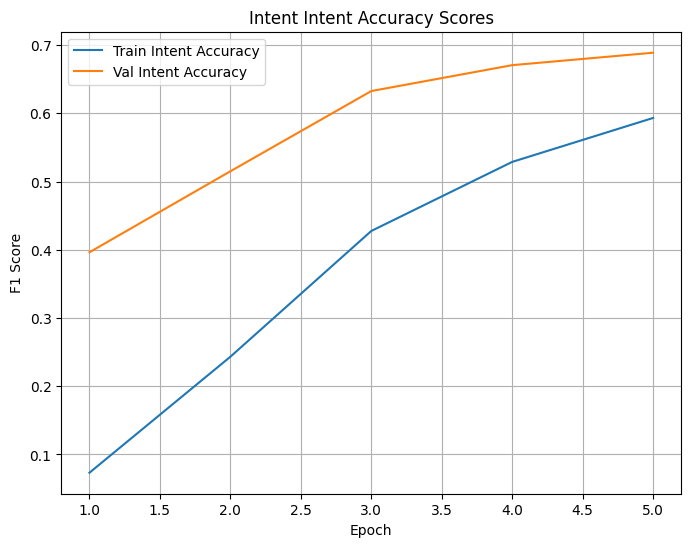

Intent Confusion Matrix saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/intent_cm.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
    test_results = json.load(f)

# Intent Intent Accuracy Scores Plot
epochs = range(1, len(metrics["train_intent_acc"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_intent_acc"], label="Train Intent Accuracy")
plt.plot(epochs, metrics["val_intent_acc"], label="Val Intent Accuracy")
plt.title("Intent Intent Accuracy Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "Intent_f1_plot.png"))
plt.show()
plt.close()

# Plot confusion matrices
# INTENT Confusion Matrixplt.figure(figsize=(8, 6))
sns.heatmap(test_results["intent_cm"], annot=True, fmt='d', cmap='Blues')
plt.title("Intent Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
intent_cm_path = os.path.join(SAVE_PATH, "intent_cm.png")
plt.savefig(intent_cm_path)
plt.close()
print(f"Intent Confusion Matrix saved to {intent_cm_path}")

## Category Evaluation (Weighted F1 Plot + Confusion Matrix)



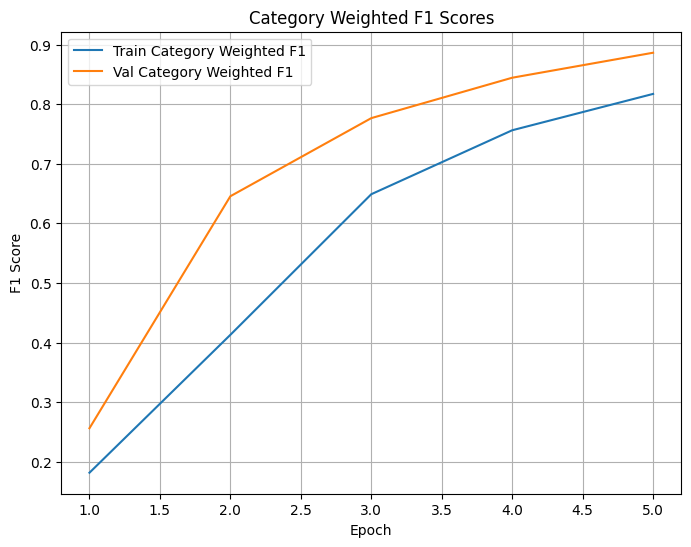

Category Confusion Matrix saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/category_cm.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
    test_results = json.load(f)

# Category Weighted F1 Plot
epochs = range(1, len(metrics["train_category_f1"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_category_f1"], label="Train Category Weighted F1")
plt.plot(epochs, metrics["val_category_f1"], label="Val Category Weighted F1")
plt.title("Category Weighted F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "category_f1_plot.png"))
plt.show()
plt.close()

# CATEGORY Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["category_cm"], annot=True, fmt='d', cmap='Blues')
plt.title("Category Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
category_cm_path = os.path.join(SAVE_PATH, "category_cm.png")
plt.savefig(category_cm_path)
plt.close()
print(f"Category Confusion Matrix saved to {category_cm_path}")

## NER Evaluation (F1 Plot)



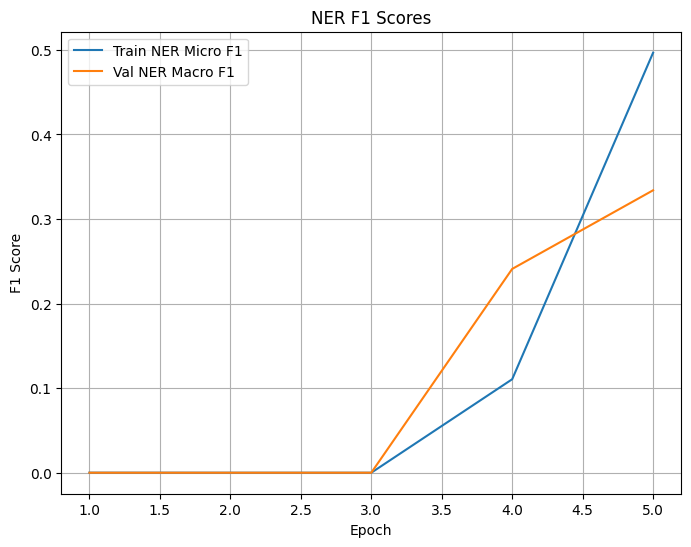

NER plot saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2


In [ ]:
import matplotlib.pyplot as plt
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)

# NER F1 Plot
epochs = range(1, len(metrics["train_ner_micro_f1"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_ner_micro_f1"], label="Train NER Micro F1")
plt.plot(epochs, metrics["val_ner_macro_f1"], label="Val NER Macro F1")
plt.title("NER F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "ner_f1_plot.png"))
plt.show()
plt.close()
print(f"NER plot saved to {SAVE_PATH}")

# Note: NER confusion matrix is not typically plotted due to sequence nature; use sequence-level metrics instead